# Sequencial NN

In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from config.config import *
from config.constants import *
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix
from collections import Counter
from sklearn.model_selection import train_test_split

In [9]:
import os
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [10]:
def plot_model(hist):
    fig, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)    

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])

    axs.set_title('Model Accuracy')
    axs.set_ylabel('Accuracy', fontsize=14)
    axs.set_xlabel('Epoch', fontsize=14)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    print("Model has training accuracy of {:.2f}%".format(hist.history['accuracy'][-1]*100))

In [11]:
def pre_process_split(path):
    
    dataset = pd.read_csv(path)
    dataset.dropna(inplace = True)
    
    # assigning new column names to the dataframe
    # dataset.columns = constants.cols + ['label']
    
    # creating training set ignoring labels
    train_data = dataset[dataset.columns[:-1]].values
    scaler = StandardScaler()    
    train_data = scaler.fit_transform(train_data)

    labels = dataset['label'].values
    n_class = len(set(labels))
    
    X_train, X_test, y_train, y_test =   train_test_split(train_data, labels, test_size=0.20)

    X_train = X_train.reshape(-1, 1, train_data.shape[1])
    X_test  = X_test.reshape(-1, 1, train_data.shape[1])
    y_train = y_train.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
    
    return X_train, X_test, y_train, y_test, n_class

In [12]:
box_plot = None
def model_config_train(name,eps,bs,actvn,datalink):
    global box_plot
    print("processing dataset")
    X_train, X_test, y_train, y_test, n_class = pre_process_split(datalink)
    
    print(n_class)
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(n_class, activation=actvn))
    print(model.summary())
       
    chk = ModelCheckpoint(name+'.pkl',save_best_only=True, mode='auto', verbose=1)
    print("saving as:",name+'.pkl')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=eps, batch_size=bs, callbacks=[chk], validation_split=0.2)    
    plot_model(hist)
    
    return model

## Loading dataset for binary classifier

In [13]:
def plotter(plot_data,unique_labels,n_plots):
    
    data = plot_data.copy()
    predicted_labels = data['label']
    #print(len(set(predicted_labels)),unique_labels)
    #print(Counter(predicted_labels).values(),[unique_labels[each] for each in Counter(predicted_labels).keys()])
    
    matrics = sorted(zip([unique_labels[each] for each in Counter(predicted_labels).keys()],Counter(predicted_labels).values() ), key=lambda x: x[1])
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    score = [list(j) for j in matrics][::-1]
    
    
    
    total = sum([i[1] for i in score])

    c=0
    for i in score:

        score[c][1] = str(round(i[1]*100/total,2))+"%"
        #print("Fault type:", i[-1], "Percentage: {:.2f}%".format(i[1]*100/total))
        c+=1

    print(pd.DataFrame.from_records(score,columns=['Fault type','Percentage']))
    
    #print("changing numbers to labels again")
    data['label'] = [unique_labels[i] for i in predicted_labels]

    fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))

    for j in range(n_plots):

        legend_list = []
        for i in range(len(set(predicted_labels))):

            extract = data[data.label==unique_labels[i]][cols[j]]    

            #print(len(extract))
            if unique_labels[i]==score[0][0] and score[0][0]!='NML' or unique_labels[i]== 'FAULT':
                temp = ax[j].scatter(extract.index,extract,marker='+',s=40)
            else:
                temp = ax[j].scatter(extract.index,extract,marker='.',s=10)


            legend_list.append(temp)

        ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

    fig.tight_layout()
    plt.show()

    return score[0][0]

In [14]:
def tester(model,frame):
    
    data = frame
    
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    
    if data.shape[1]==6:
        data.columns = cols
    elif data.shape[1]==7:
        data.columns = cols + ['label']
        data = data[cols]
    else:
        print("columns length is ",data.shape[1])
    
    
    test_preds = model.predict(data.values.reshape(-1,1,6).tolist())
    predicted_labels = np.argmax(test_preds,axis=1)
    
    data['label'] = predicted_labels
    
    return data
    

## Testing the models

processing dataset
2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 43,002
Trainable params: 43,002
Non-trainable params: 0
_________________________________________________________________
None
saving as: binary_clf.pkl
Epoch 1/10
704/704 [==============================] - 7s 8ms/step - loss: 0.2342 - accuracy: 0.9718 - val_loss: 0.0870 - val_accuracy: 0.9723

Epoch 00001: val_loss improved from inf to 0.08701, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 2/10
704/704 [==============================] - 6s 9ms/step - loss: 0.0854 - accuracy: 0.9720 - val_loss: 0.0842 - val_accuracy: 0.9724

Epoch 00002: val_loss improved from 0.08701 to 0.08422, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 3/10
704/704 [==============================] - 6s 8ms/step - loss: 0.0836 - accuracy: 0.9721 - val_loss: 0.0822 - val_accuracy: 0.9725

Epoch 00003: val_loss improved from 0.08422 to 0.08225, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 4/10
704/704 [==============================] - 6s 8ms/step - loss: 0.0810 - accuracy: 0.9724 - val_loss: 0.0803 - val_accuracy: 0.9731

Epoch 00004: val_loss improved from 0.08225 to 0.08025, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 5/10
704/704 [==============================] - 6s 8ms/step - loss: 0.0798 - accuracy: 0.9728 - val_loss: 0.0791 - val_accuracy: 0.9729

Epoch 00005: val_loss improved from 0.08025 to 0.07908, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 6/10
704/704 [==============================] - 6s 9ms/step - loss: 0.0785 - accuracy: 0.9734 - val_loss: 0.0784 - val_accuracy: 0.9745

Epoch 00006: val_loss improved from 0.07908 to 0.07837, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 7/10
704/704 [==============================] - 7s 10ms/step - loss: 0.0775 - accuracy: 0.9750 - val_loss: 0.0778 - val_accuracy: 0.9774

Epoch 00007: val_loss improved from 0.07837 to 0.07782, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 8/10
704/704 [==============================] - 7s 9ms/step - loss: 0.0766 - accuracy: 0.9767 - val_loss: 0.0773 - val_accuracy: 0.9787

Epoch 00008: val_loss improved from 0.07782 to 0.07726, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 9/10
704/704 [==============================] - 6s 9ms/step - loss: 0.0768 - accuracy: 0.9773 - val_loss: 0.0766 - val_accuracy: 0.9777

Epoch 00009: val_loss improved from 0.07726 to 0.07664, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 10/10
704/704 [==============================] - 6s 9ms/step - loss: 0.0767 - accuracy: 0.9778 - val_loss: 0.0764 - val_accuracy: 0.9774

Epoch 00010: val_loss improved from 0.07664 to 0.07637, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


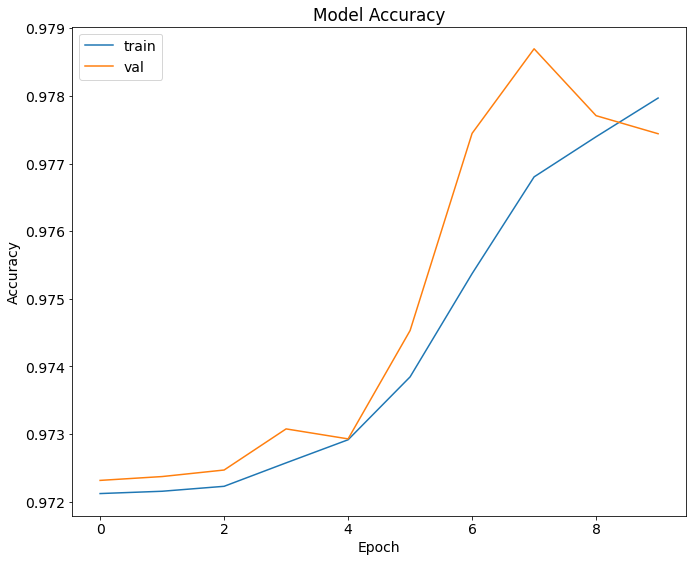

Model has training accuracy of 97.80%


In [32]:
model_config_train('binary_clf',5,2000,'softmax','./KMTrainingSet/binary/bin_dataset_simulink.csv')

processing dataset
11
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1111      
Total params: 43,911
Trainable params: 43,911
Non-trainable params: 0
_________________________________________________________________
None
saving as: multi_clf.pkl
Epoch 1/5
92/92 [==============================] - 3s 17ms/step - loss: 2.1692 - accuracy: 0.5168 - val_loss: 1.3953 - val_accuracy: 0.7851

Epoch 00001: val_loss improved from inf to 1.39528, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 2/5
92/92 [==============================] - 1s 12ms/step - loss: 1.1701 - accuracy: 0.8427 - val_loss: 0.6790 - val_accuracy: 0.8727

Epoch 00002: val_loss improved from 1.39528 to 0.67898, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 3/5
92/92 [==============================] - 1s 12ms/step - loss: 0.5863 - accuracy: 0.8747 - val_loss: 0.3959 - val_accuracy: 0.8746

Epoch 00003: val_loss improved from 0.67898 to 0.39590, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 4/5
92/92 [==============================] - 1s 13ms/step - loss: 0.3634 - accuracy: 0.8776 - val_loss: 0.2952 - val_accuracy: 0.8822

Epoch 00004: val_loss improved from 0.39590 to 0.29522, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 5/5
92/92 [==============================] - 1s 12ms/step - loss: 0.2826 - accuracy: 0.8830 - val_loss: 0.2557 - val_accuracy: 0.8853

Epoch 00005: val_loss improved from 0.29522 to 0.25566, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


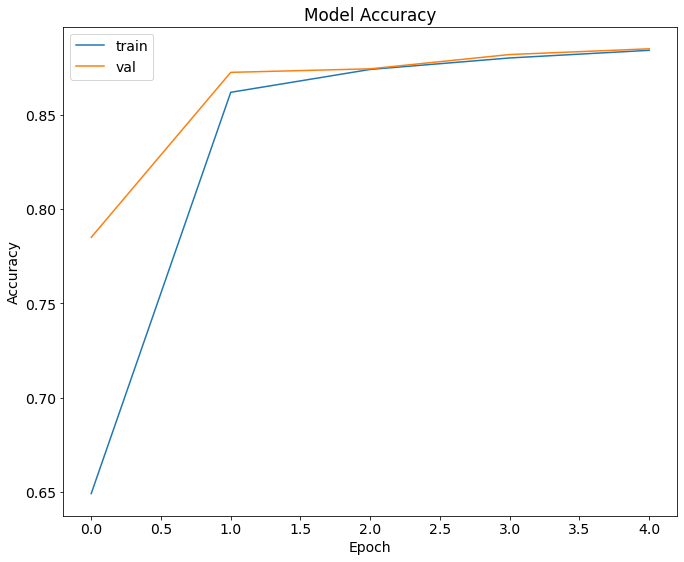

Model has training accuracy of 88.45%


In [33]:
model_config_train('multi_clf',5,2000,'softmax','./KMTrainingSet/multi/mul_dataset_simulink.csv')

In [36]:
binary_labels_list = ['NML','FAULT']
binary_model = load_model('binary_clf.pkl')

In [37]:
multi_labels_list = ['AB', 'AC', 'BC', 'ABC', 'AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']
multi_model = load_model('multi_clf.pkl')

In [39]:
temp = tester(binary_model,pd.read_csv('ml_test.csv'))

In [43]:
Counter(temp['label']).keys()

dict_keys([0, 1])

  Fault type Percentage
0      FAULT     99.83%
1        NML      0.17%


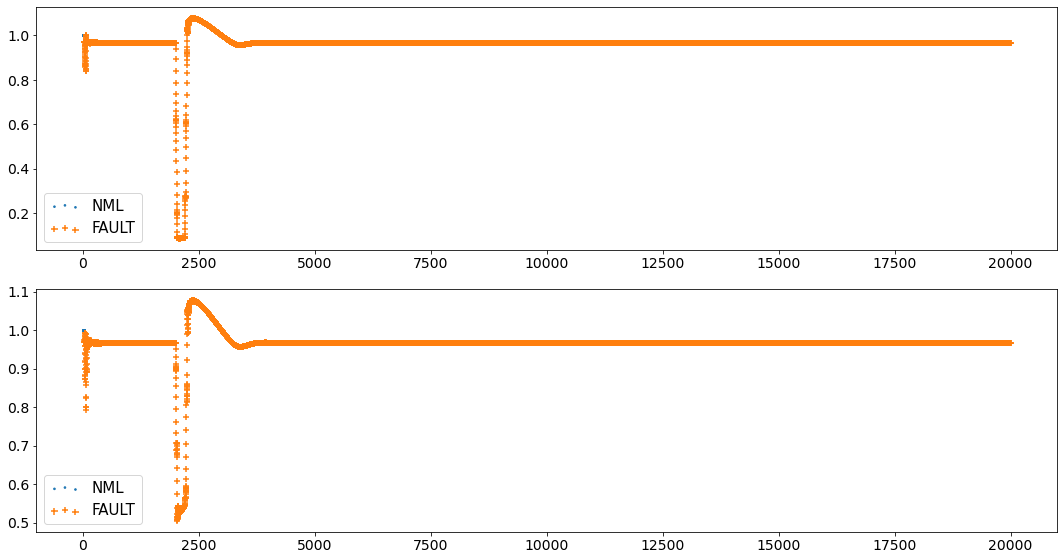

  Fault type Percentage
0        ABC     100.0%


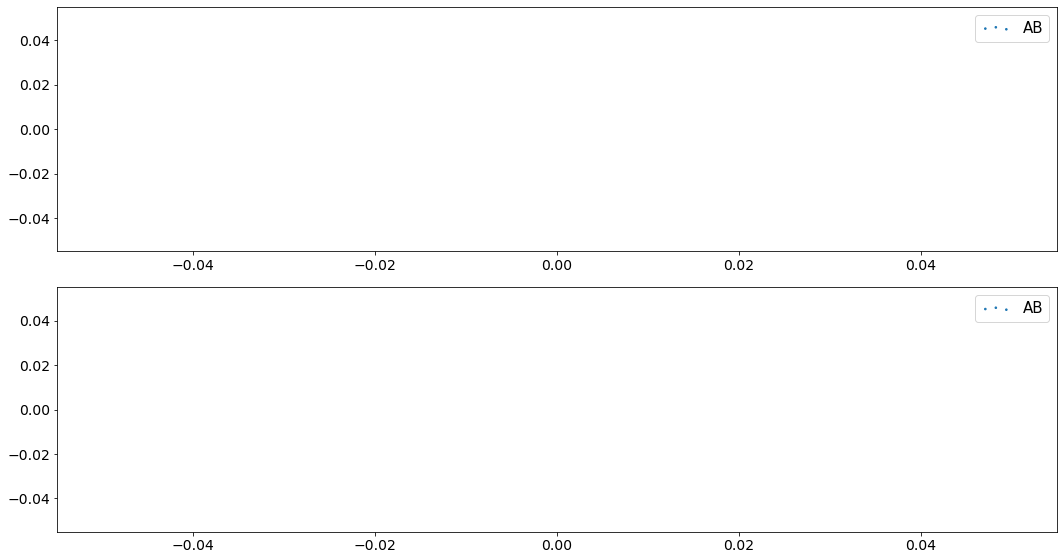

ABC


In [44]:
temp = tester(binary_model,pd.read_csv('ml_test.csv'))
plotter(temp,binary_labels_list,2)
temp = tester(multi_model,temp[temp.label!=1])
high = plotter(temp,multi_labels_list,2)
print(high)

In [27]:
# current directory
path = "./KMTrainingSet/"

# list of file of the given path is assigned to the variable 
file_list = [each for each in list(os.walk(path))[0][-1] if ".csv" in each]


.
.
 5ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


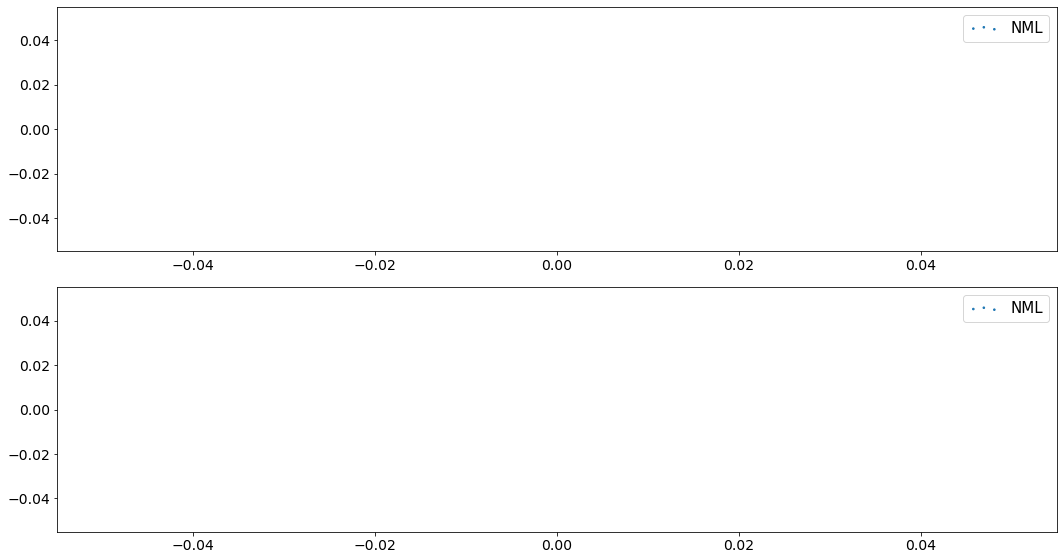

  Fault type Percentage
0        ABC     100.0%


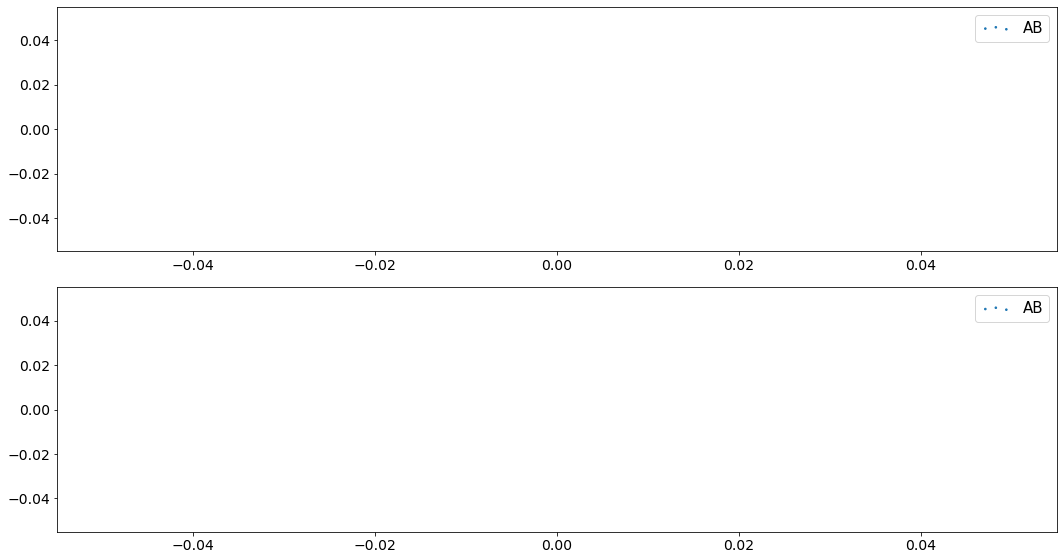


.
.
 10ABG.csv
  Fault type Percentage
0      FAULT     100.0%


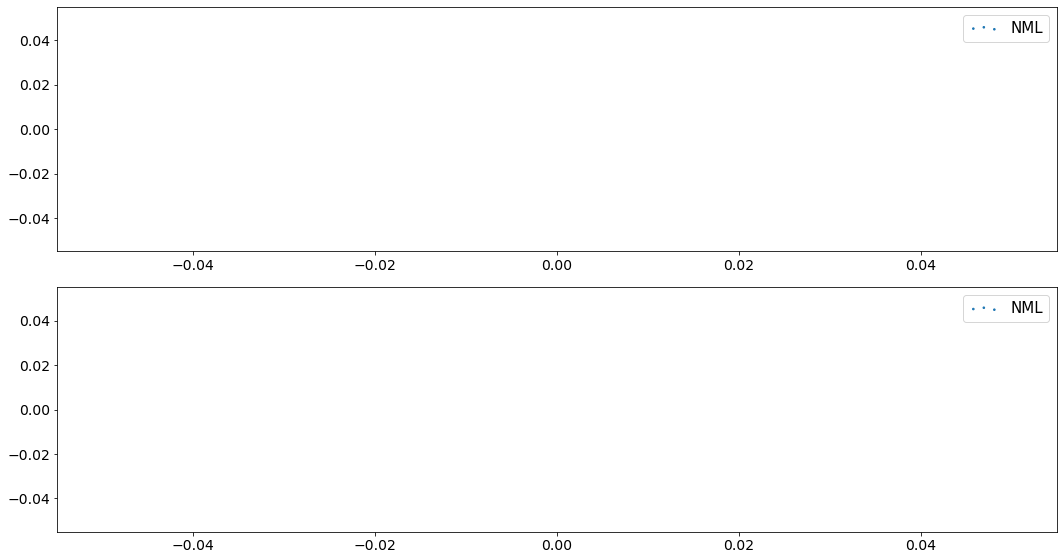

  Fault type Percentage
0        ABC     100.0%


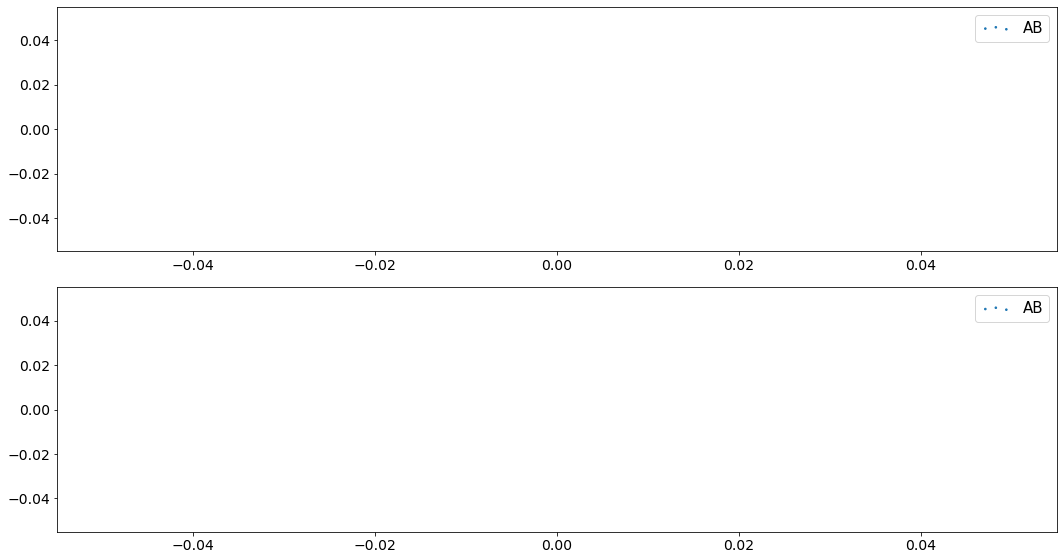


.
.
 3BC.csv
  Fault type Percentage
0      FAULT     100.0%


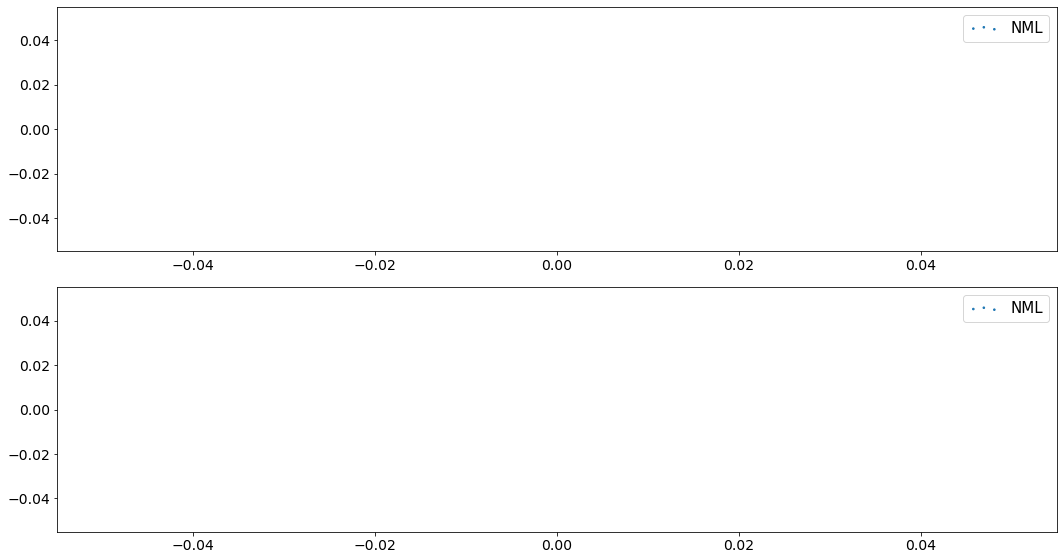

  Fault type Percentage
0        ABC     99.98%
1        BCG      0.02%


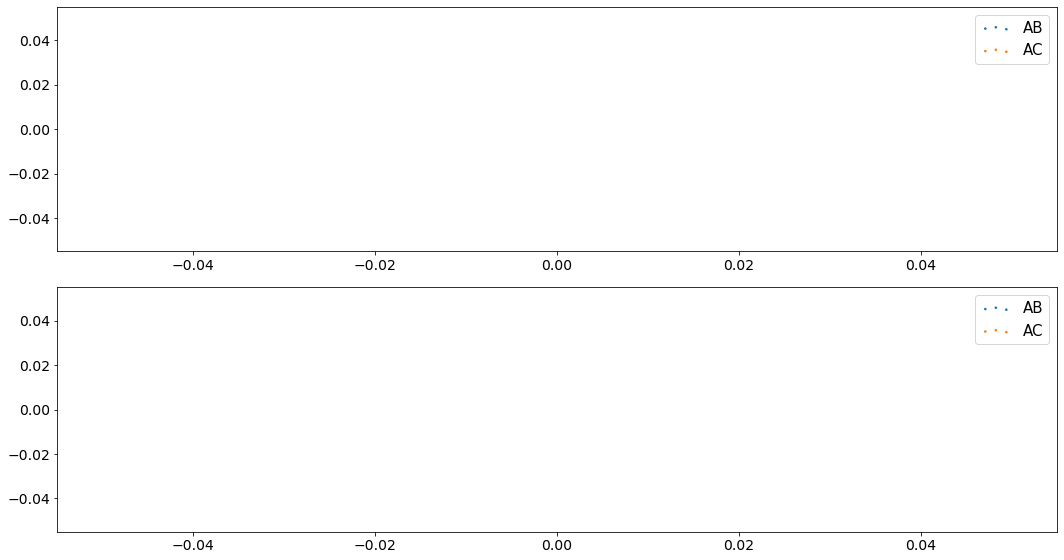


.
.
 3CG.csv
  Fault type Percentage
0      FAULT     100.0%


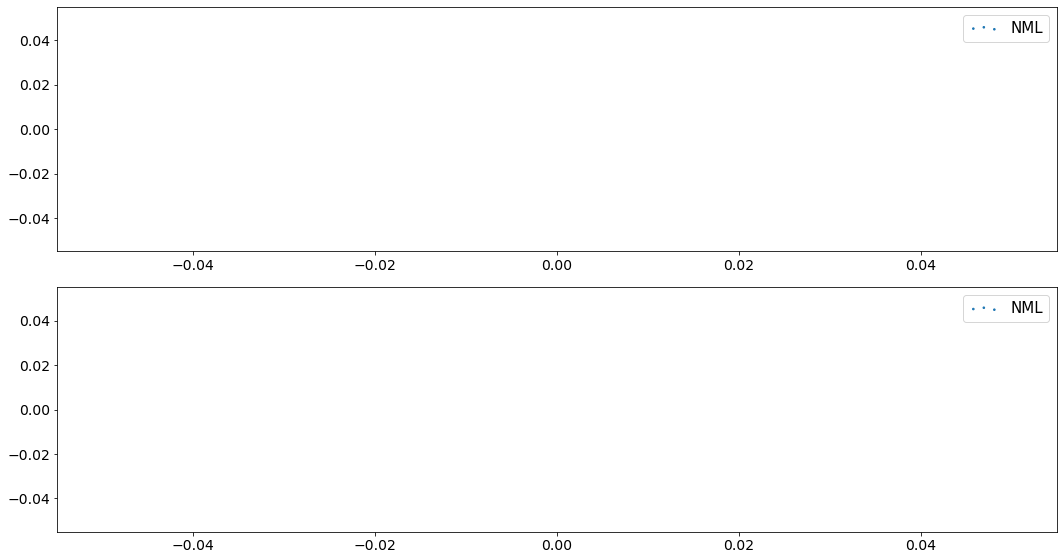

  Fault type Percentage
0        ABC     99.48%
1        ACG      0.52%


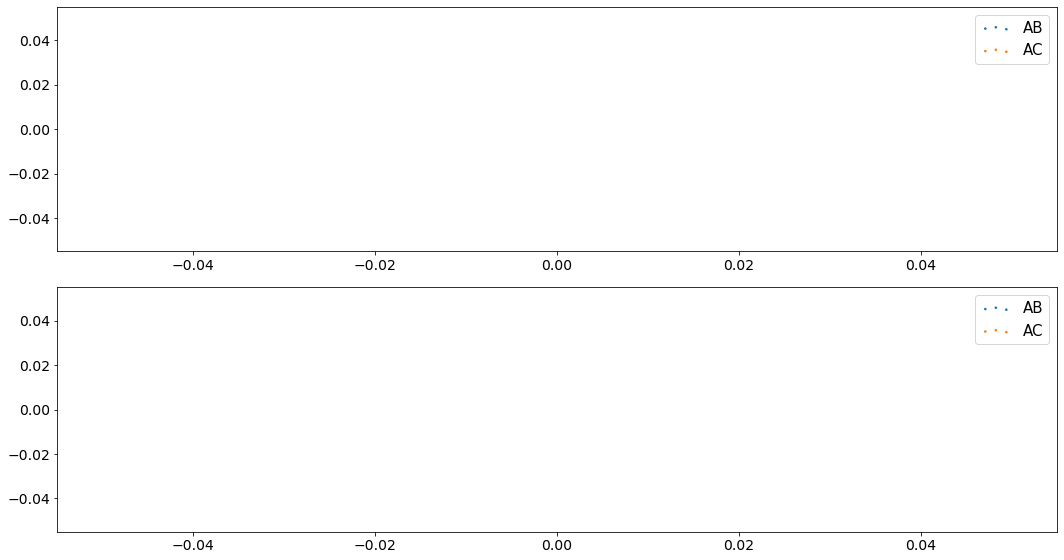


.
.
 1BCG.csv
  Fault type Percentage
0      FAULT     100.0%


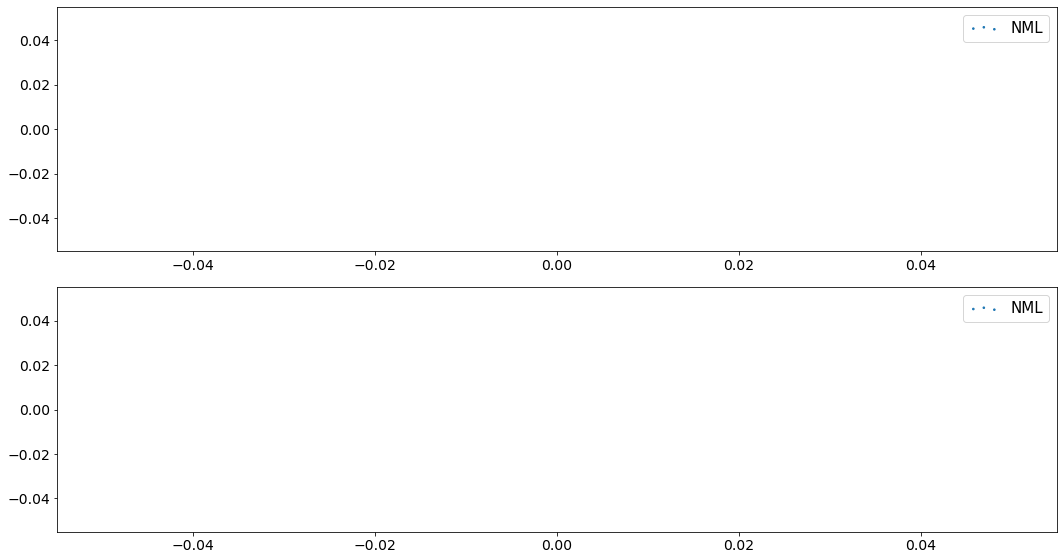

  Fault type Percentage
0        ABC     99.95%
1        BCG      0.04%
2        ACG      0.01%


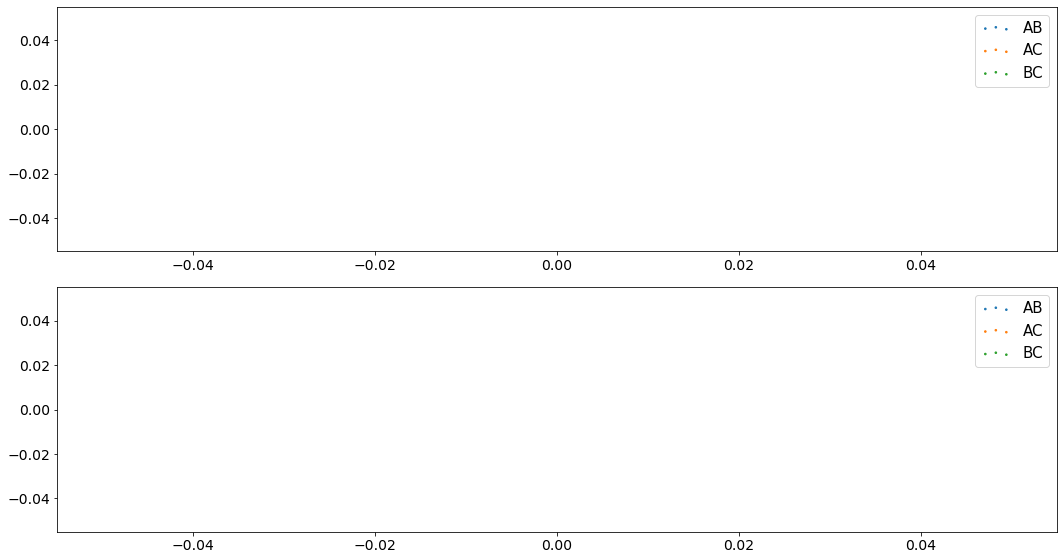


.
.
 7BG.csv
  Fault type Percentage
0      FAULT     100.0%


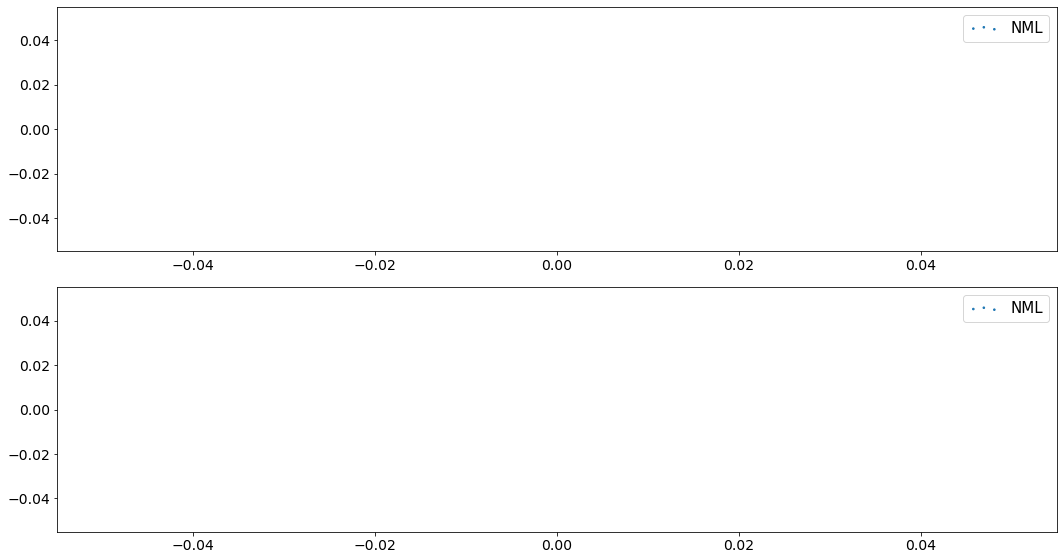

  Fault type Percentage
0        ABC     99.98%
1        BCG      0.01%


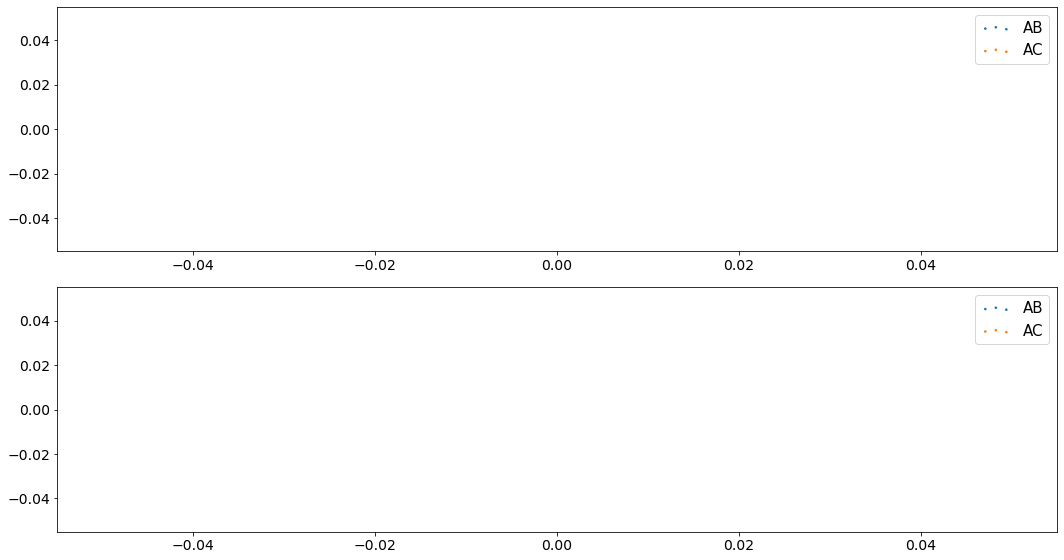


.
.
 5BG.csv
  Fault type Percentage
0      FAULT     100.0%


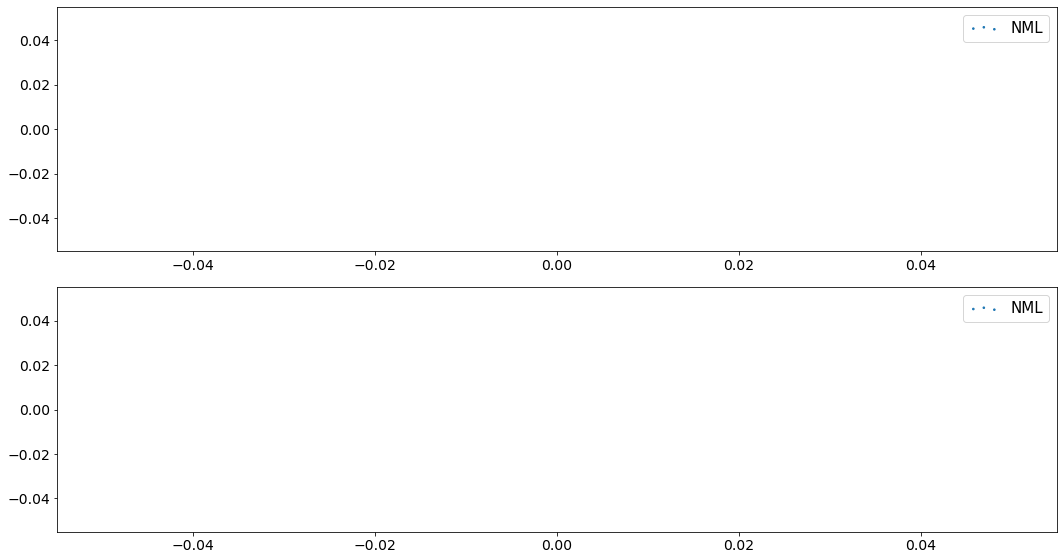

  Fault type Percentage
0        ABC     100.0%


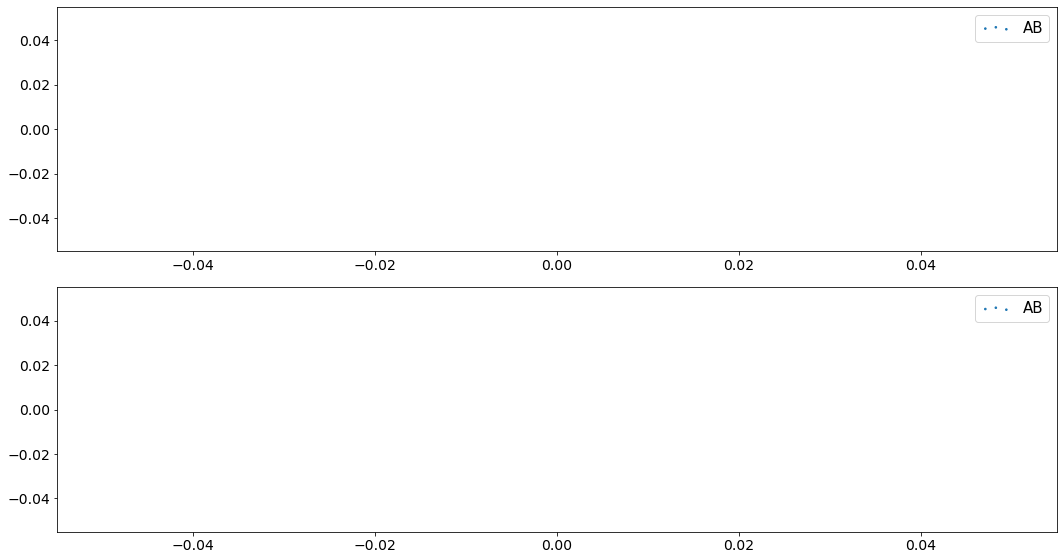


.
.
 9ABG.csv
  Fault type Percentage
0      FAULT     100.0%


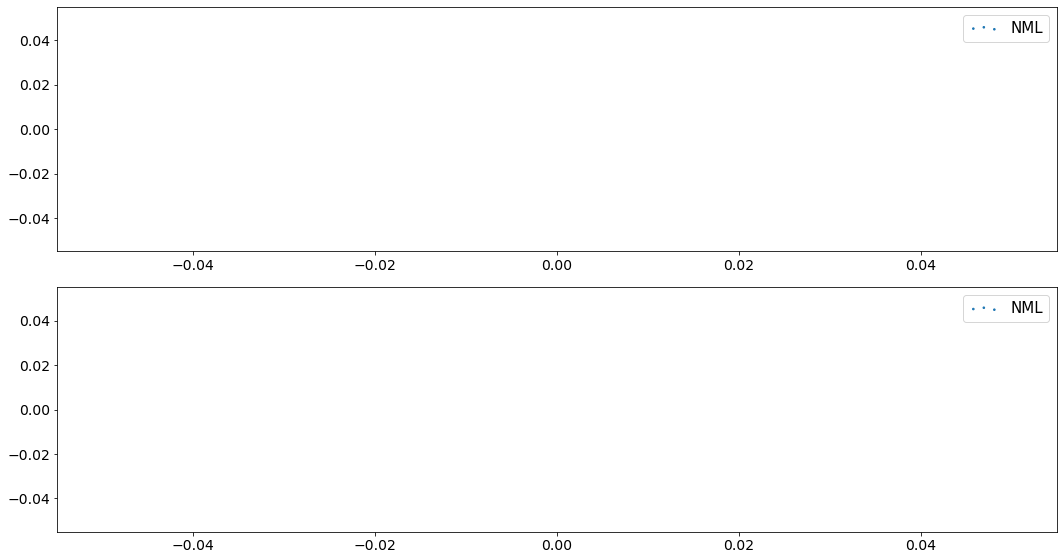

  Fault type Percentage
0        ABC     100.0%


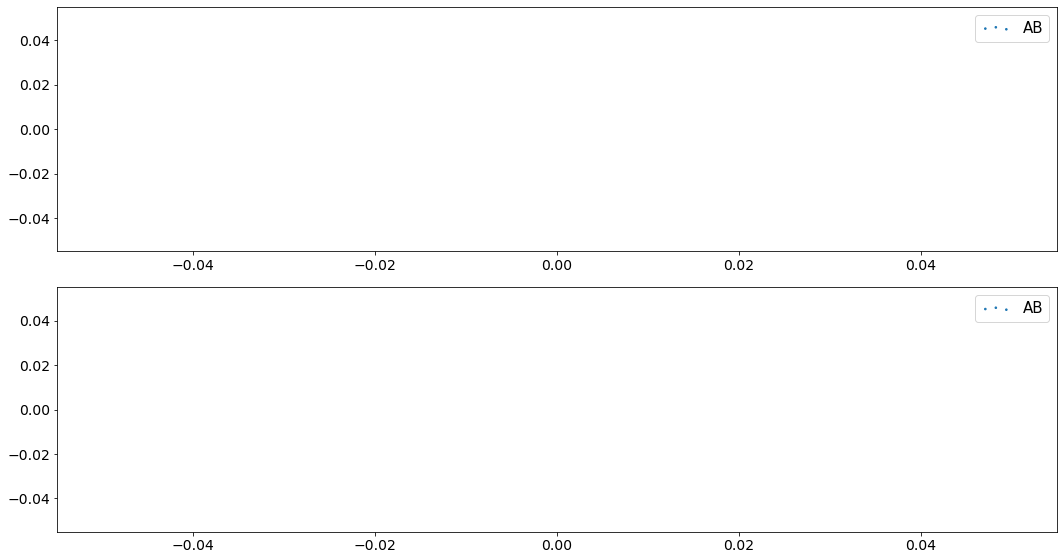


.
.
 1BC.csv
  Fault type Percentage
0      FAULT     100.0%


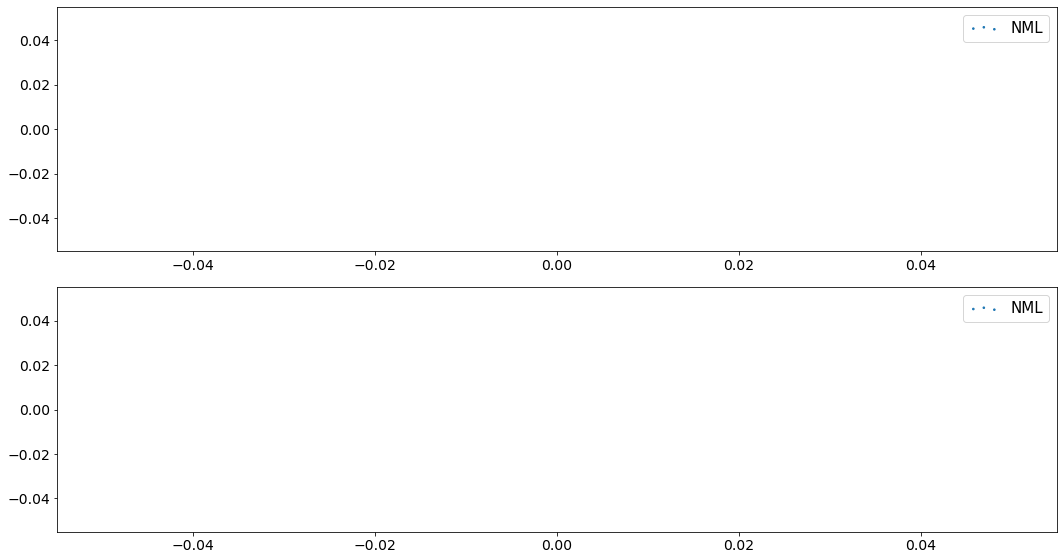

  Fault type Percentage
0        ABC     100.0%


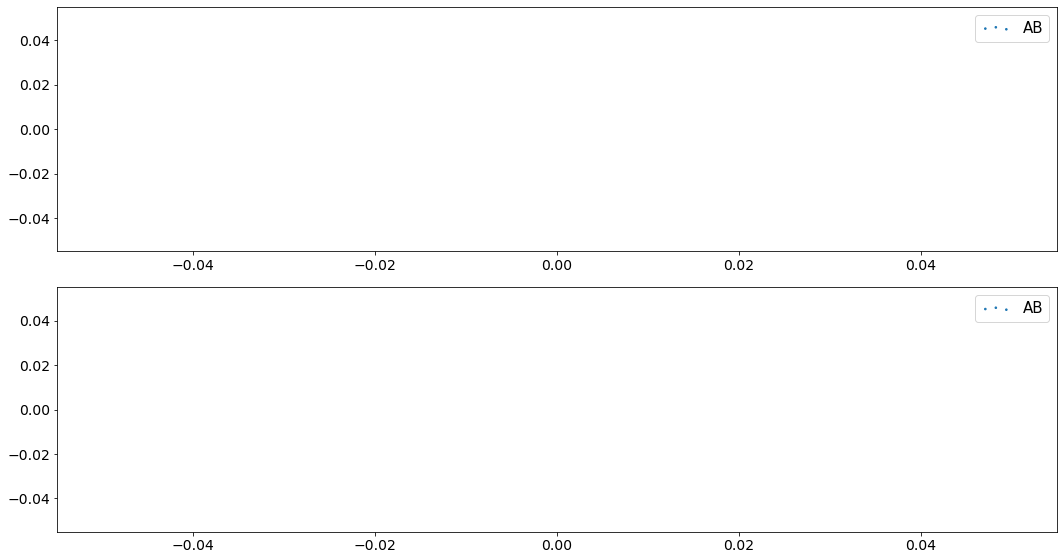


.
.
 1CG.csv
  Fault type Percentage
0      FAULT     100.0%


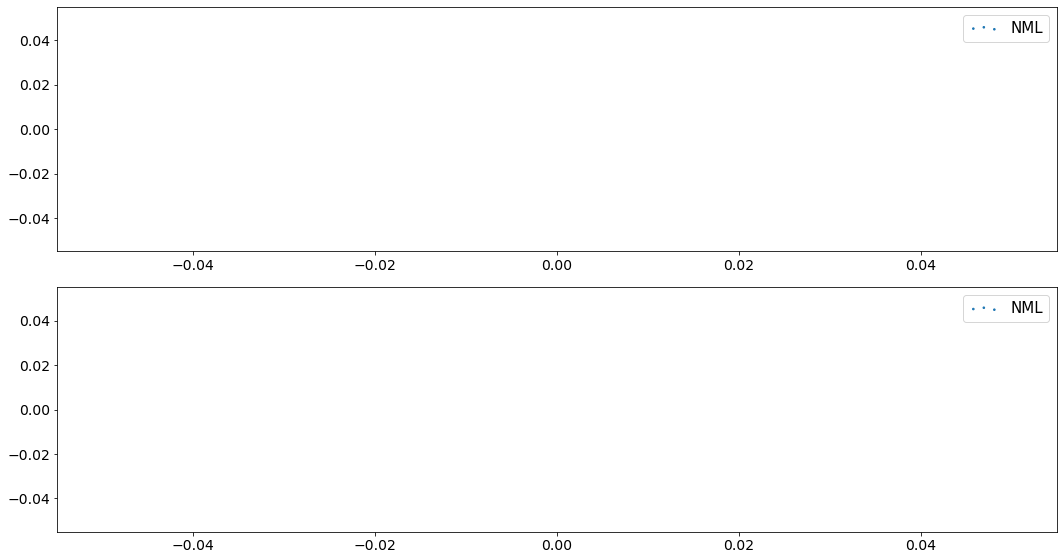

  Fault type Percentage
0        ABC     93.37%
1        ACG      6.62%
2        BCG      0.01%


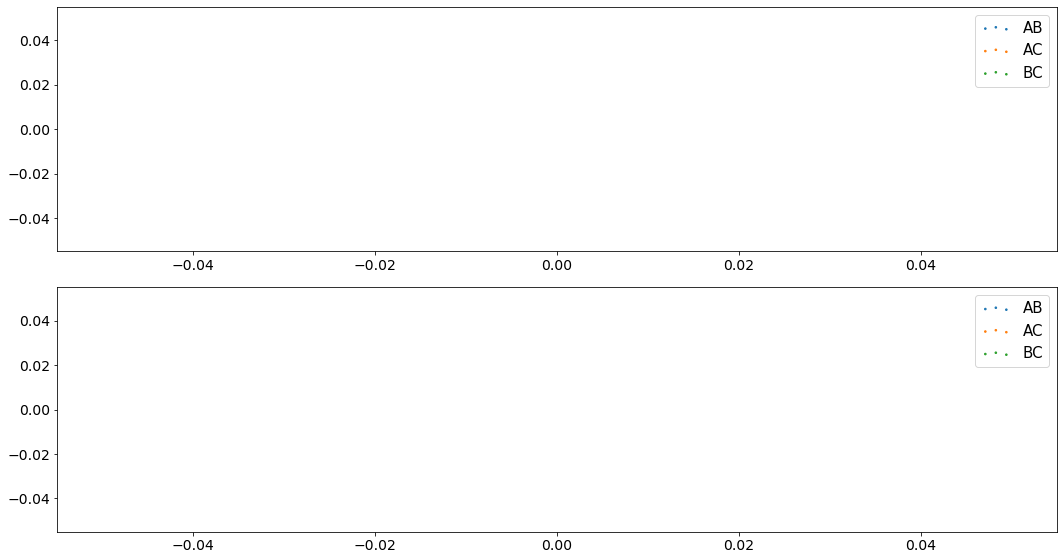


.
.
 5ABG.csv
  Fault type Percentage
0      FAULT     100.0%


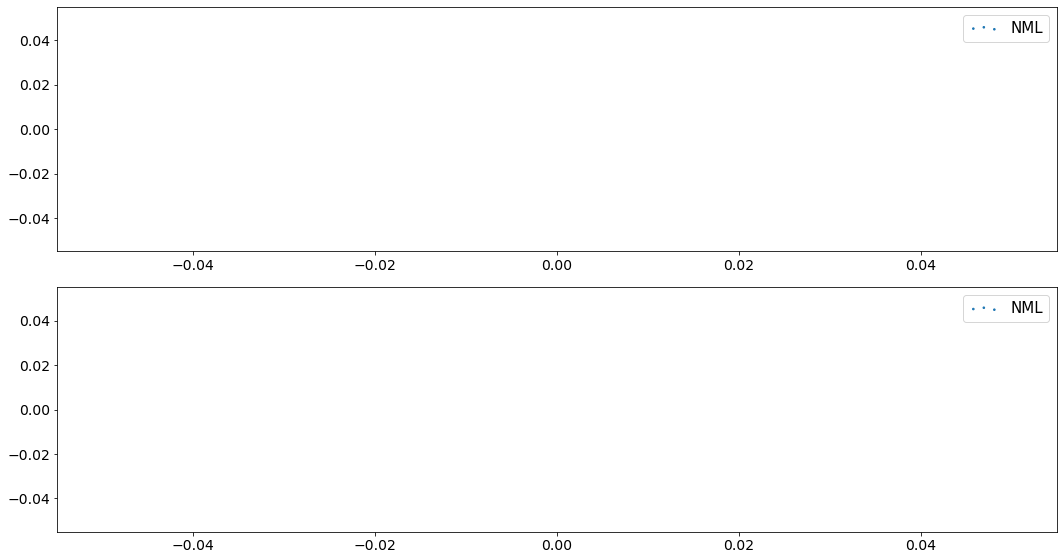

  Fault type Percentage
0        ABC     100.0%


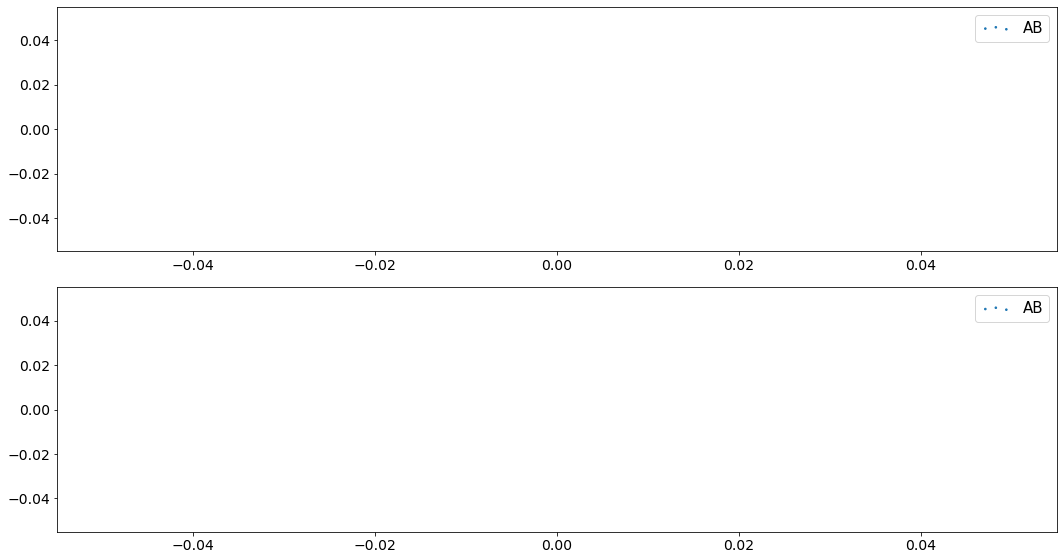


.
.
 9AG.csv
  Fault type Percentage
0      FAULT     100.0%


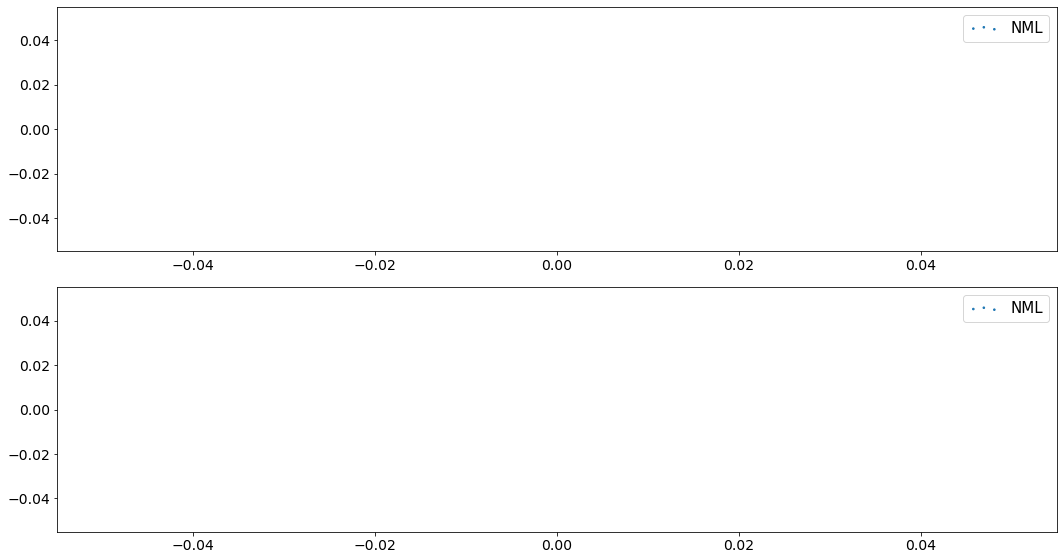

  Fault type Percentage
0        ABC     82.41%
1        ACG     12.15%
2        ABG      5.44%


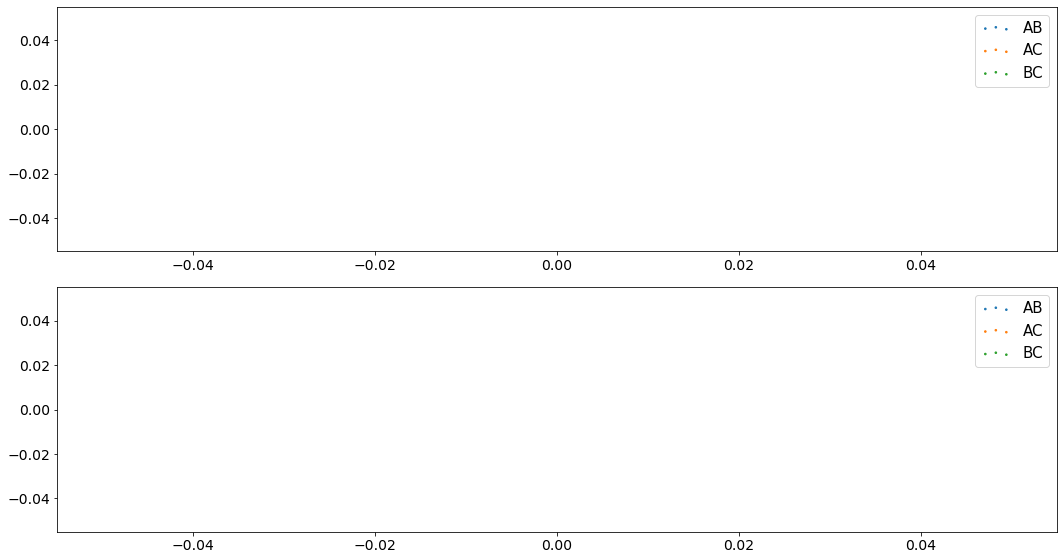


.
.
 7ABC.csv
  Fault type Percentage
0      FAULT     100.0%


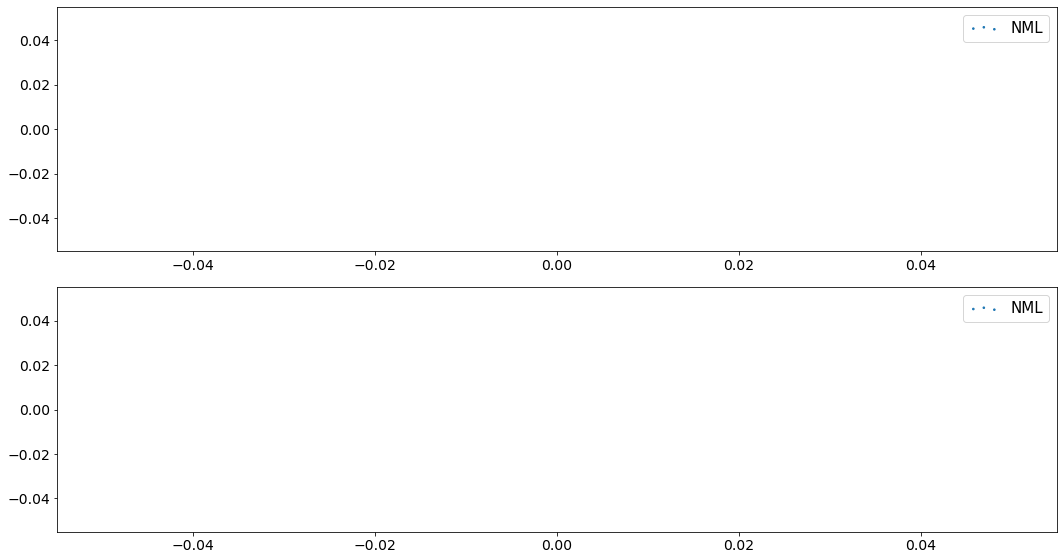

  Fault type Percentage
0        ABC     100.0%


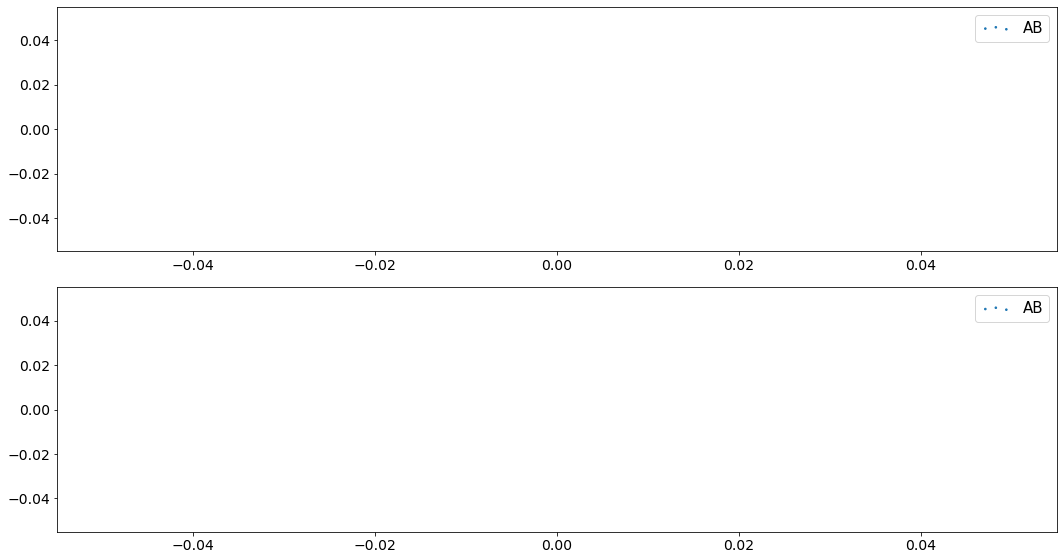


.
.
 7ACG.csv
  Fault type Percentage
0      FAULT     100.0%


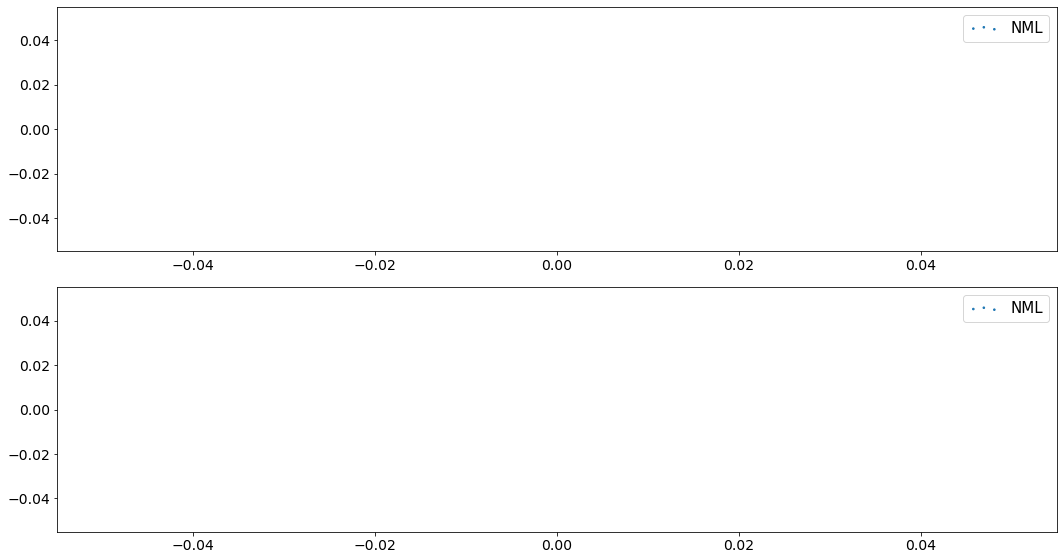

  Fault type Percentage
0        ABC     100.0%


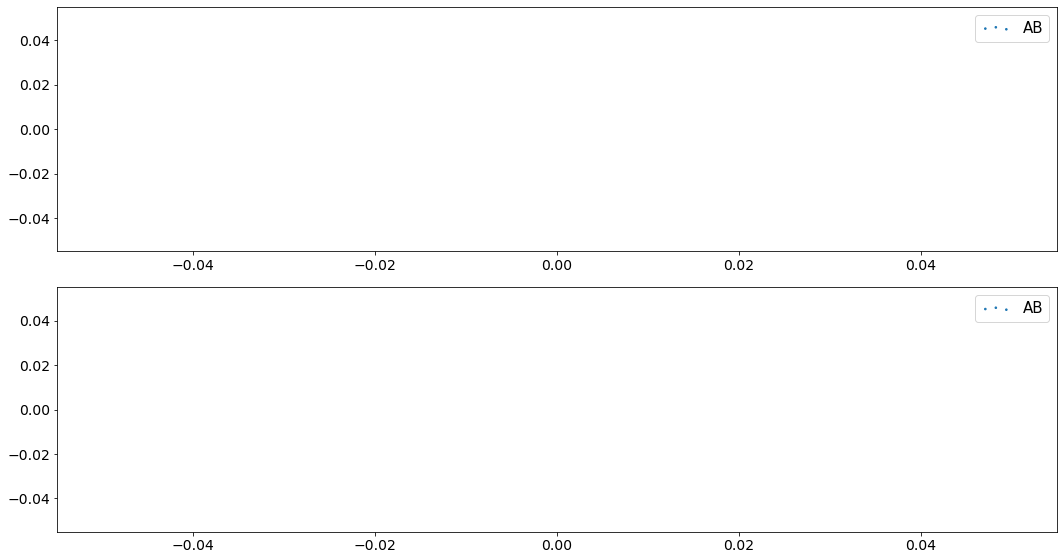


.
.
 7ABG.csv
  Fault type Percentage
0      FAULT     100.0%


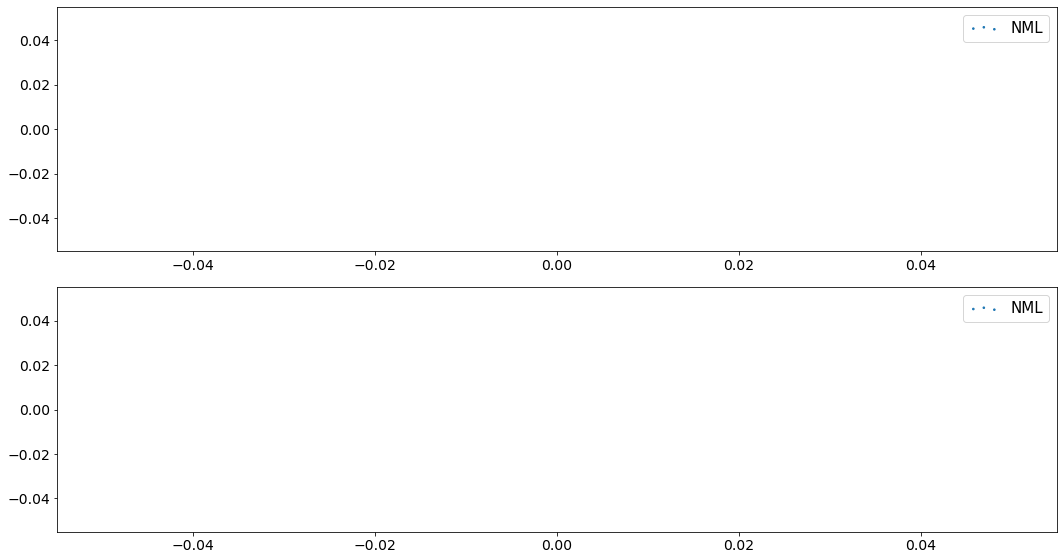

  Fault type Percentage
0        ABC     100.0%


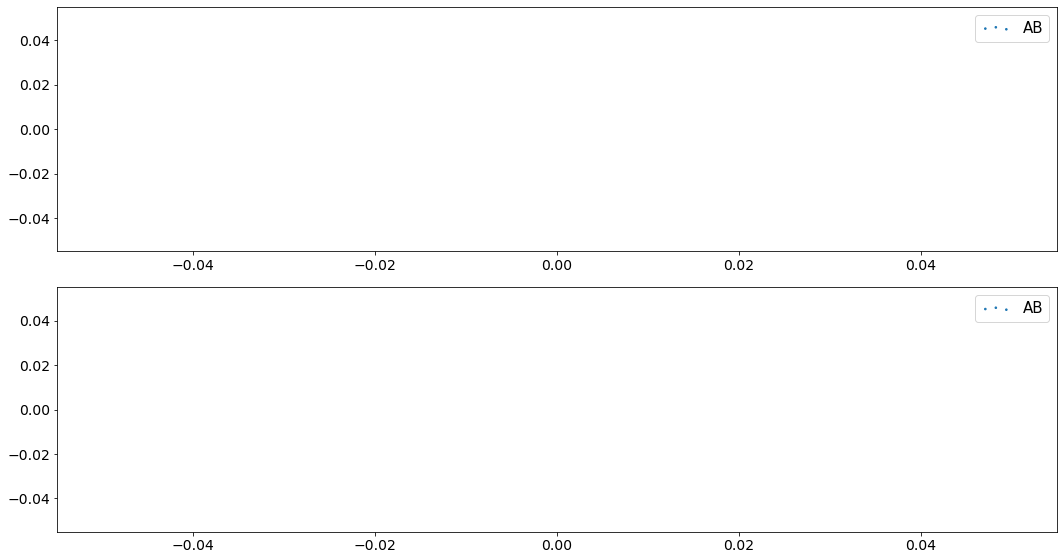


.
.
 9AC.csv
  Fault type Percentage
0      FAULT     100.0%


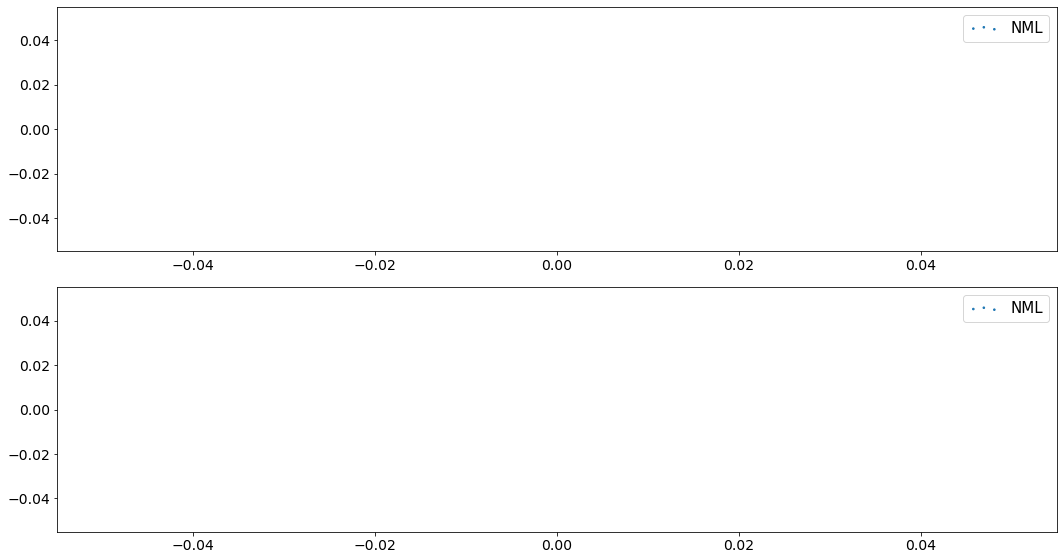

  Fault type Percentage
0        ABC     84.28%
1        ACG     15.72%


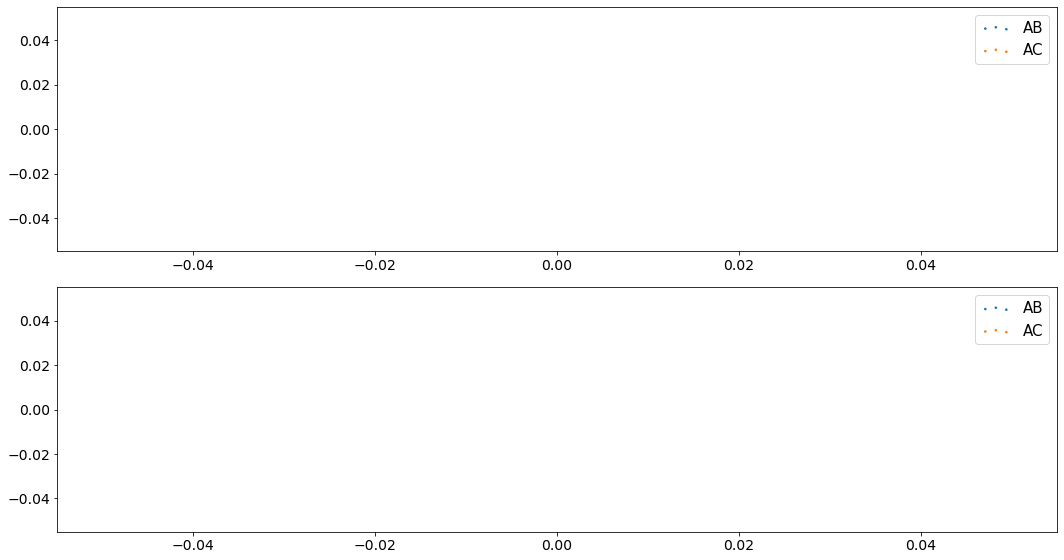


.
.
 1BG.csv
  Fault type Percentage
0      FAULT     100.0%


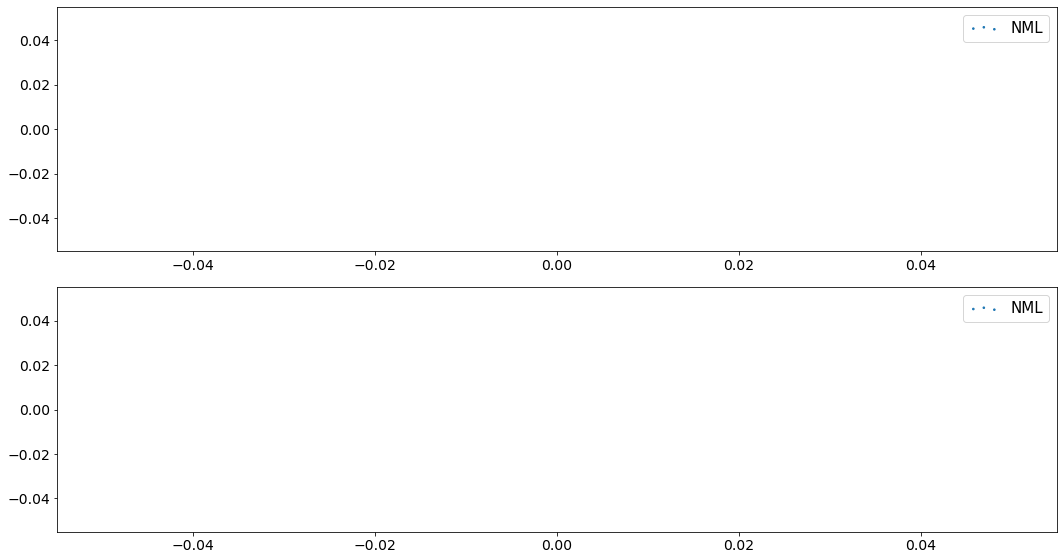

  Fault type Percentage
0        ABC     99.99%
1        BCG      0.01%


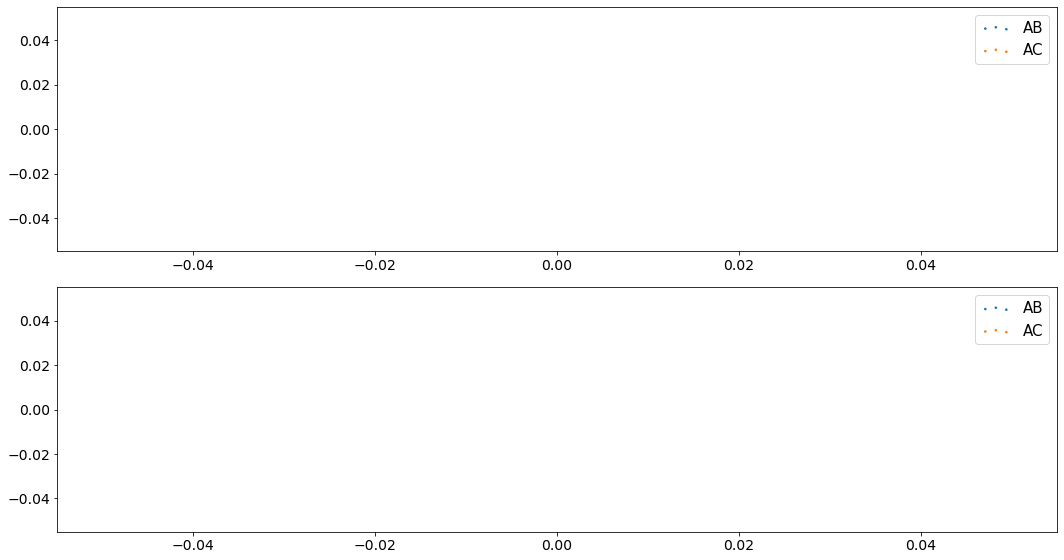


.
.
 5ABC.csv
  Fault type Percentage
0      FAULT     100.0%


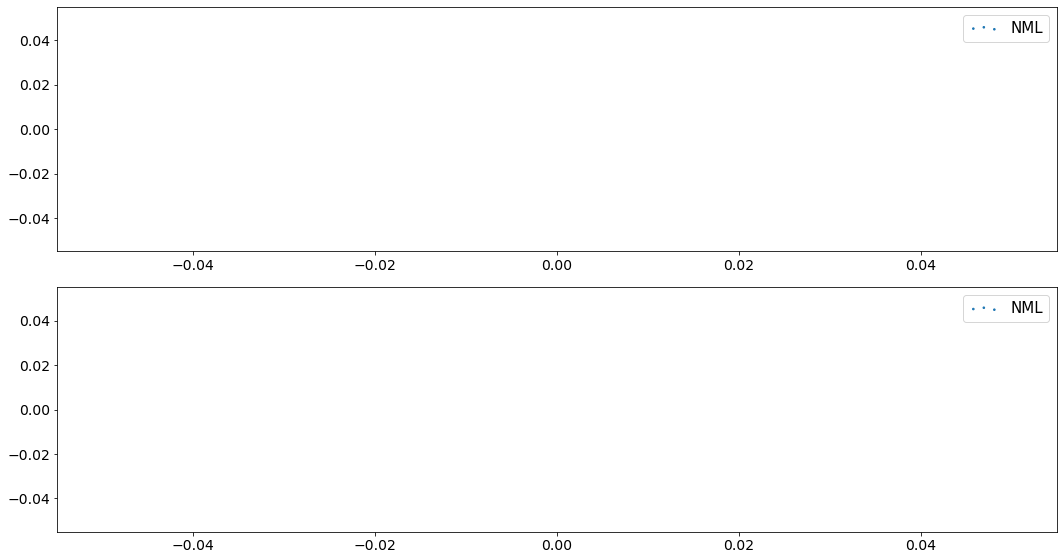

  Fault type Percentage
0        ABC     100.0%


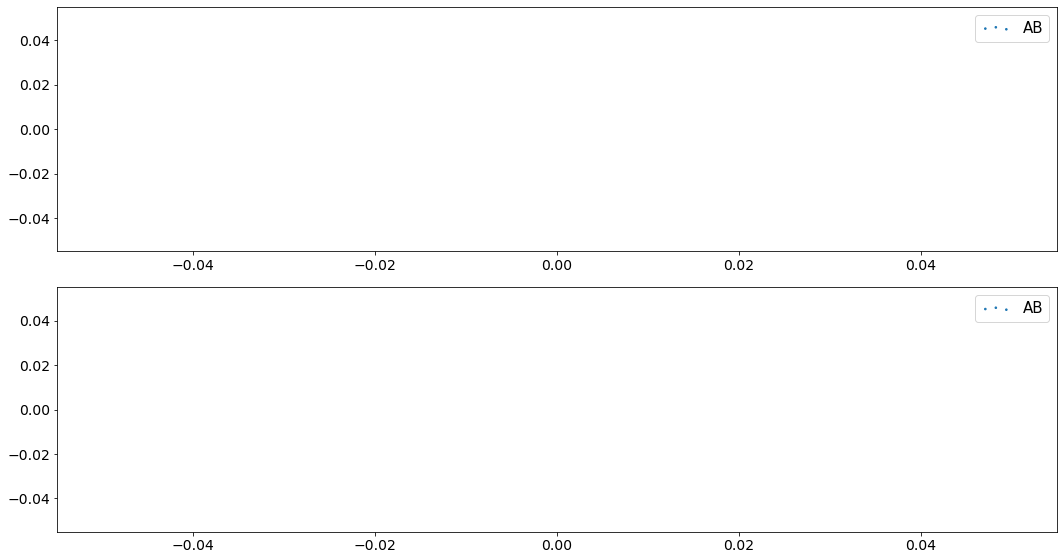


.
.
 5ACG.csv
  Fault type Percentage
0      FAULT     100.0%


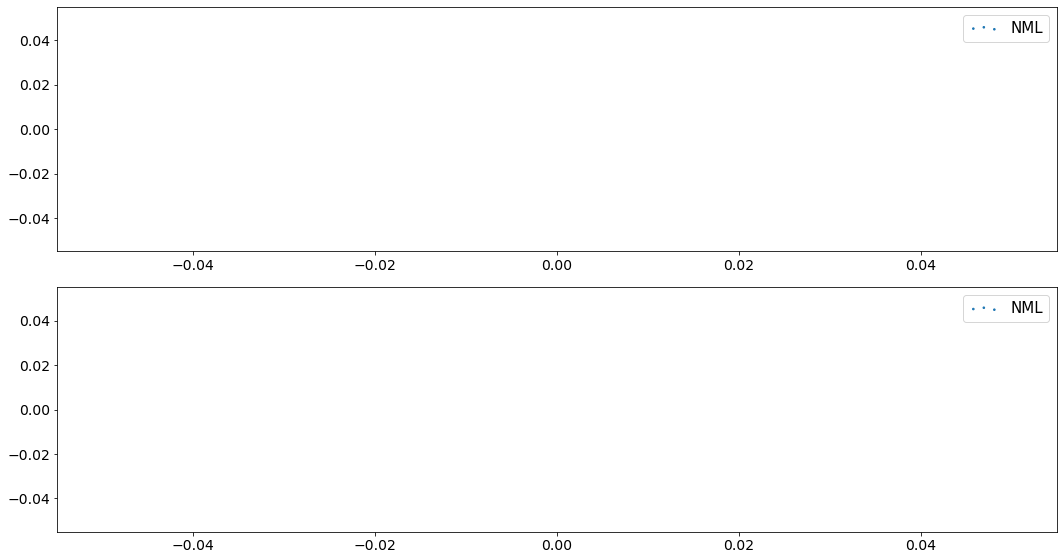

  Fault type Percentage
0        ABC     99.99%
1        ACG      0.01%


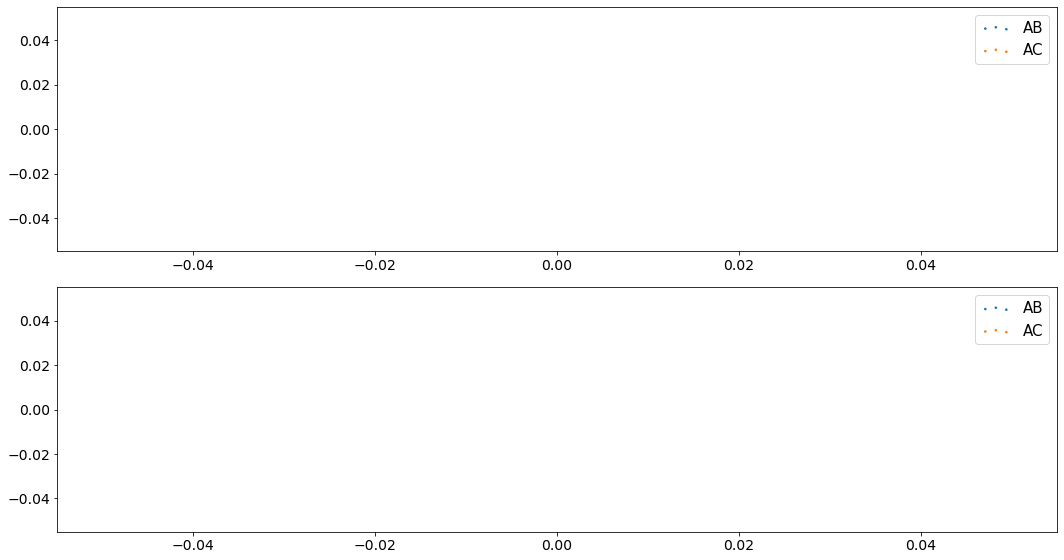


.
.
 9AB.csv
  Fault type Percentage
0      FAULT     100.0%


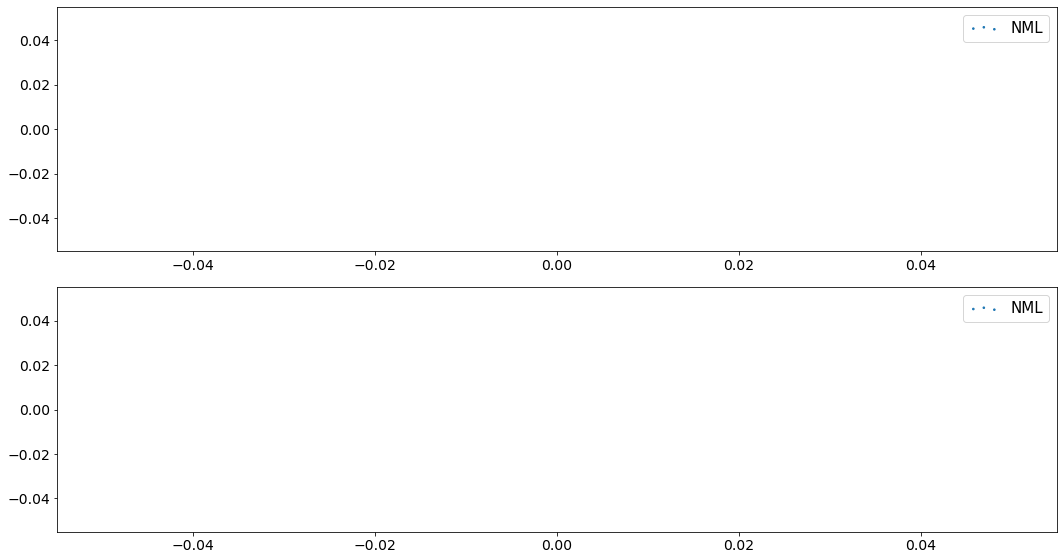

  Fault type Percentage
0        ABC     78.14%
1        ABG     21.86%


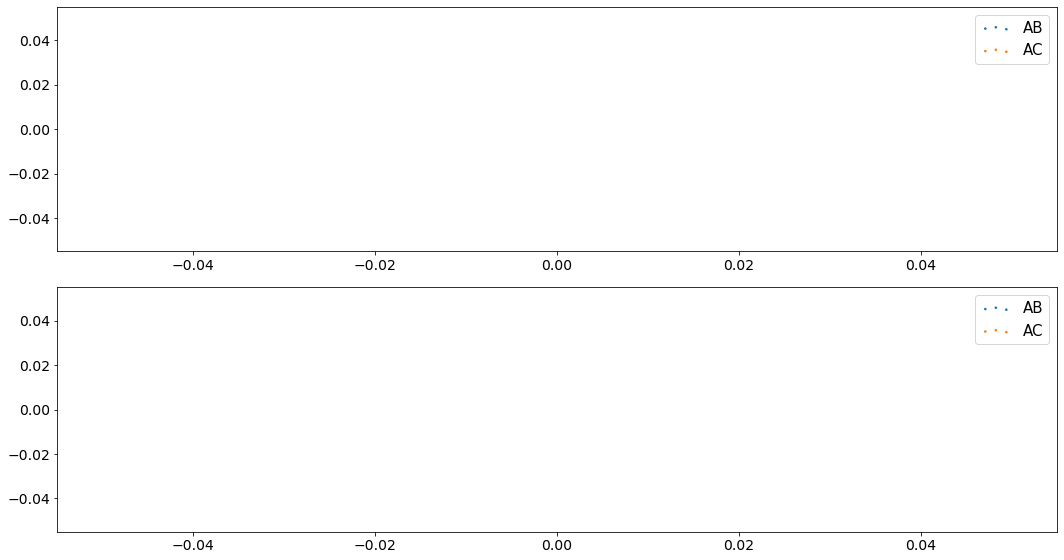


.
.
 9ACG.csv
  Fault type Percentage
0      FAULT     100.0%


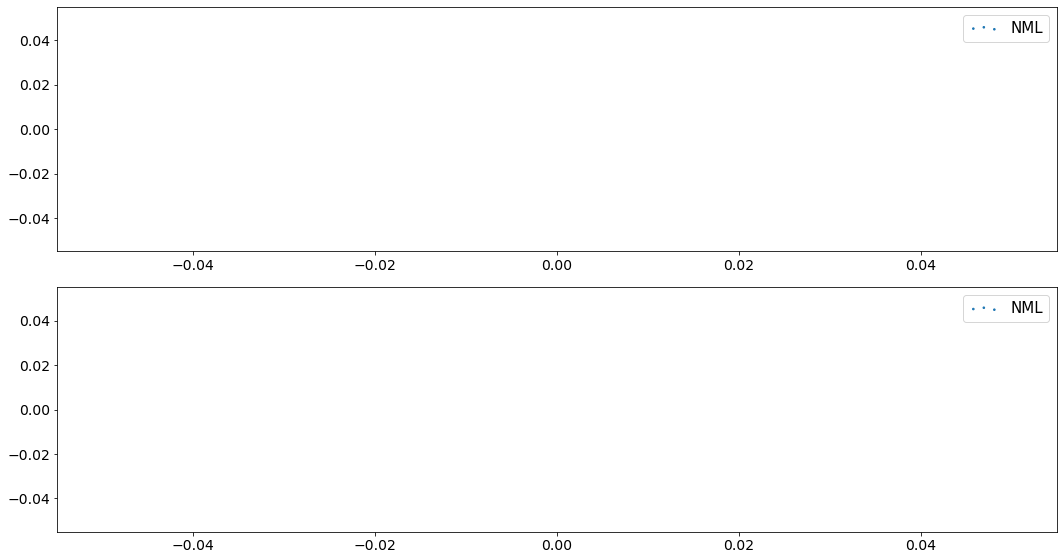

  Fault type Percentage
0        ABC     99.98%
1        ACG      0.01%


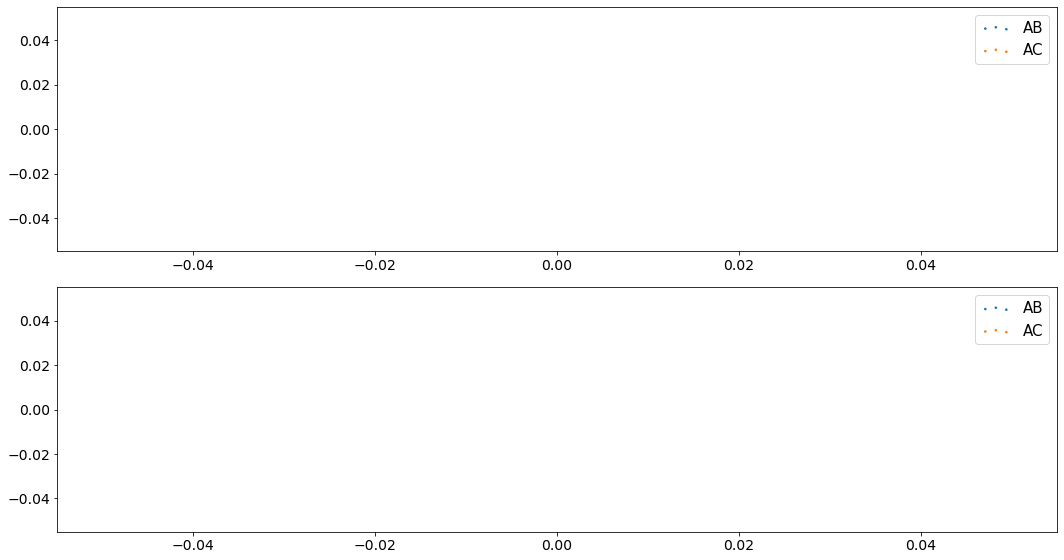


.
.
 9ABC.csv
  Fault type Percentage
0      FAULT     100.0%


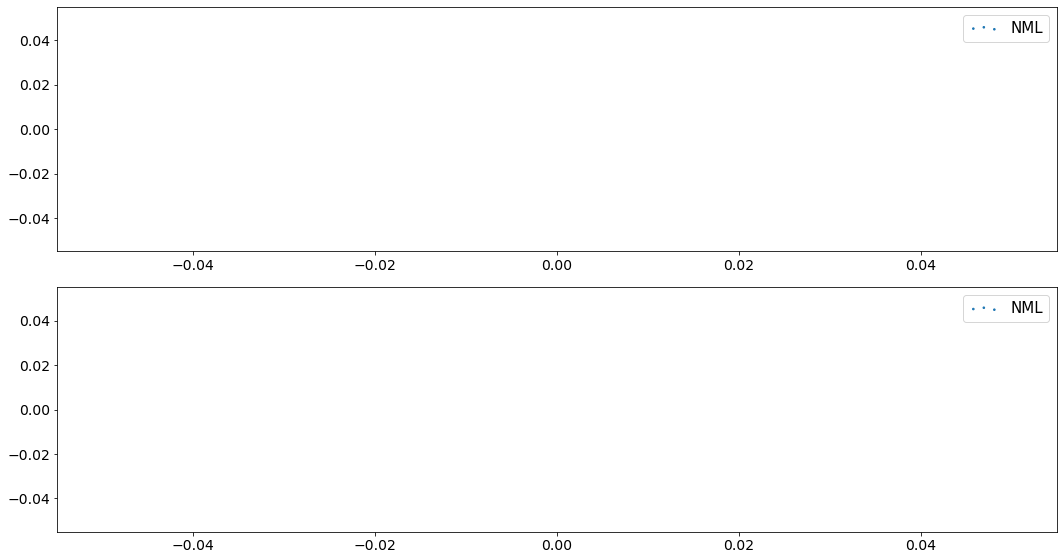

  Fault type Percentage
0        ABC     100.0%


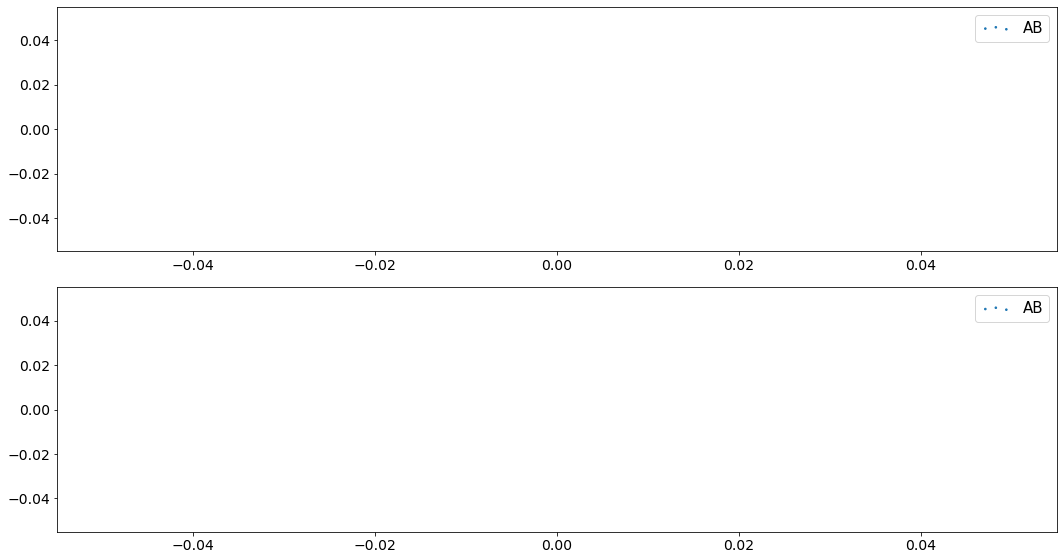


.
.
 5BC.csv
  Fault type Percentage
0      FAULT     100.0%


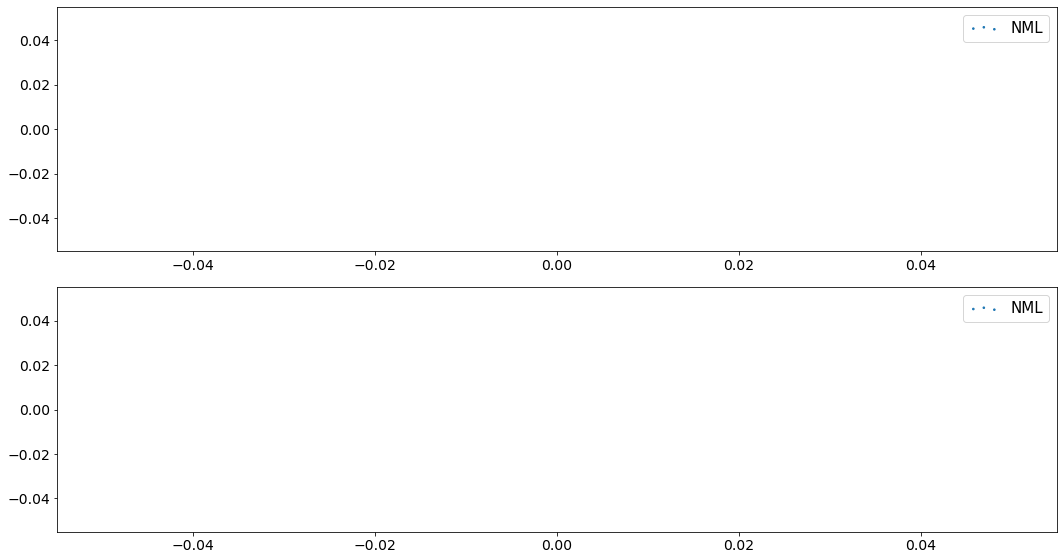

  Fault type Percentage
0        ABC     99.97%
1        BCG      0.03%


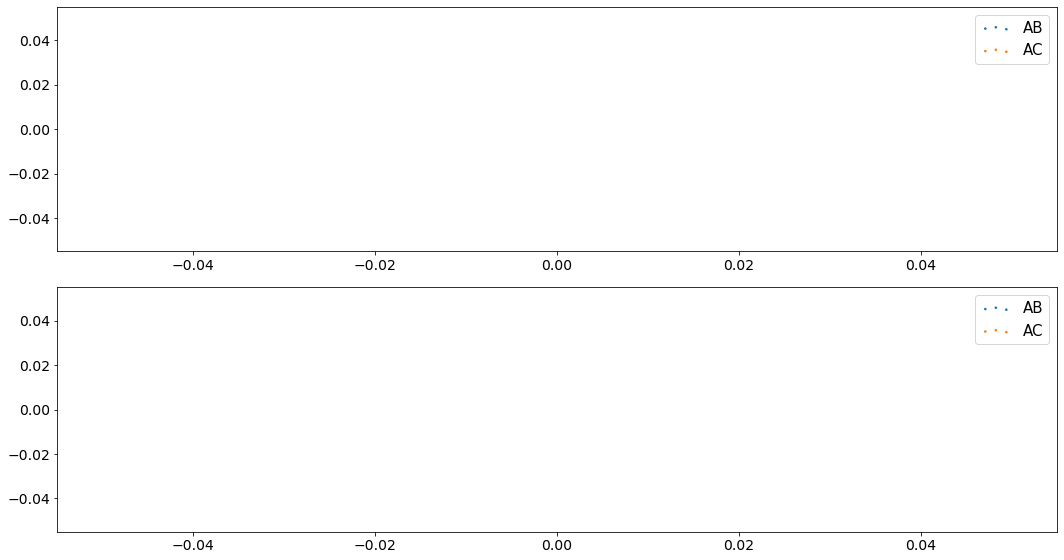


.
.
 5CG.csv
  Fault type Percentage
0      FAULT     100.0%


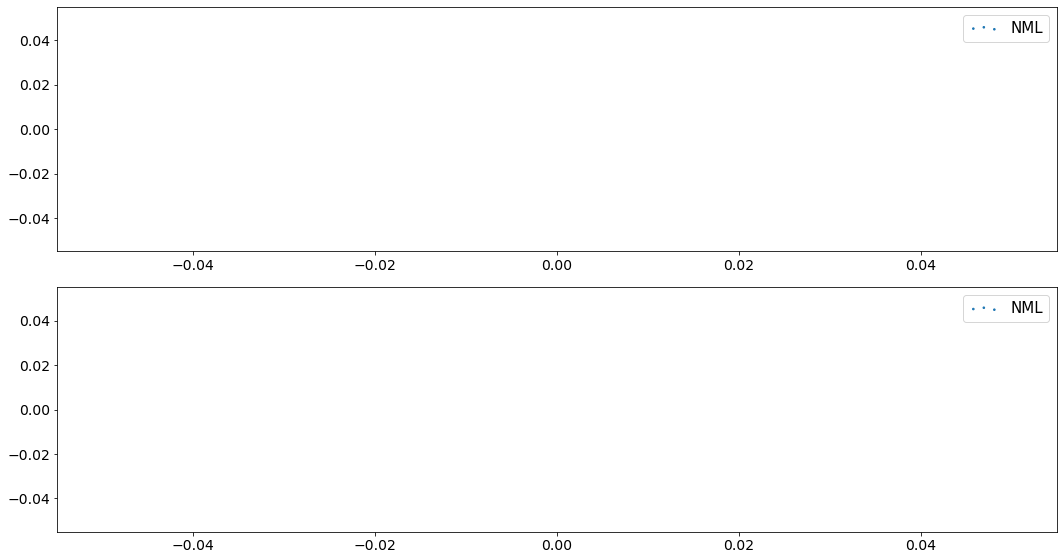

  Fault type Percentage
0        ABC     96.54%
1        ACG      3.46%


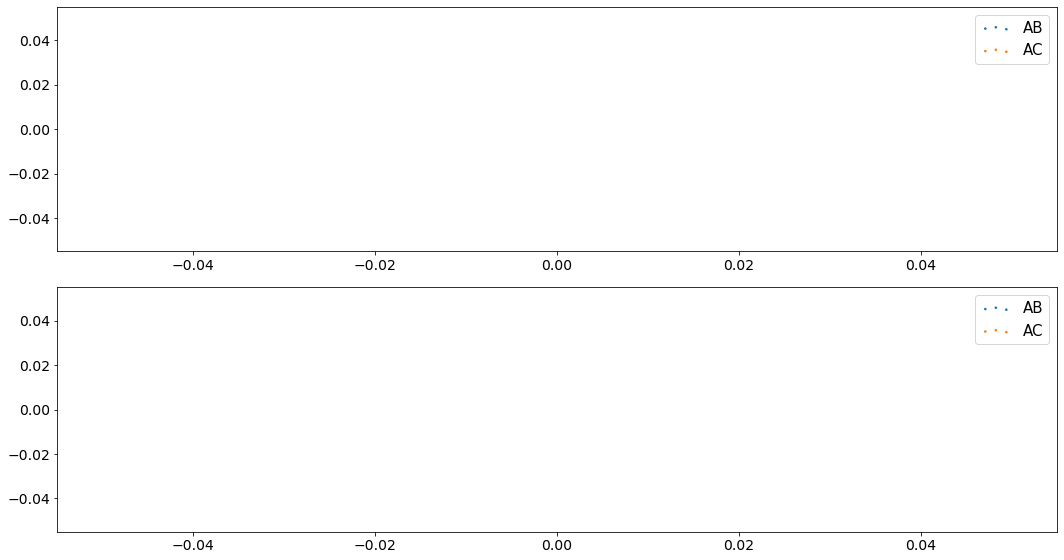


.
.
 4ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


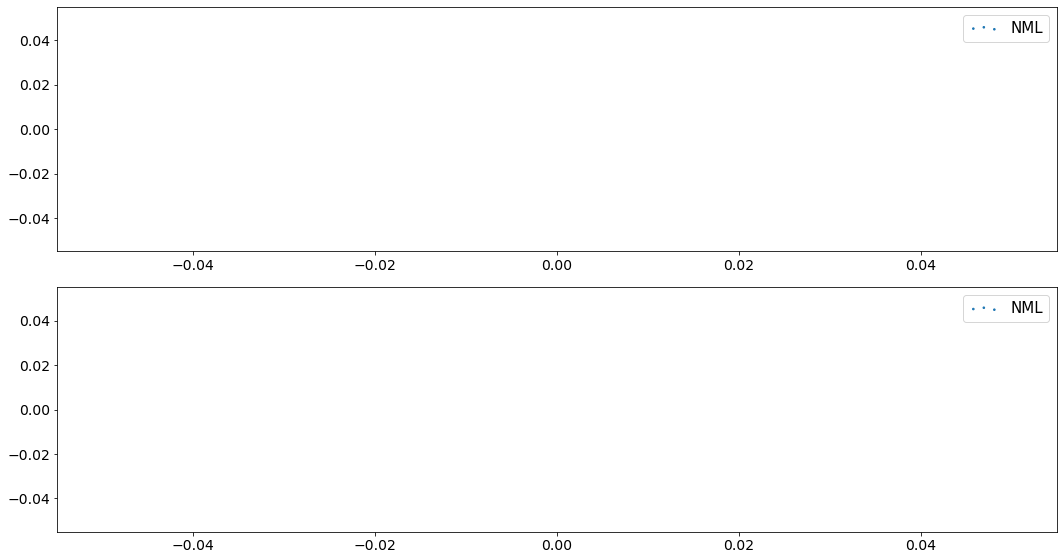

  Fault type Percentage
0        ABC     99.96%
1        ACG      0.04%


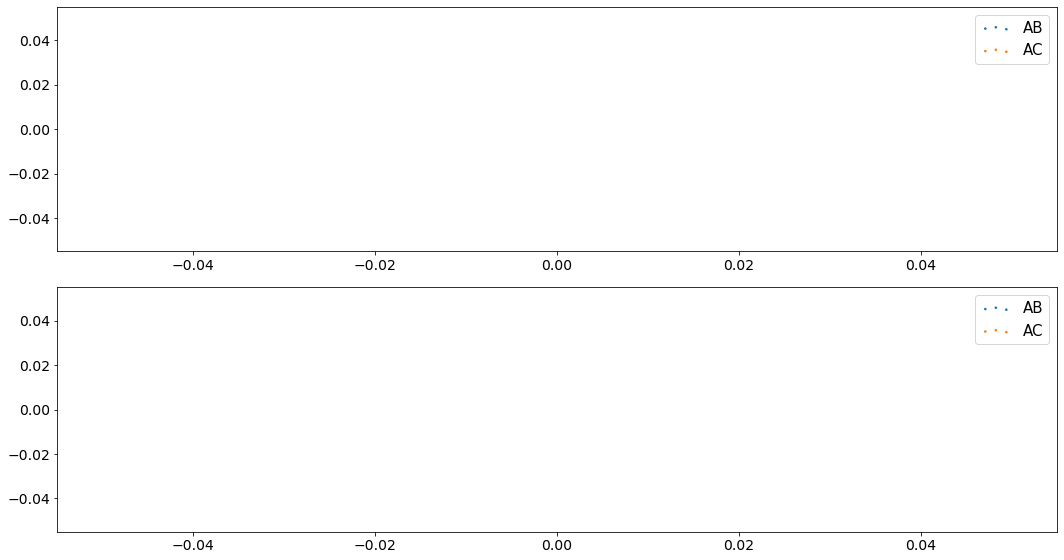


.
.
 7BC.csv
  Fault type Percentage
0      FAULT     100.0%


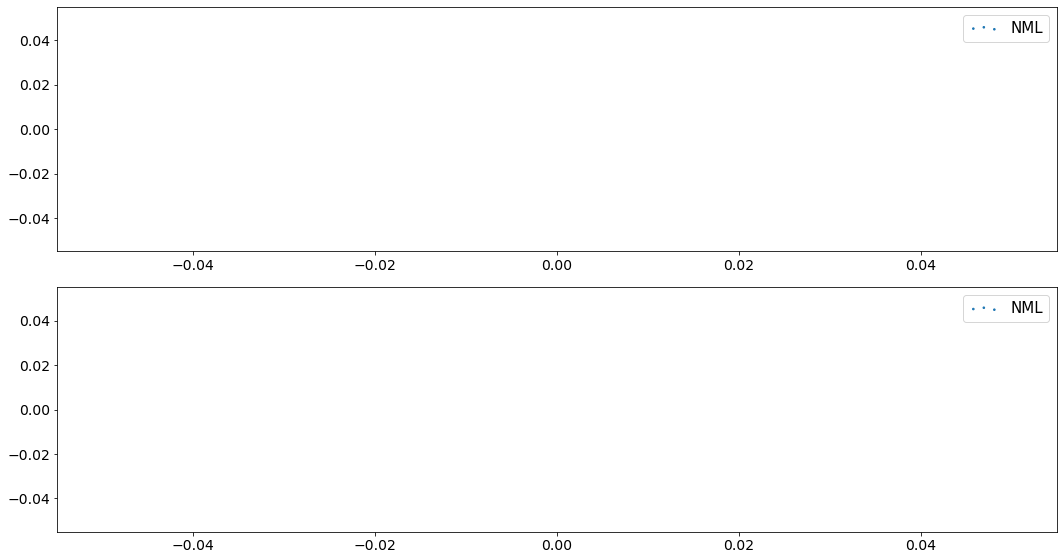

  Fault type Percentage
0        ABC     100.0%


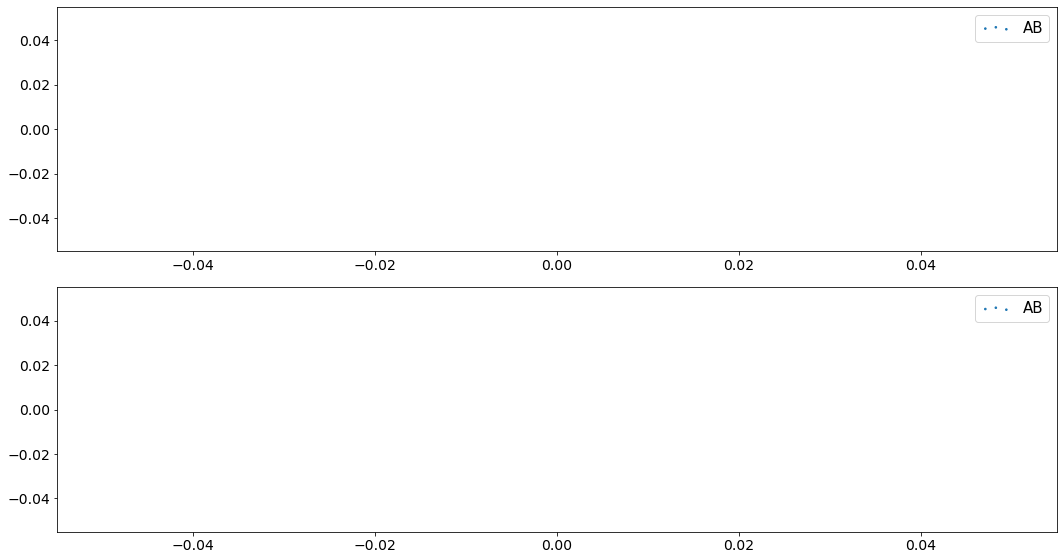


.
.
 7CG.csv
  Fault type Percentage
0      FAULT     100.0%


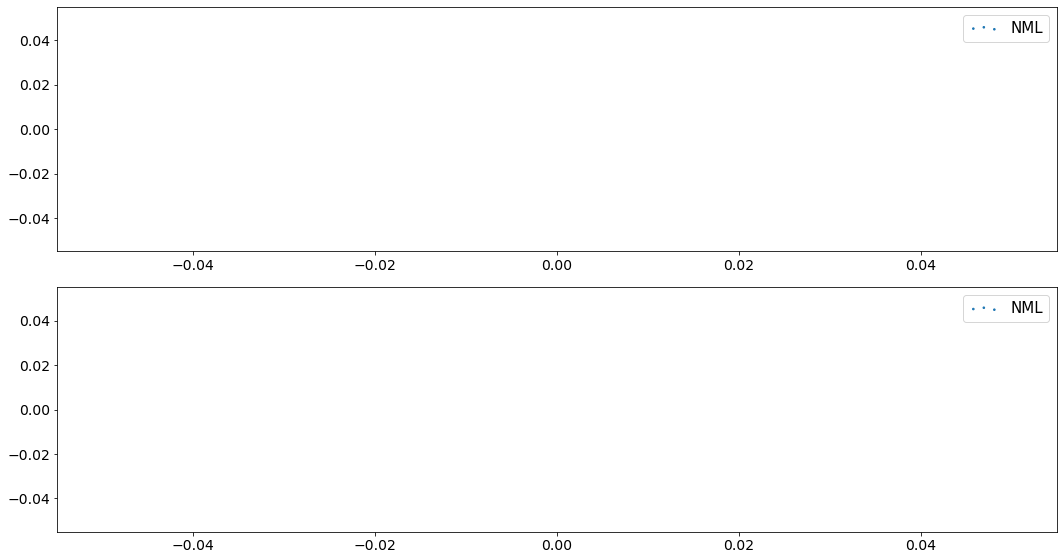

  Fault type Percentage
0        ABC     99.81%
1        ACG      0.19%


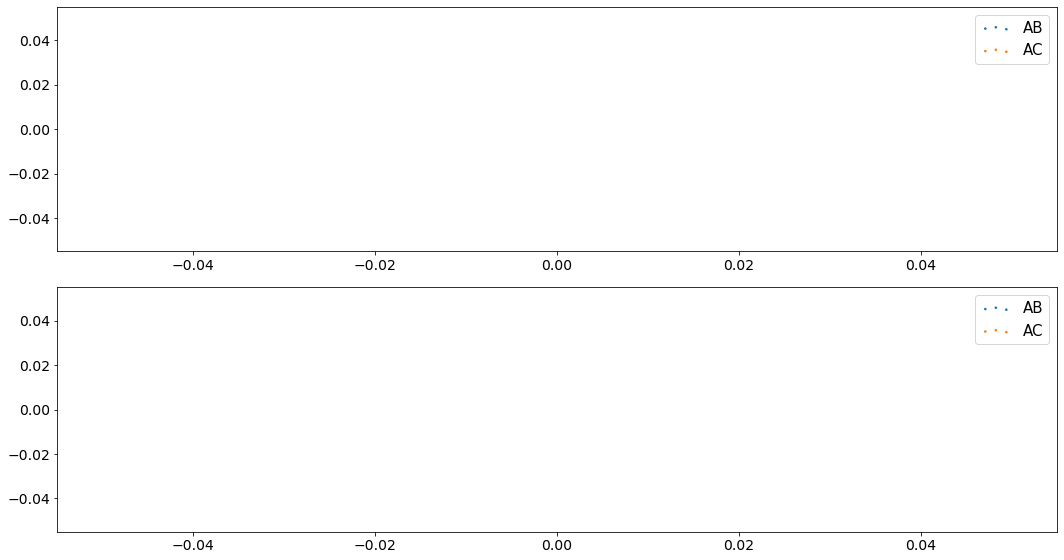


.
.
 10ACG.csv
  Fault type Percentage
0      FAULT     100.0%


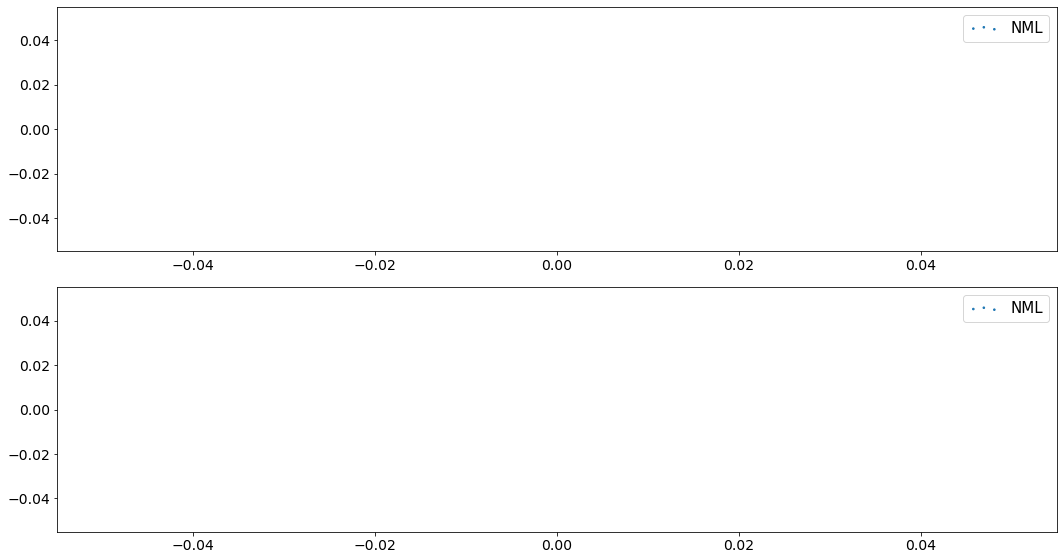

  Fault type Percentage
0        ABC     99.94%
1        ACG      0.06%


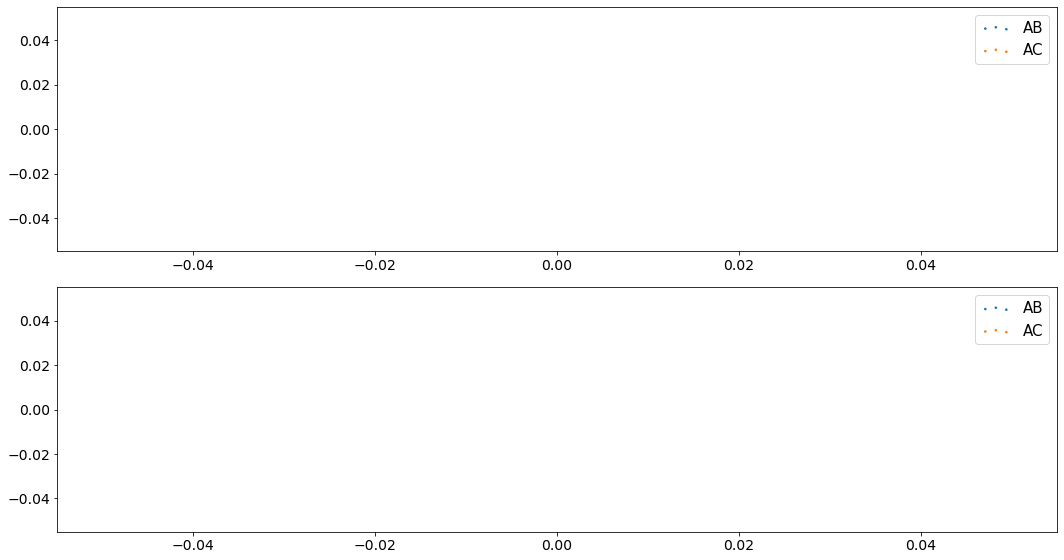


.
.
 3BG.csv
  Fault type Percentage
0      FAULT     100.0%


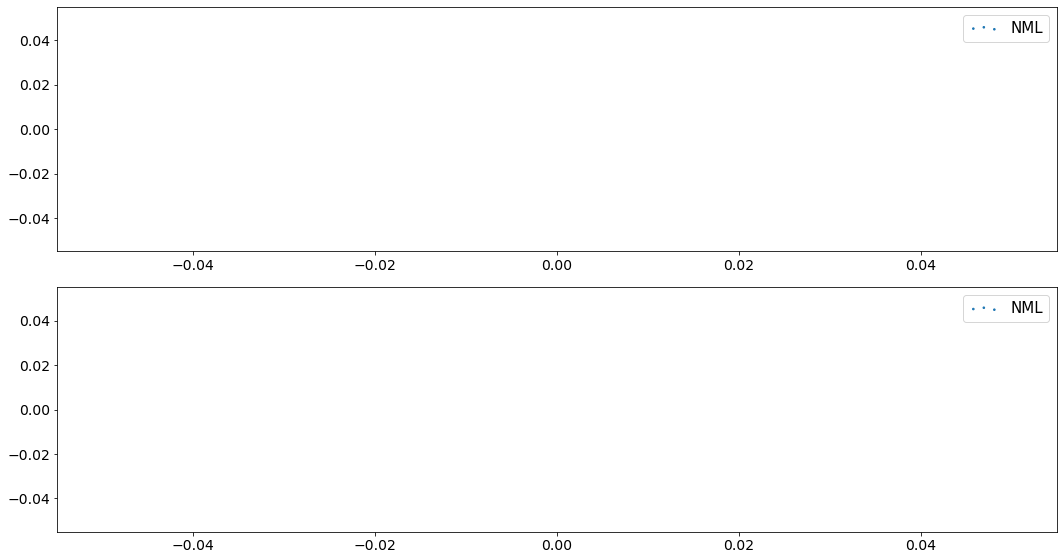

  Fault type Percentage
0        ABC     100.0%


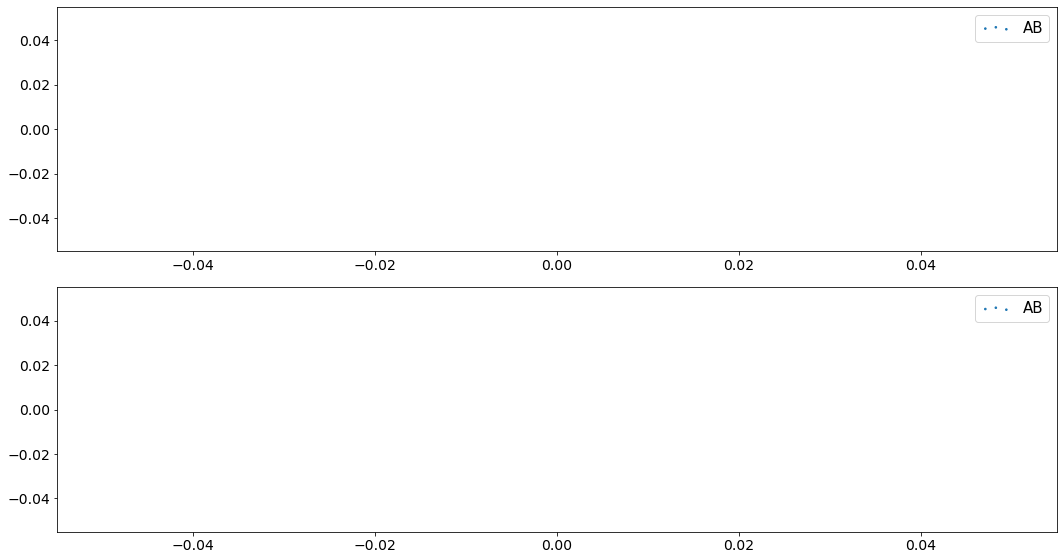


.
.
 10ABC.csv
  Fault type Percentage
0      FAULT     100.0%


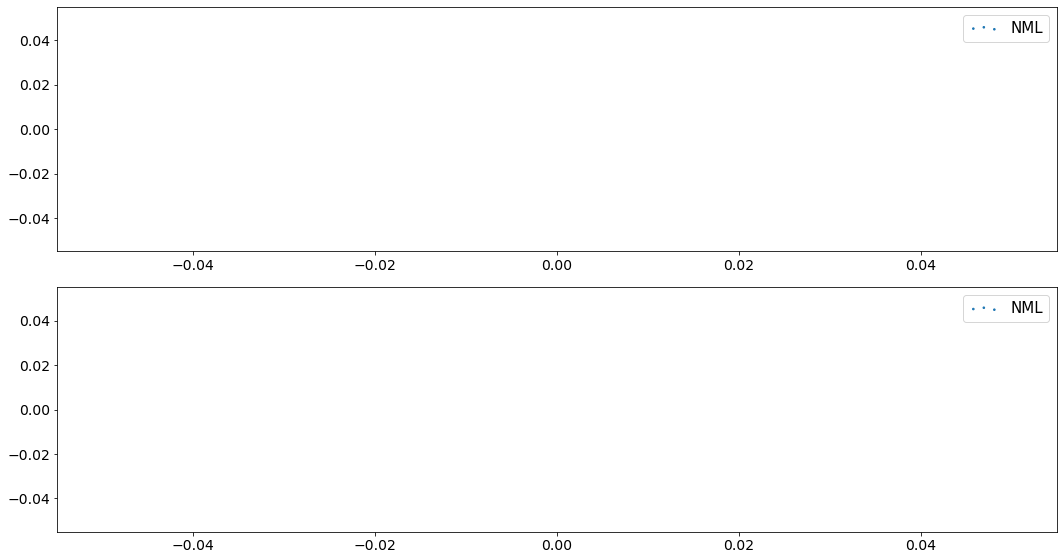

  Fault type Percentage
0        ABC     100.0%


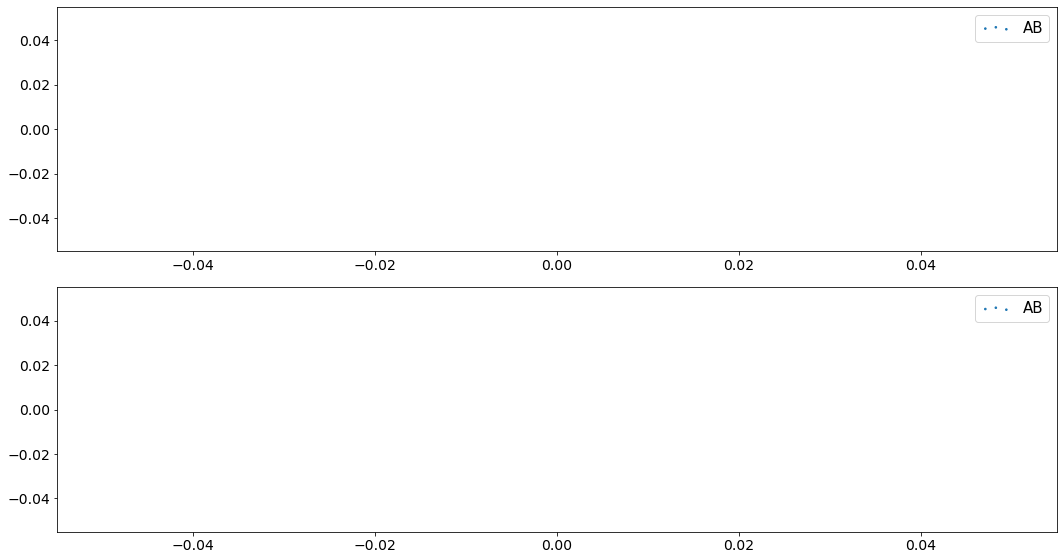


.
.
 3BCG.csv
  Fault type Percentage
0      FAULT     100.0%


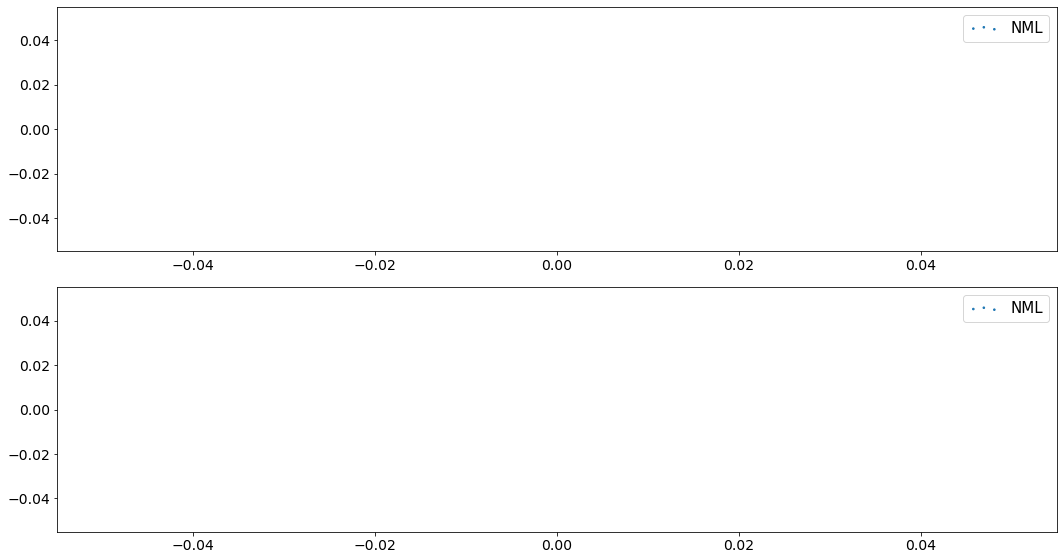

  Fault type Percentage
0        ABC     100.0%


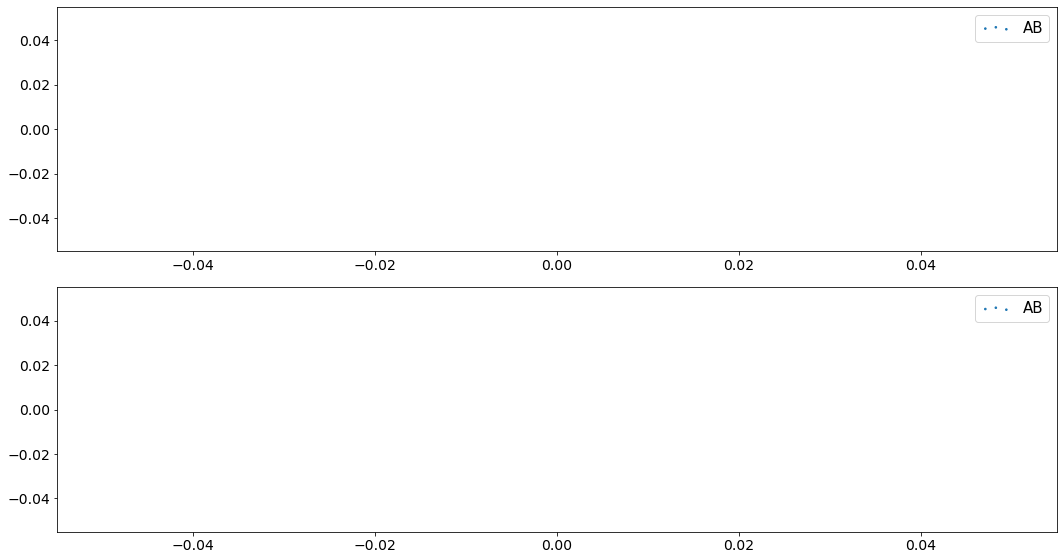


.
.
 4BG.csv
  Fault type Percentage
0      FAULT     100.0%


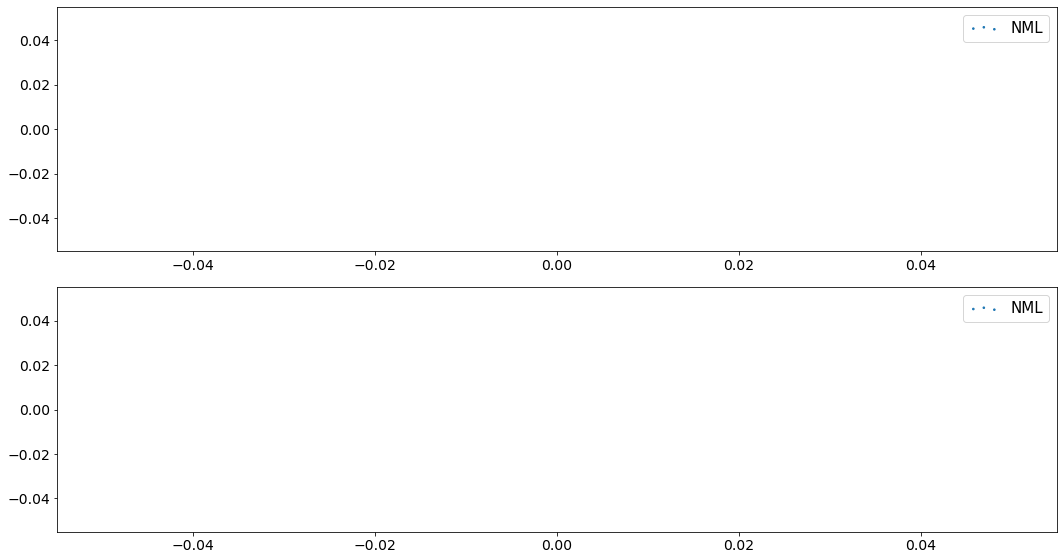

  Fault type Percentage
0        ABC     100.0%
1        BCG      0.01%


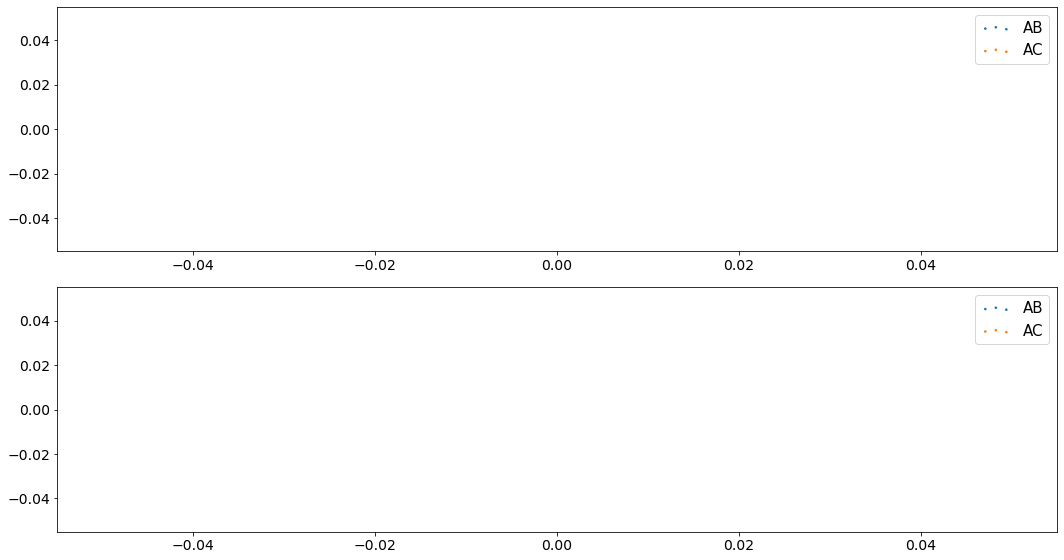


.
.
 1ABC.csv
  Fault type Percentage
0      FAULT     100.0%


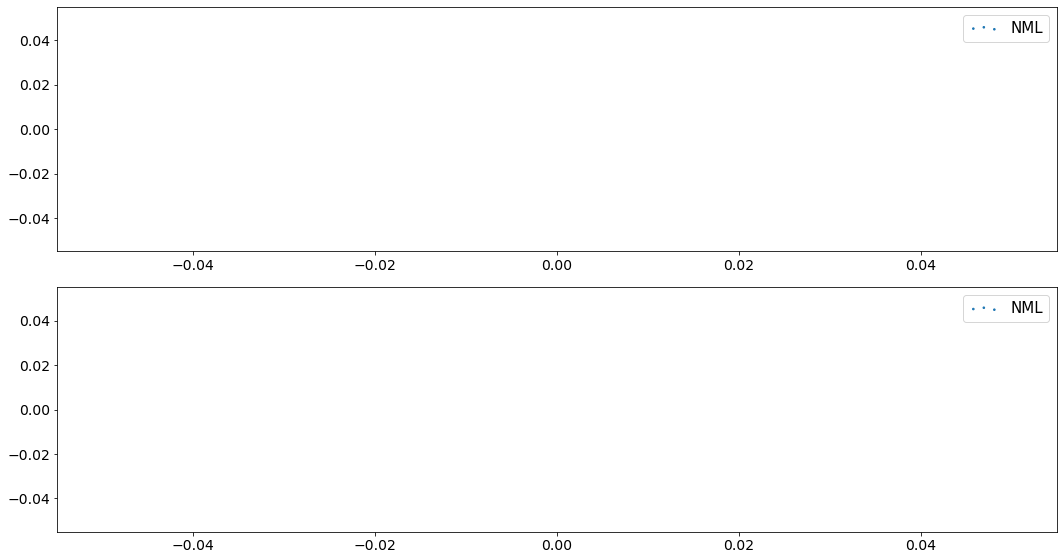

  Fault type Percentage
0        ABC     100.0%


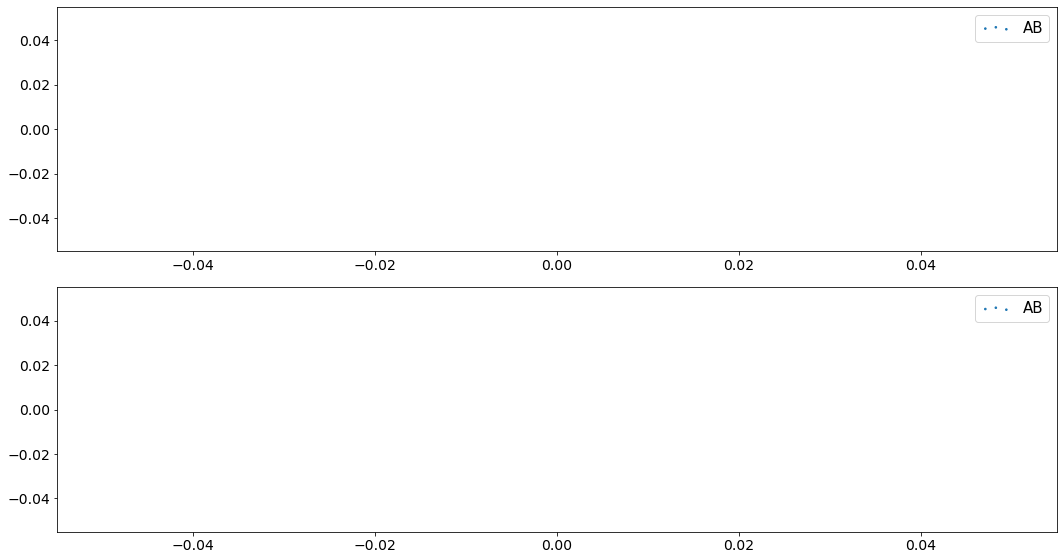


.
.
 1ACG.csv
  Fault type Percentage
0      FAULT     100.0%


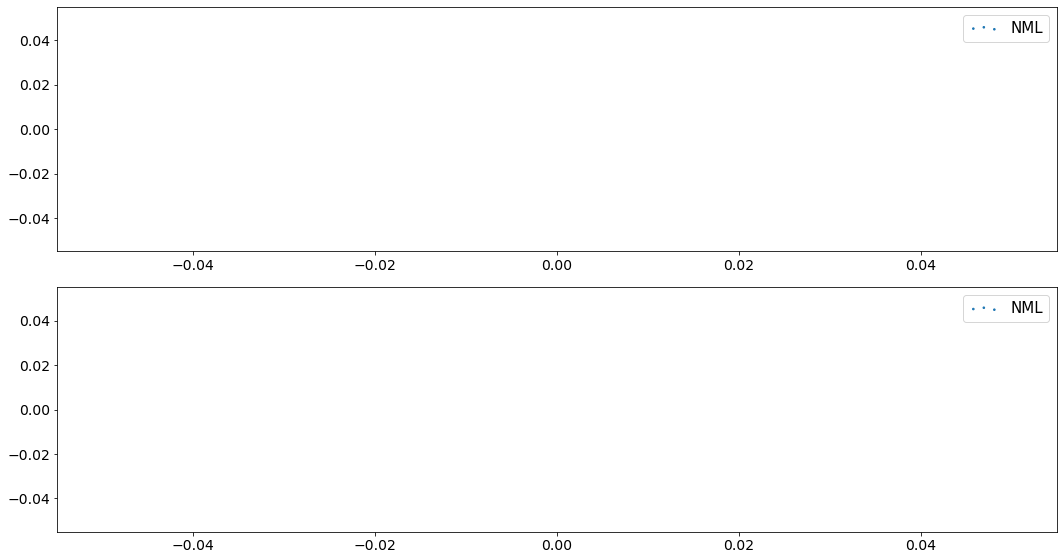

  Fault type Percentage
0        ABC      99.9%
1        ACG      0.07%
2        ABG      0.03%


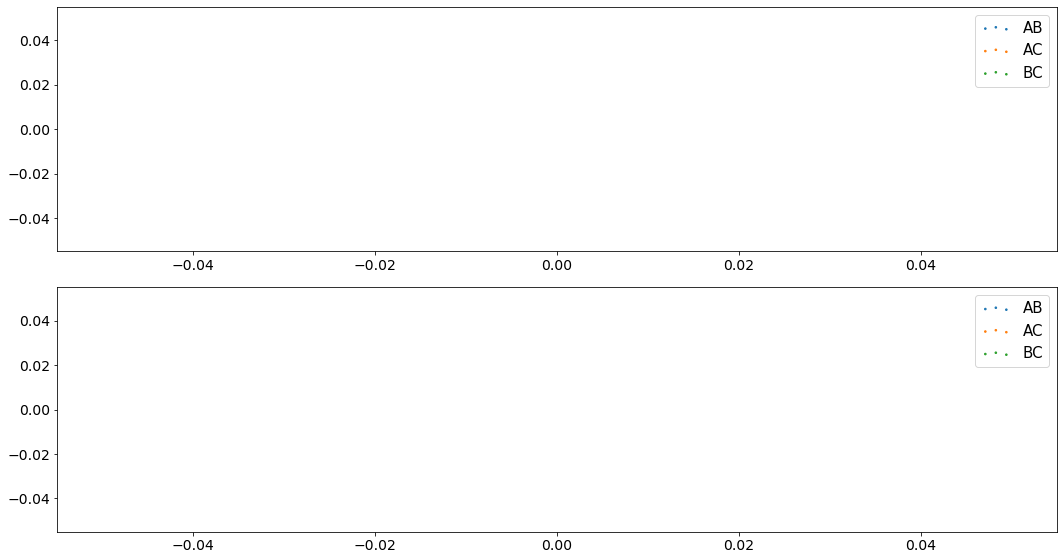


.
.
 8AG.csv
  Fault type Percentage
0      FAULT     100.0%


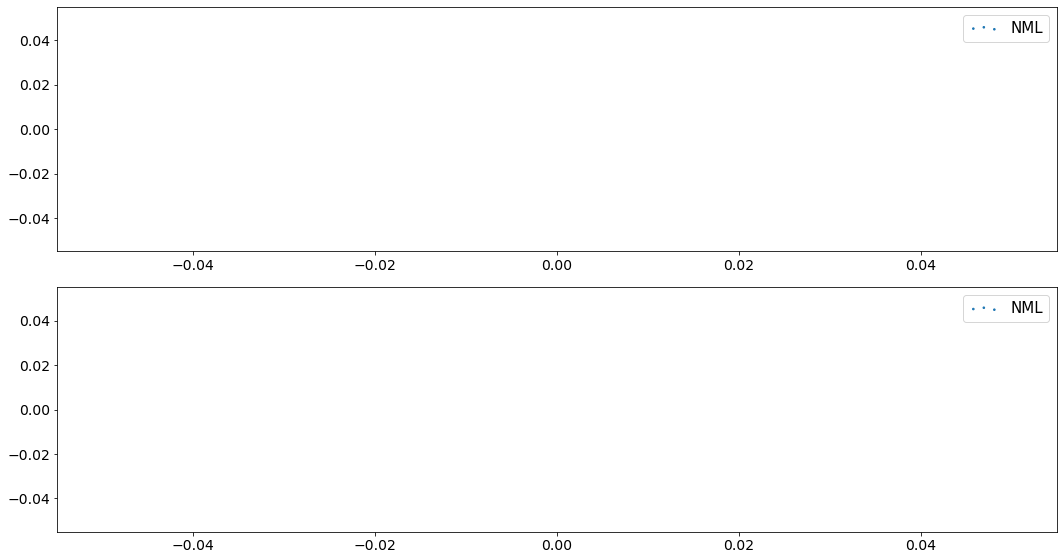

  Fault type Percentage
0        ABC     62.23%
1        ACG      32.3%
2        ABG      5.47%


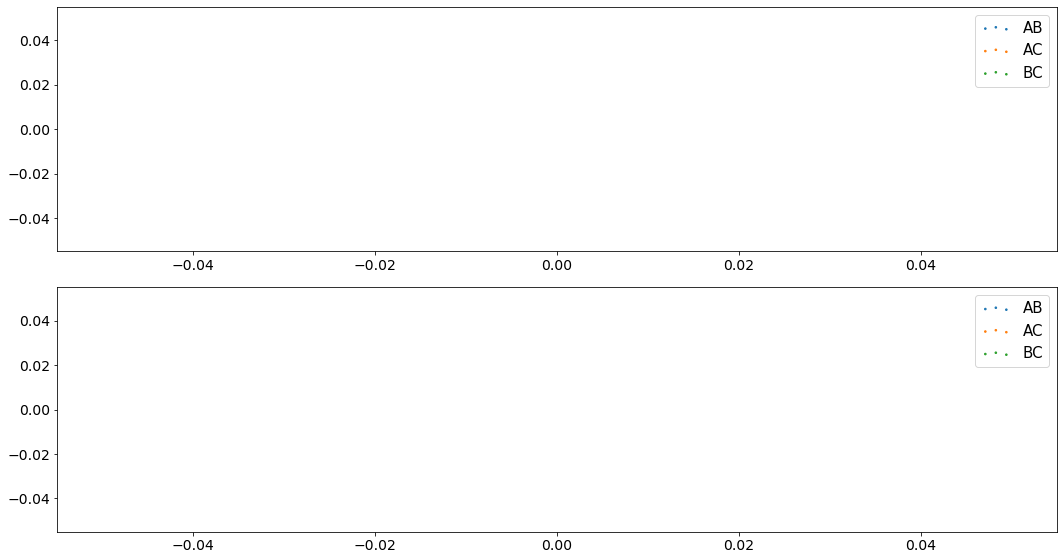


.
.
 3ABG.csv
  Fault type Percentage
0      FAULT     100.0%


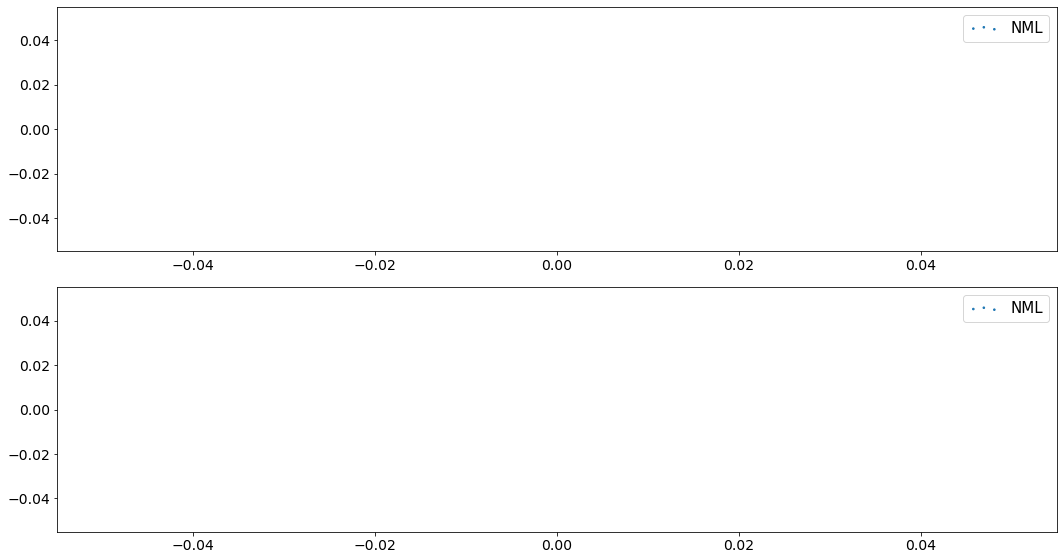

  Fault type Percentage
0        ABC     99.99%
1        ACG      0.01%
2        ABG      0.01%


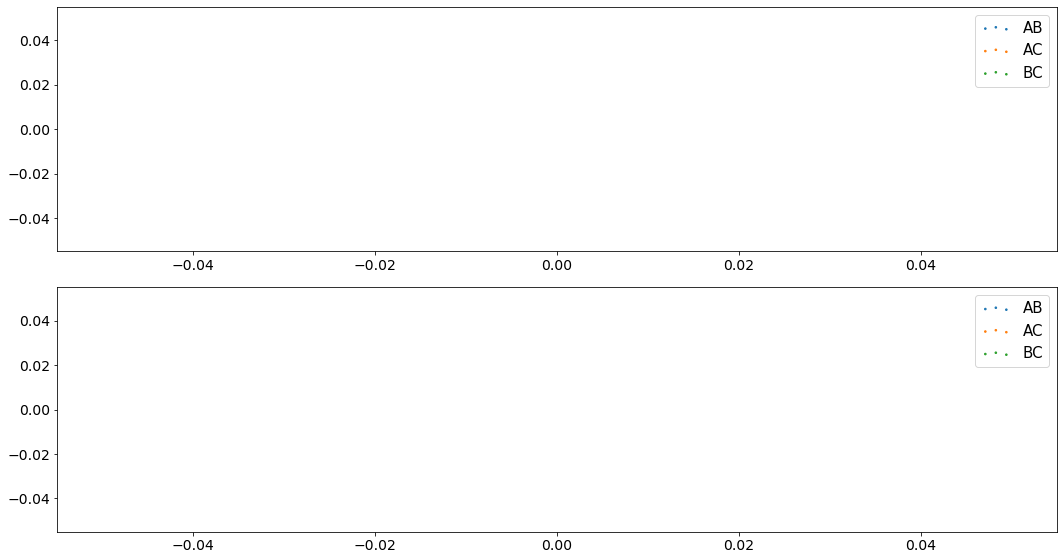


.
.
 10AC.csv
  Fault type Percentage
0      FAULT     100.0%


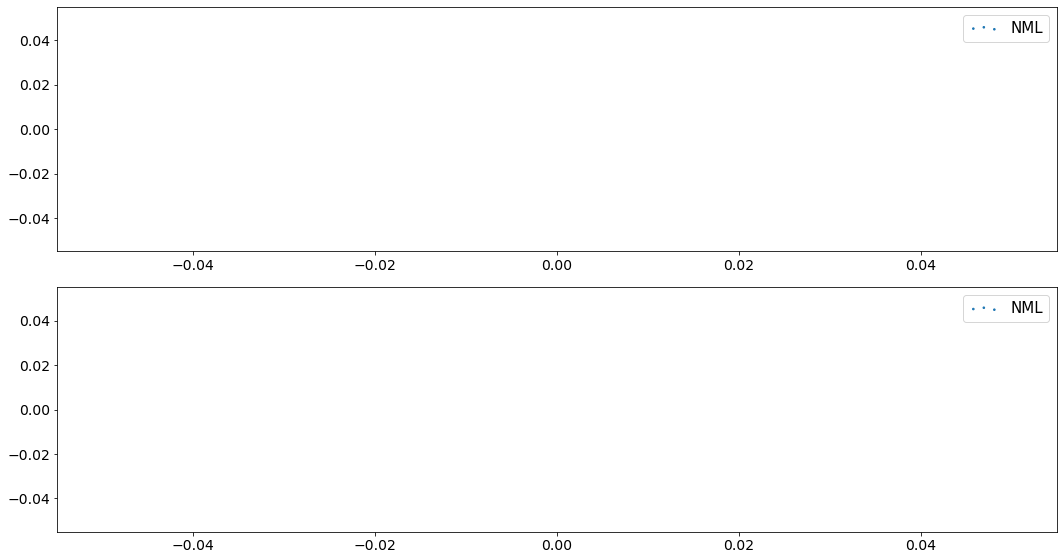

  Fault type Percentage
0        ABC     97.53%
1        ACG      2.46%


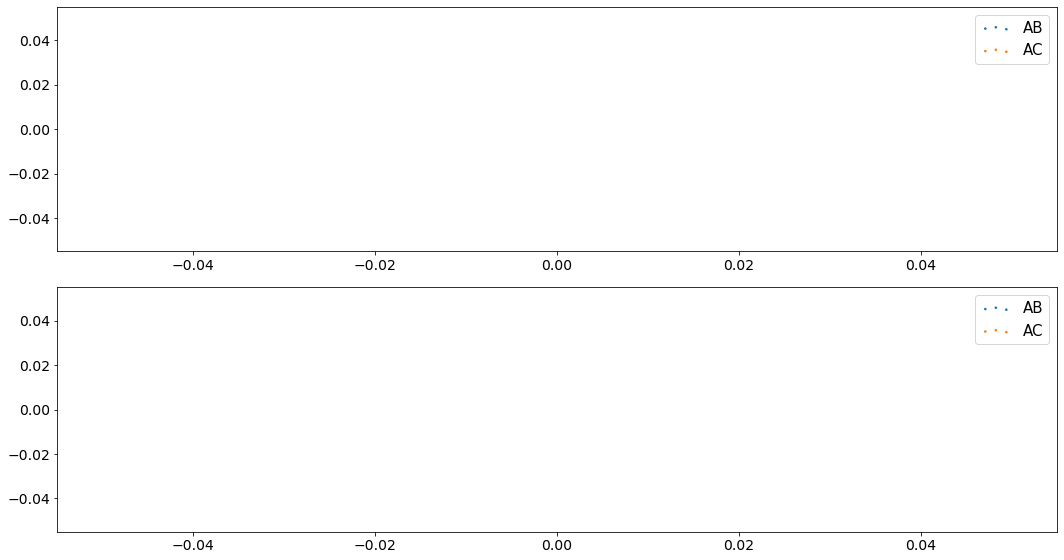


.
.
 7BCG.csv
  Fault type Percentage
0      FAULT     100.0%


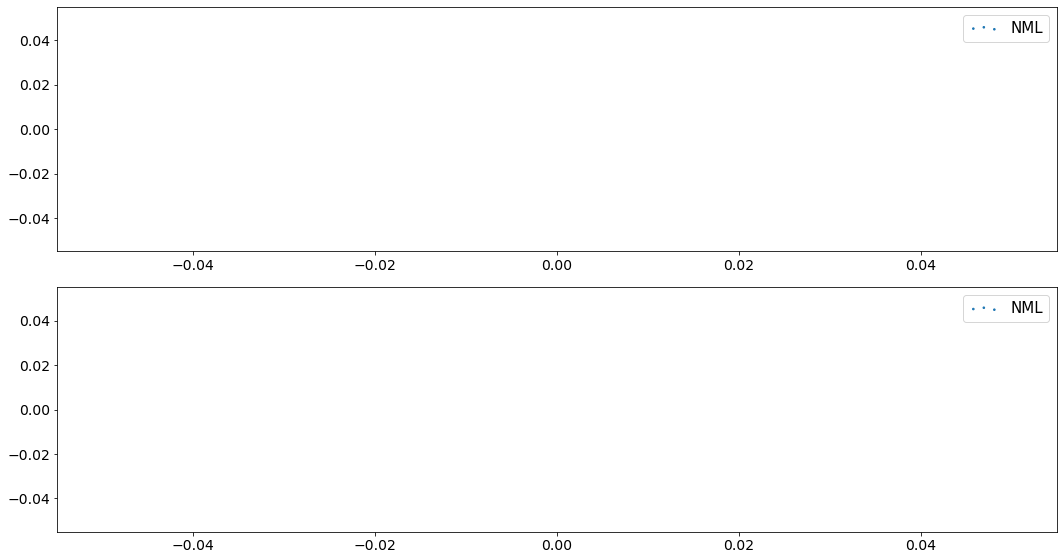

  Fault type Percentage
0        ABC     99.95%
1        BCG      0.05%


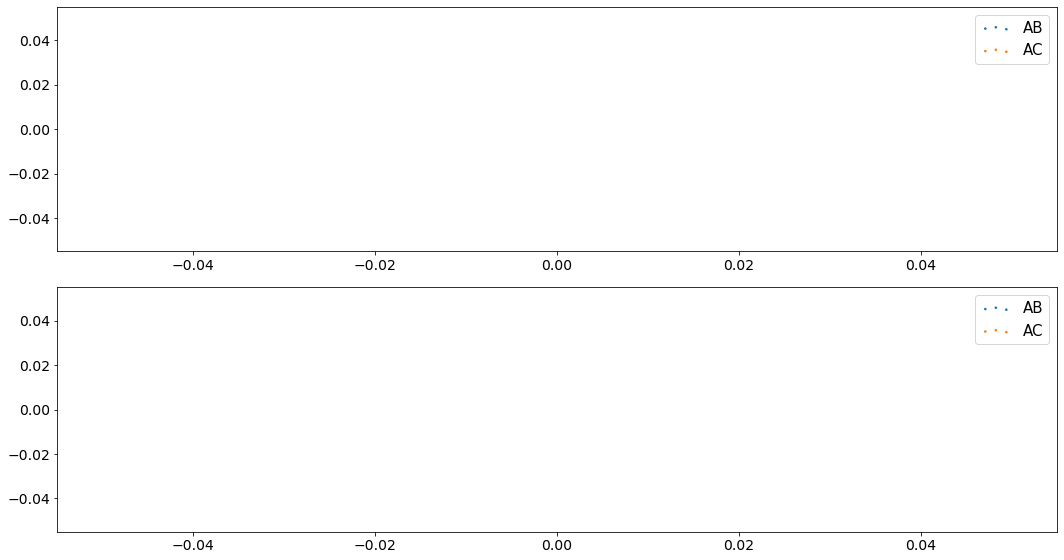


.
.
 6ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


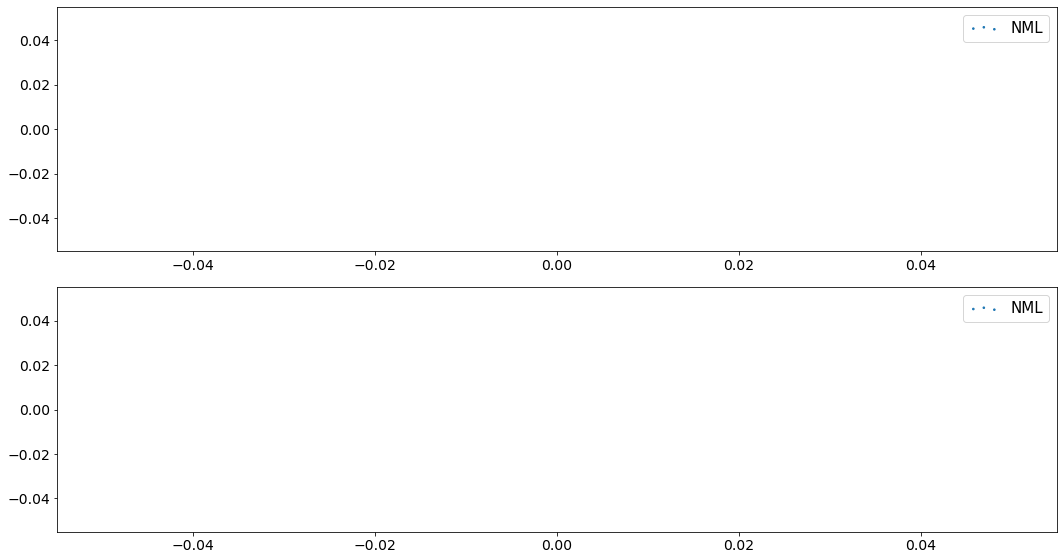

  Fault type Percentage
0        ABC     99.96%
1        ACG      0.03%
2        ABG      0.01%


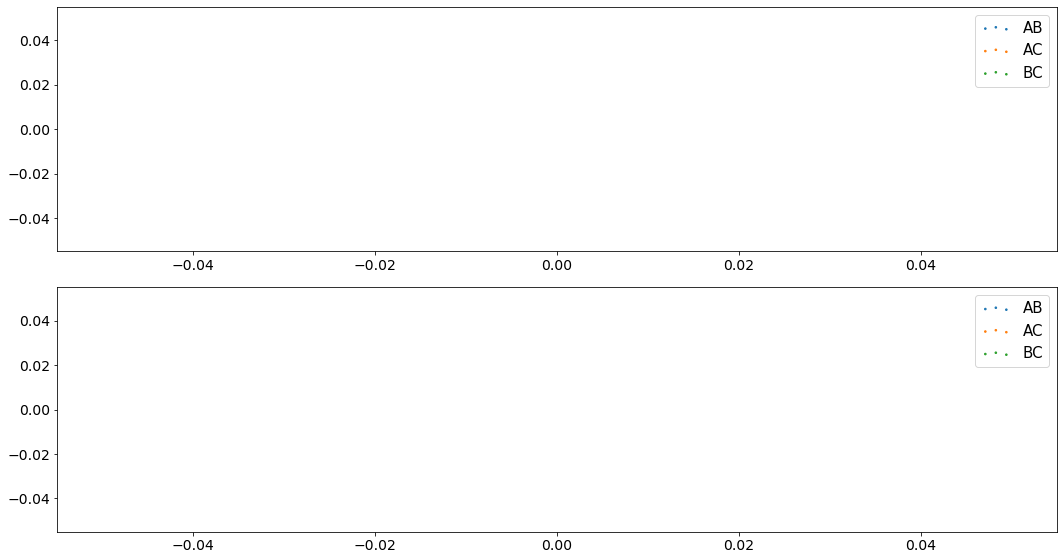


.
.
 6BG.csv
  Fault type Percentage
0      FAULT     100.0%


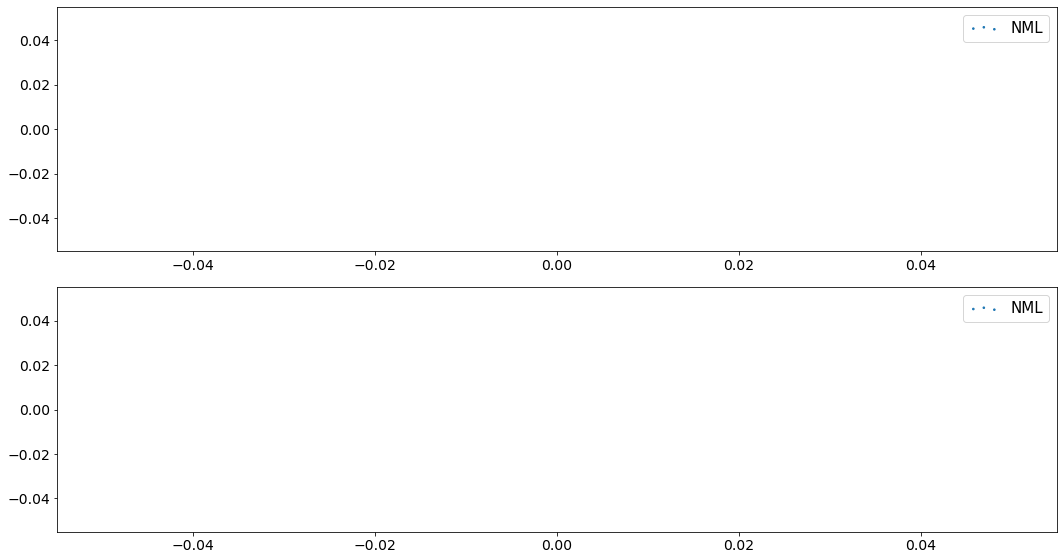

  Fault type Percentage
0        ABC     99.99%
1        BCG      0.01%


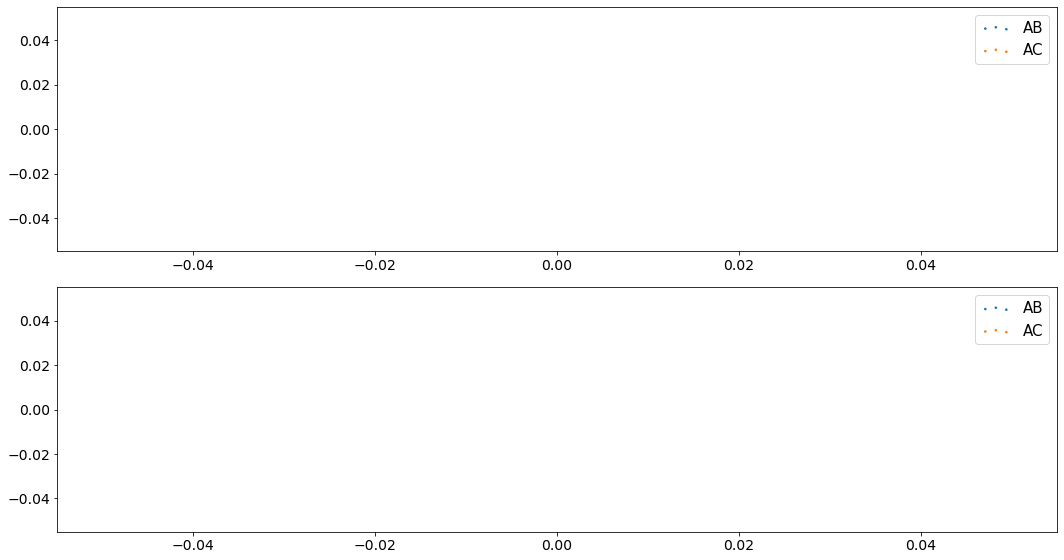


.
.
 10AB.csv
  Fault type Percentage
0      FAULT     100.0%


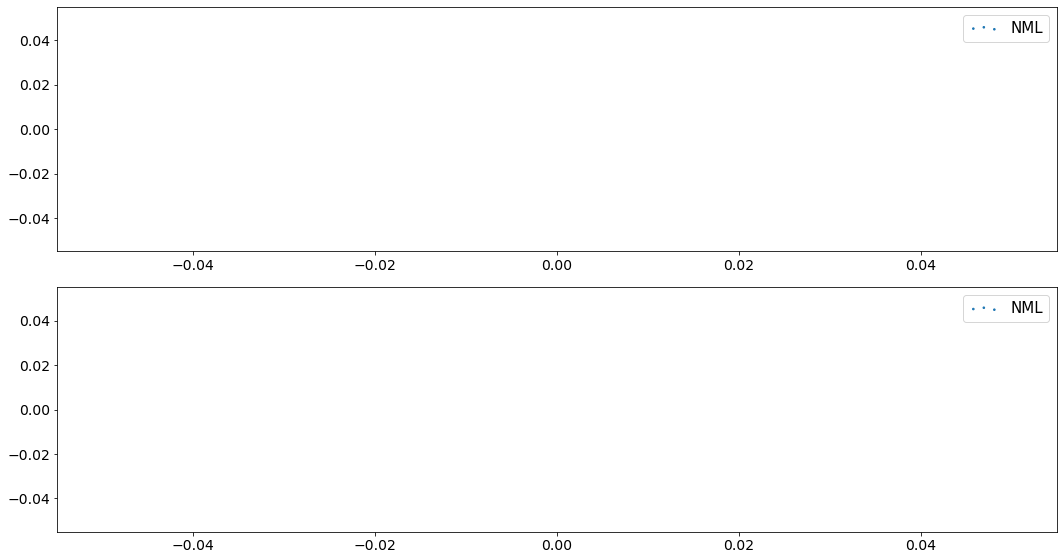

  Fault type Percentage
0        ABC     97.75%
1        ABG      2.25%


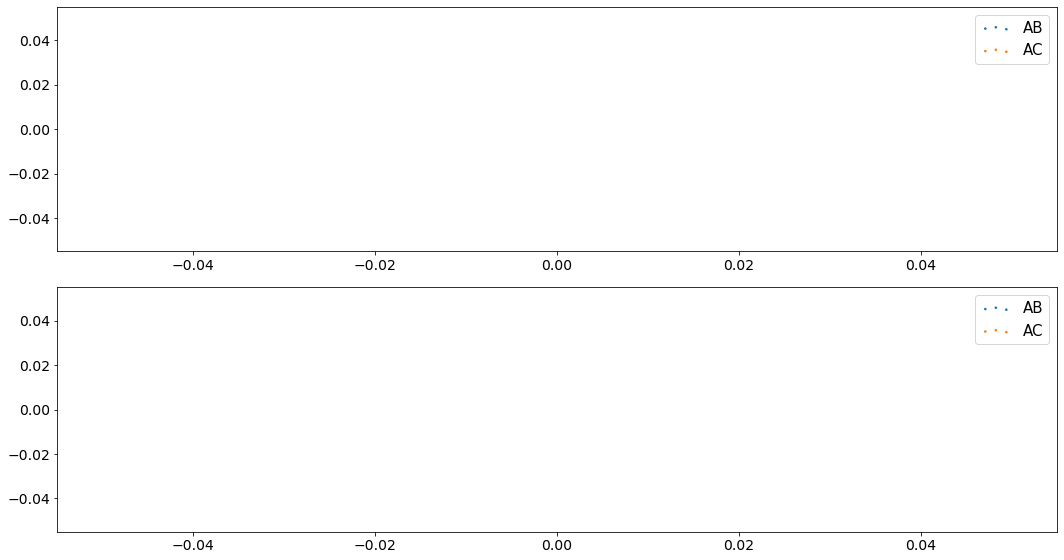


.
.
 2BC.csv
  Fault type Percentage
0      FAULT     100.0%


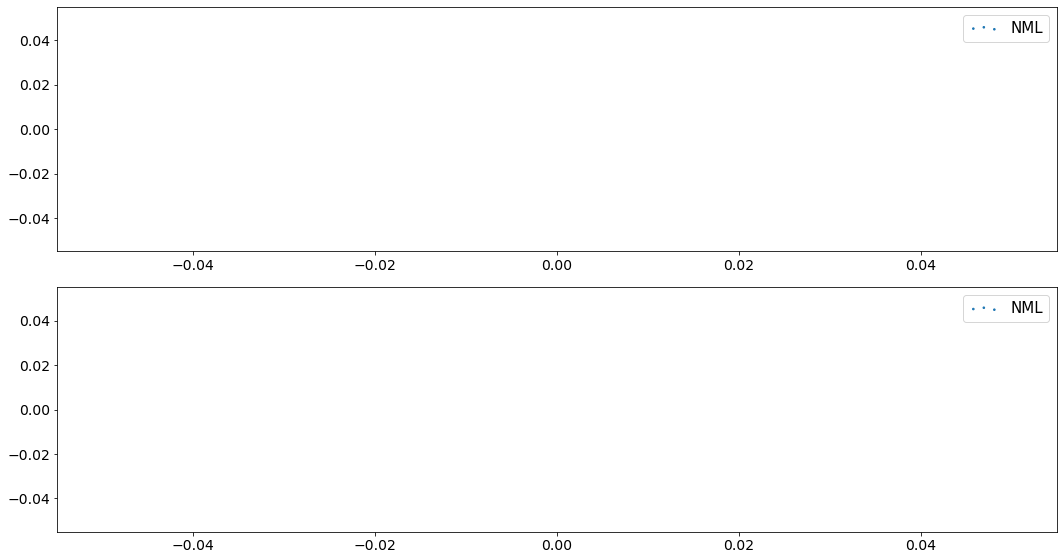

  Fault type Percentage
0        ABC     100.0%


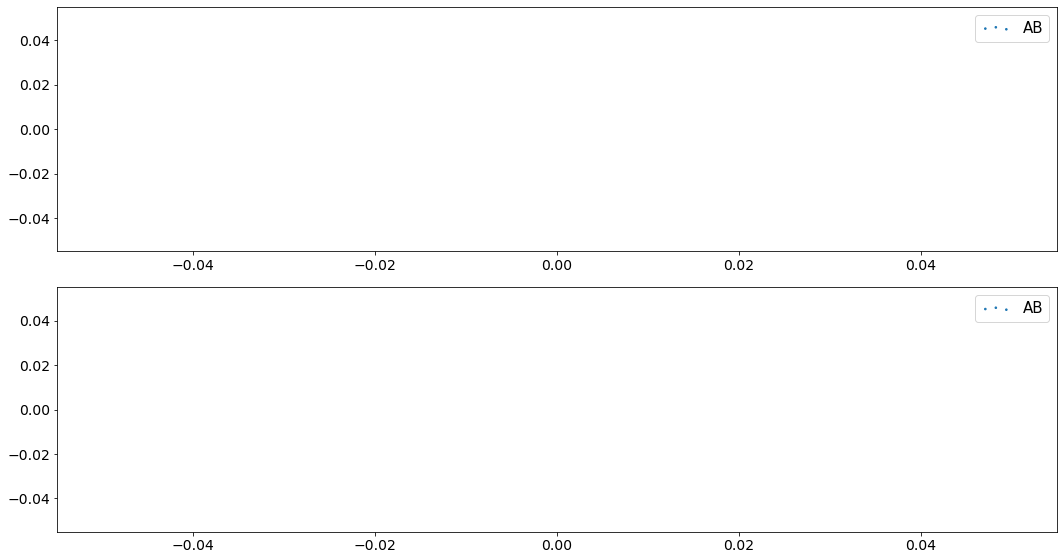


.
.
 2CG.csv
  Fault type Percentage
0      FAULT     100.0%


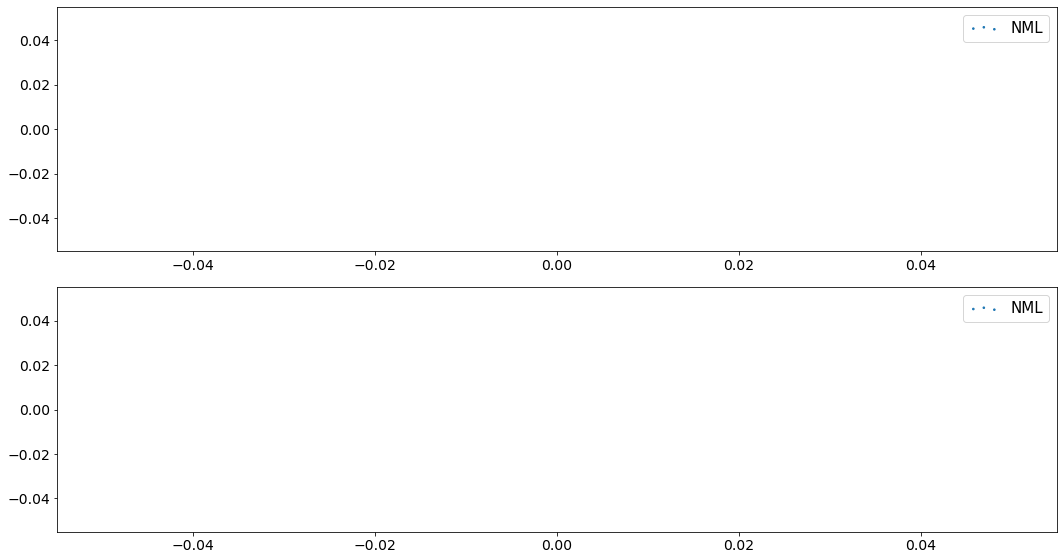

  Fault type Percentage
0        ABC     69.55%
1        ACG     30.45%


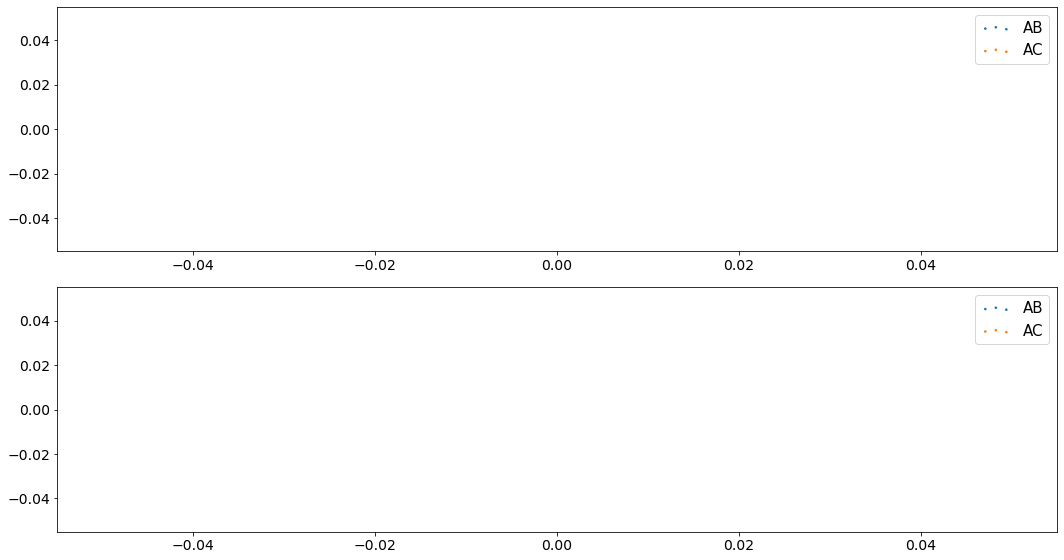


.
.
 5BCG.csv
  Fault type Percentage
0      FAULT     100.0%


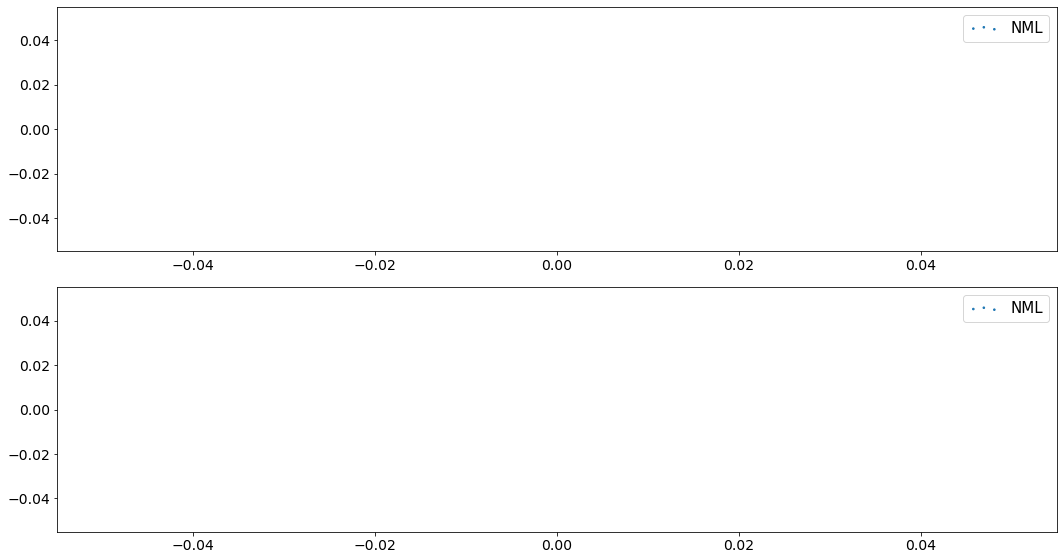

  Fault type Percentage
0        ABC     99.94%
1        ACG      0.04%
2        BCG      0.03%


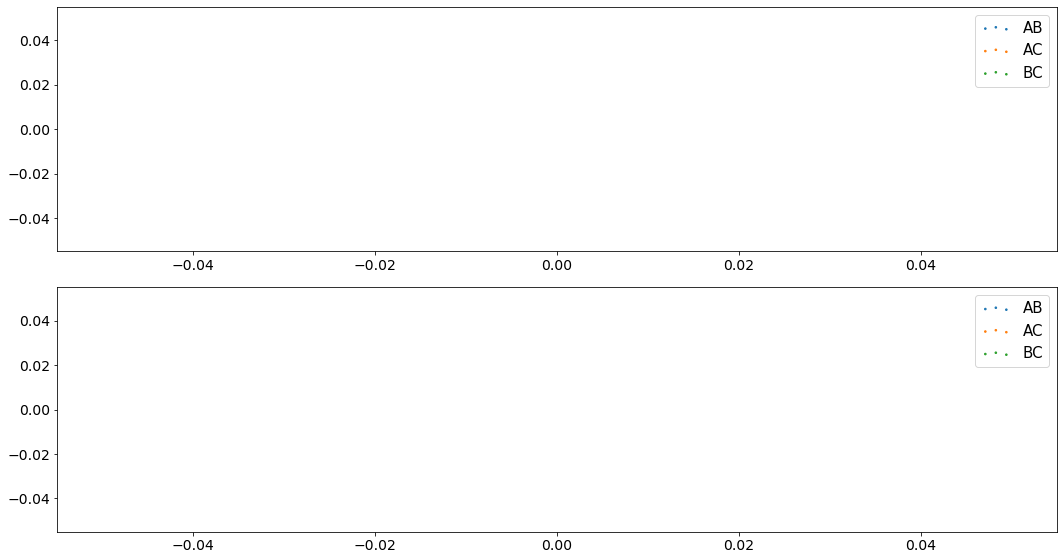


.
.
 2BG.csv
  Fault type Percentage
0      FAULT     100.0%


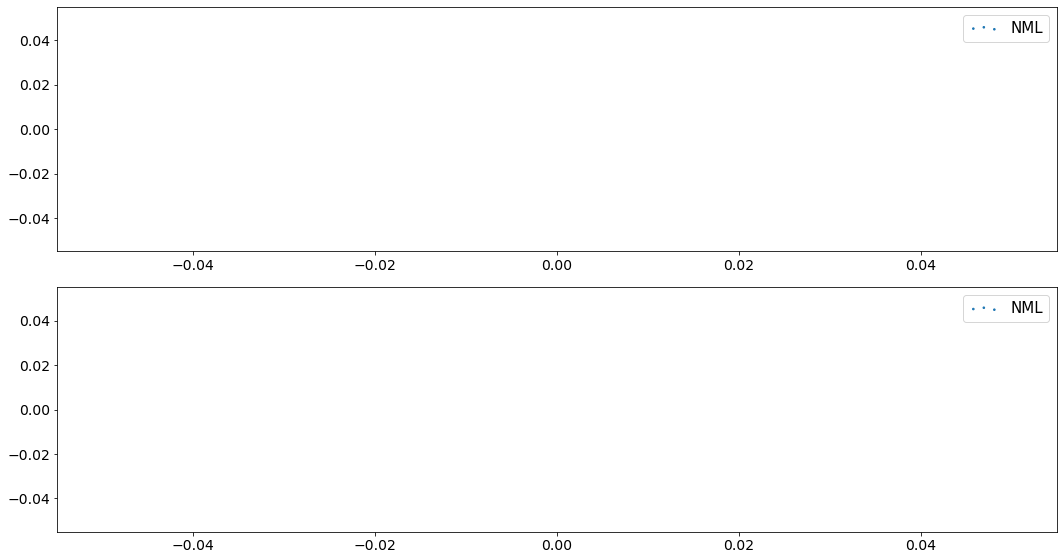

  Fault type Percentage
0        ABC     99.99%
1        BCG      0.01%


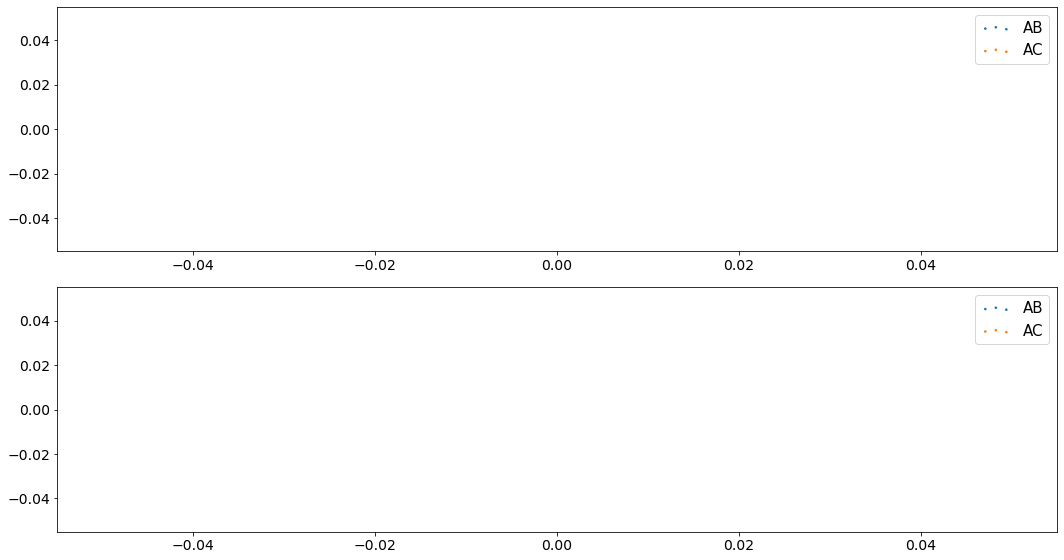


.
.
 6BC.csv
  Fault type Percentage
0      FAULT     100.0%


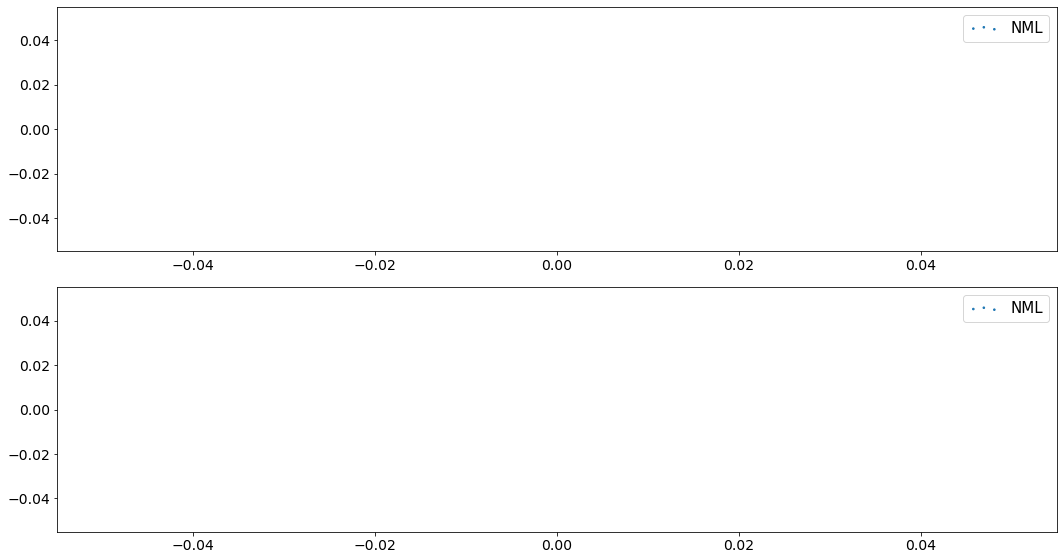

  Fault type Percentage
0        ABC     99.98%
1        BCG      0.01%


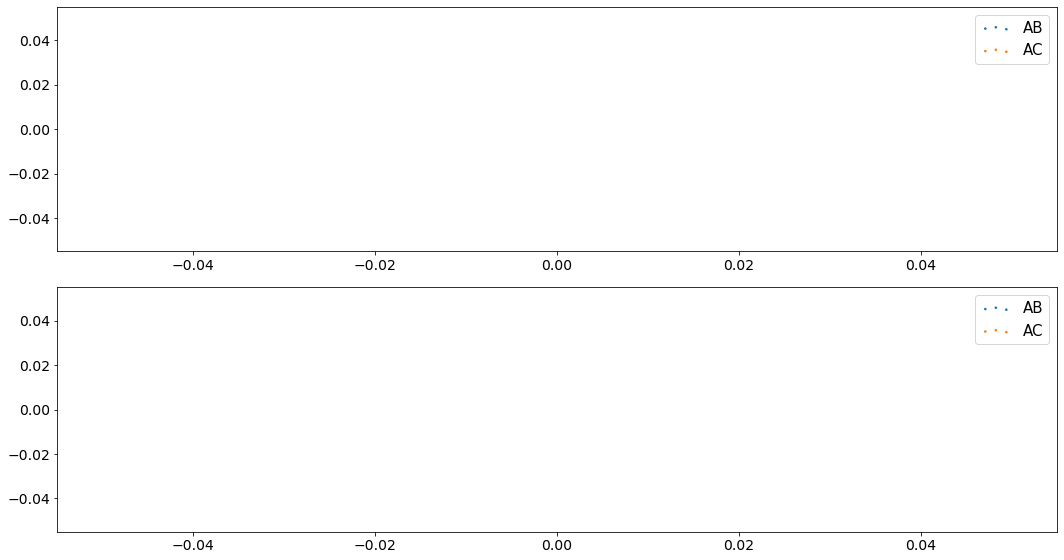


.
.
 6CG.csv
  Fault type Percentage
0      FAULT     100.0%


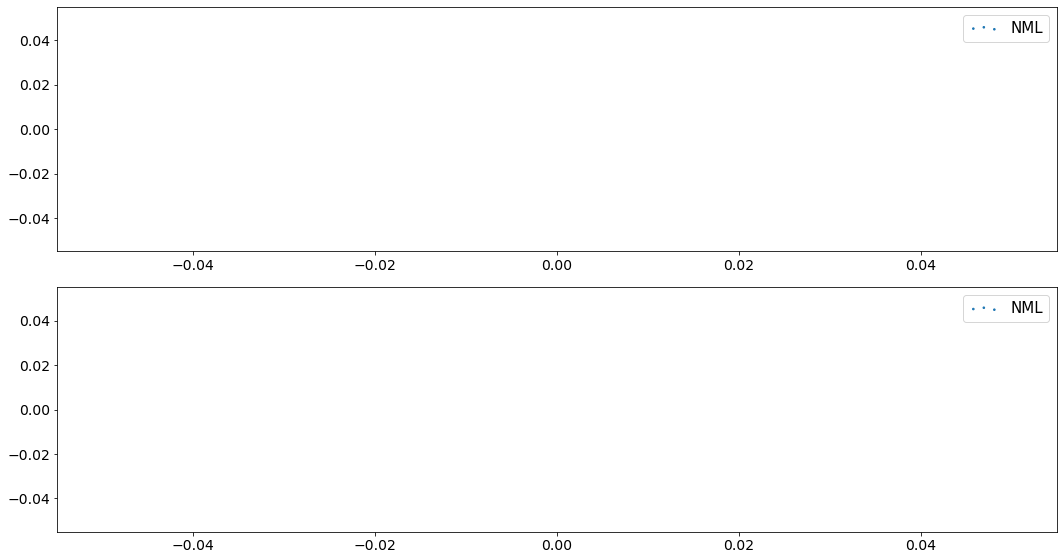

  Fault type Percentage
0        ABC      81.0%
1        ACG      19.0%


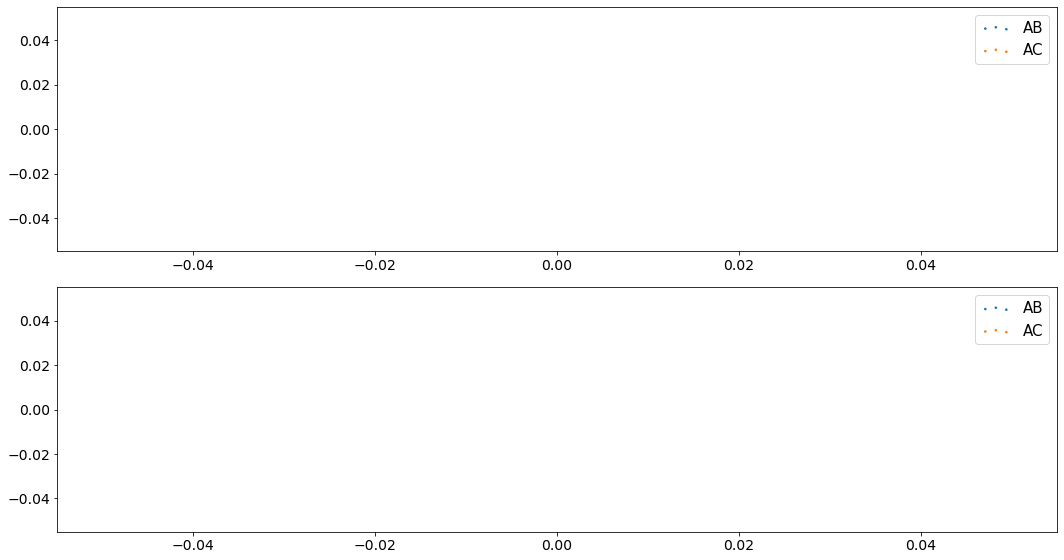


.
.
 7ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


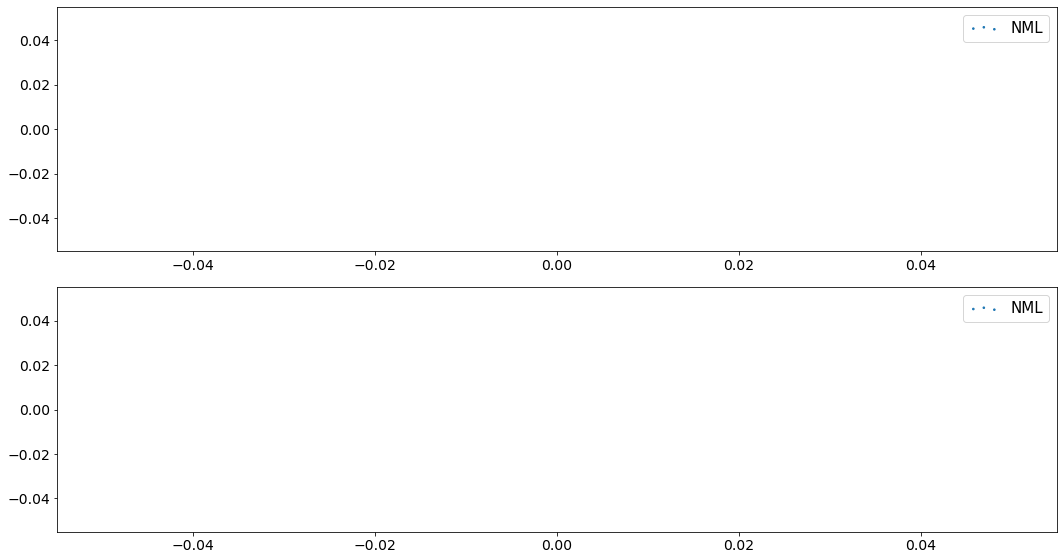

  Fault type Percentage
0        ABC     100.0%


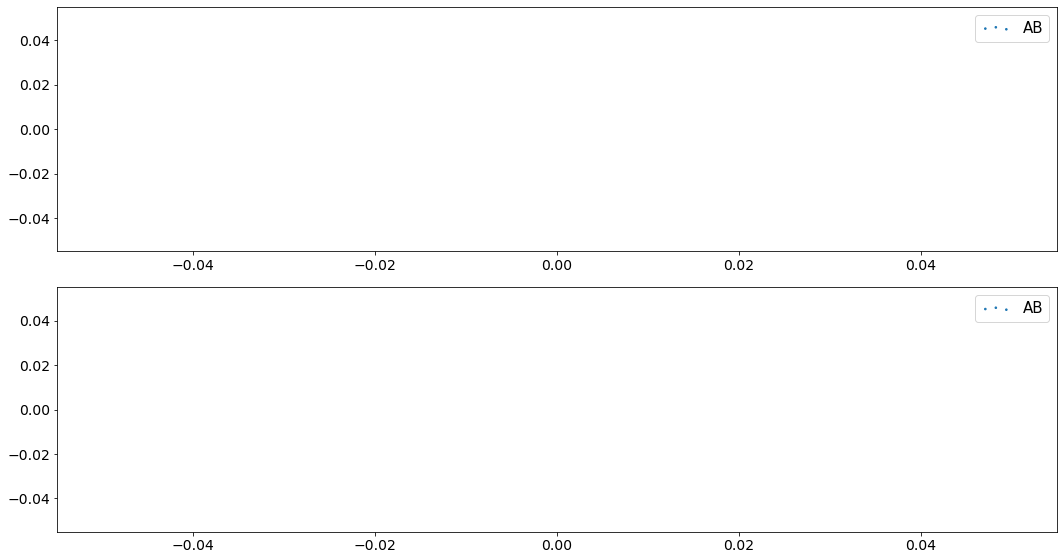


.
.
 9BCG.csv
  Fault type Percentage
0      FAULT     100.0%


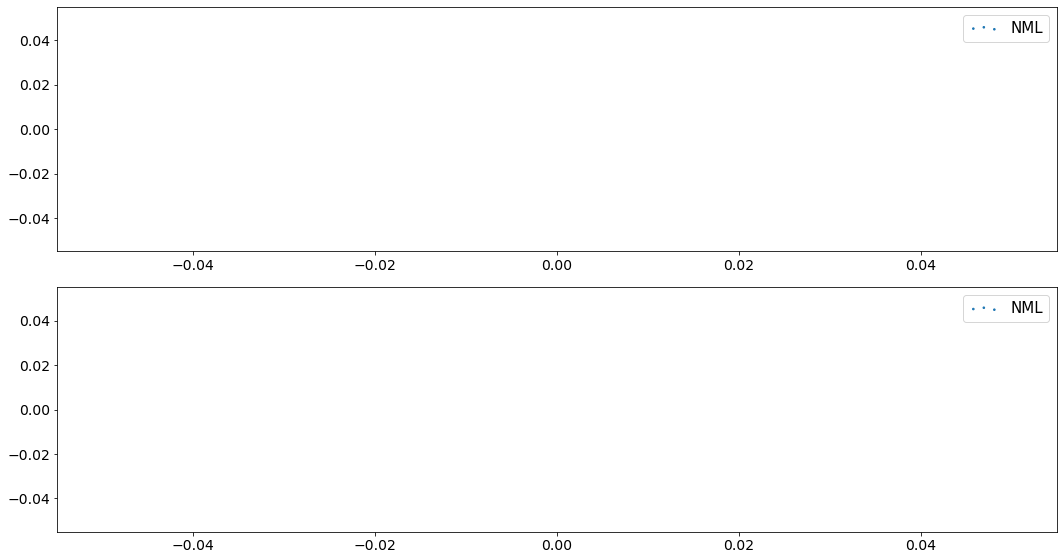

  Fault type Percentage
0        ABC     99.97%
1        BCG      0.03%


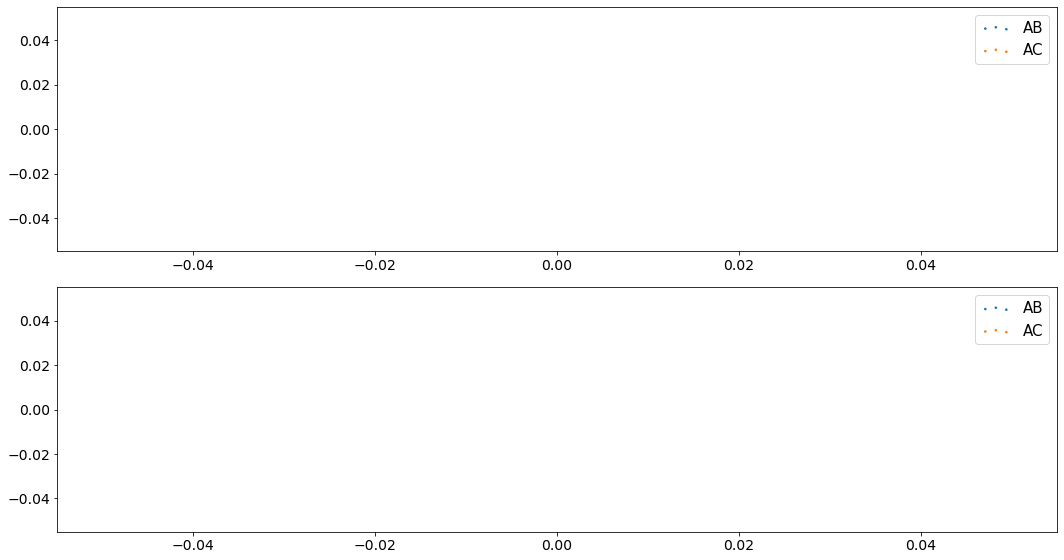


.
.
 10AG.csv
  Fault type Percentage
0      FAULT     100.0%


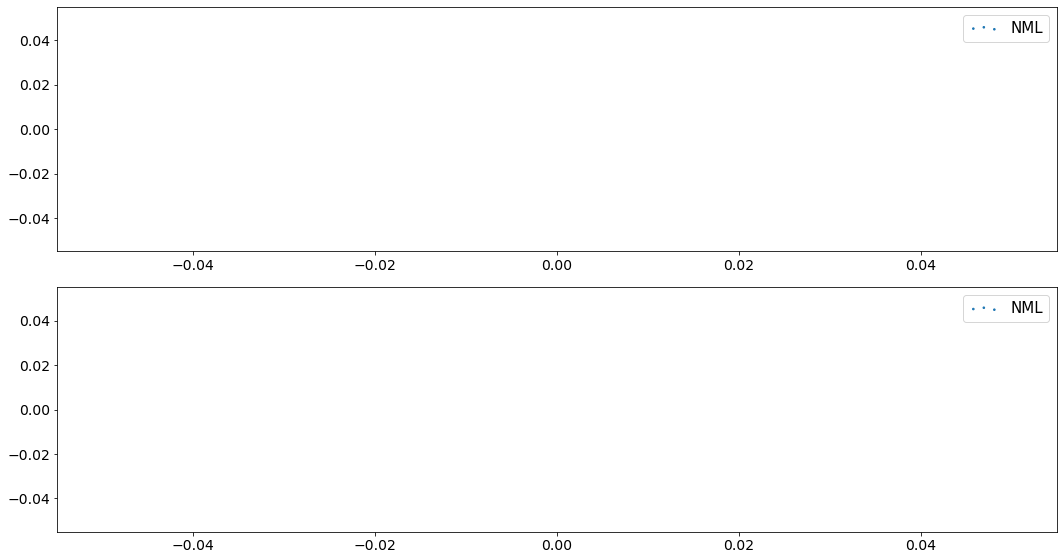

  Fault type Percentage
0        ABC     60.86%
1        ACG     33.69%
2        ABG      5.46%


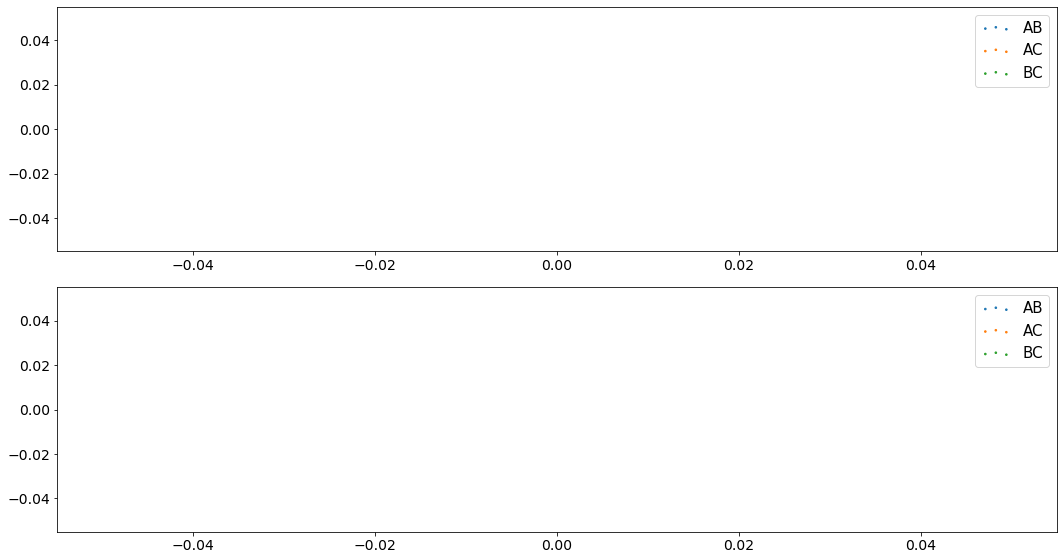


.
.
 3ABC.csv
  Fault type Percentage
0      FAULT     100.0%
1        NML      0.01%


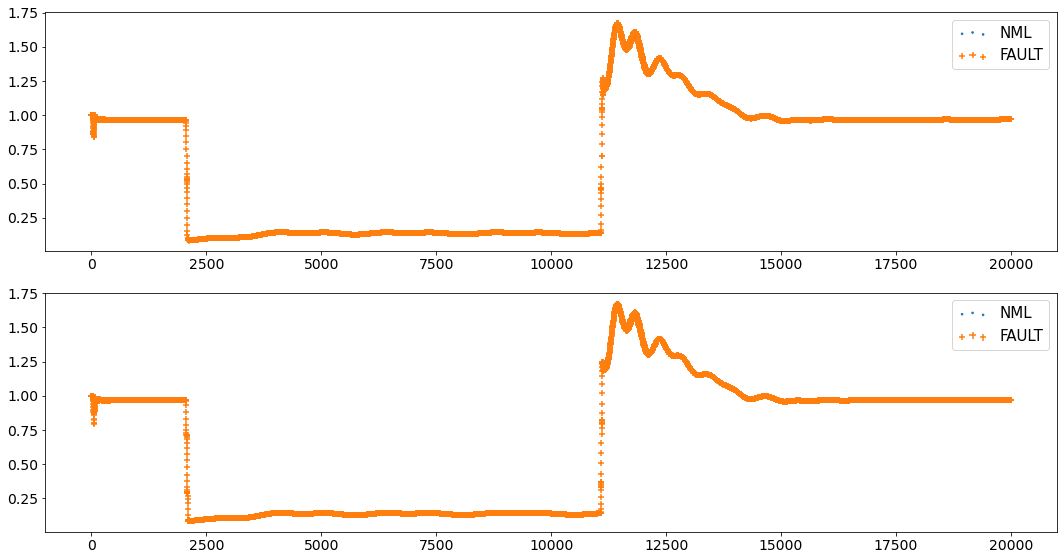

  Fault type Percentage
0        ABC     99.99%
1        ABG      0.01%
2        ACG      0.01%


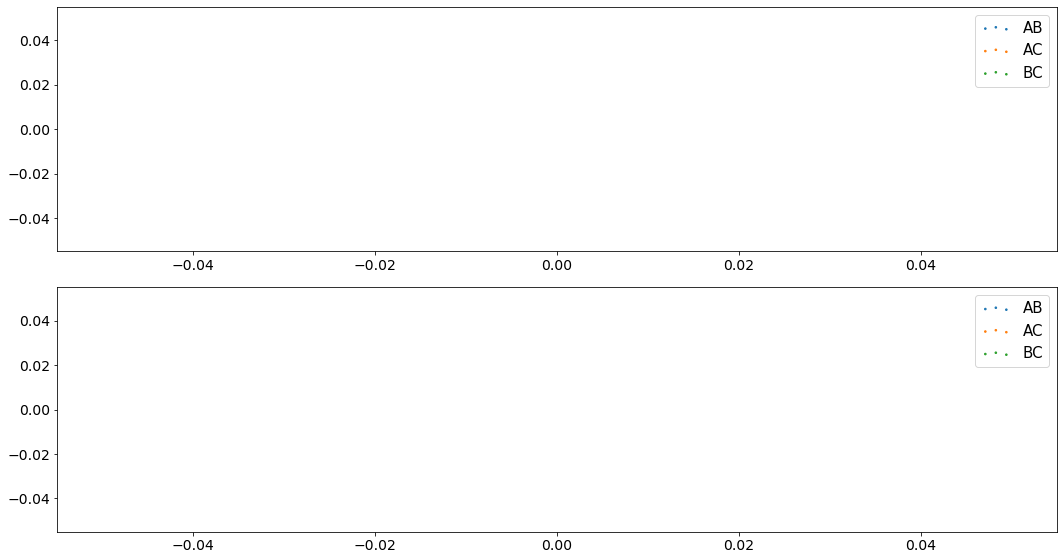


.
.
 3ACG.csv
  Fault type Percentage
0      FAULT     100.0%


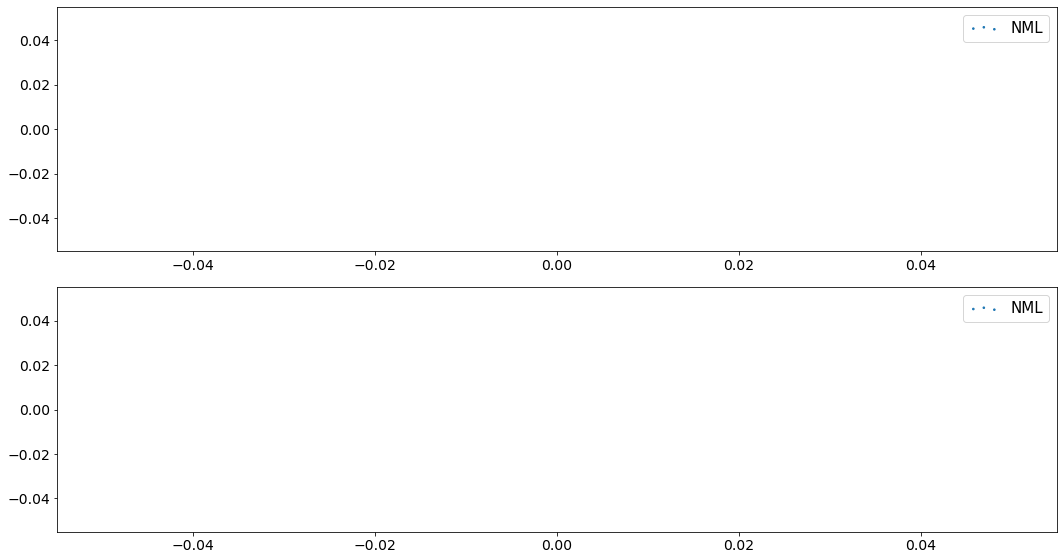

  Fault type Percentage
0        ABC     99.91%
1        ACG       0.1%


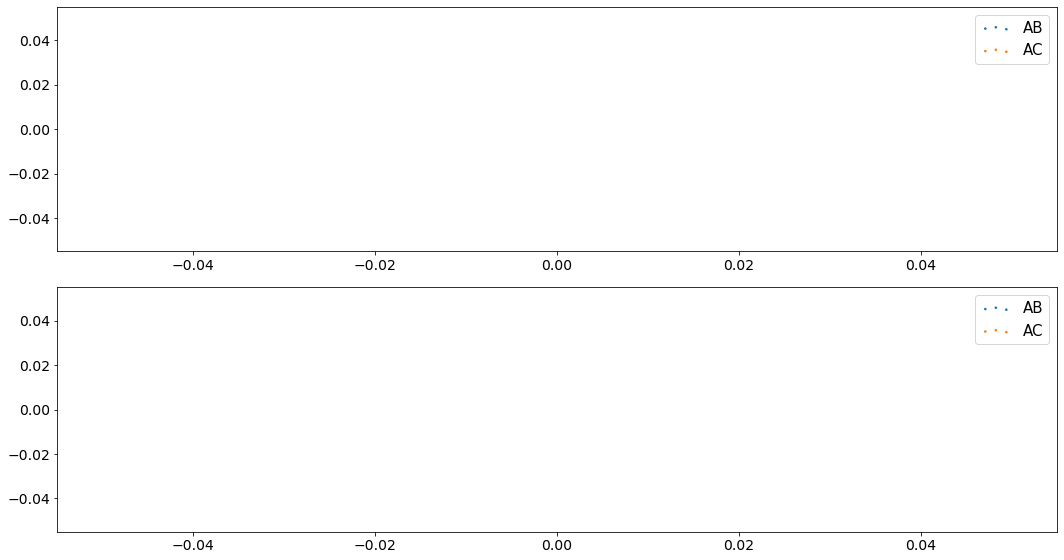


.
.
 8AC.csv
  Fault type Percentage
0      FAULT     100.0%


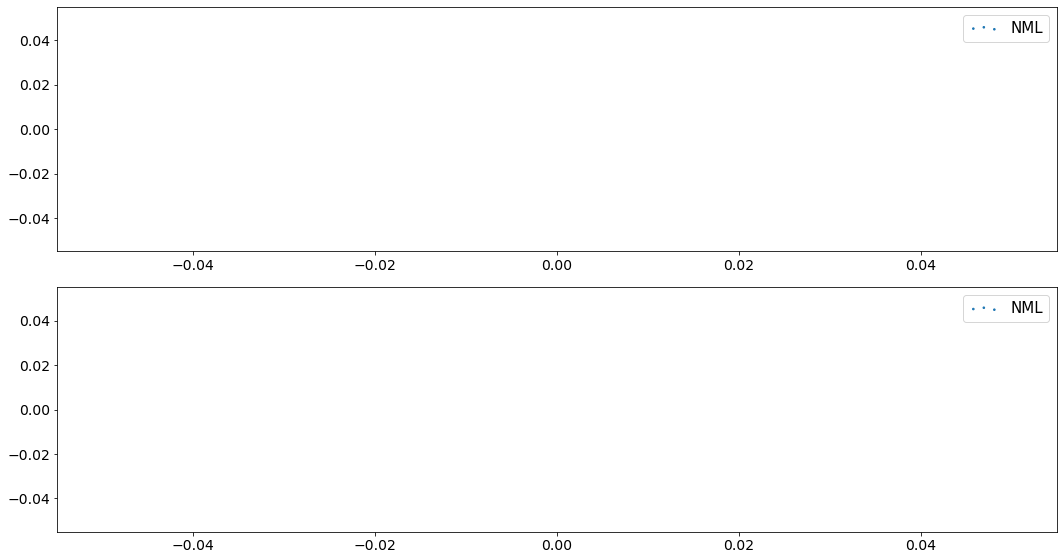

  Fault type Percentage
0        ABC      97.3%
1        ACG      2.71%


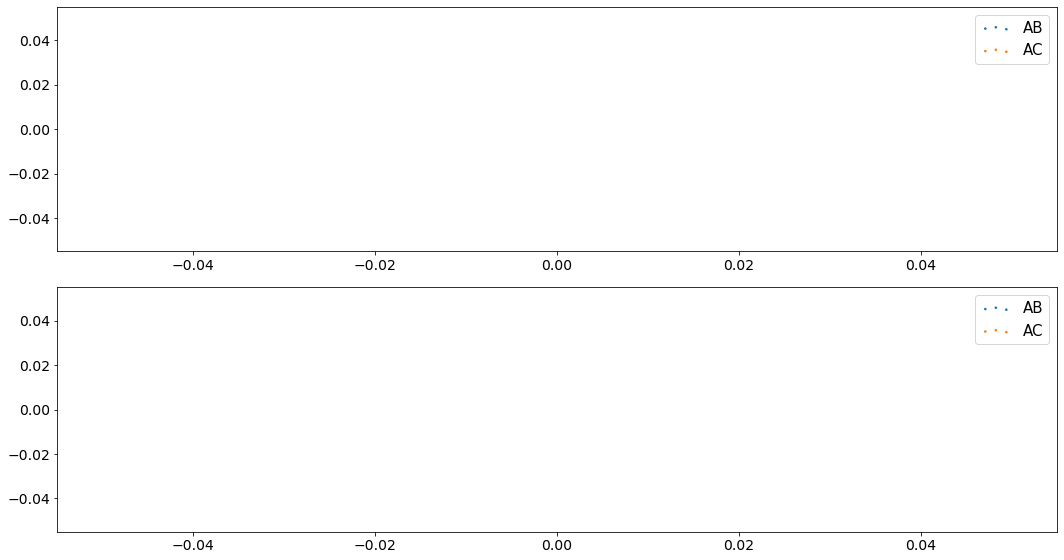


.
.
 4BC.csv
  Fault type Percentage
0      FAULT     100.0%


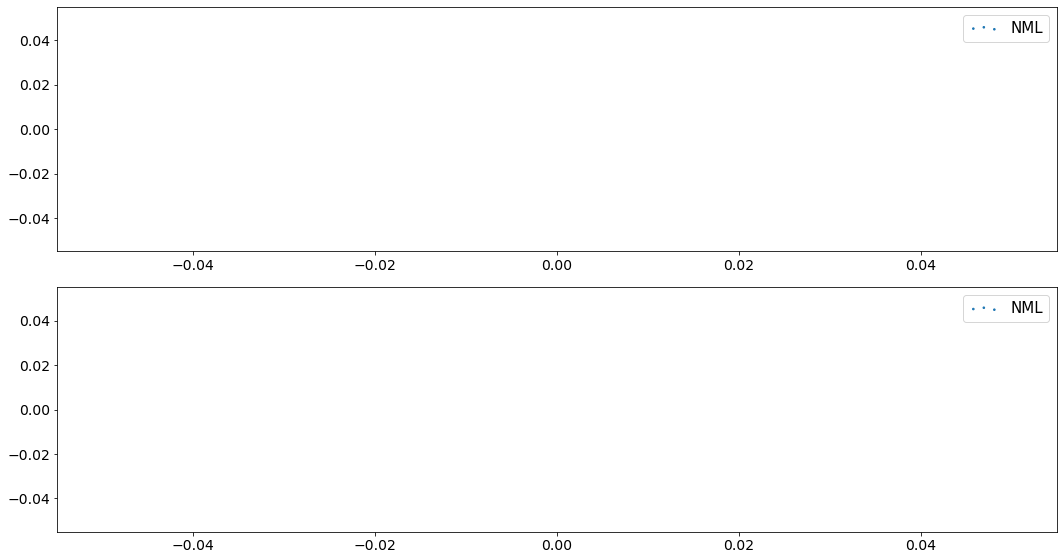

  Fault type Percentage
0        ABC     99.98%
1        BCG      0.02%


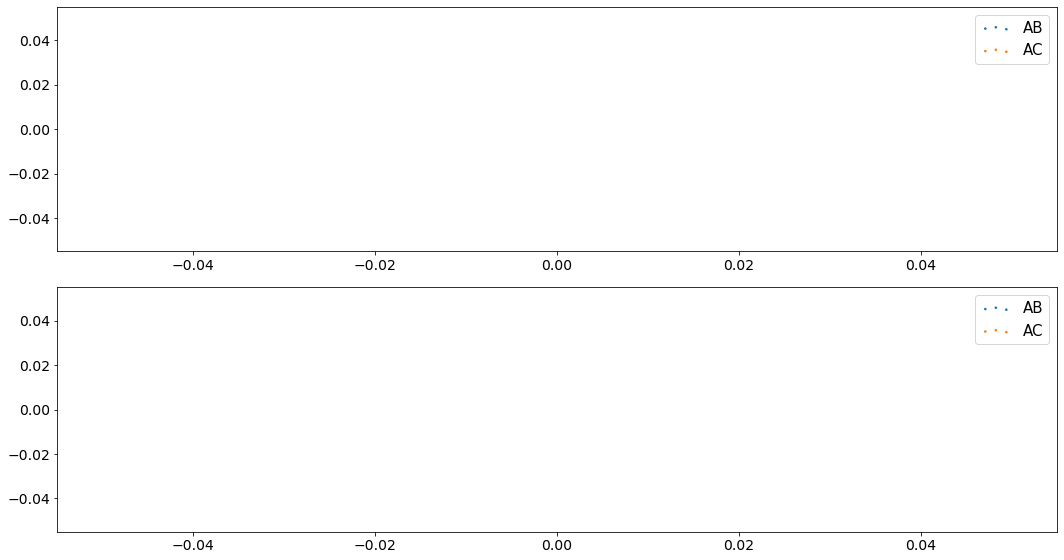


.
.
 4CG.csv
  Fault type Percentage
0      FAULT     100.0%


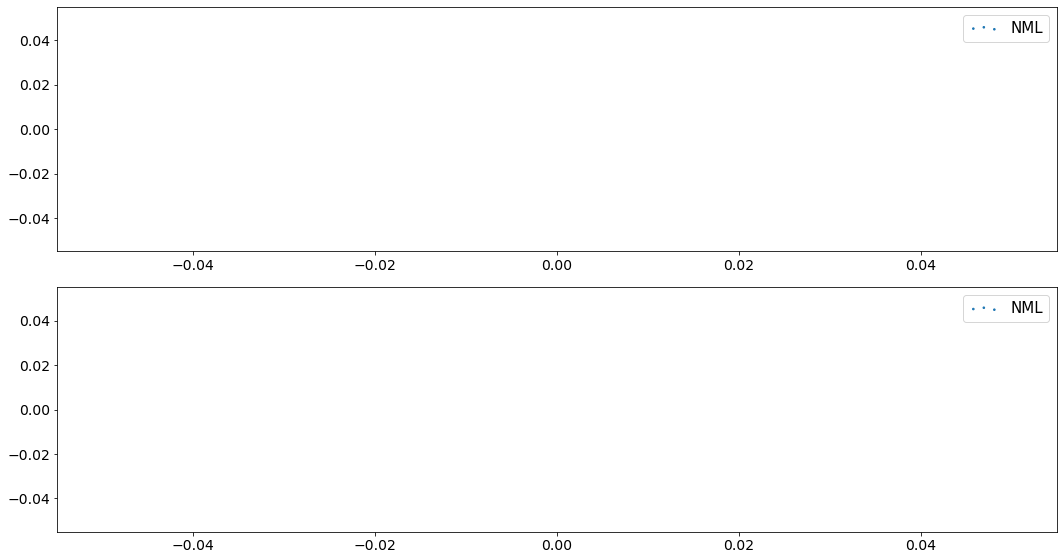

  Fault type Percentage
0        ABC     95.33%
1        ACG      4.67%


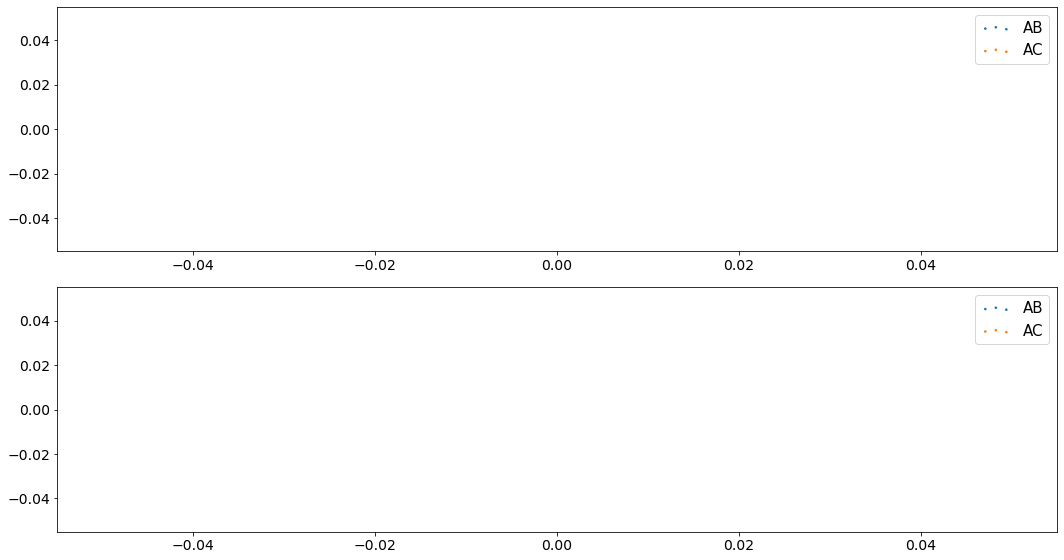


.
.
 1ABG.csv
  Fault type Percentage
0      FAULT     100.0%


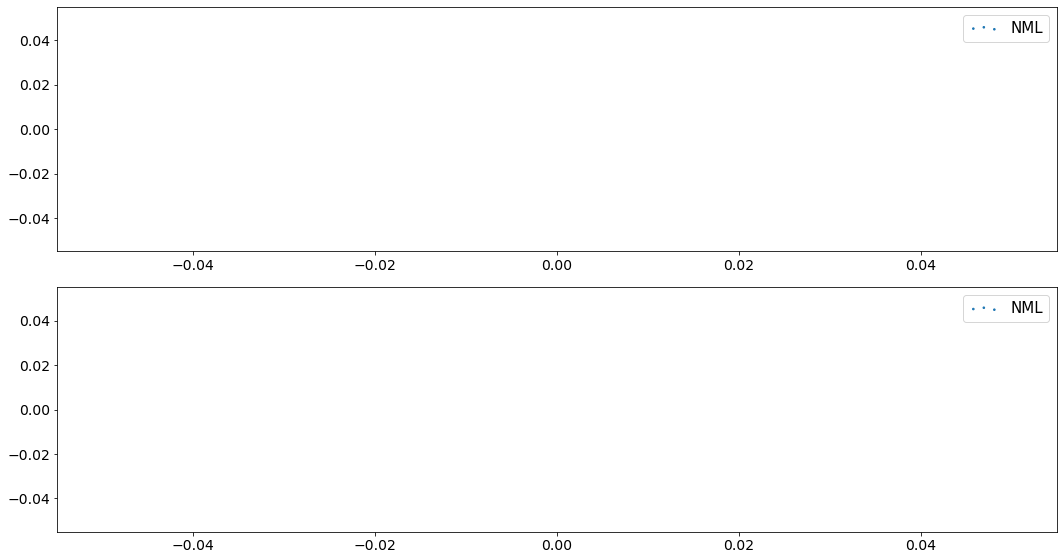

  Fault type Percentage
0        ABC     99.98%
1        ACG      0.01%
2        ABG      0.01%


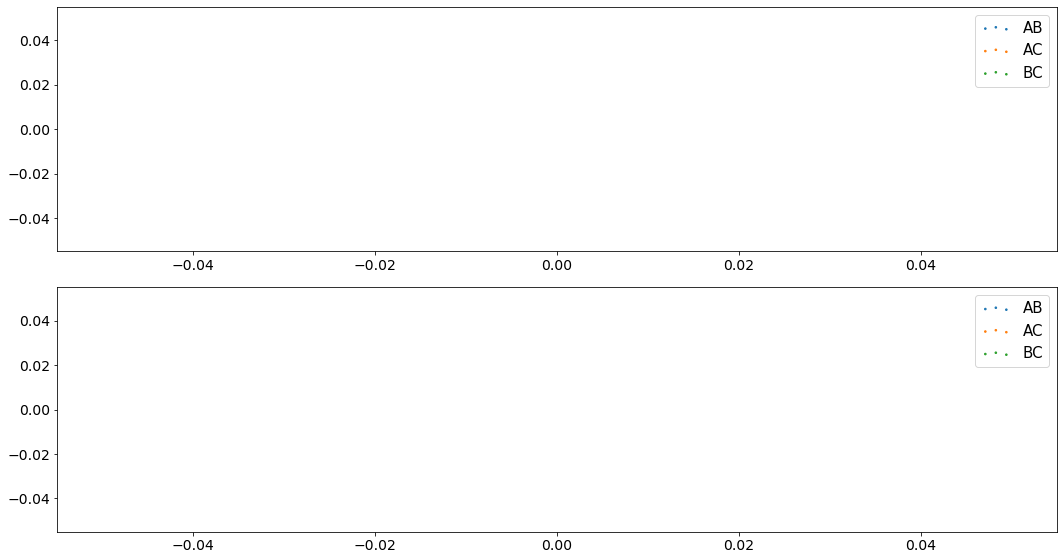


.
.
 8AB.csv
  Fault type Percentage
0      FAULT     100.0%


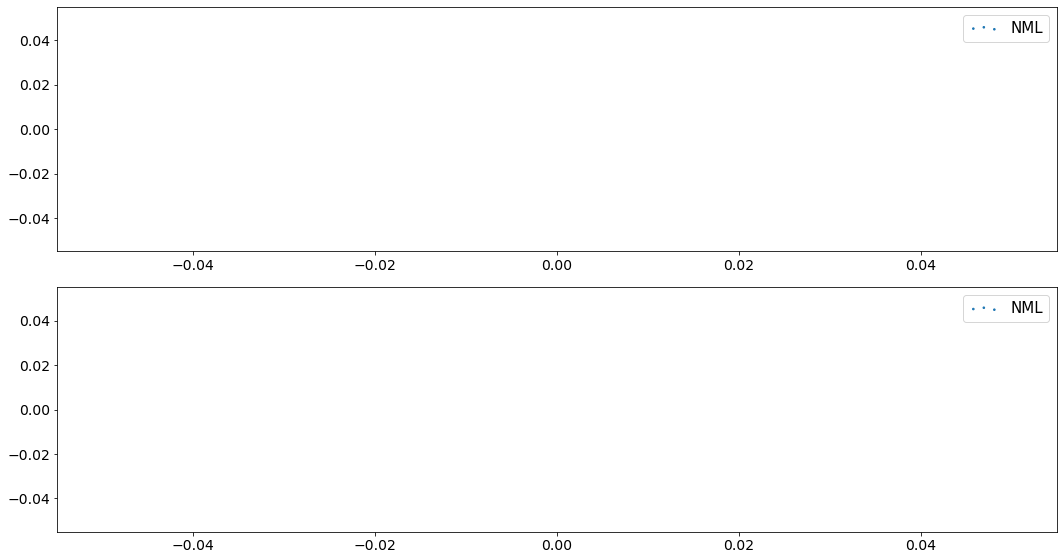

  Fault type Percentage
0        ABC     100.0%


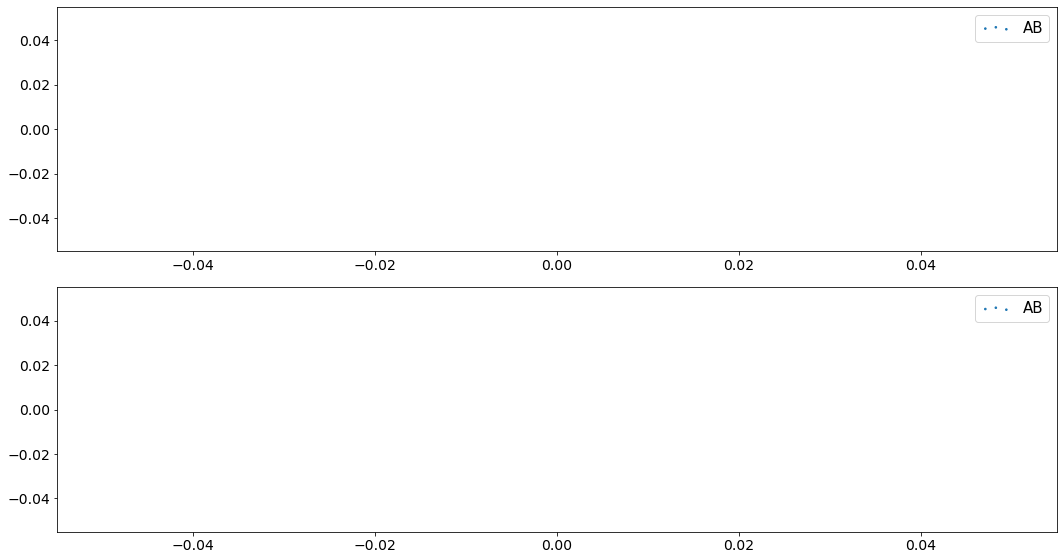


.
.
 10BCG.csv
  Fault type Percentage
0      FAULT     100.0%


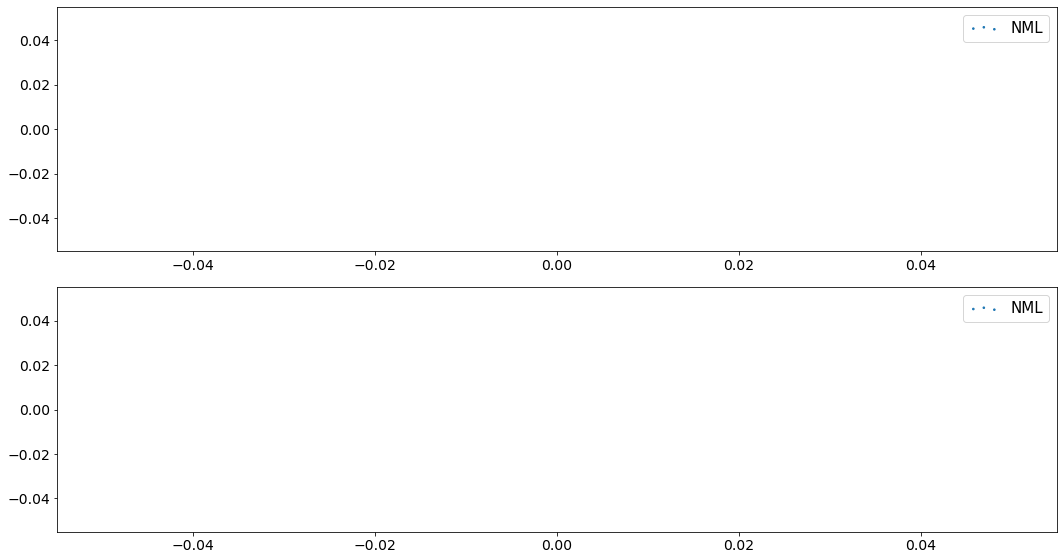

  Fault type Percentage
0        ABC     99.96%
1        BCG      0.04%


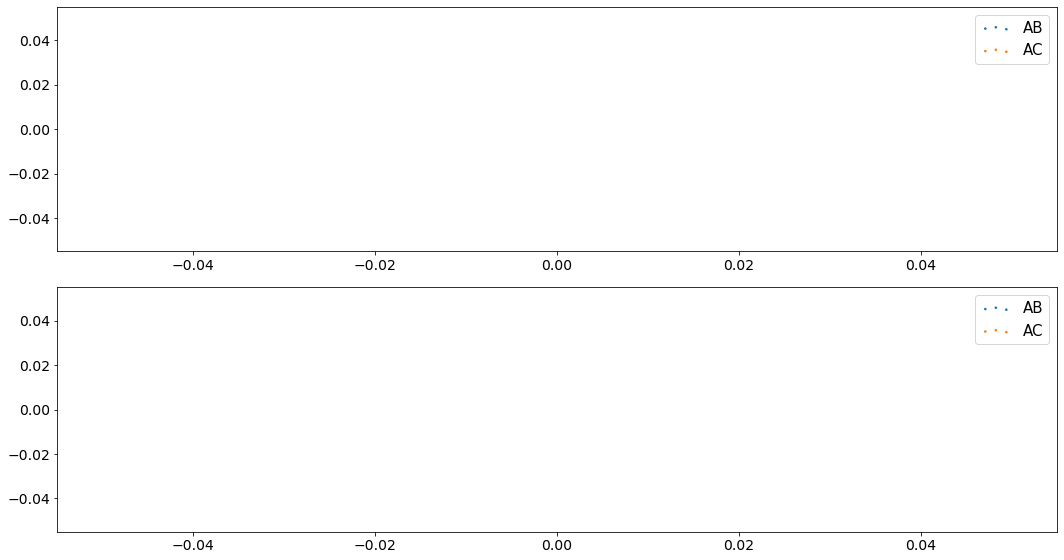


.
.
 8CG.csv
  Fault type Percentage
0      FAULT     100.0%


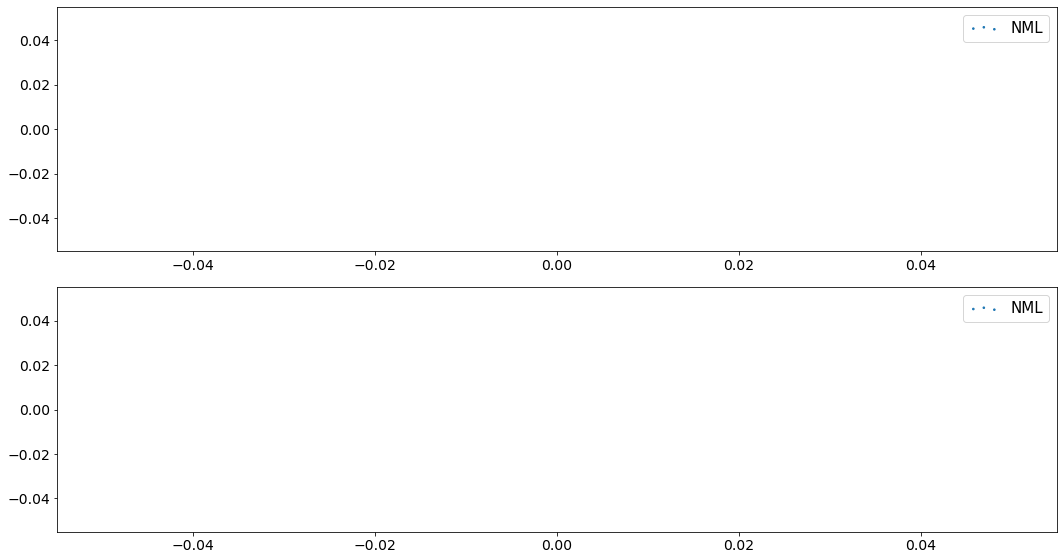

  Fault type Percentage
0        ABC     88.83%
1        ACG     11.16%


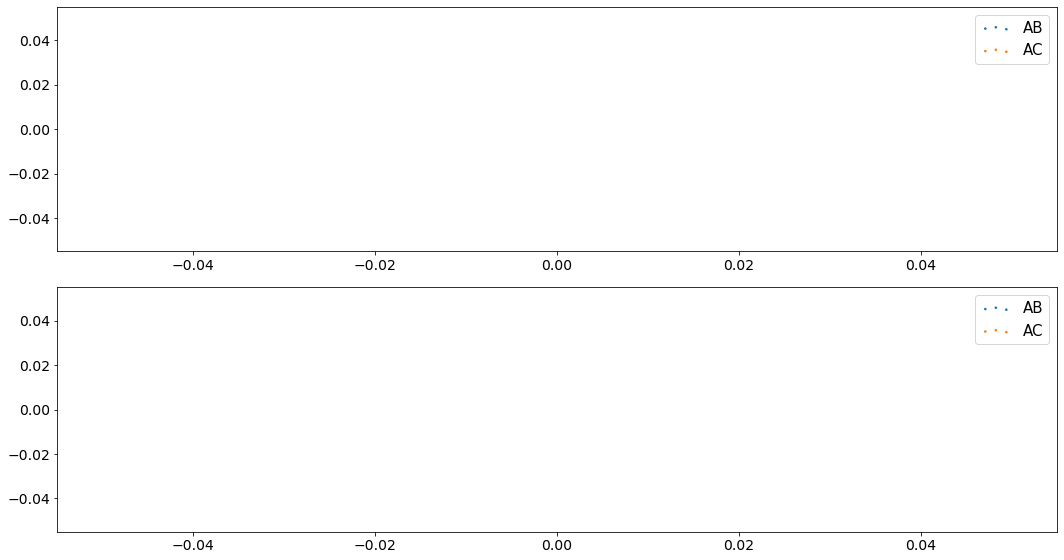


.
.
 8BC.csv
  Fault type Percentage
0      FAULT     100.0%


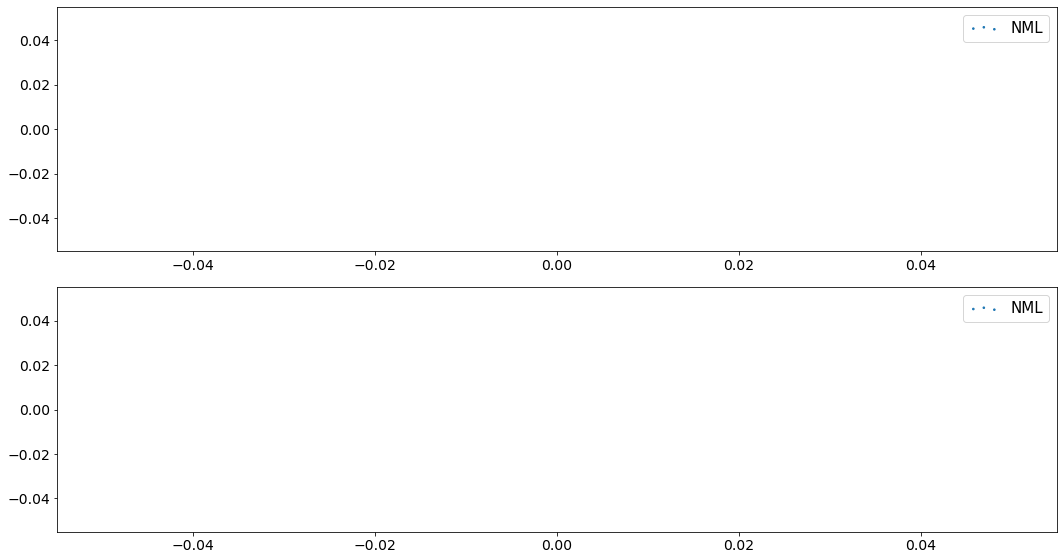

  Fault type Percentage
0        ABC     100.0%


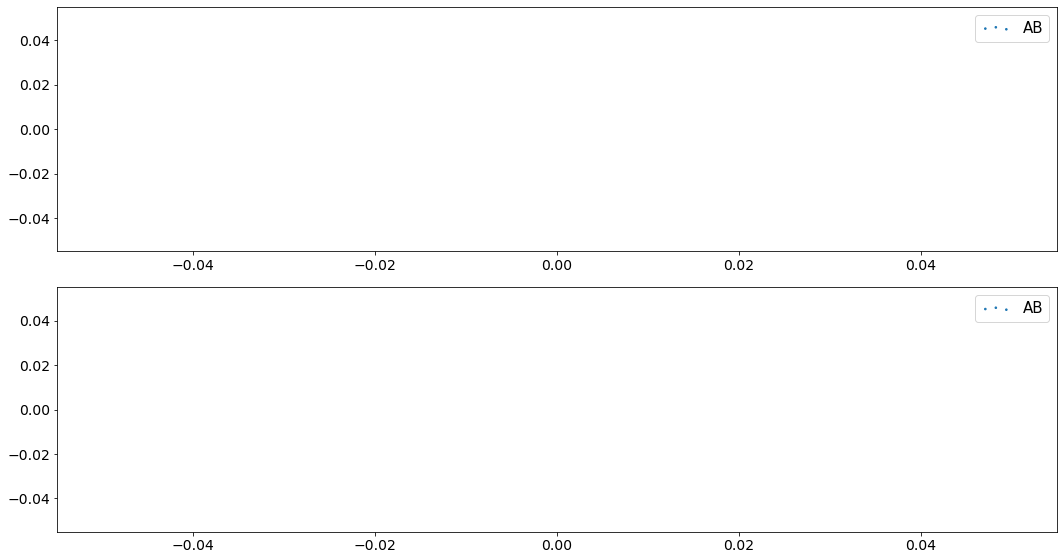


.
.
 4AB.csv
  Fault type Percentage
0      FAULT     100.0%


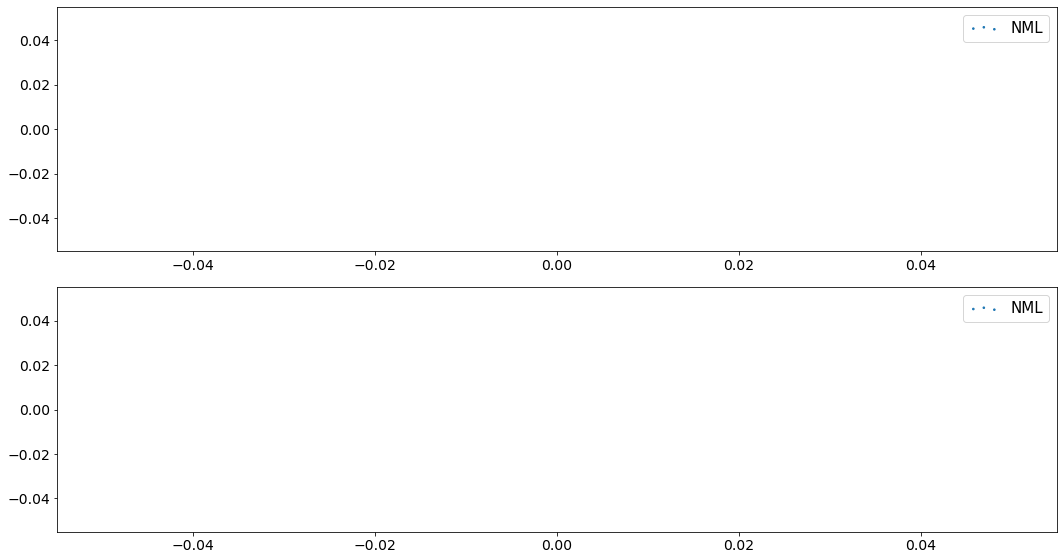

  Fault type Percentage
0        ABC     98.27%
1        ABG      1.73%


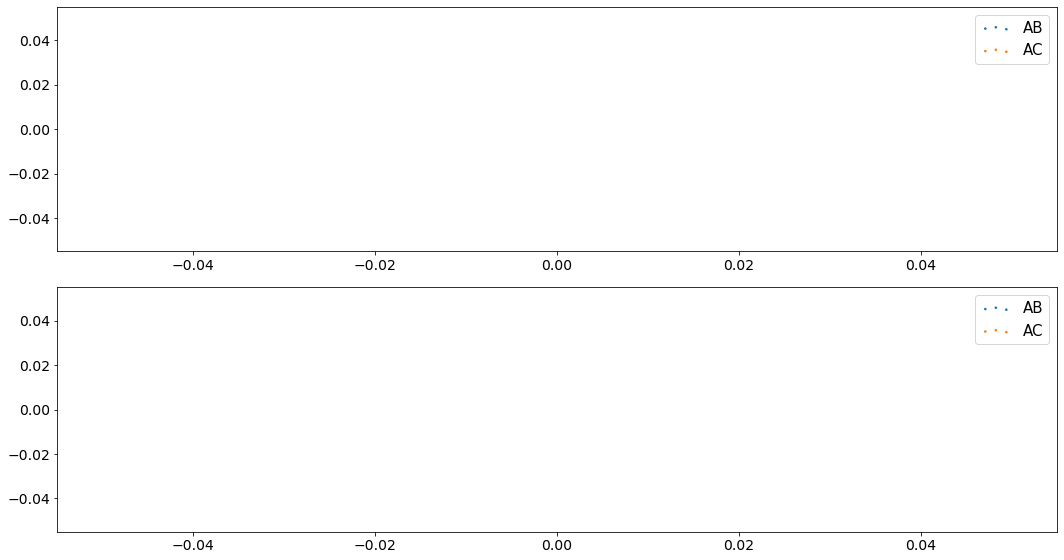


.
.
 6ACG.csv
  Fault type Percentage
0      FAULT     100.0%


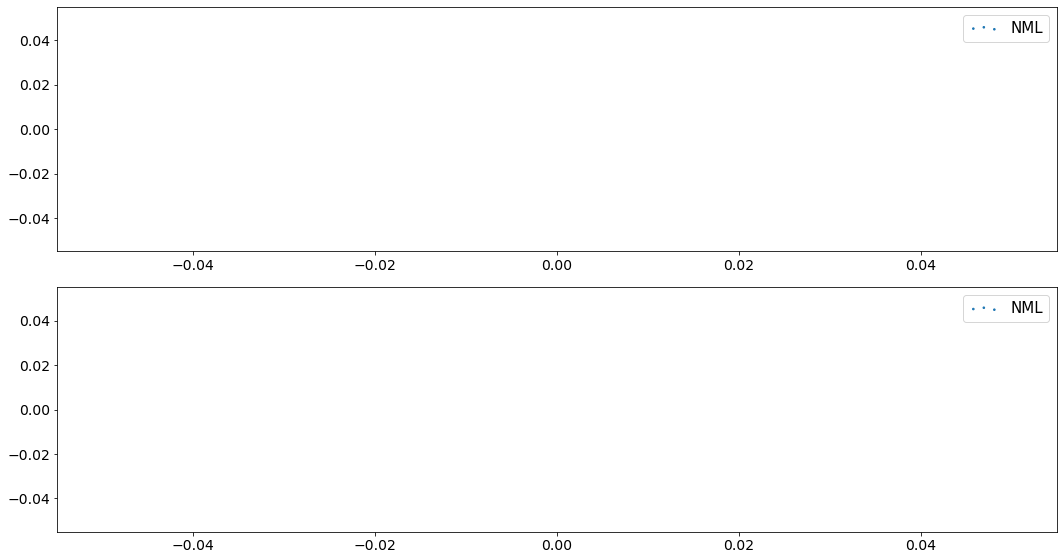

  Fault type Percentage
0        ABC     99.95%
1        ACG      0.04%


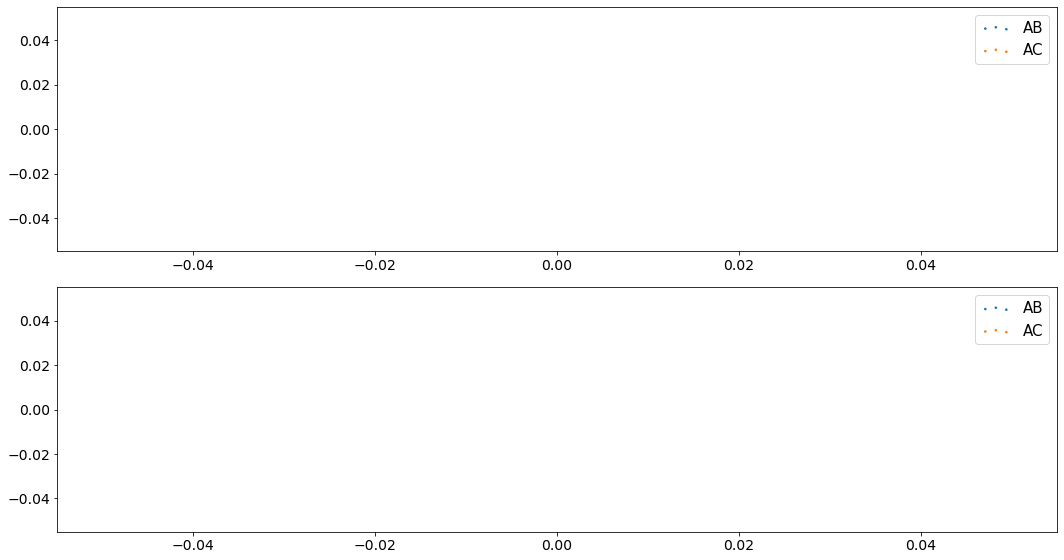


.
.
 6ABC.csv
  Fault type Percentage
0      FAULT     100.0%


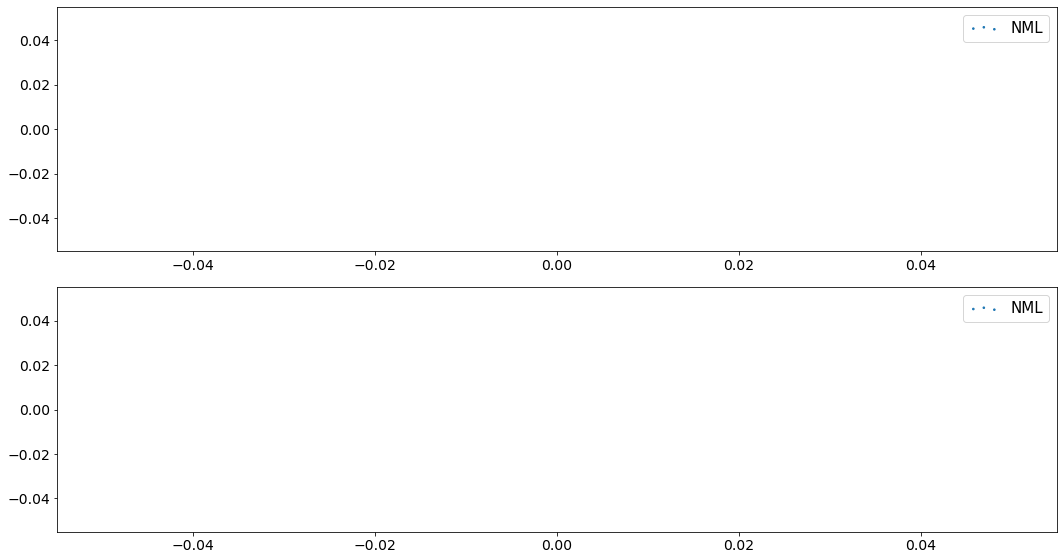

  Fault type Percentage
0        ABC     100.0%


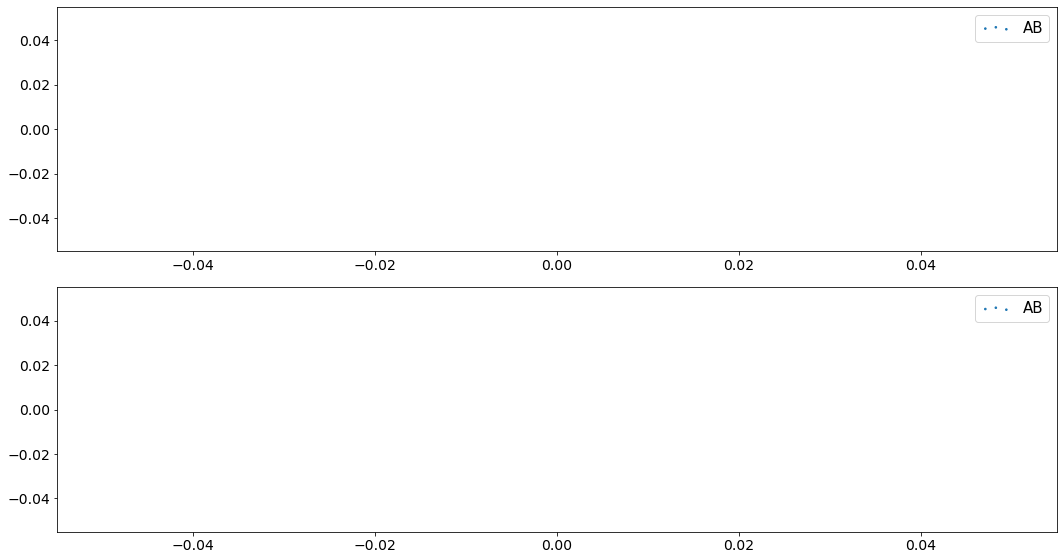


.
.
 8ABG.csv
  Fault type Percentage
0      FAULT     100.0%


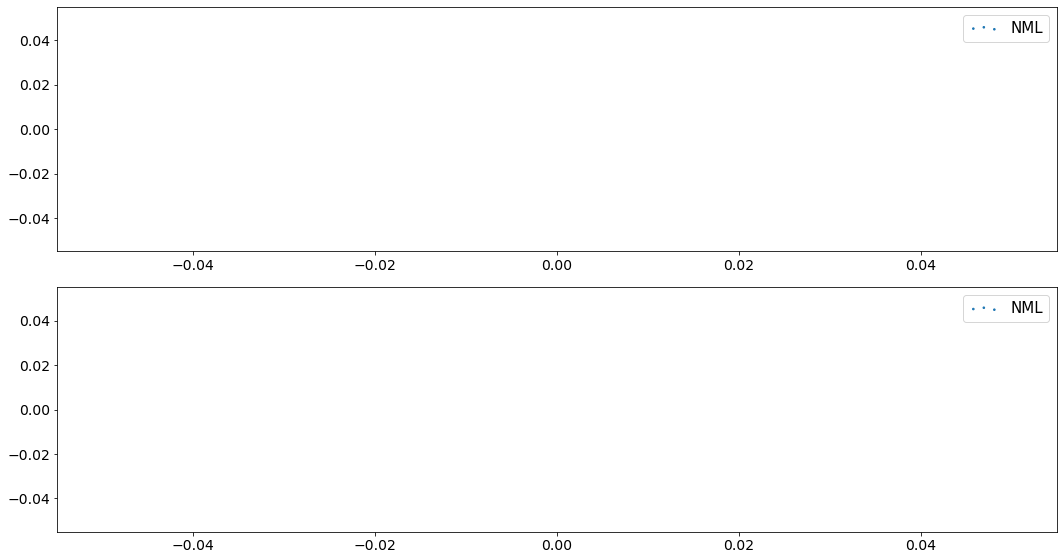

  Fault type Percentage
0        ABC     100.0%
1        ACG      0.01%


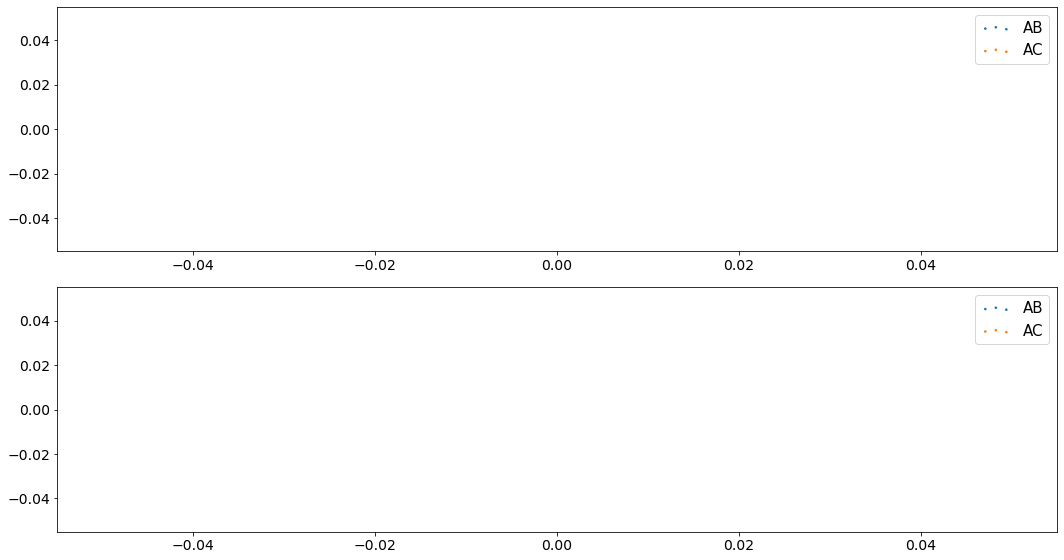


.
.
 4AC.csv
  Fault type Percentage
0      FAULT     100.0%


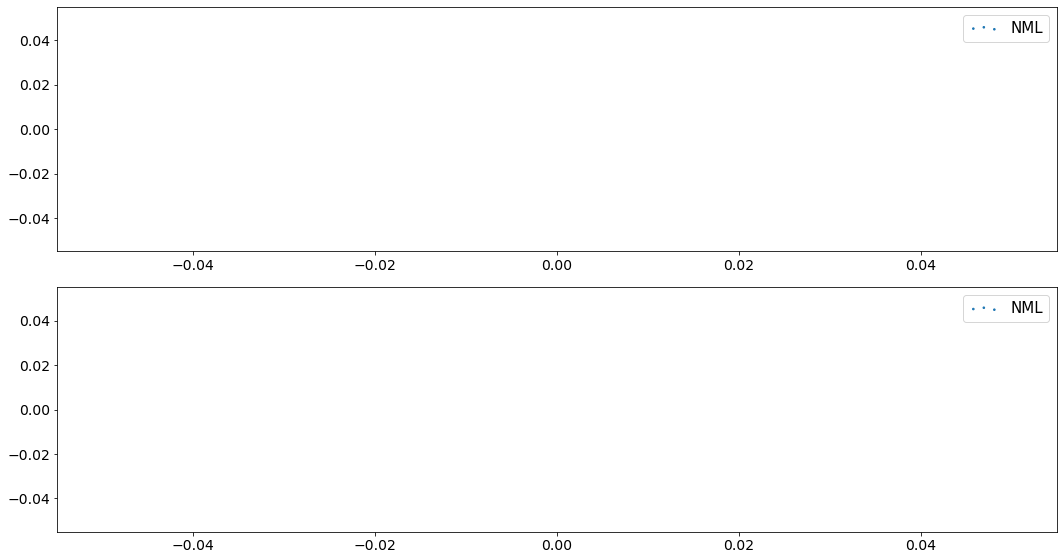

  Fault type Percentage
0        ABC     91.75%
1        ACG      8.25%


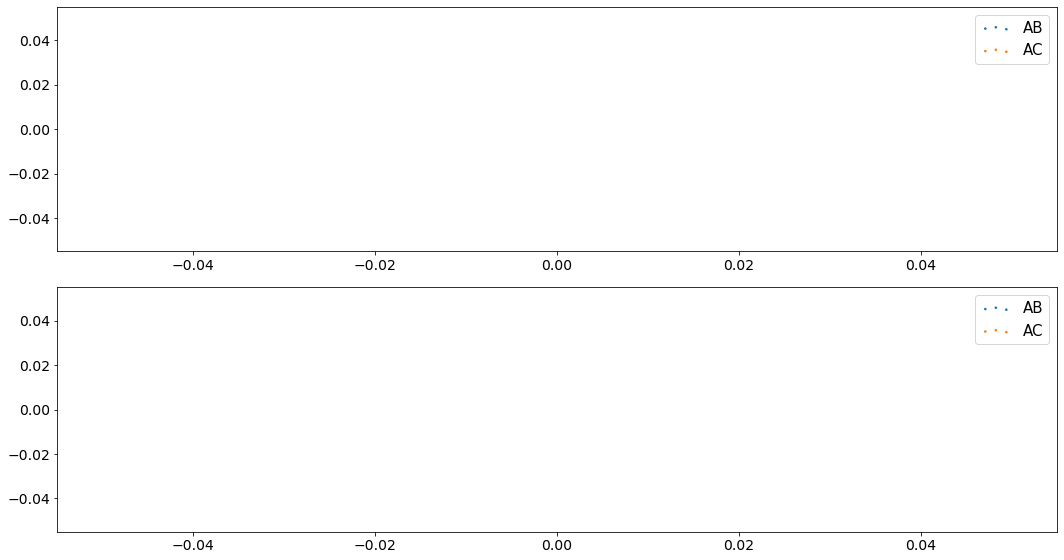


.
.
 4ABG.csv
  Fault type Percentage
0      FAULT     100.0%


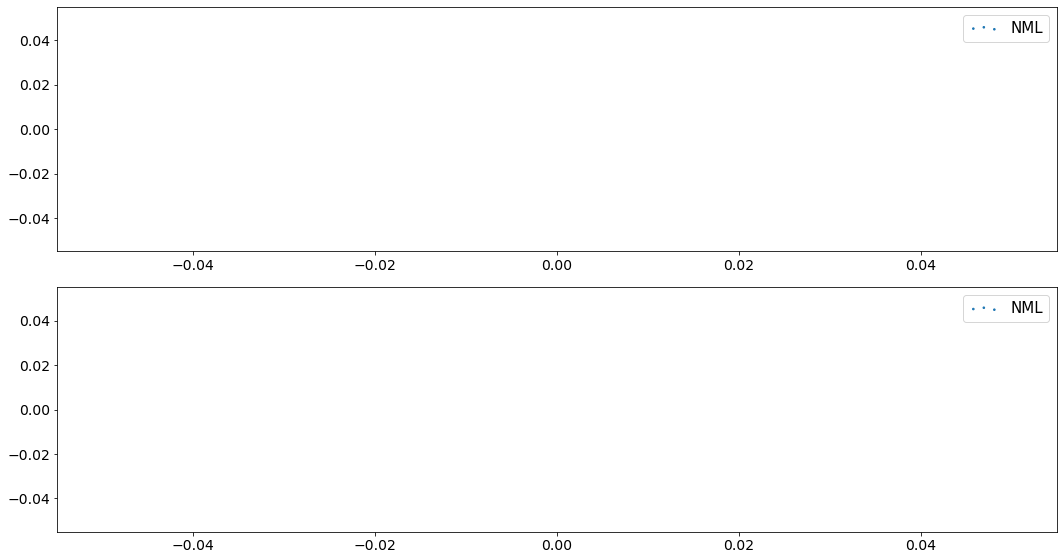

  Fault type Percentage
0        ABC     100.0%


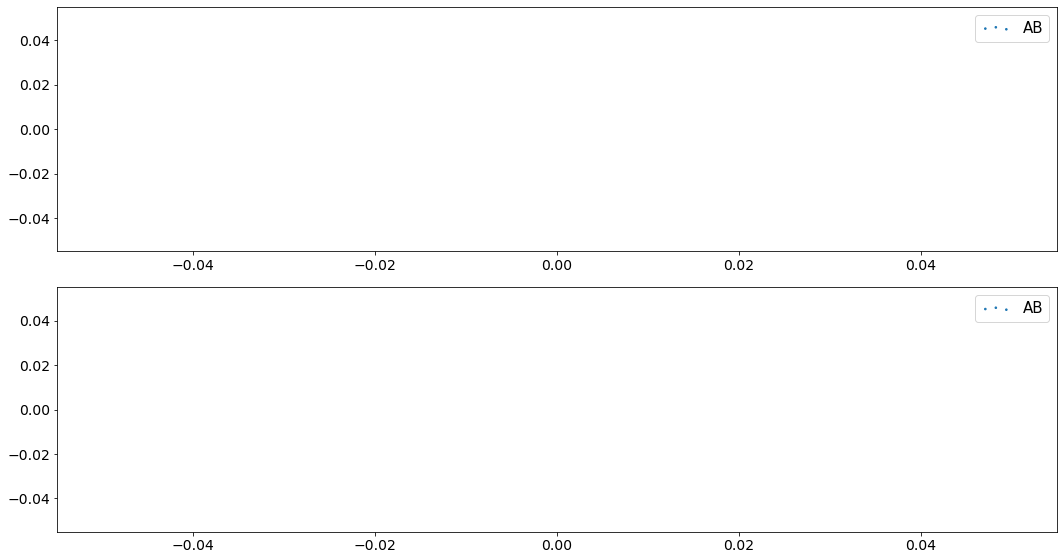


.
.
 2AG.csv
  Fault type Percentage
0      FAULT     100.0%


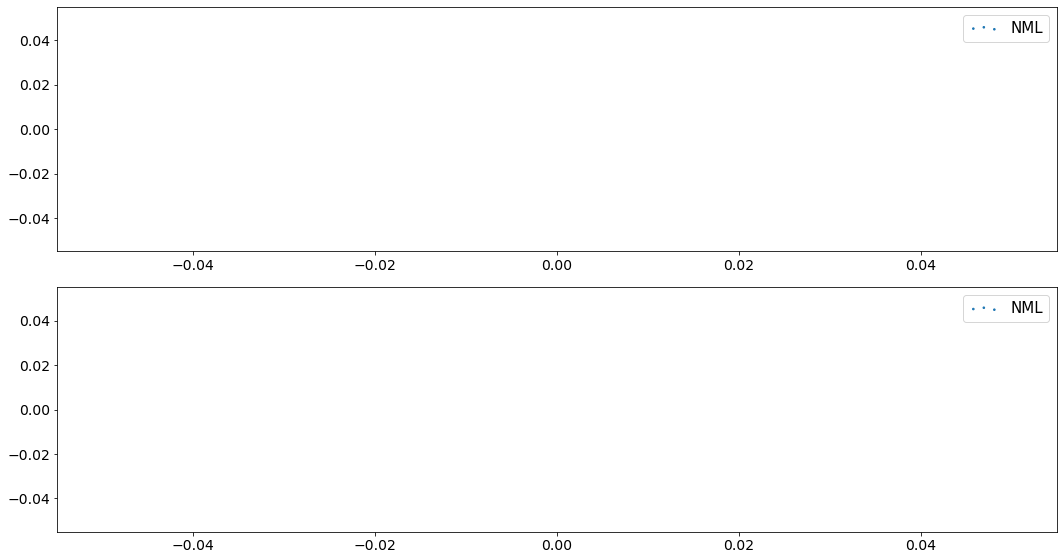

  Fault type Percentage
0        ABC     95.98%
1        ABG      2.77%
2        ACG      1.25%


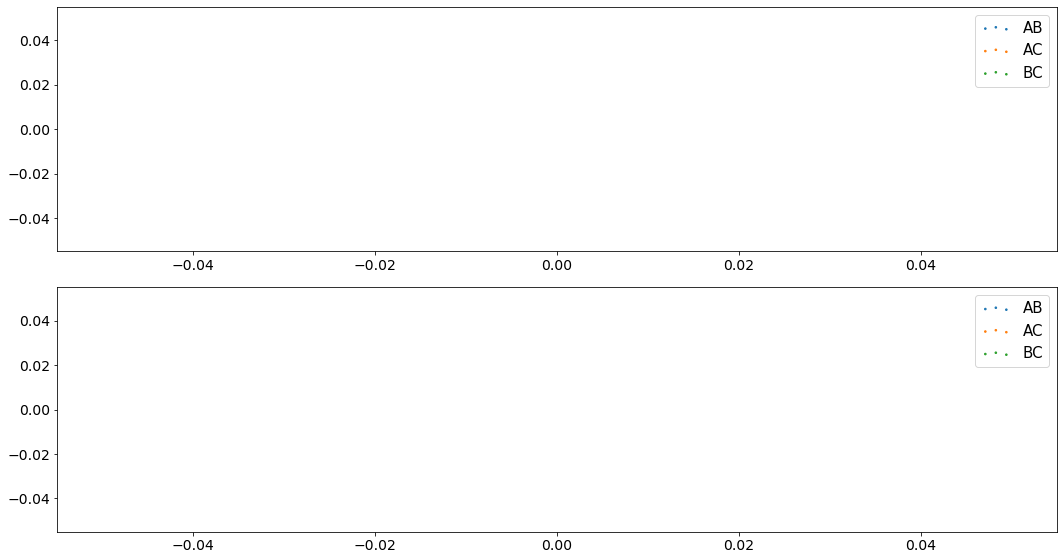


.
.
 6AC.csv
  Fault type Percentage
0      FAULT     100.0%


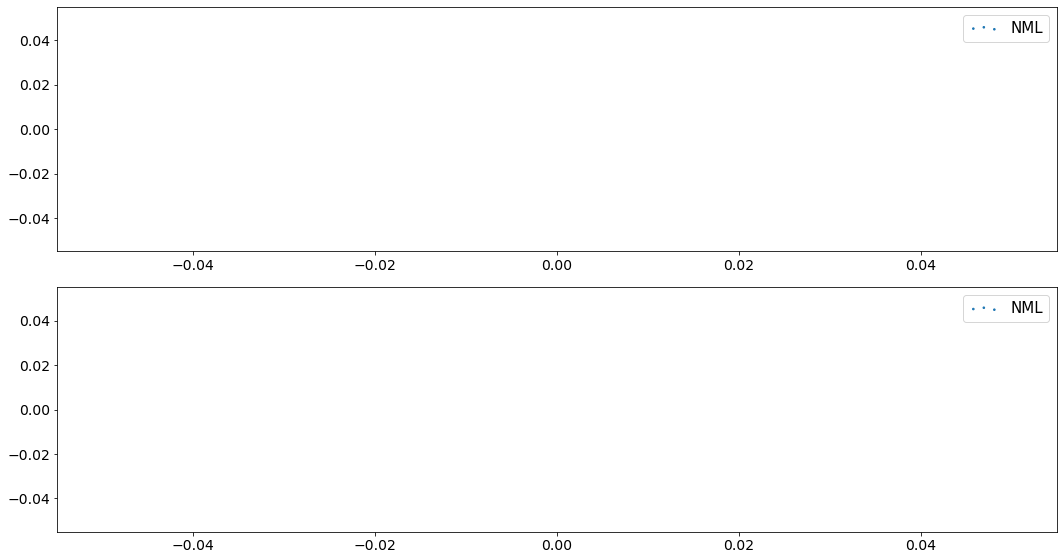

  Fault type Percentage
0        ABC     83.83%
1        ACG     16.16%


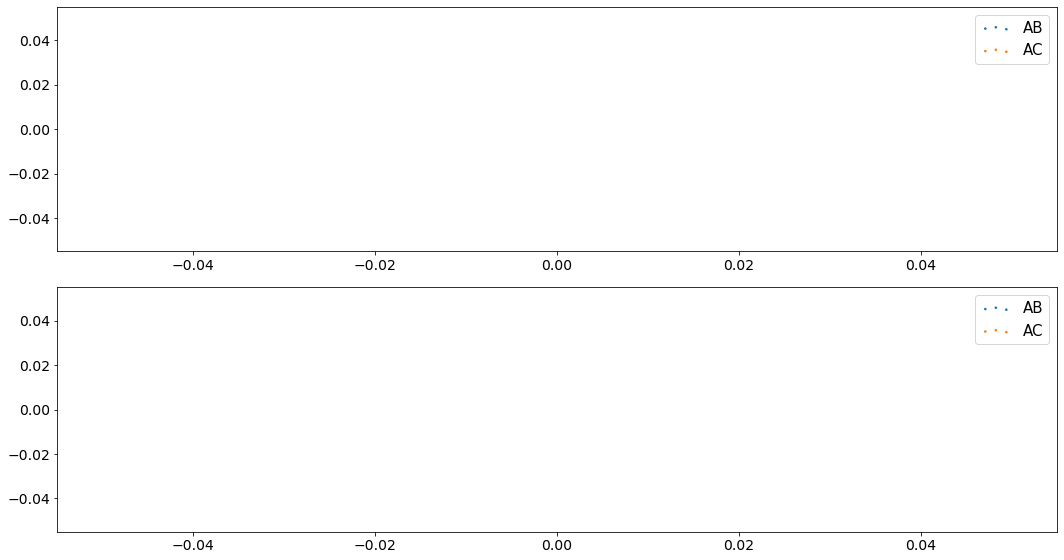


.
.
 6AB.csv
  Fault type Percentage
0      FAULT     100.0%


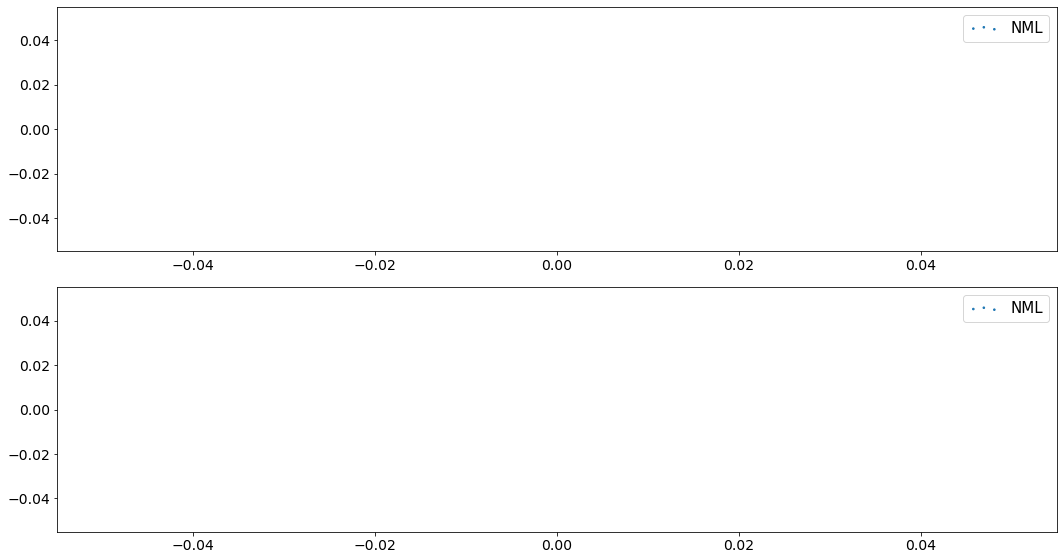

  Fault type Percentage
0        ABC      71.5%
1        ABG      28.5%


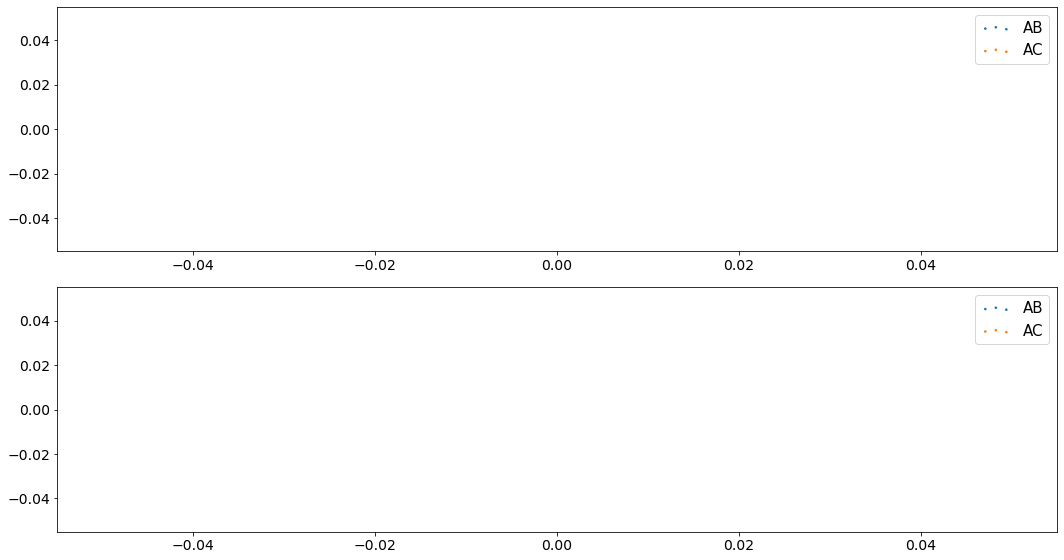


.
.
 2ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


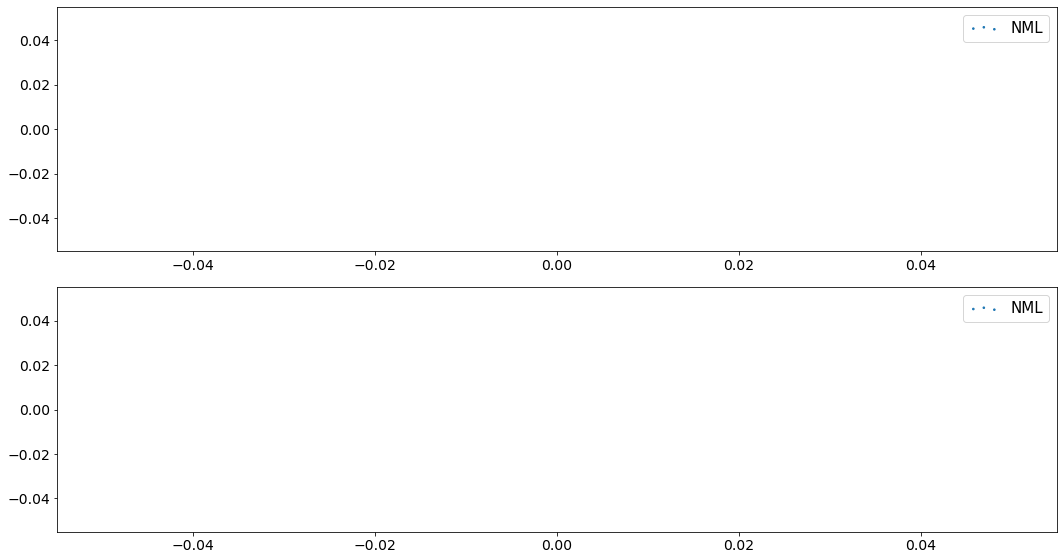

  Fault type Percentage
0        ABC     100.0%


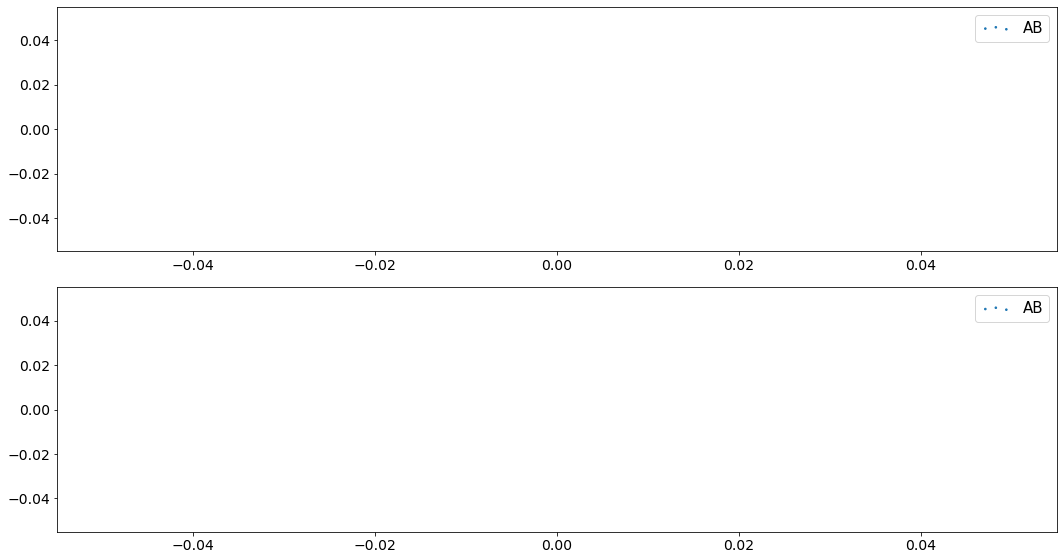


.
.
 10BG.csv
  Fault type Percentage
0      FAULT     100.0%


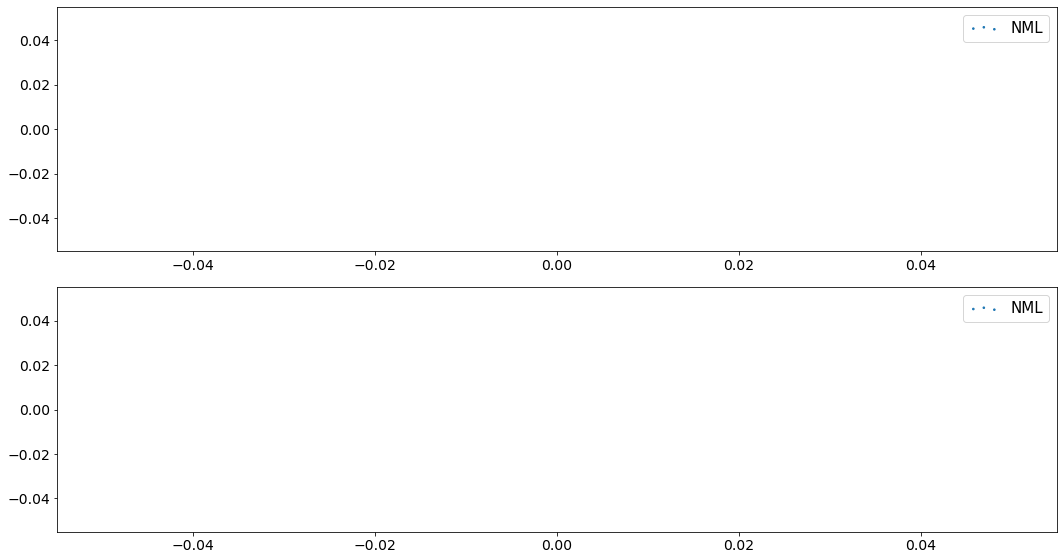

  Fault type Percentage
0        ABC     100.0%


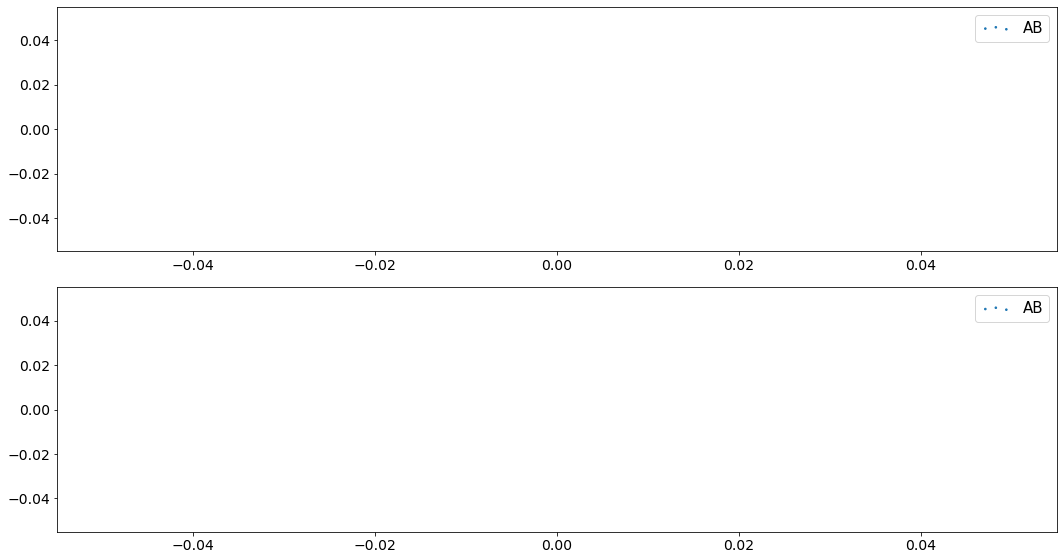


.
.
 2AB.csv
  Fault type Percentage
0      FAULT     100.0%


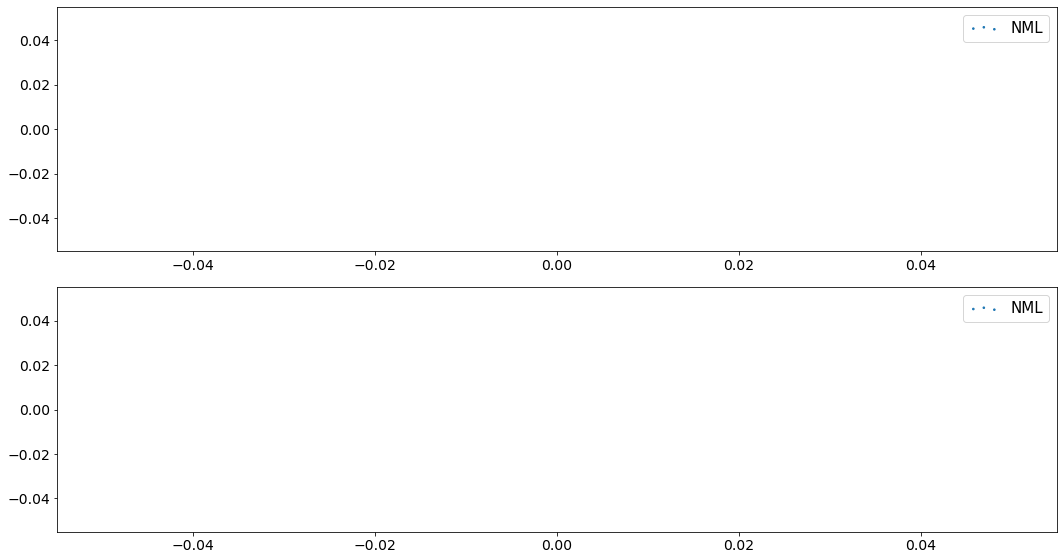

  Fault type Percentage
0        ABC     100.0%


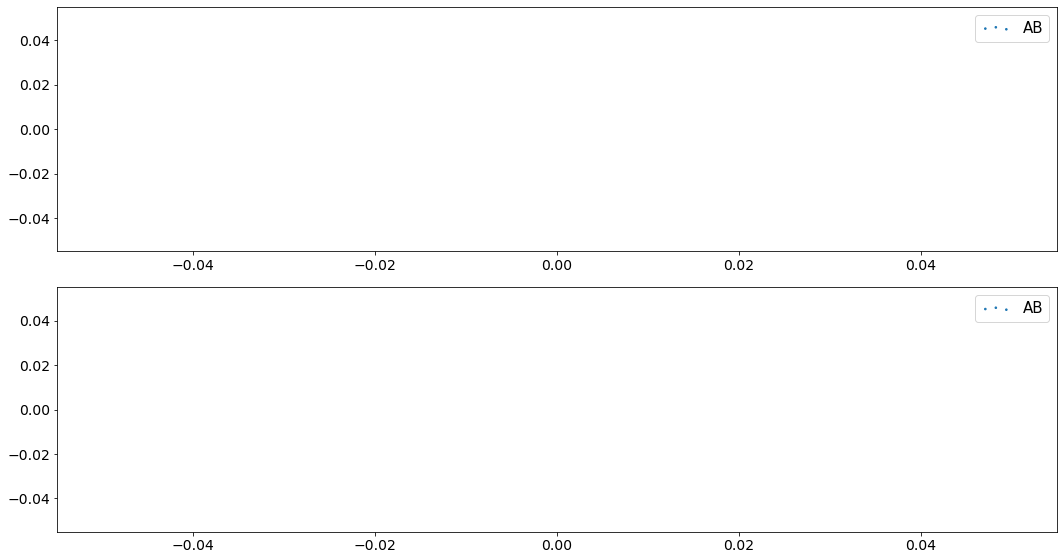


.
.
 2BCG.csv
  Fault type Percentage
0      FAULT     100.0%


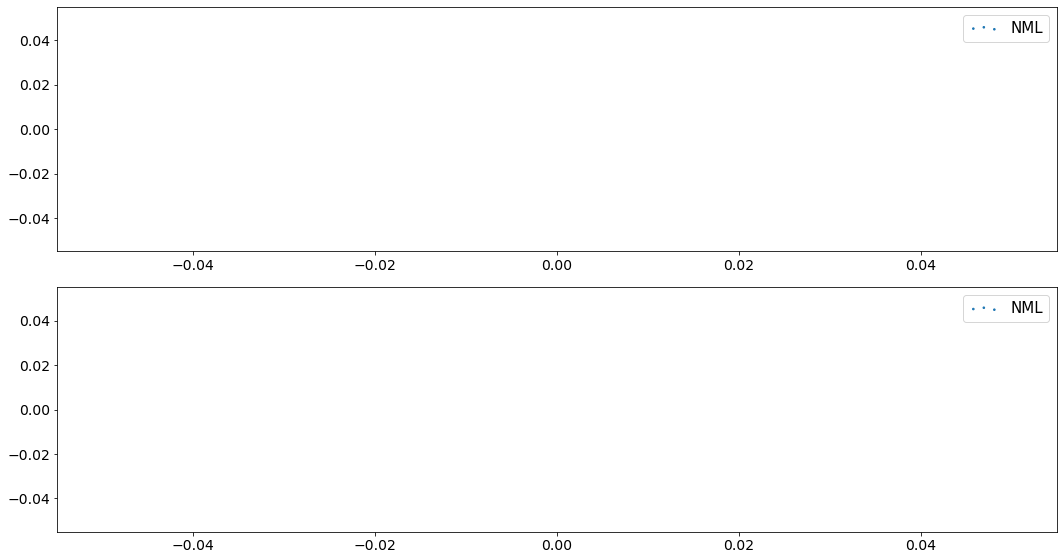

  Fault type Percentage
0        ABC     99.94%
1        BCG      0.07%


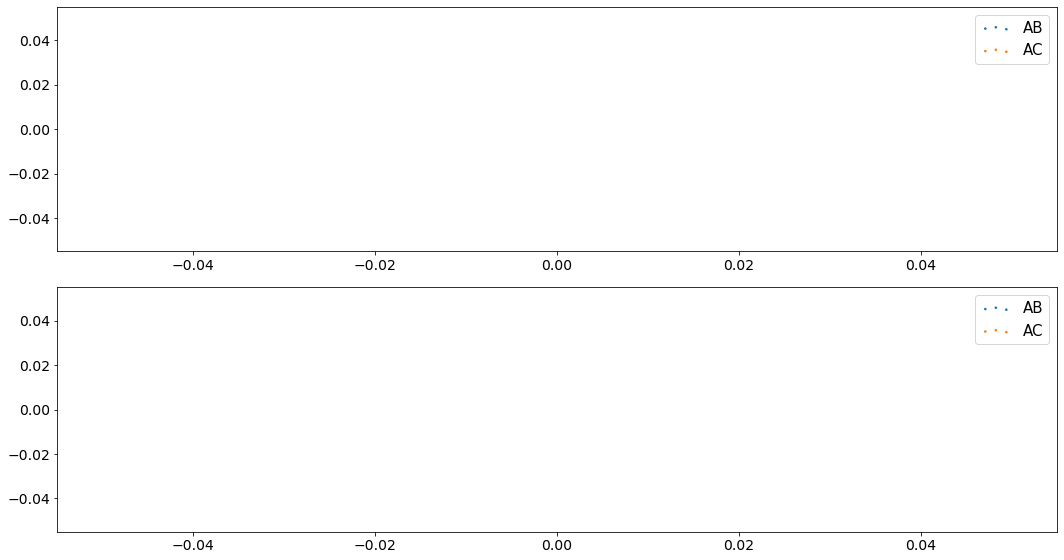


.
.
 10BC.csv
  Fault type Percentage
0      FAULT     100.0%


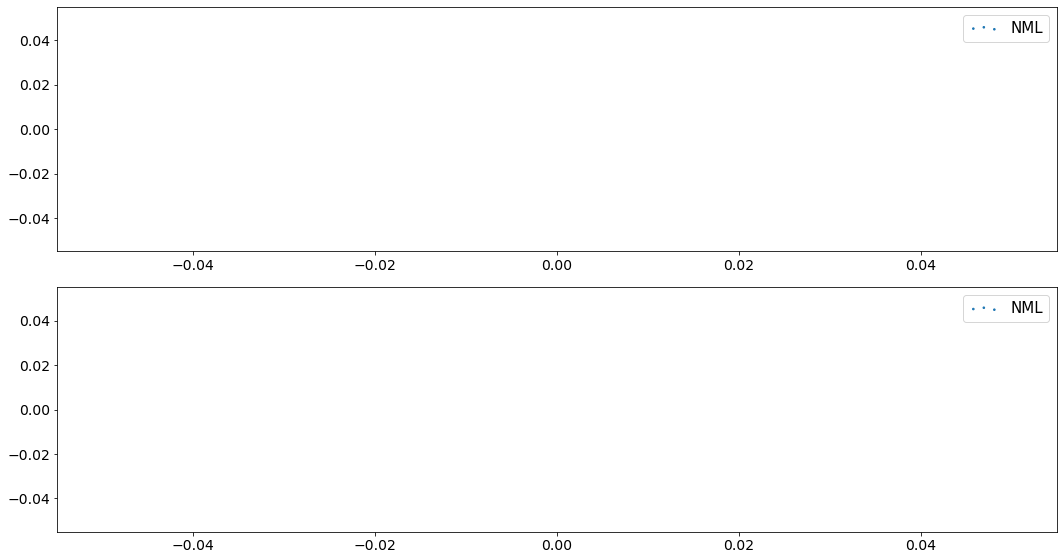

  Fault type Percentage
0        ABC     99.98%
1        BCG      0.02%


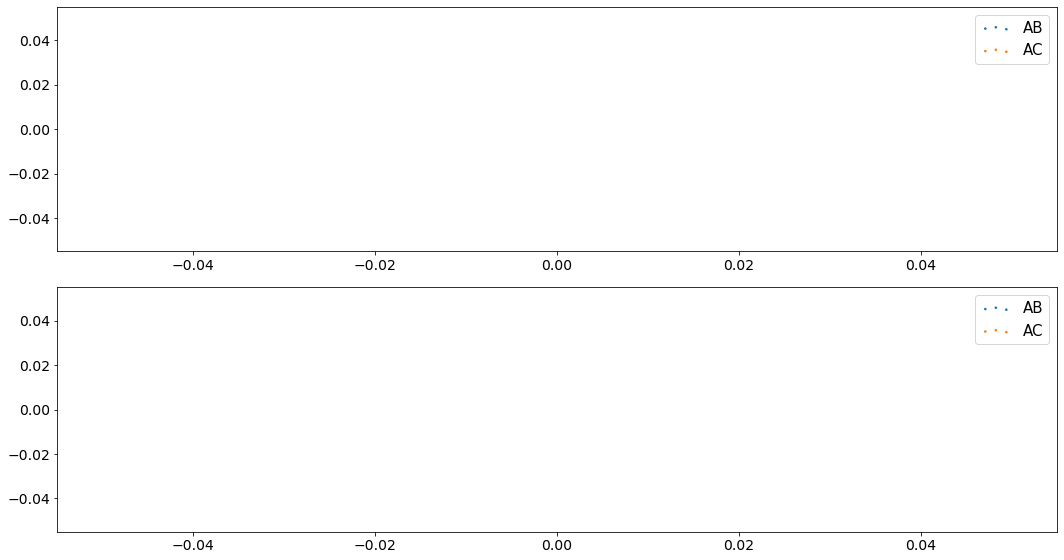


.
.
 10CG.csv
  Fault type Percentage
0      FAULT     100.0%


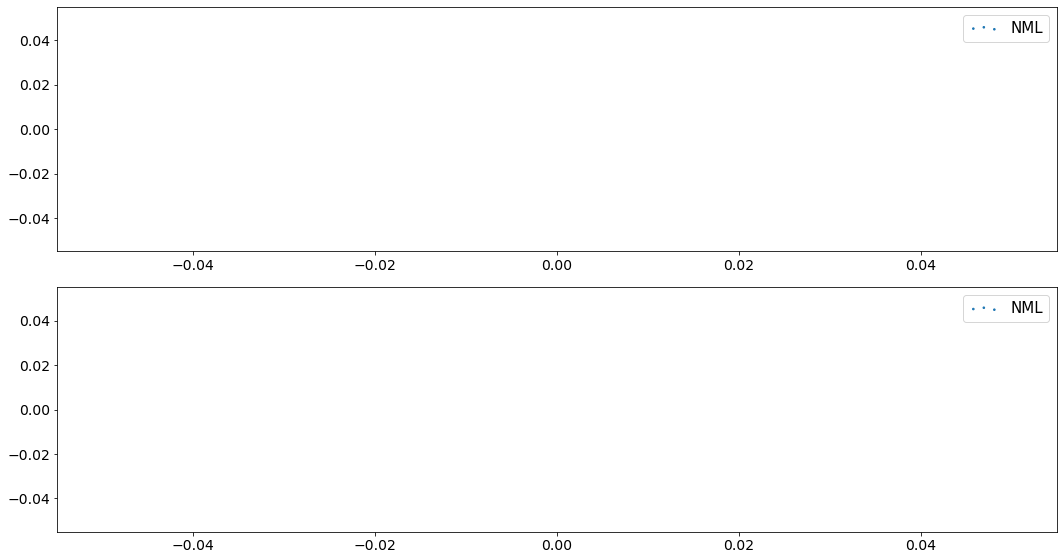

  Fault type Percentage
0        ACG     65.42%
1        ABC     34.58%


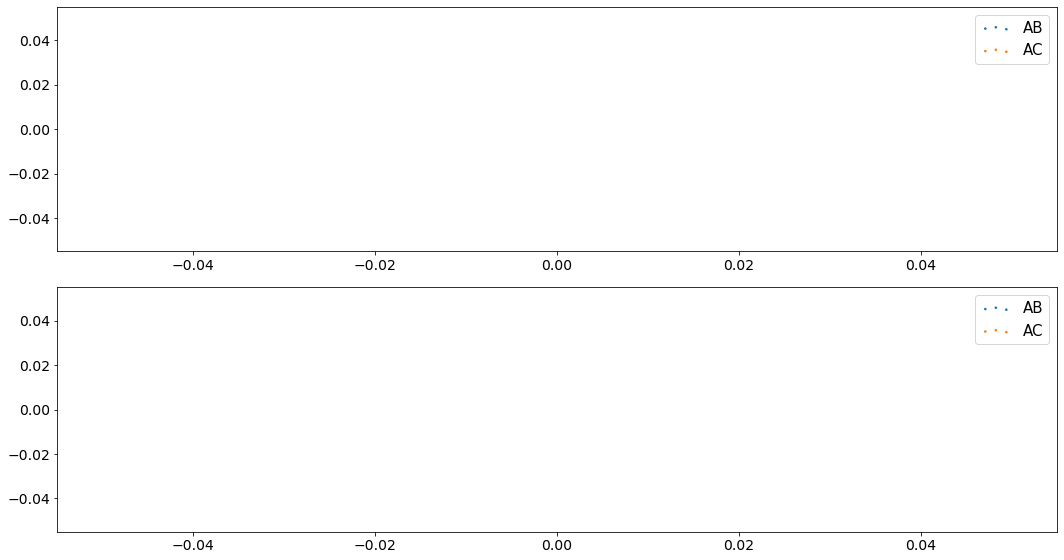


.
.
 10ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


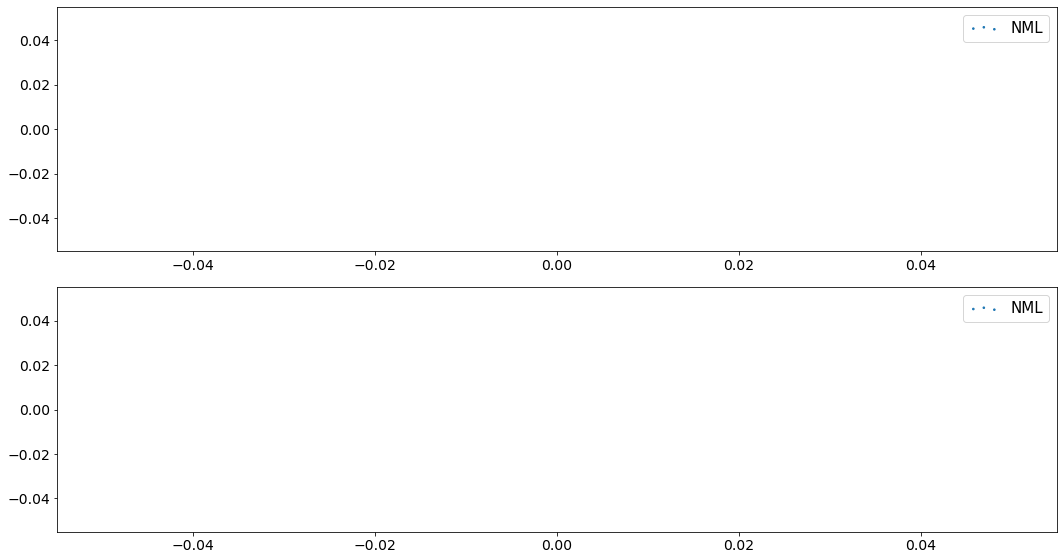

  Fault type Percentage
0        ABC     100.0%


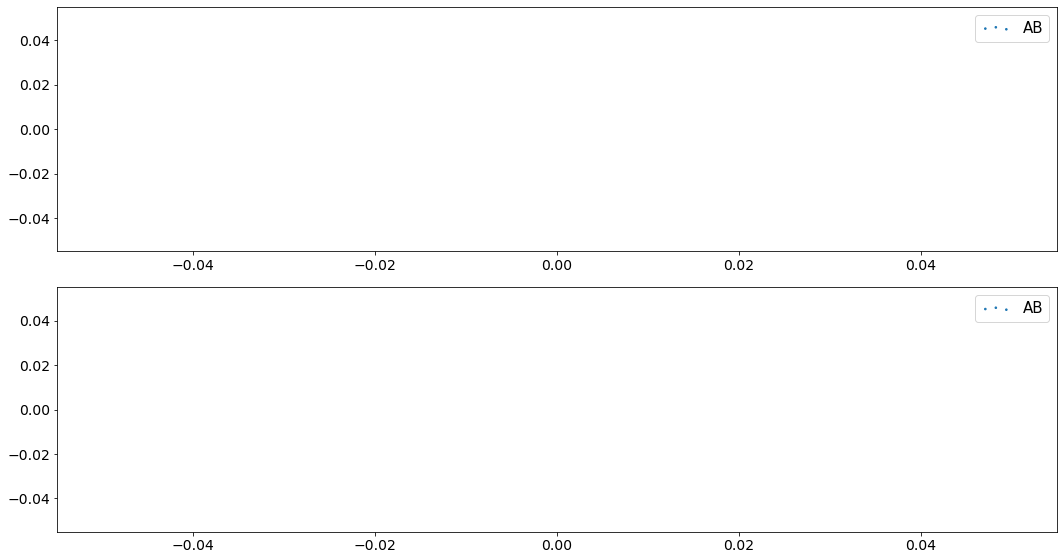


.
.
 6AG.csv
  Fault type Percentage
0      FAULT     100.0%


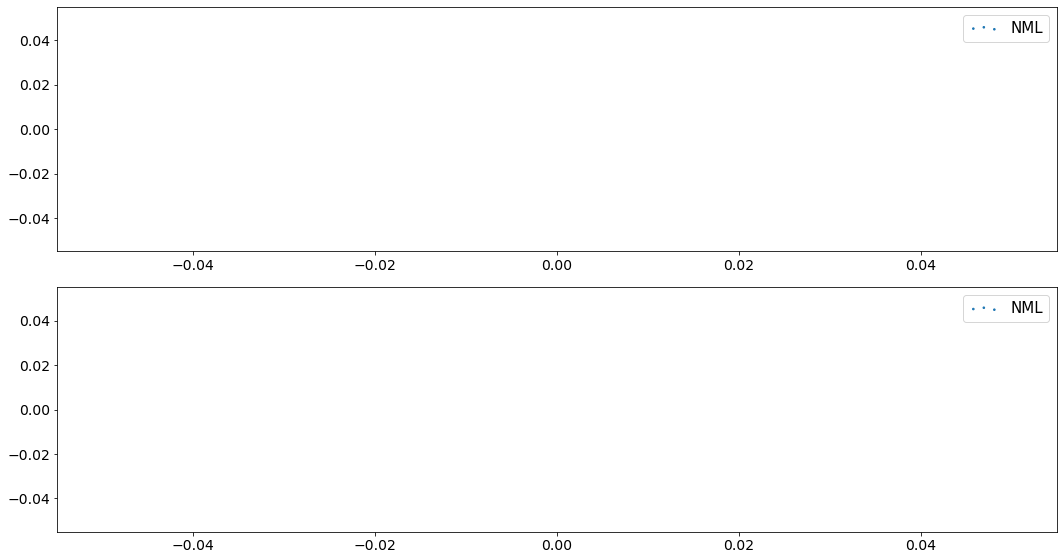

  Fault type Percentage
0        ABC     91.03%
1        ACG       5.5%
2        ABG      3.47%


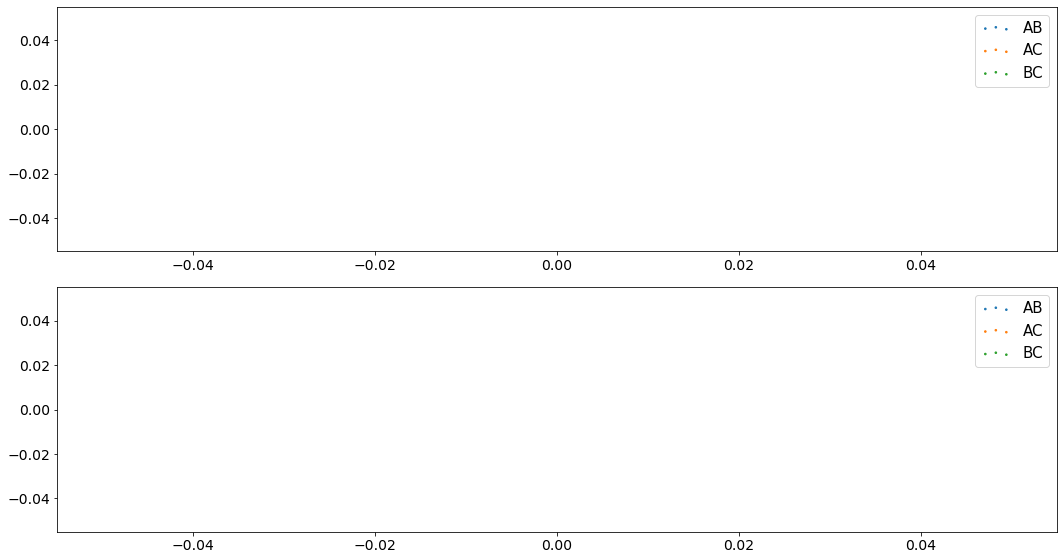


.
.
 3ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


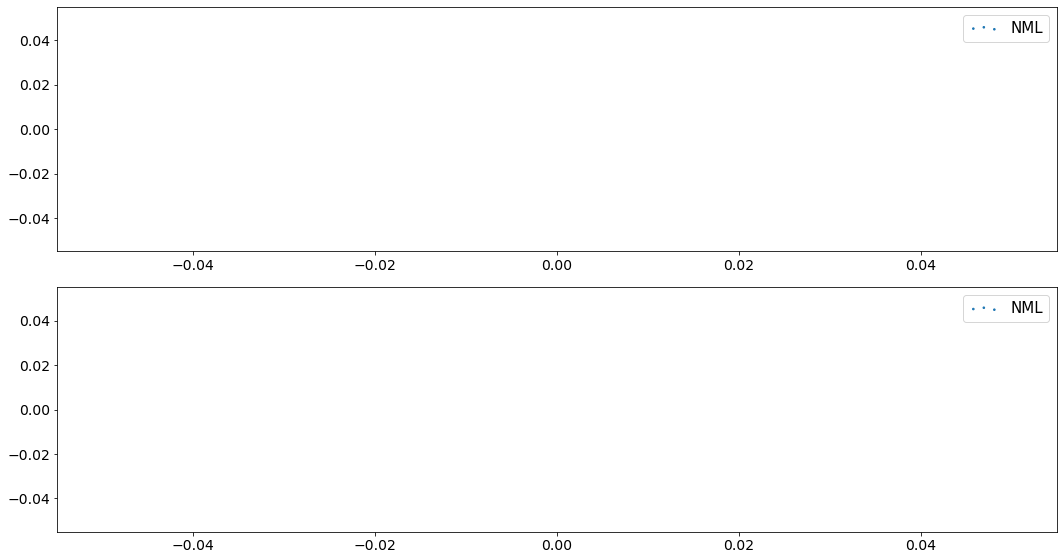

  Fault type Percentage
0        ABC     100.0%
1        ACG      0.01%


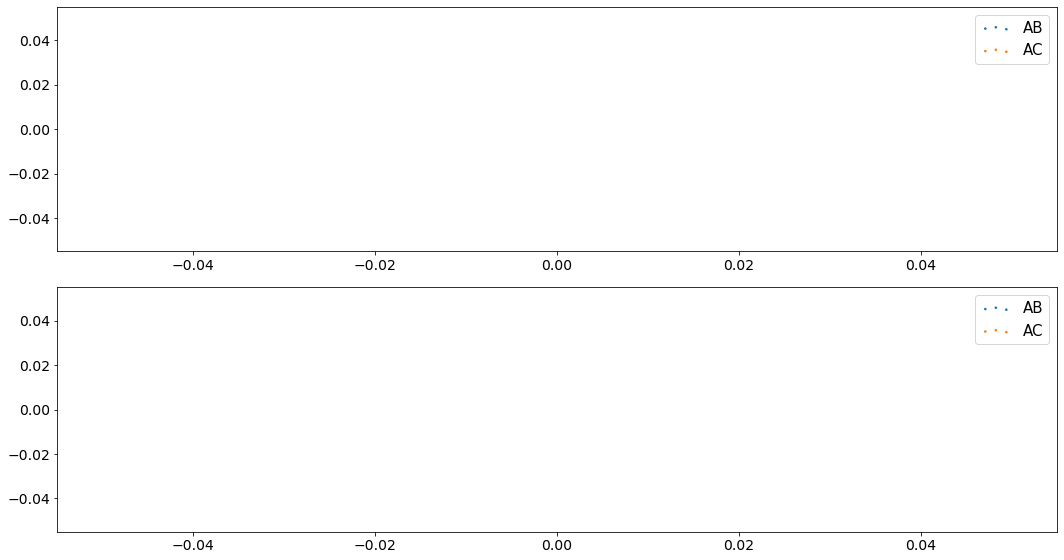


.
.
 2AC.csv
  Fault type Percentage
0      FAULT     100.0%


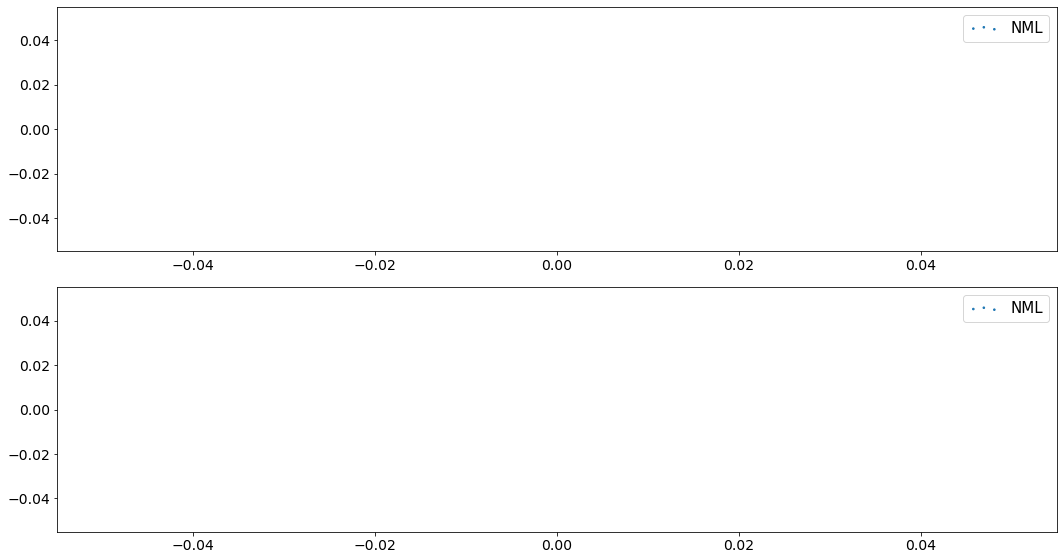

  Fault type Percentage
0        ABC     98.08%
1        ACG      1.92%


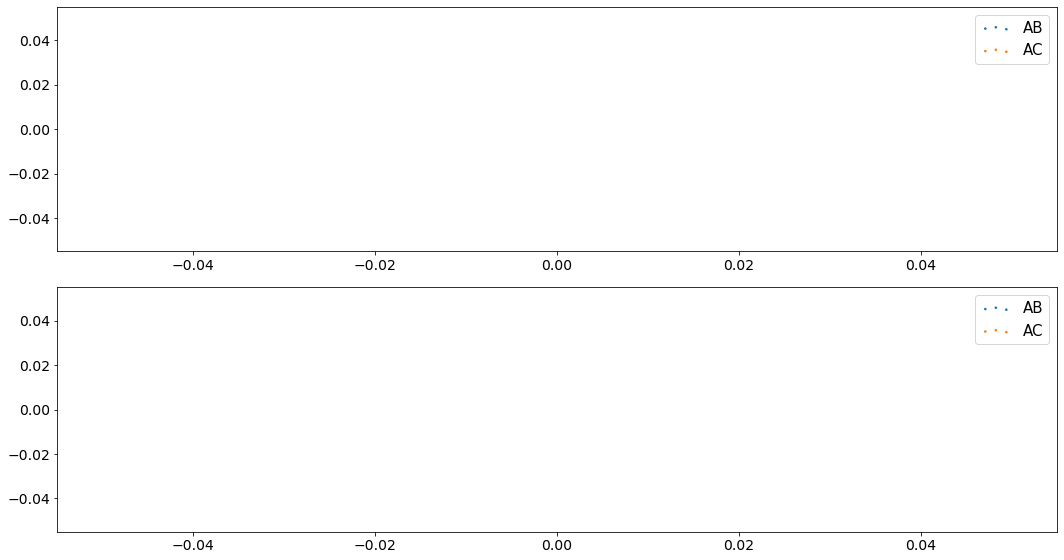


.
.
 4ACG.csv
  Fault type Percentage
0      FAULT     100.0%


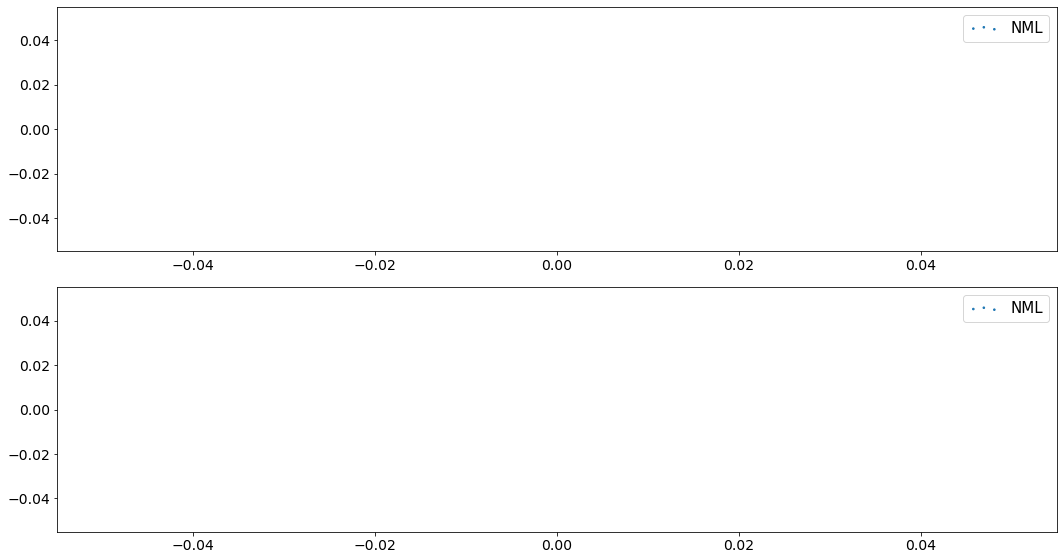

  Fault type Percentage
0        ABC     99.99%
1        ACG      0.01%


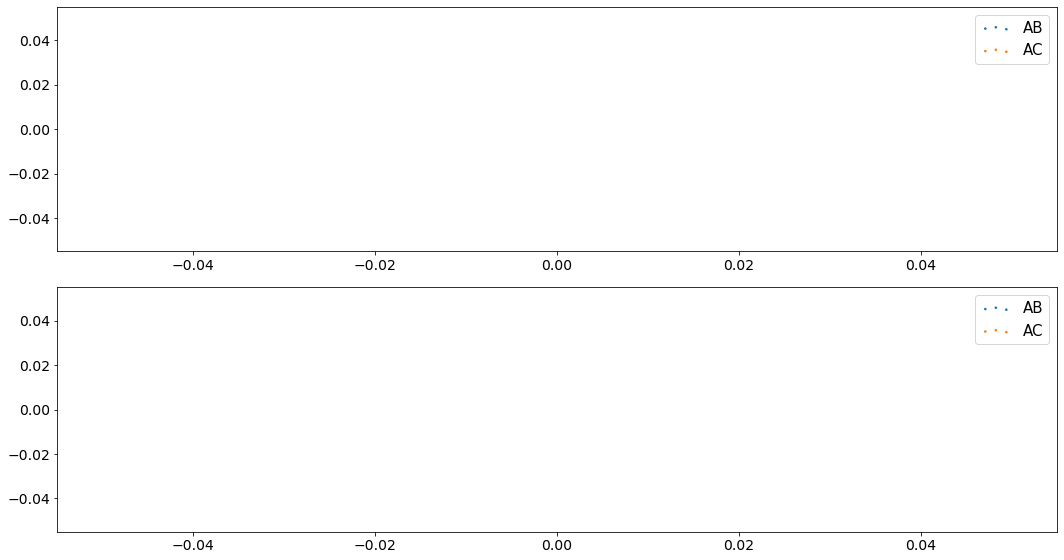


.
.
 4ABC.csv
  Fault type Percentage
0      FAULT     100.0%


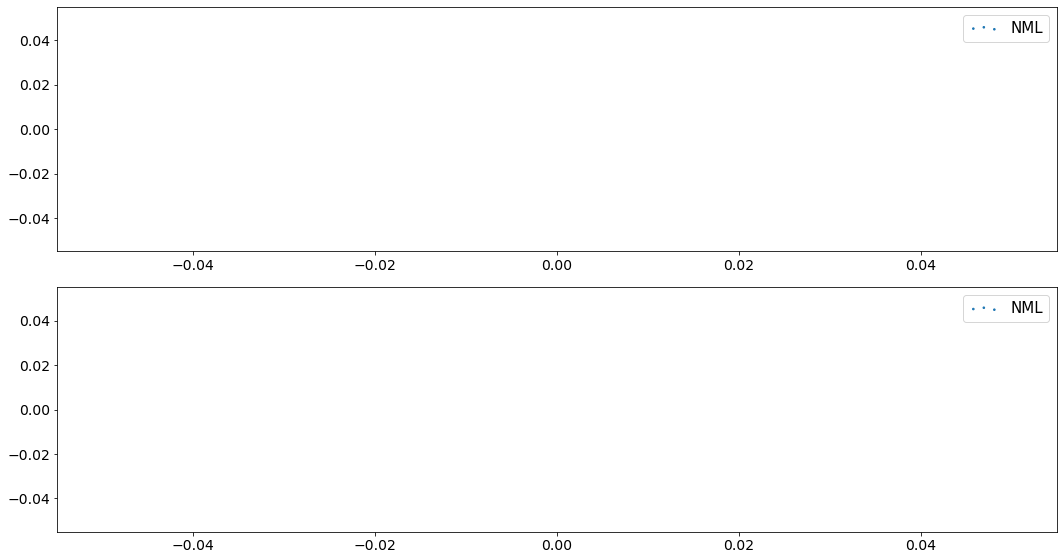

  Fault type Percentage
0        ABC     100.0%


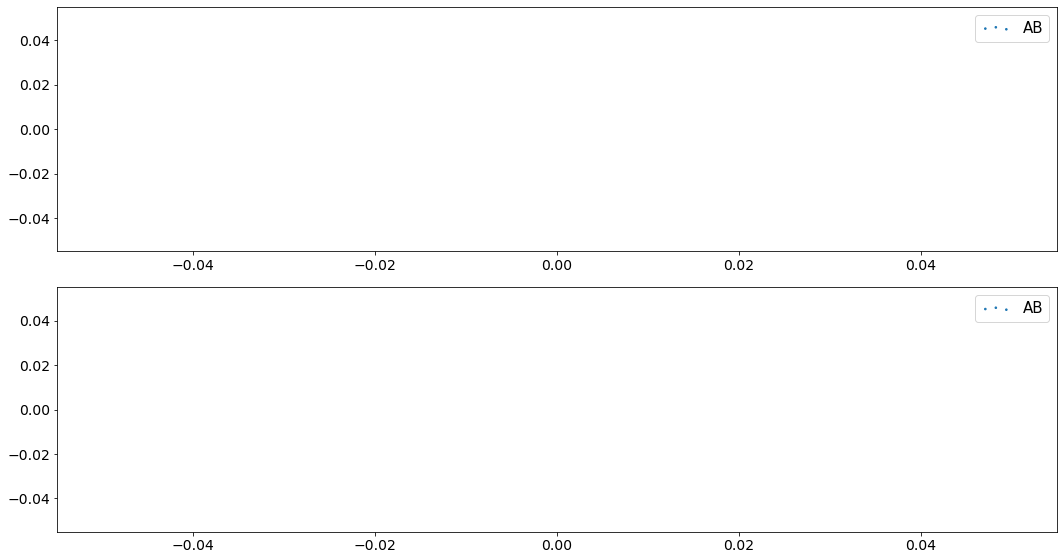


.
.
 8ABC.csv
  Fault type Percentage
0      FAULT     100.0%


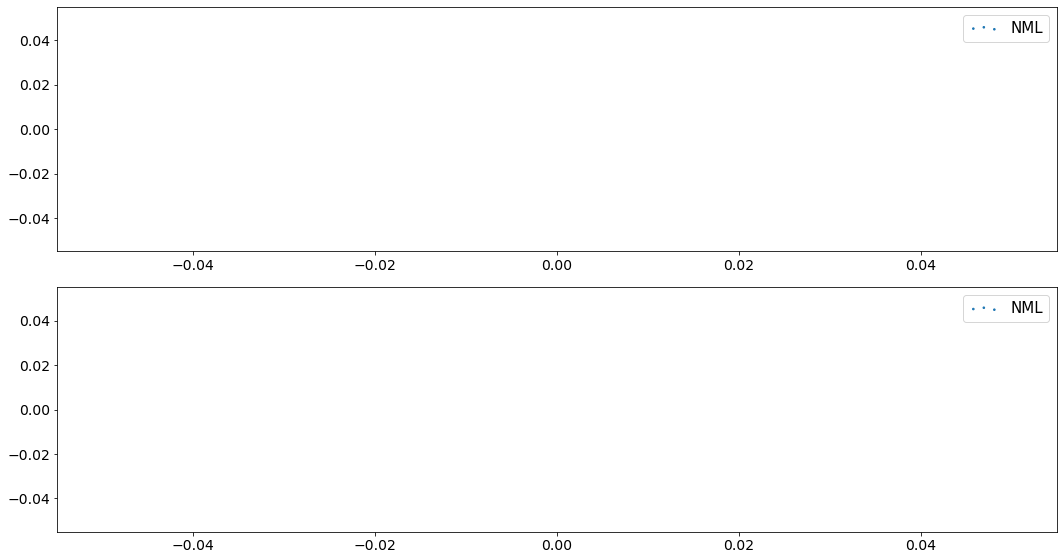

  Fault type Percentage
0        ABC     100.0%
1        ACG      0.01%


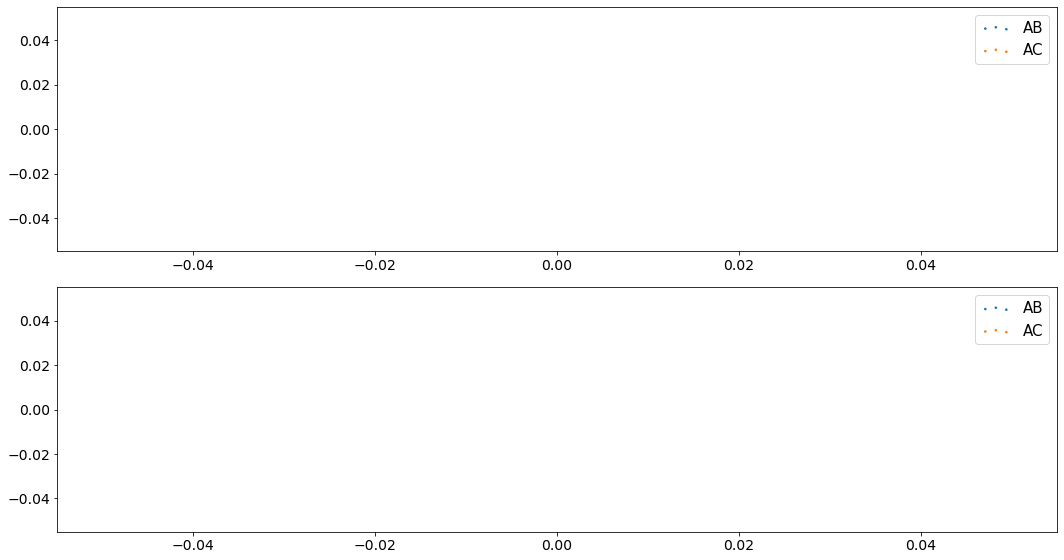


.
.
 8ACG.csv
  Fault type Percentage
0      FAULT     100.0%


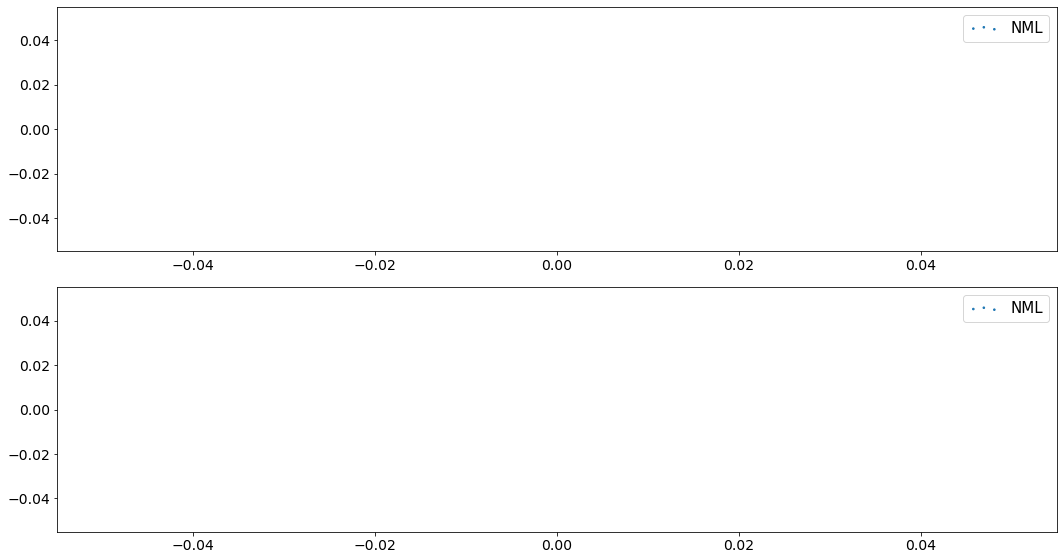

  Fault type Percentage
0        ABC     99.99%
1        ACG      0.01%


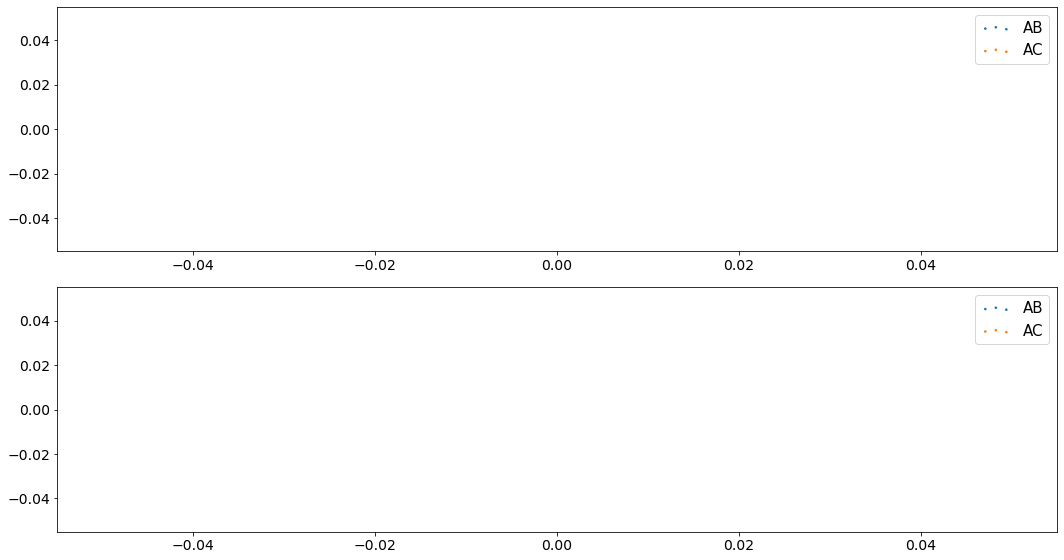


.
.
 4AG.csv
  Fault type Percentage
0      FAULT     100.0%


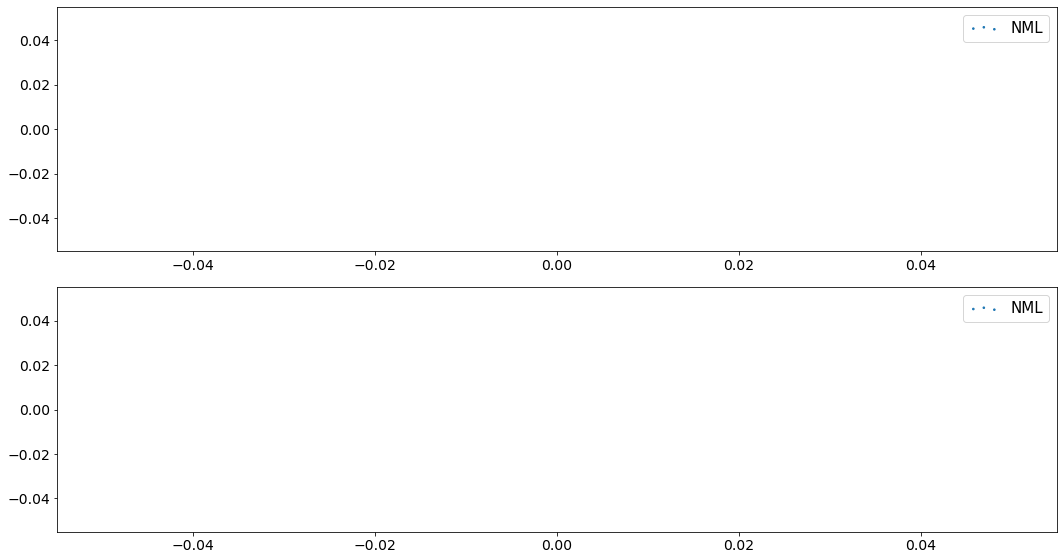

  Fault type Percentage
0        ABC     87.83%
1        ACG      7.04%
2        ABG      5.13%


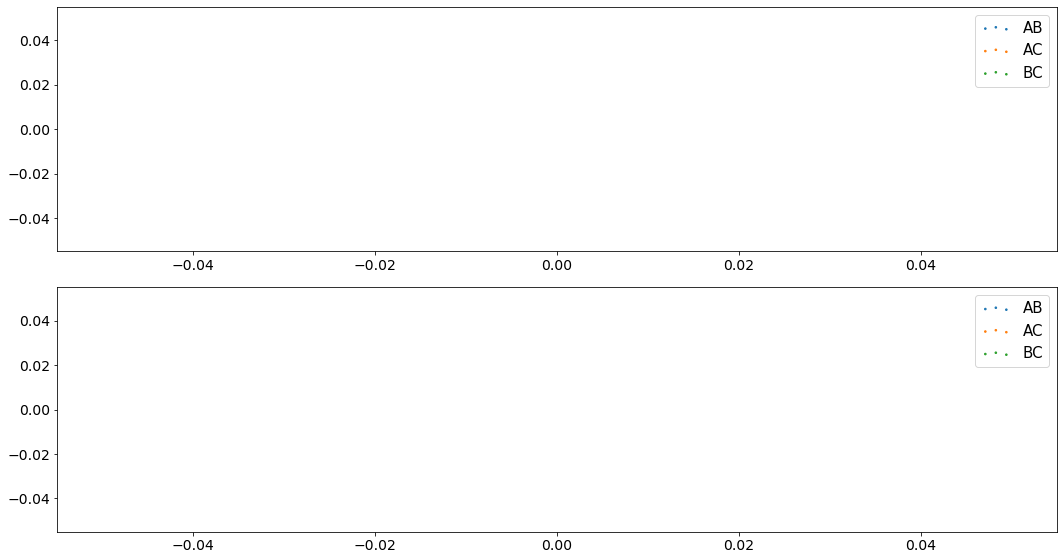


.
.
 6ABG.csv
  Fault type Percentage
0      FAULT     100.0%


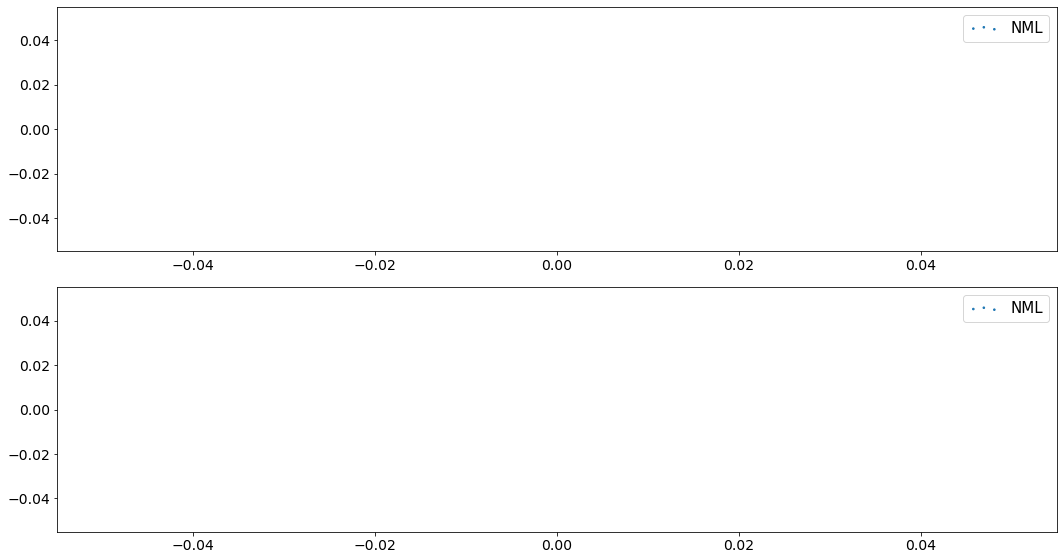

  Fault type Percentage
0        ABC     99.99%
1        ACG      0.01%


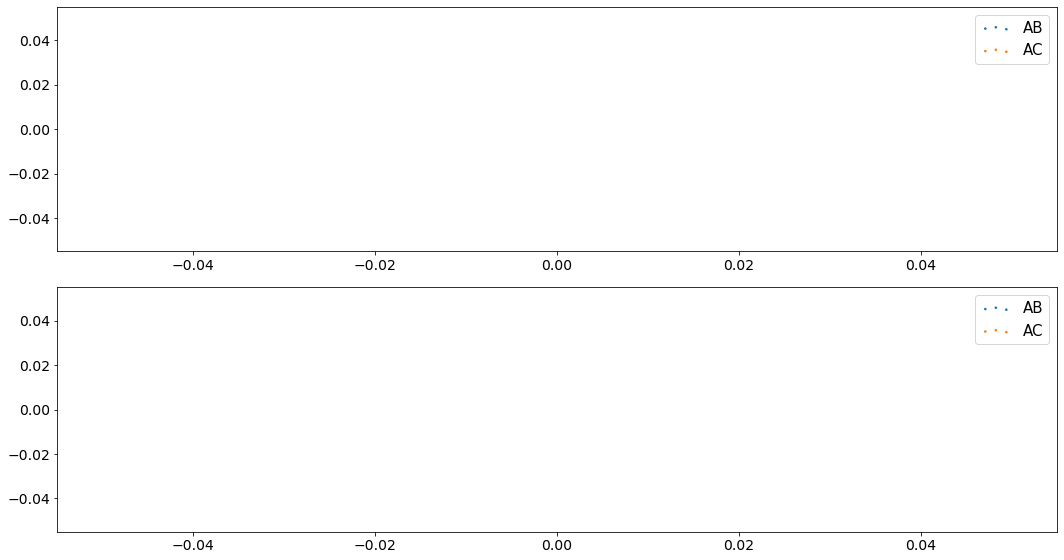


.
.
 8BG.csv
  Fault type Percentage
0      FAULT     100.0%


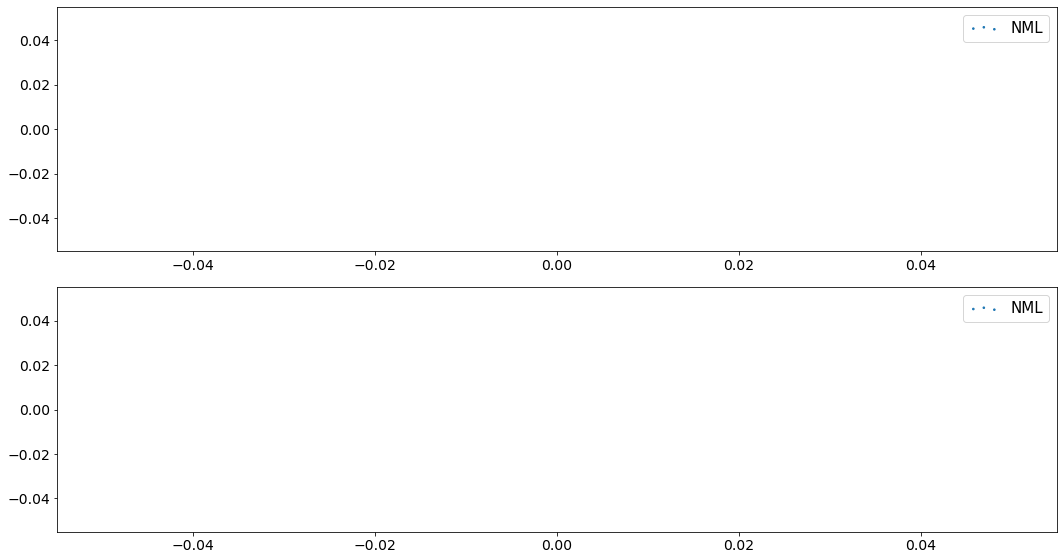

  Fault type Percentage
0        ABC     100.0%


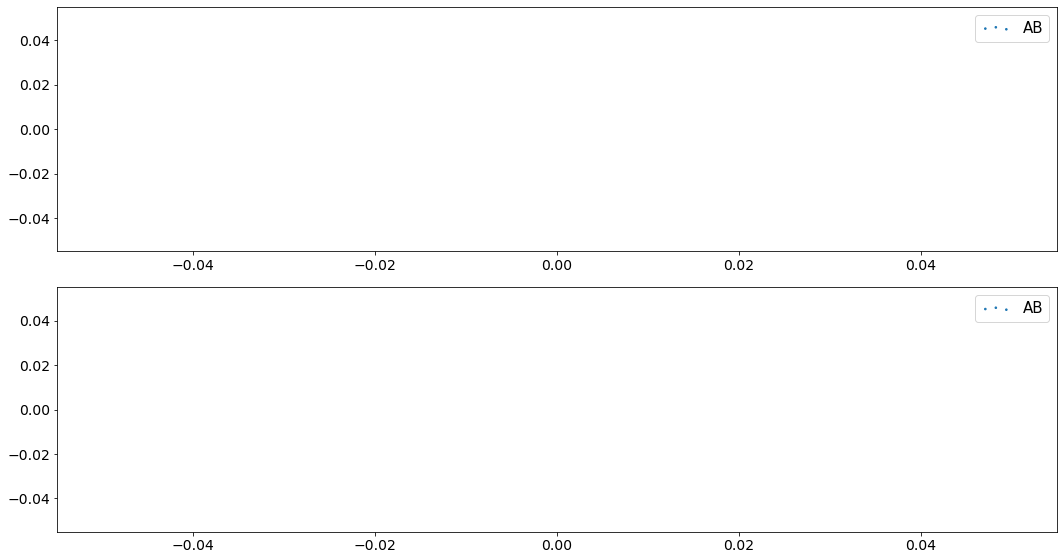


.
.
 7AC.csv
  Fault type Percentage
0      FAULT     100.0%


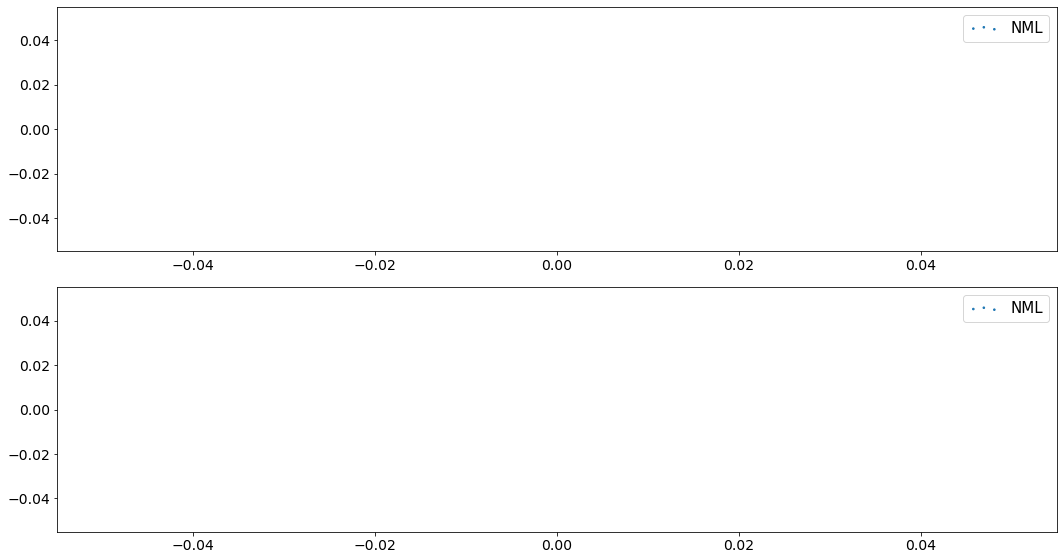

  Fault type Percentage
0        ABC     94.12%
1        ACG      5.88%


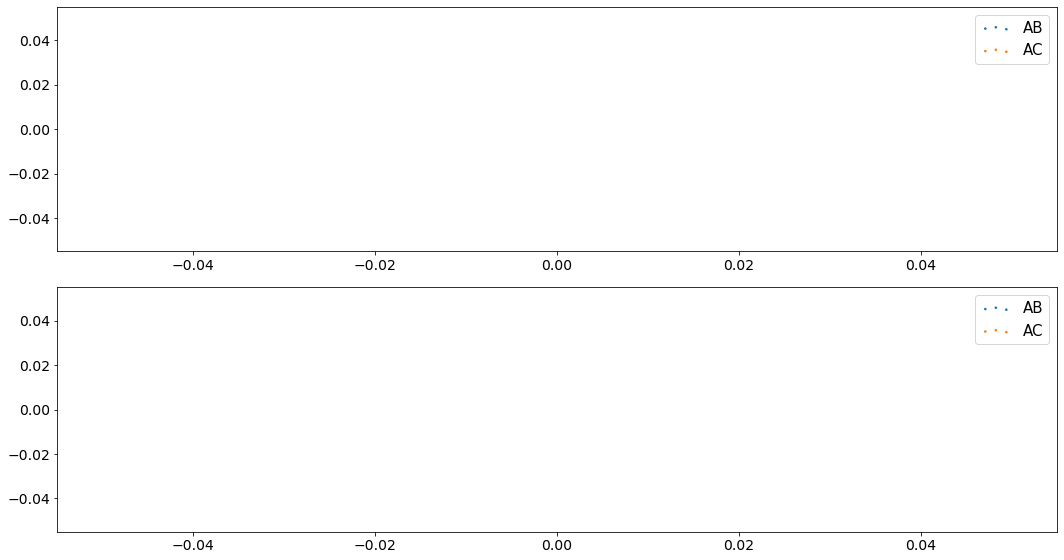


.
.
 3AG.csv
  Fault type Percentage
0      FAULT     100.0%


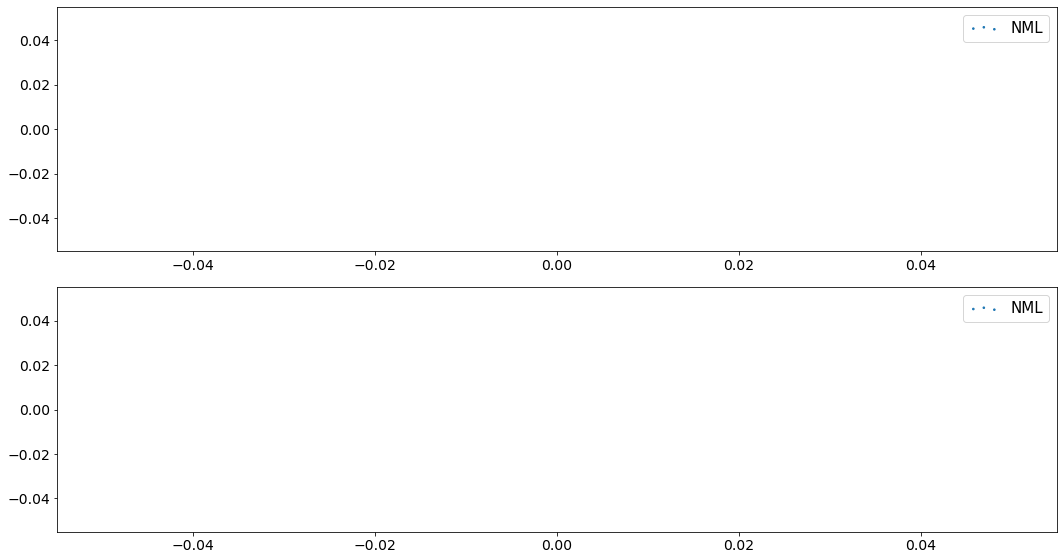

  Fault type Percentage
0        ABC     93.09%
1        ABG      3.57%
2        ACG      3.33%


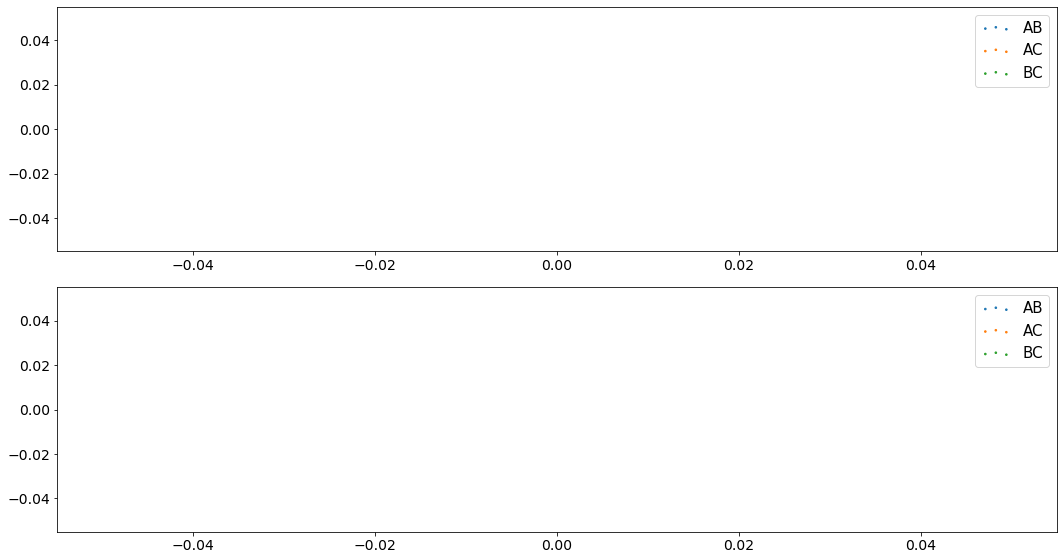


.
.
 1ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


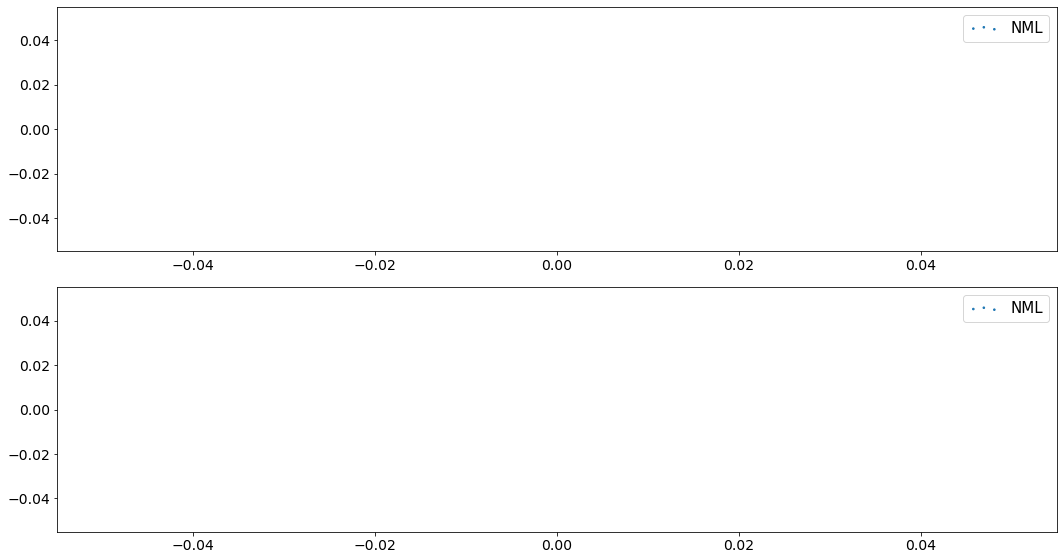

  Fault type Percentage
0        ABC     100.0%


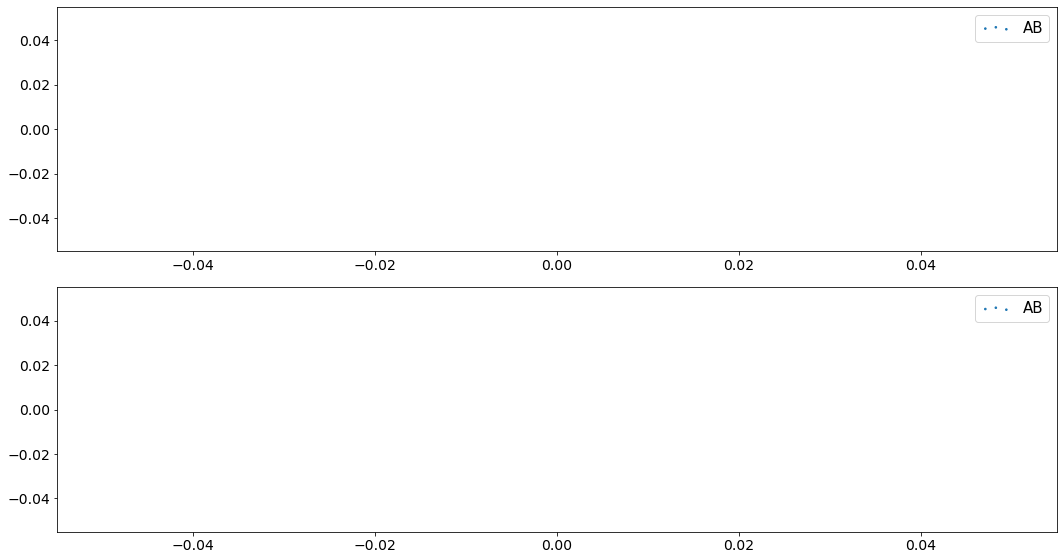


.
.
 7AB.csv
  Fault type Percentage
0      FAULT     100.0%


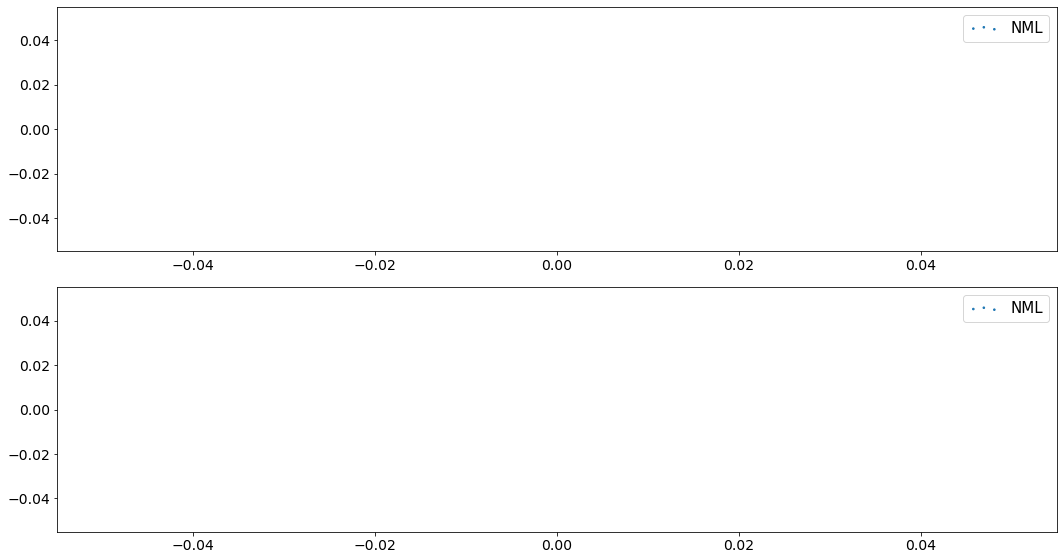

  Fault type Percentage
0        ABC     96.52%
1        ABG      3.48%


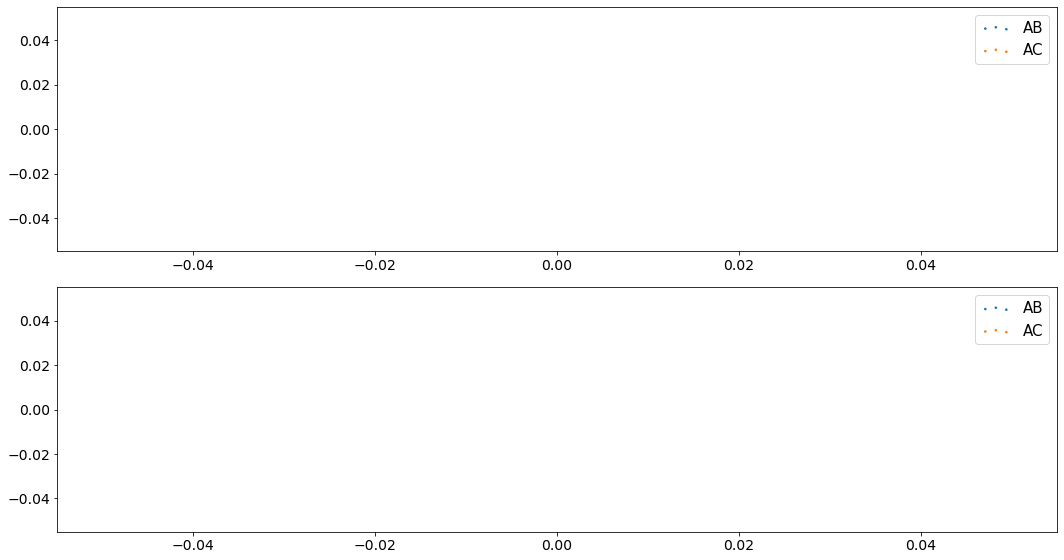


.
.
 6BCG.csv
  Fault type Percentage
0      FAULT     99.95%
1        NML      0.04%


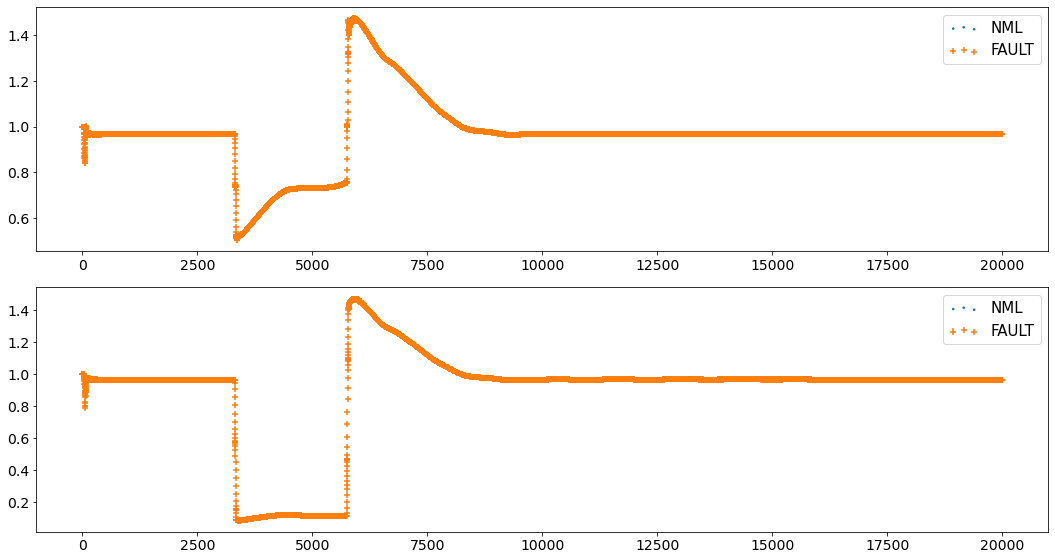

  Fault type Percentage
0        ABC     99.96%
1        BCG      0.04%


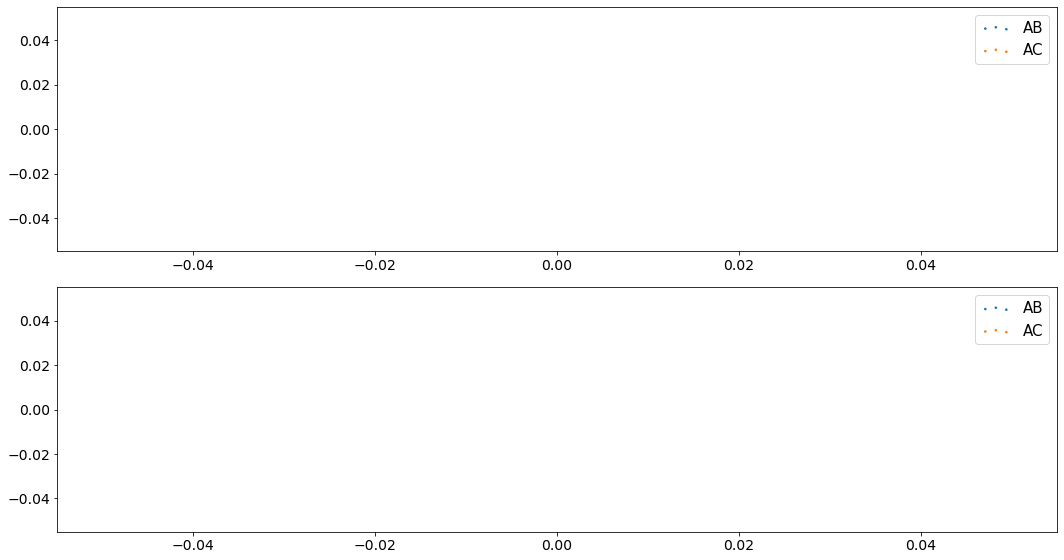


.
.
 5AB.csv
  Fault type Percentage
0      FAULT     100.0%


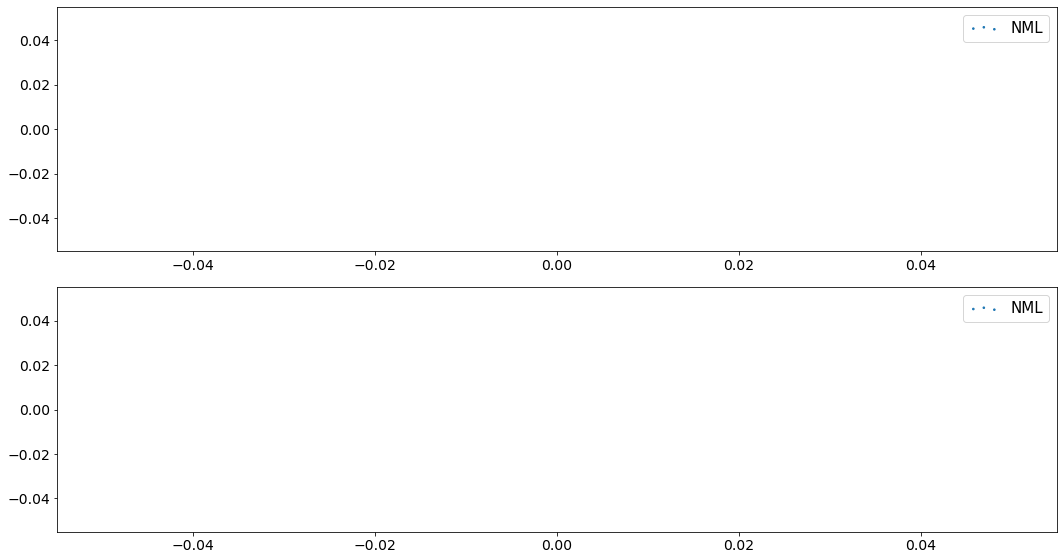

  Fault type Percentage
0        ABC     100.0%


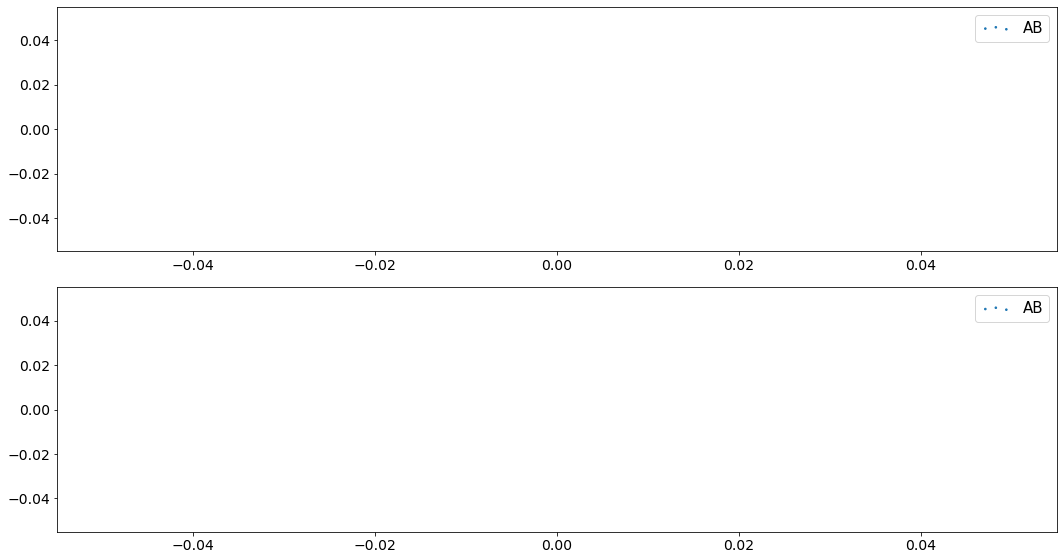


.
.
 9CG.csv
  Fault type Percentage
0      FAULT     100.0%


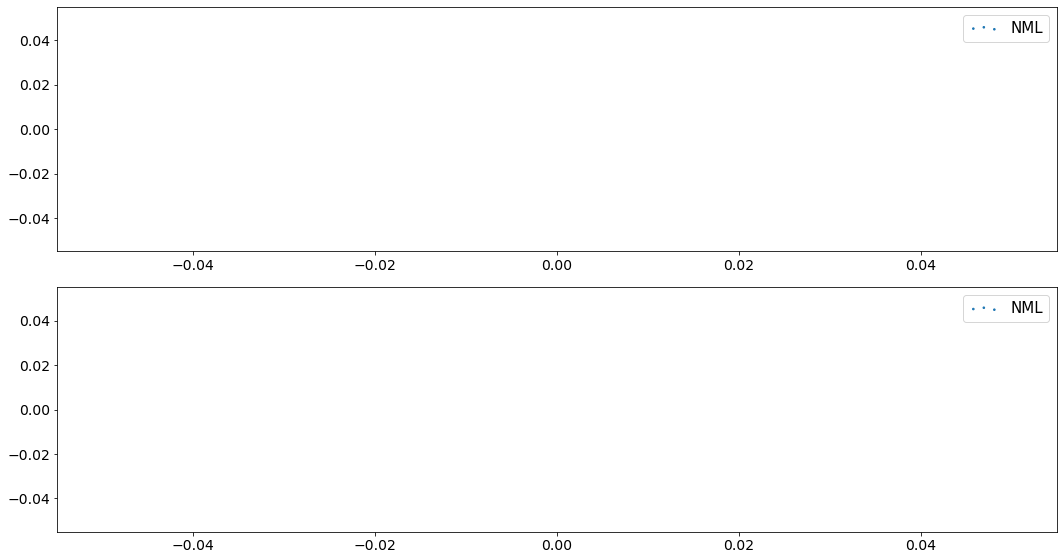

  Fault type Percentage
0        ABC     74.06%
1        ACG     25.93%


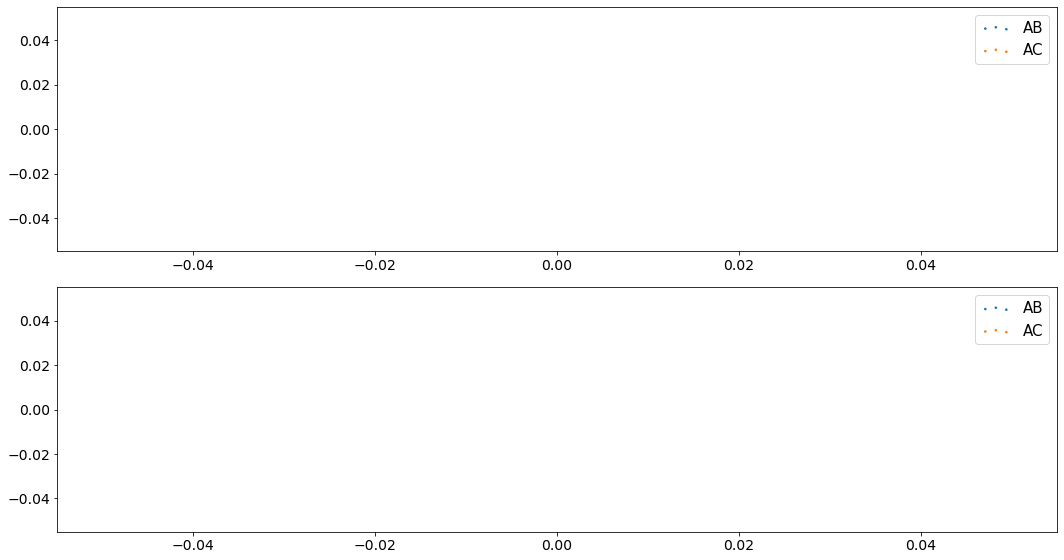


.
.
 9BC.csv
  Fault type Percentage
0      FAULT     100.0%


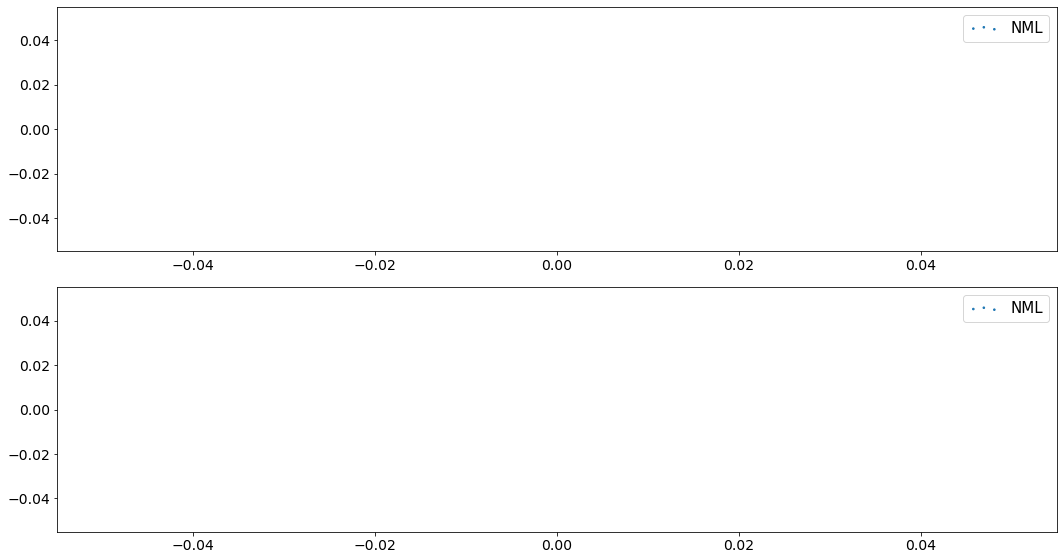

  Fault type Percentage
0        ABC     99.97%
1        BCG      0.03%


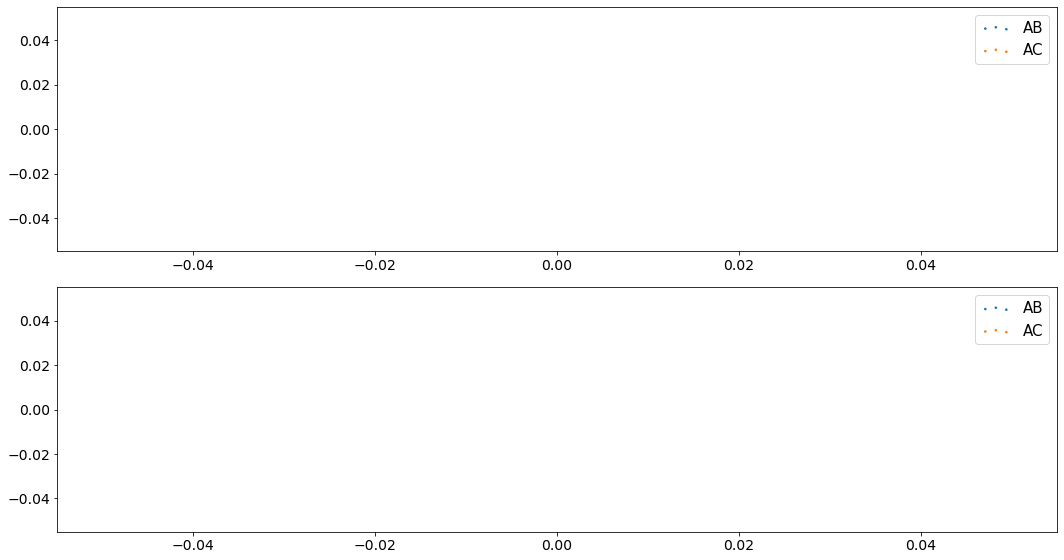


.
.
 2ABG.csv
  Fault type Percentage
0      FAULT     100.0%


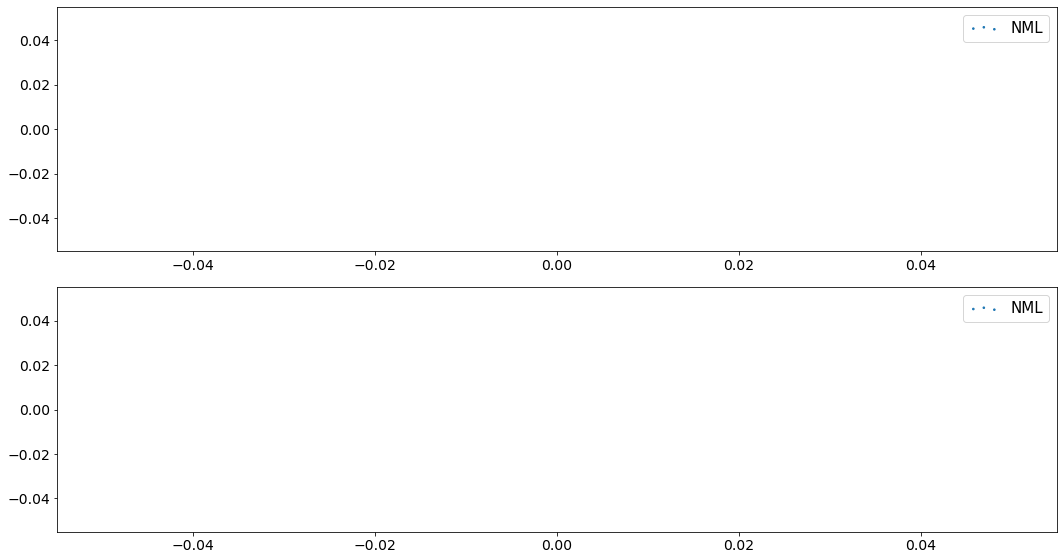

  Fault type Percentage
0        ABC     100.0%


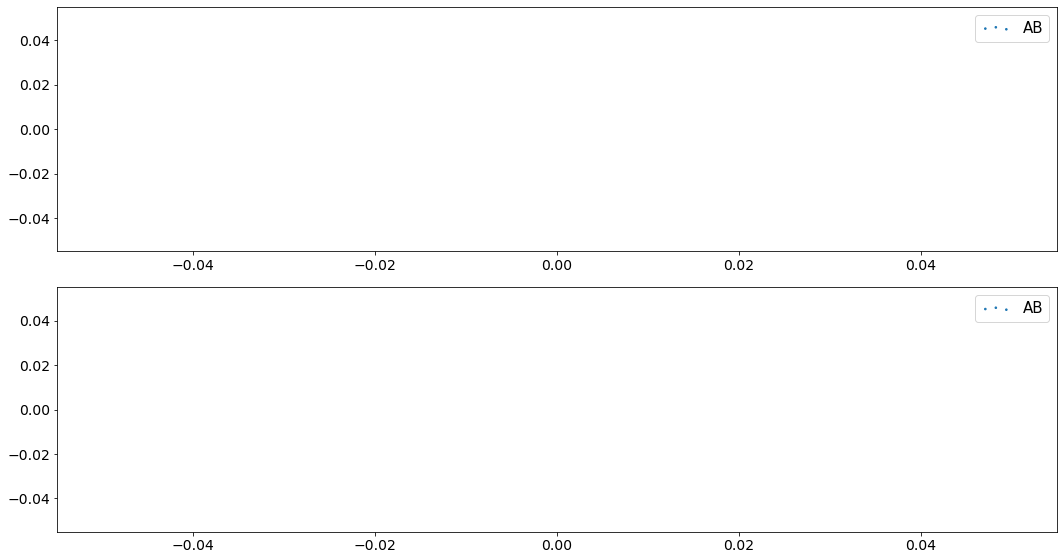


.
.
 1AG.csv
  Fault type Percentage
0      FAULT     100.0%


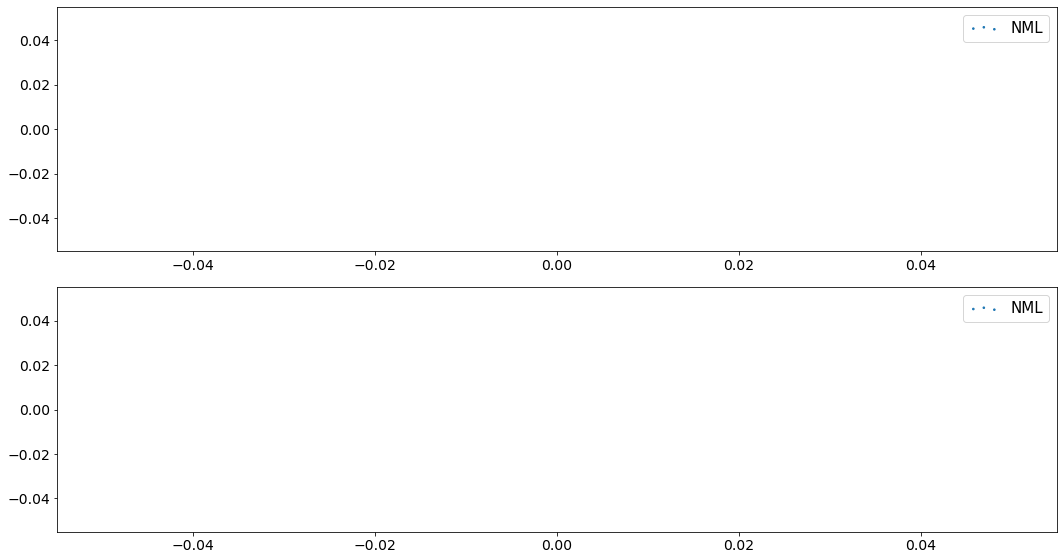

  Fault type Percentage
0        ABC     91.36%
1        ACG      5.12%
2        ABG      3.52%


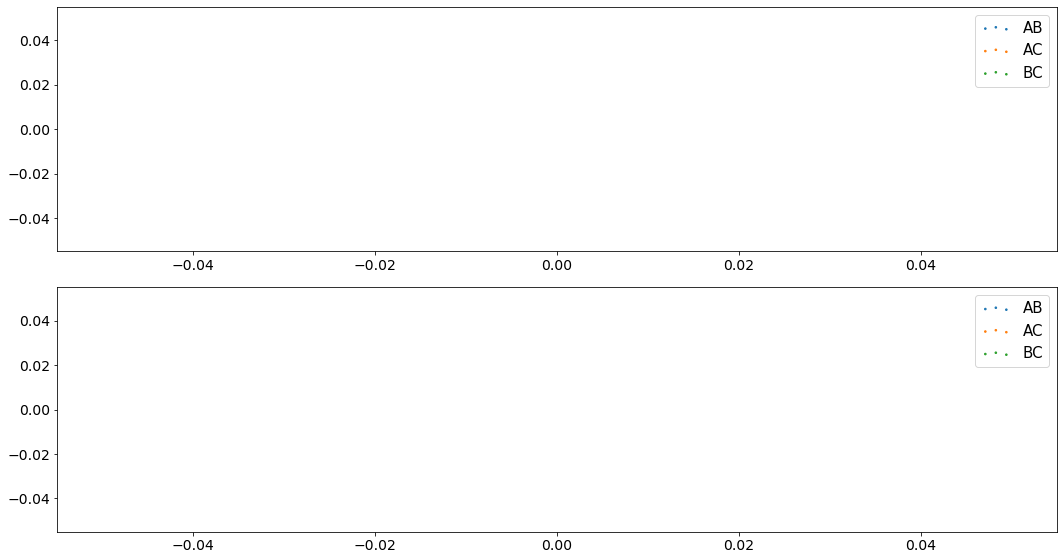


.
.
 8ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


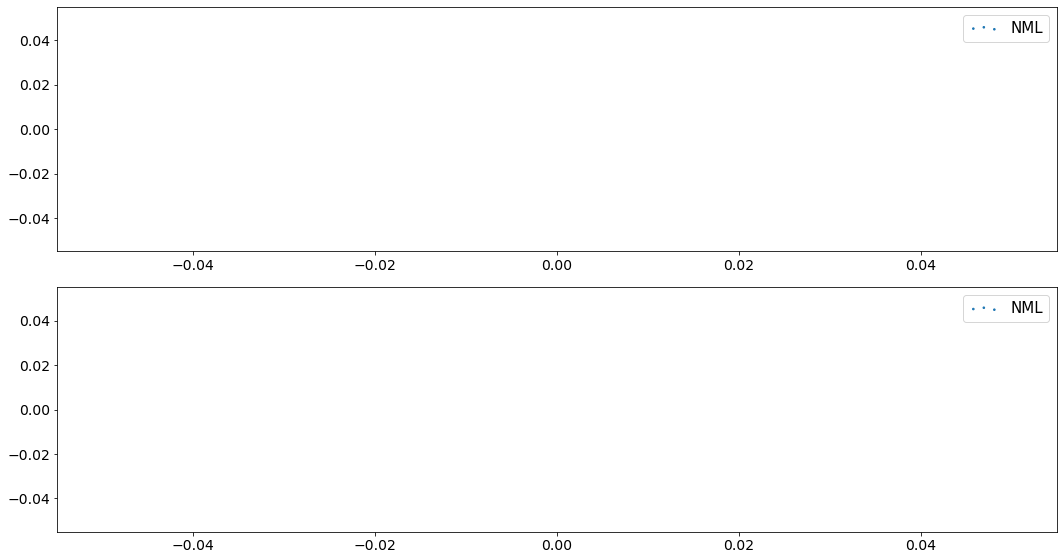

  Fault type Percentage
0        ABC     100.0%


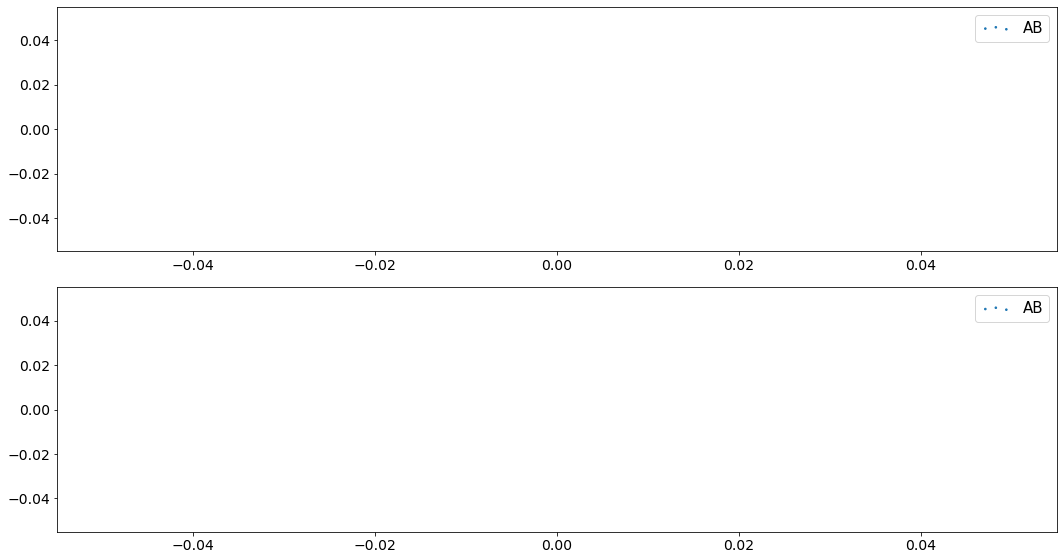


.
.
 5AC.csv
  Fault type Percentage
0      FAULT     100.0%


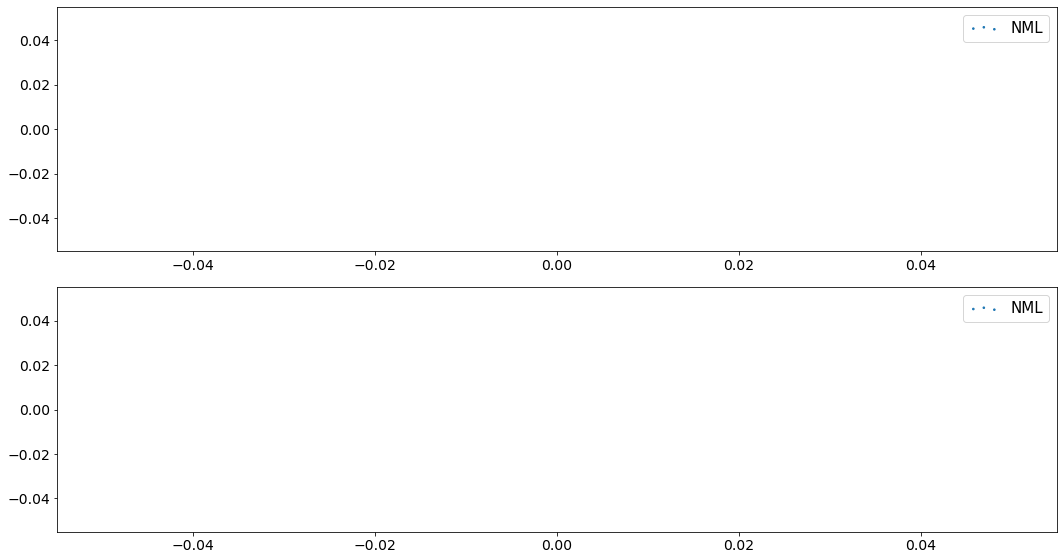

  Fault type Percentage
0        ABC     97.53%
1        ACG      2.47%


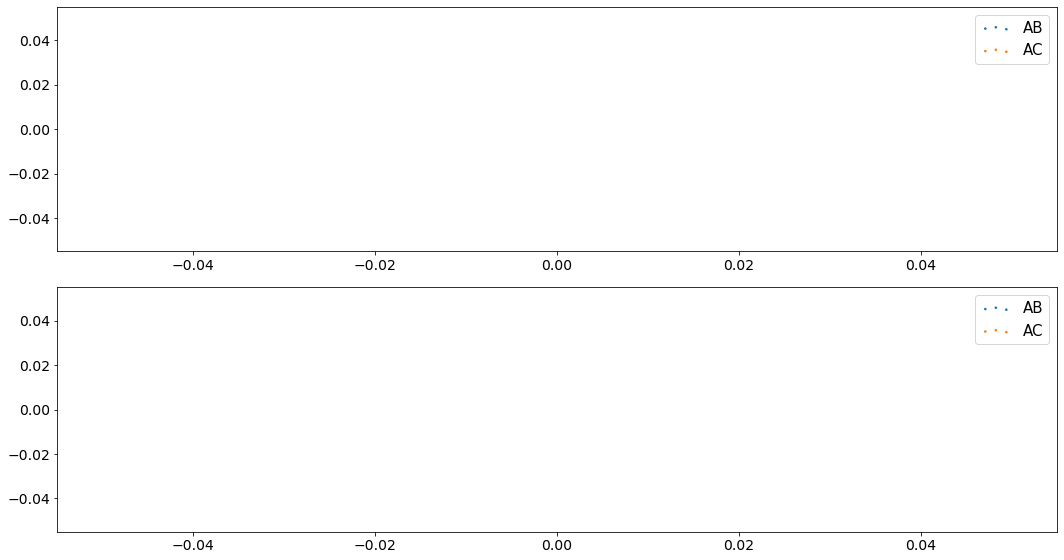


.
.
 5AG.csv
  Fault type Percentage
0      FAULT     100.0%


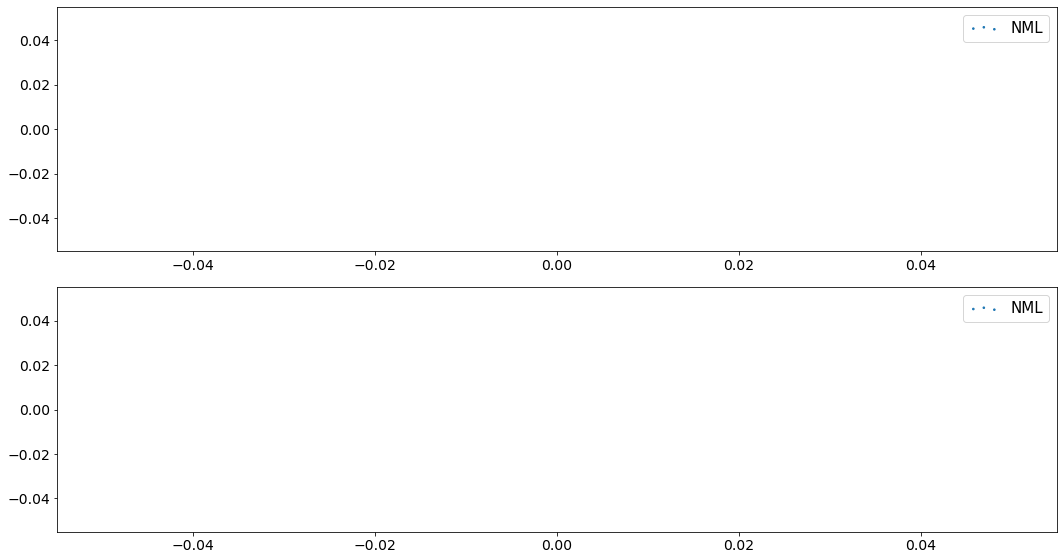

  Fault type Percentage
0        ABC     92.27%
1        ACG      4.16%
2        ABG      3.58%


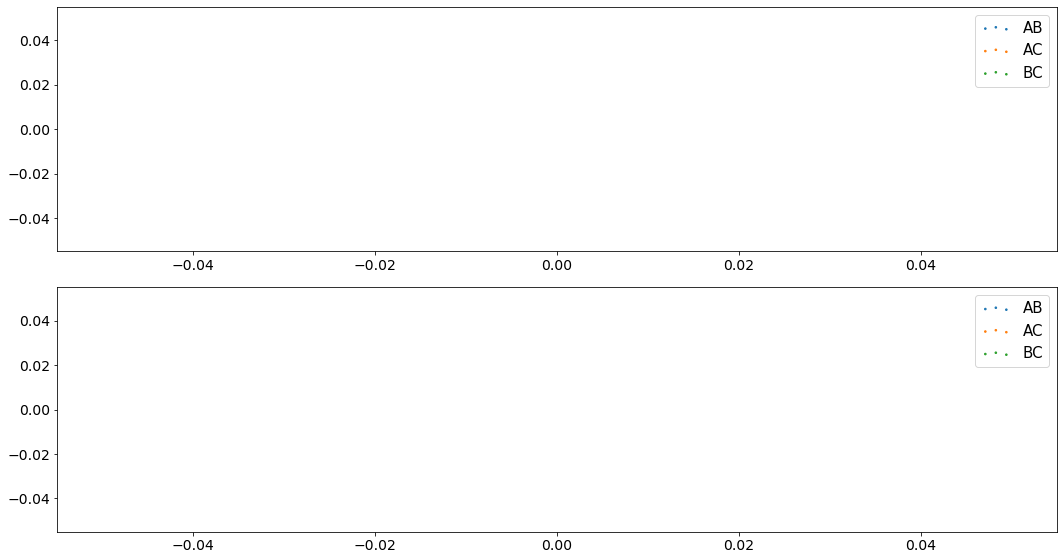


.
.
 1AC.csv
  Fault type Percentage
0      FAULT     100.0%


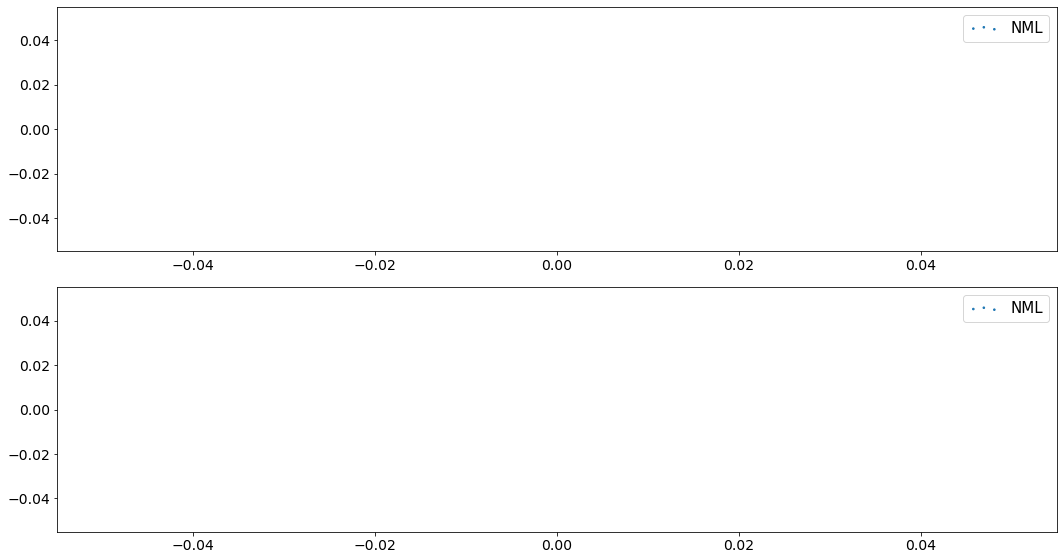

  Fault type Percentage
0        ABC     68.73%
1        ACG     31.27%


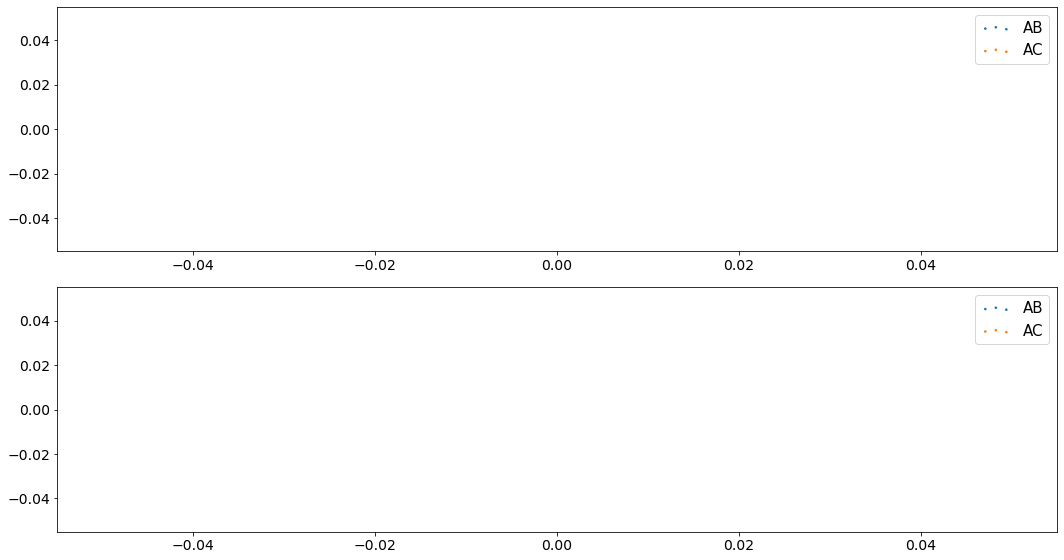


.
.
 2ACG.csv
  Fault type Percentage
0      FAULT     100.0%


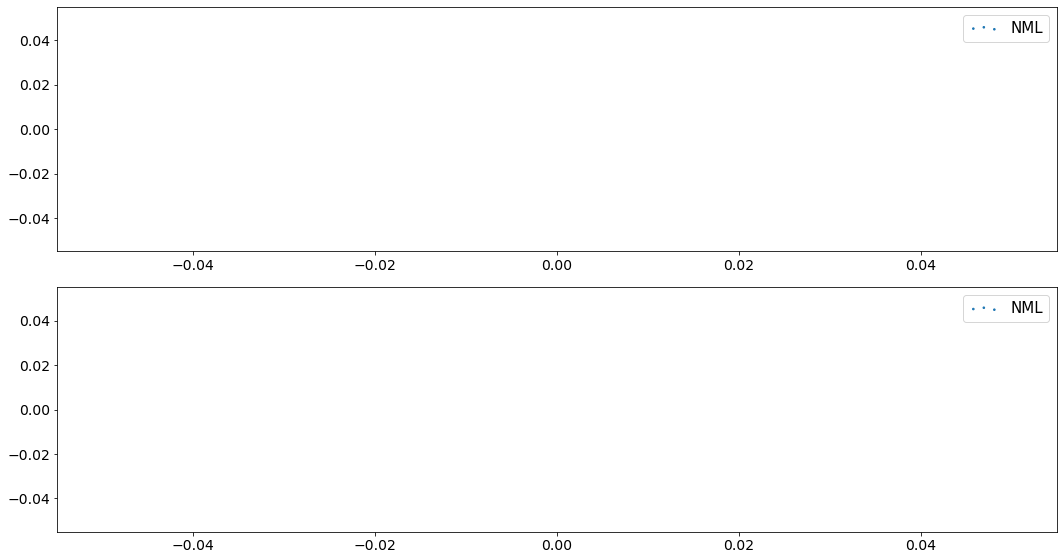

  Fault type Percentage
0        ABC      99.9%
1        ACG       0.1%
2        ABG      0.01%


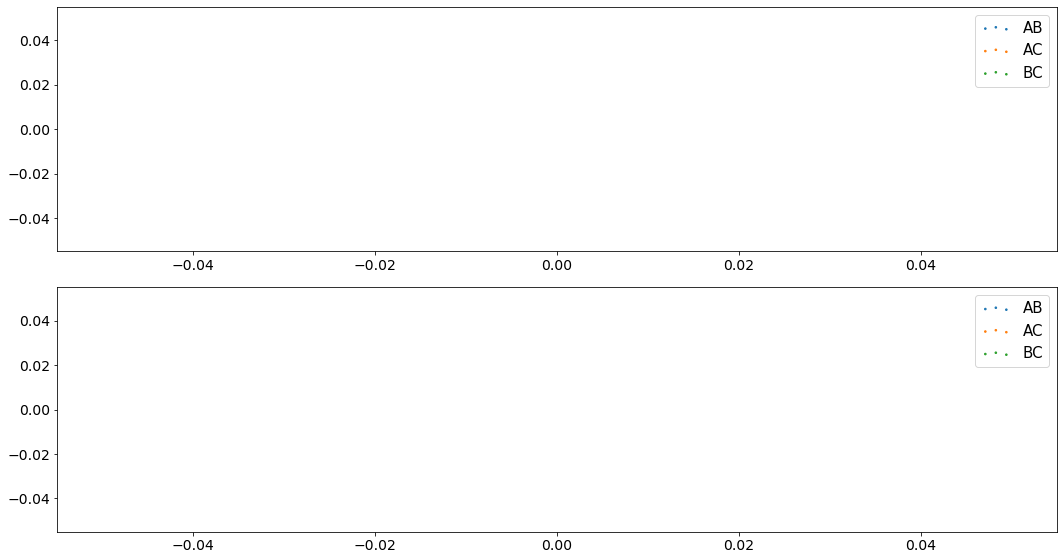


.
.
 1AB.csv
  Fault type Percentage
0      FAULT     100.0%


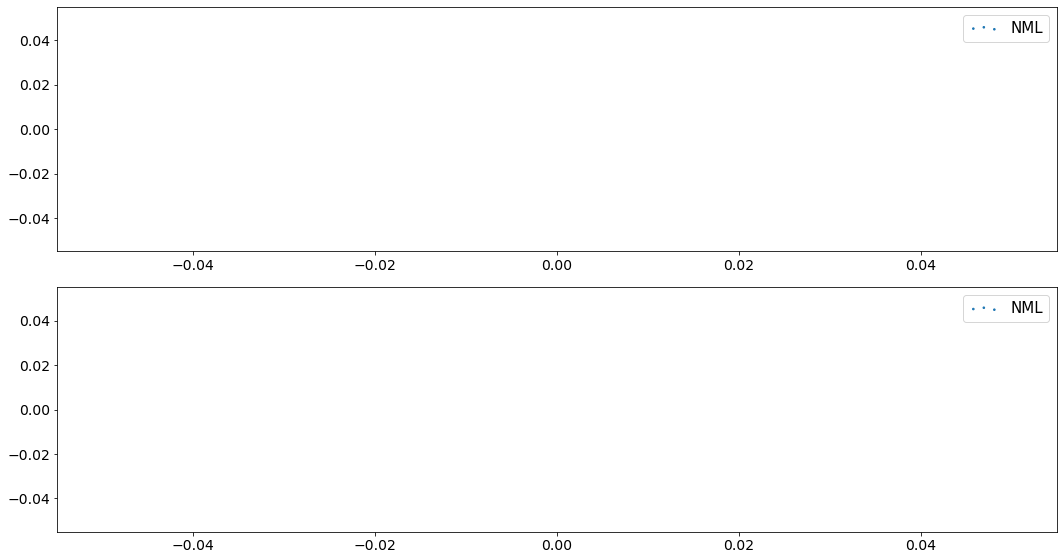

  Fault type Percentage
0        ABC     95.67%
1        ABG      4.32%
2        ACG      0.01%


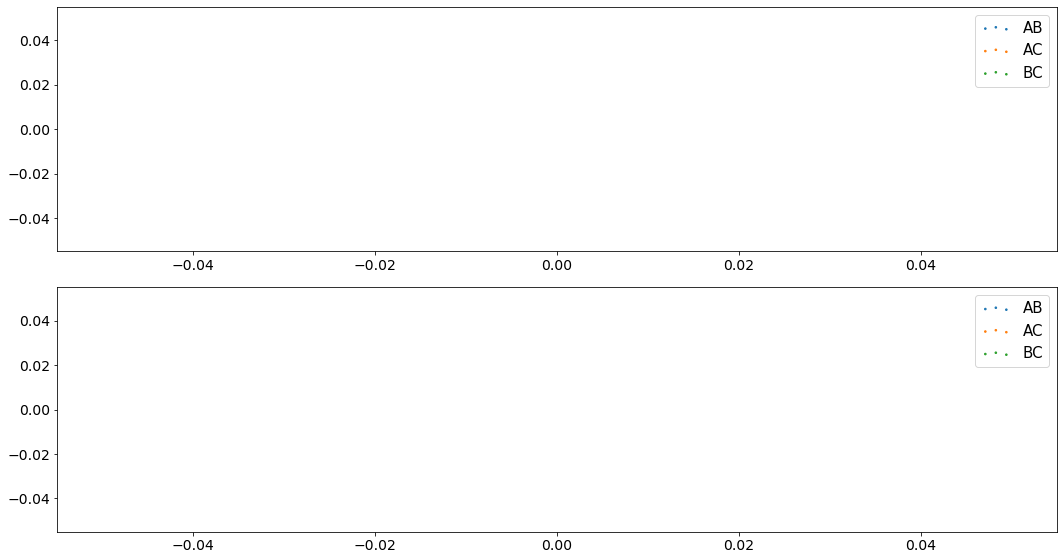


.
.
 2ABC.csv
  Fault type Percentage
0      FAULT     100.0%


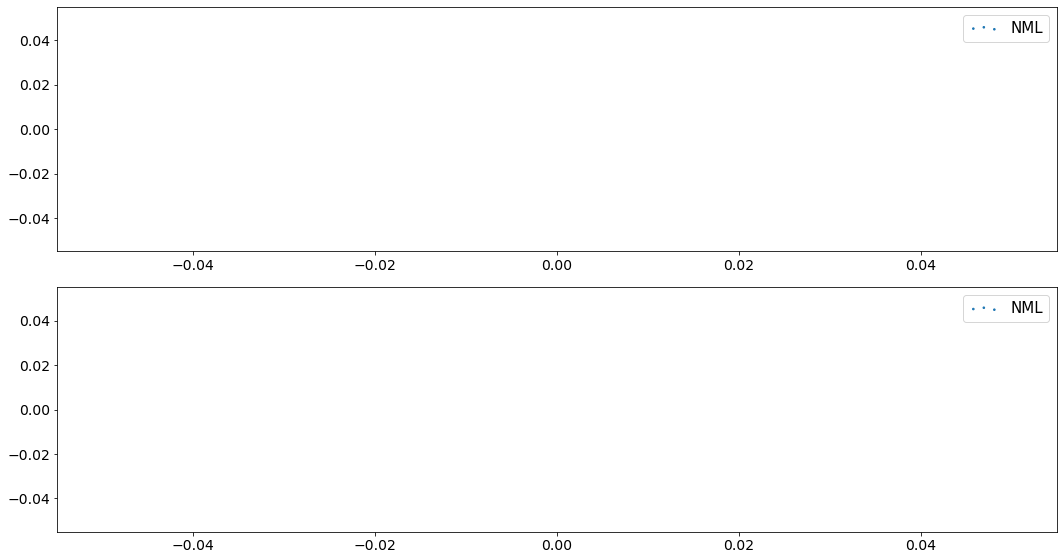

  Fault type Percentage
0        ABC     100.0%


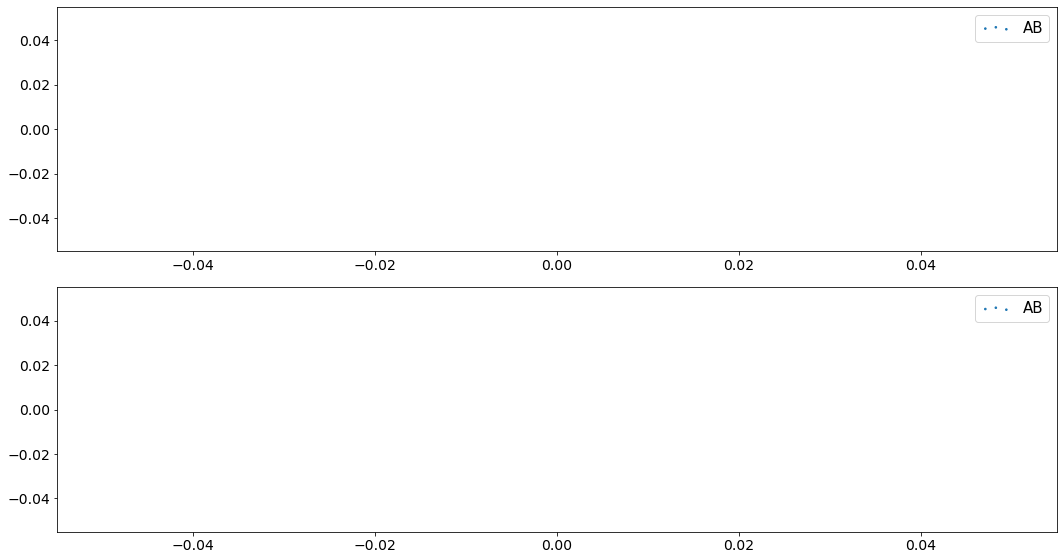


.
.
 9BG.csv
  Fault type Percentage
0      FAULT     100.0%


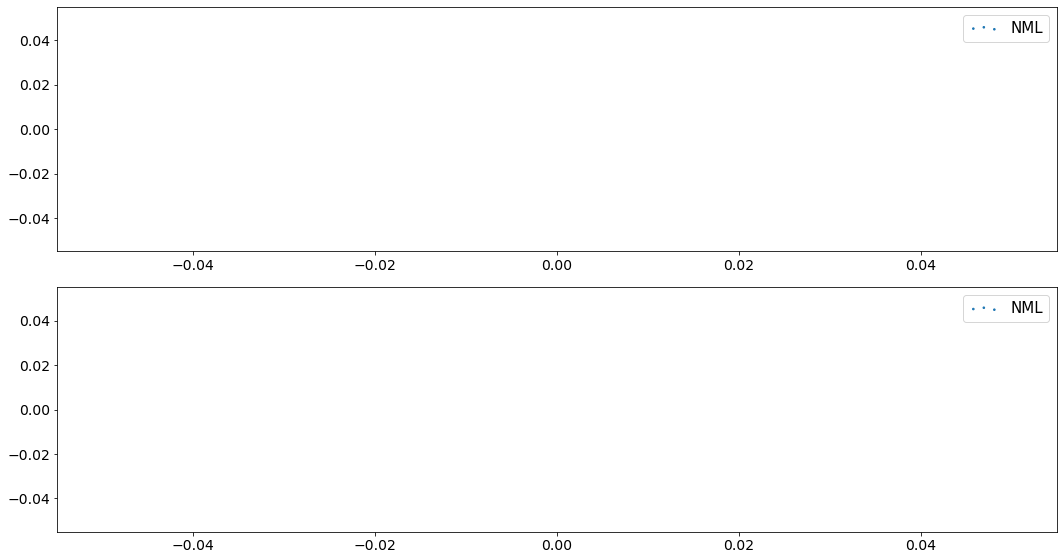

  Fault type Percentage
0        ABC     100.0%


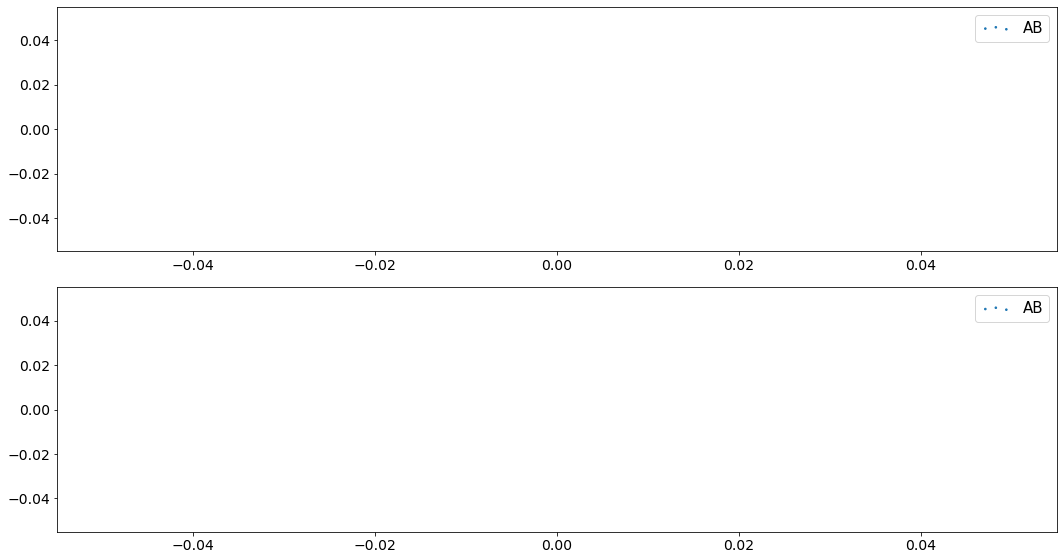


.
.
 9ABCG.csv
  Fault type Percentage
0      FAULT     100.0%


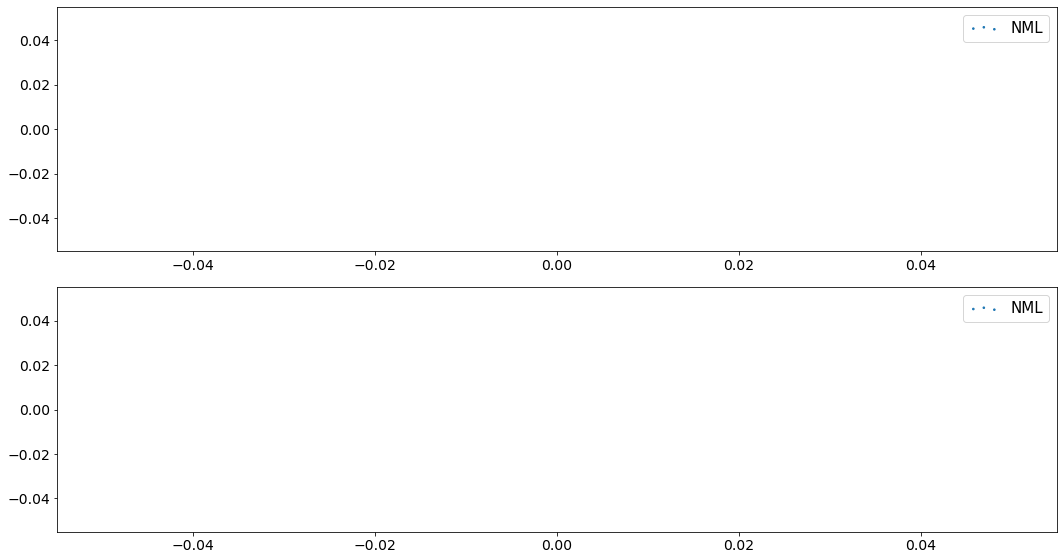

  Fault type Percentage
0        ABC     100.0%


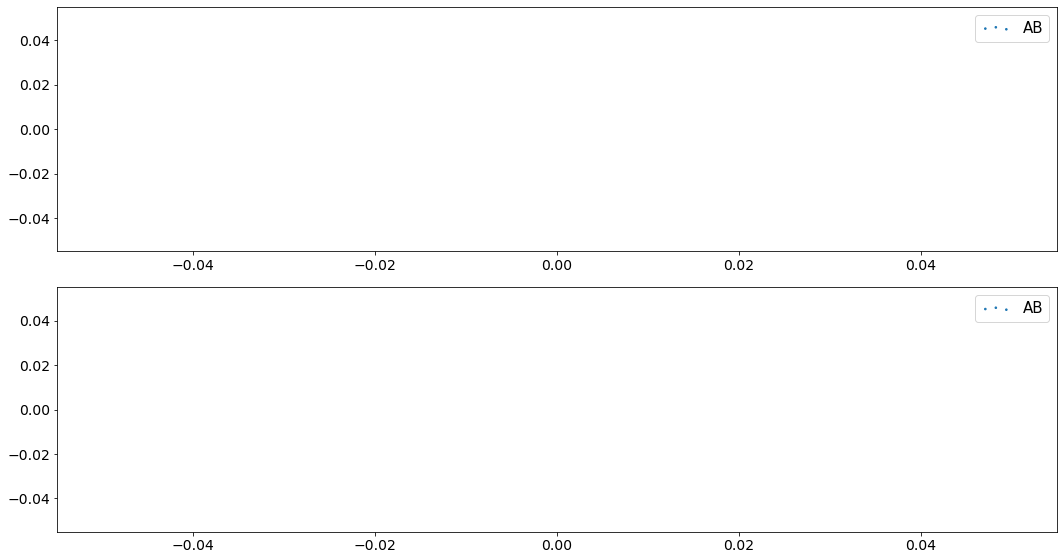


.
.
 3AB.csv
  Fault type Percentage
0      FAULT     100.0%


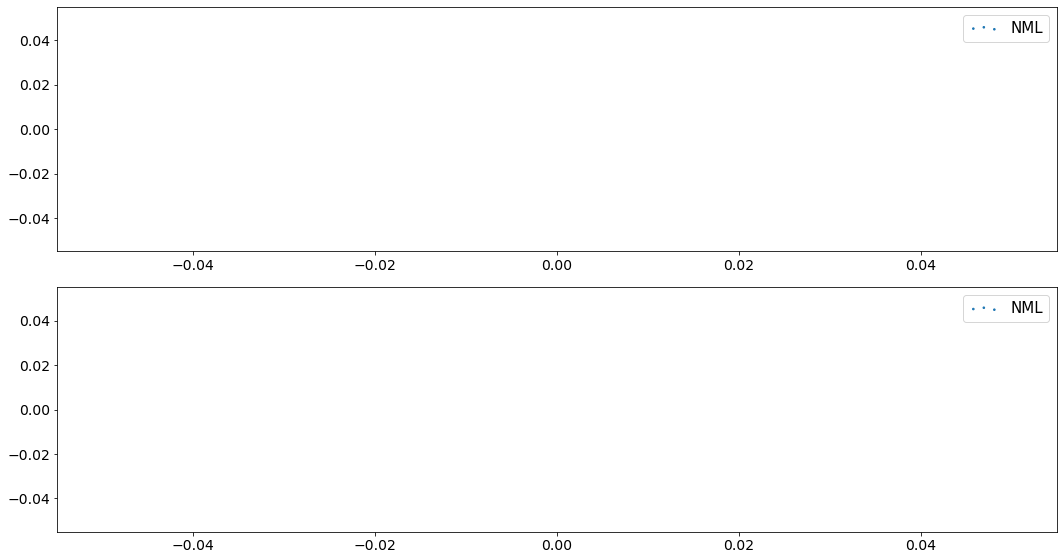

  Fault type Percentage
0        ABC     97.42%
1        ABG      2.58%


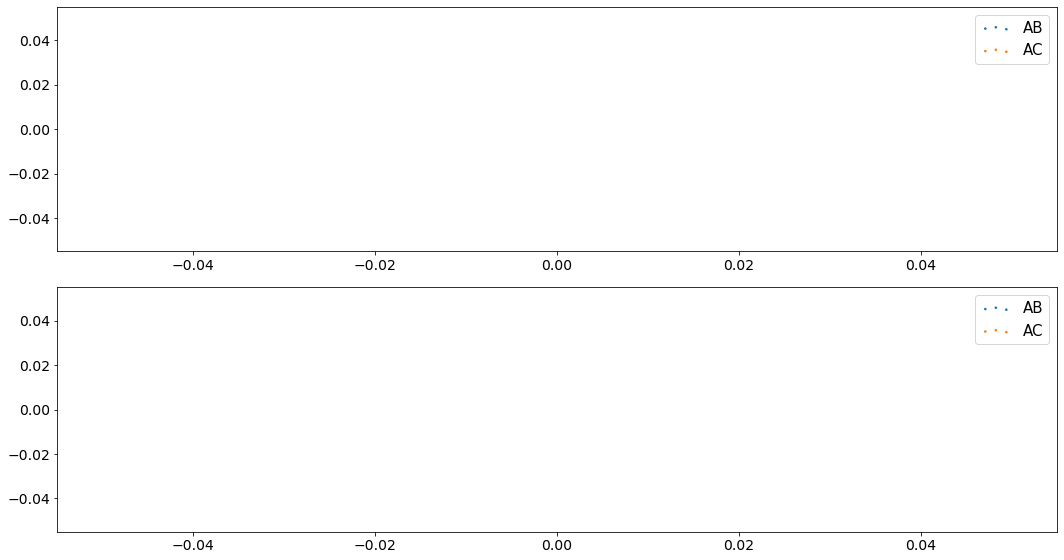


.
.
 3AC.csv
  Fault type Percentage
0      FAULT     100.0%


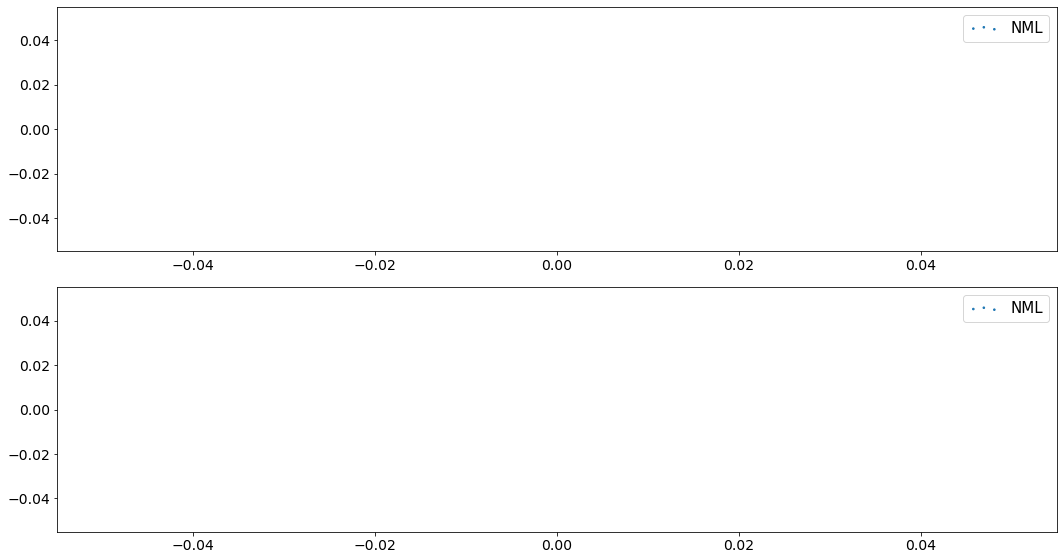

  Fault type Percentage
0        ABC     82.97%
1        ACG     17.04%


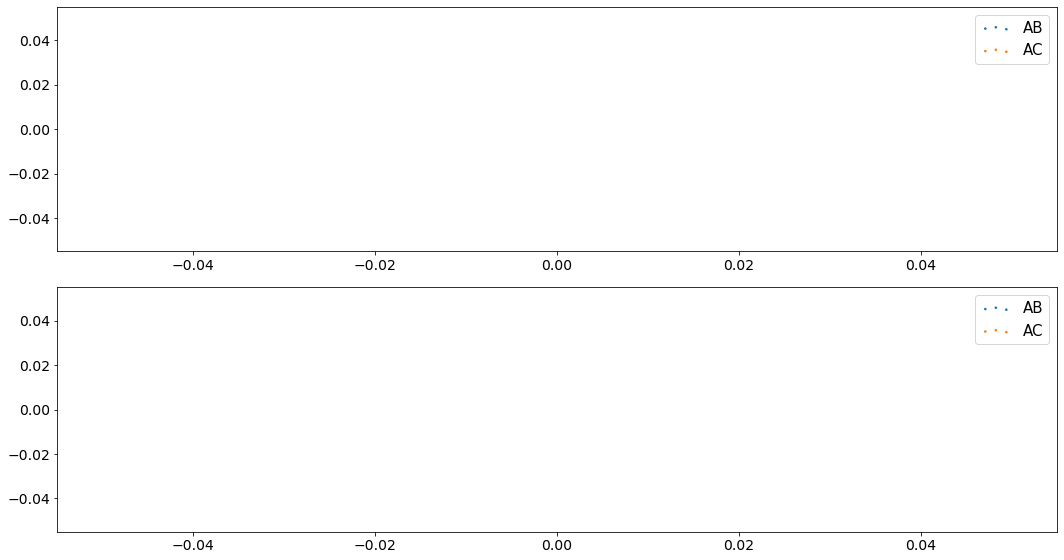


.
.
 4BCG.csv
  Fault type Percentage
0      FAULT     100.0%


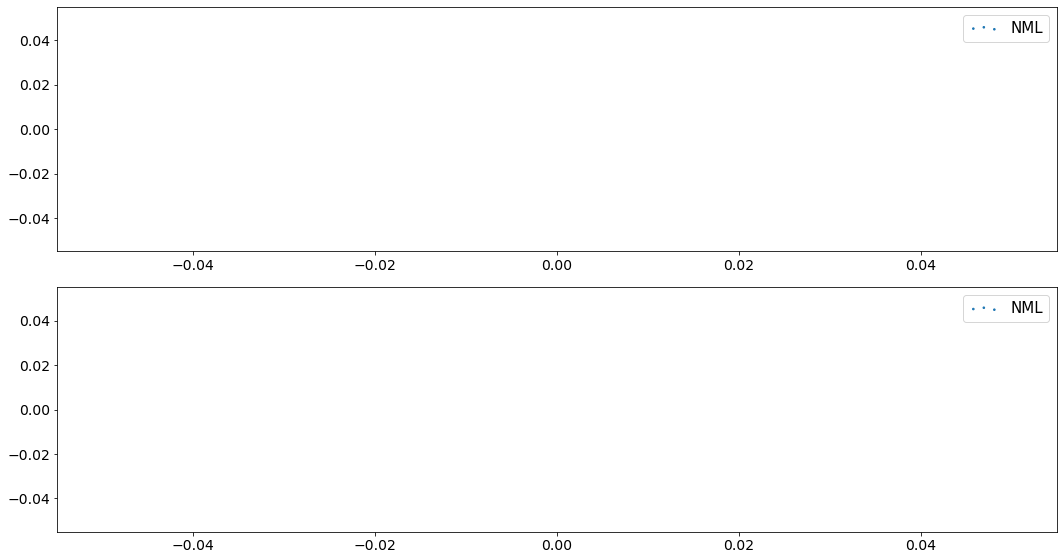

  Fault type Percentage
0        ABC     99.92%
1        BCG      0.07%


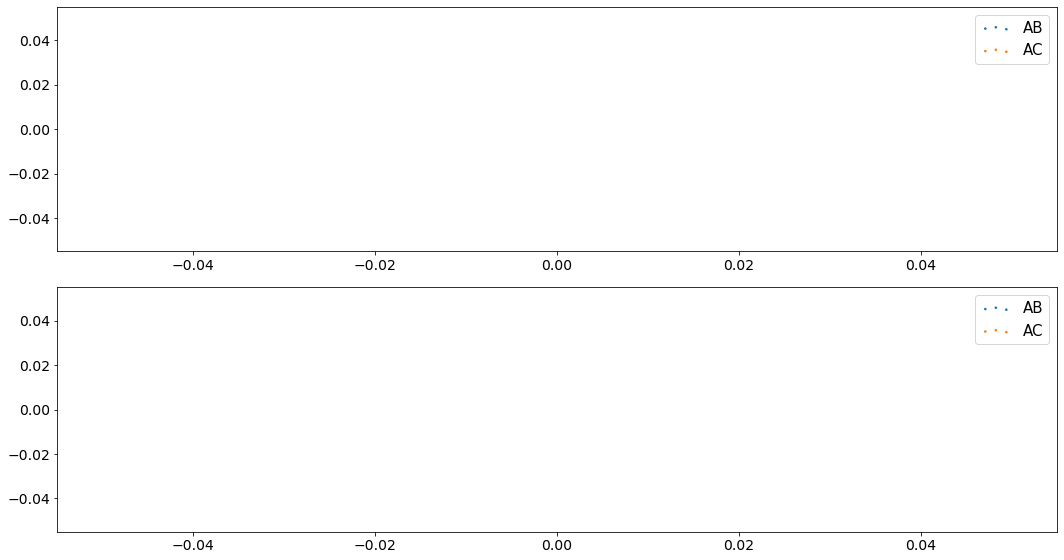


.
.
 7AG.csv
  Fault type Percentage
0      FAULT     100.0%


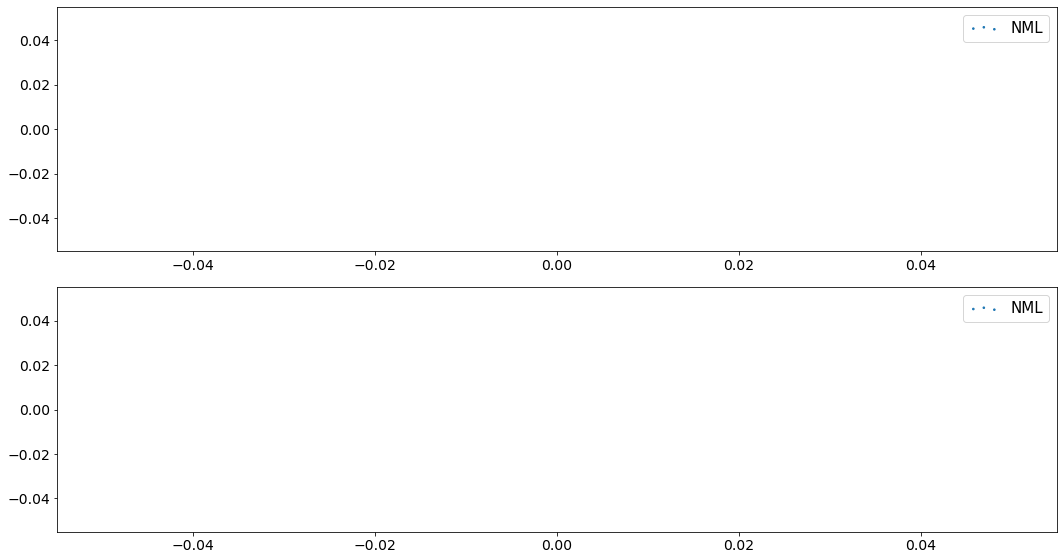

  Fault type Percentage
0        ABC     99.47%
1        ACG      0.38%
2        ABG      0.15%


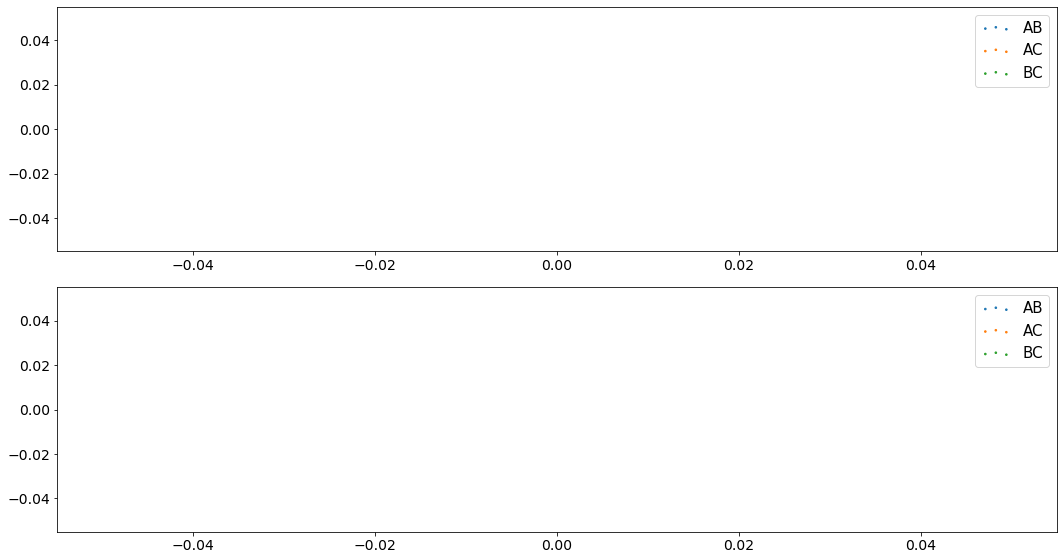


.
.
 8BCG.csv
  Fault type Percentage
0      FAULT     100.0%


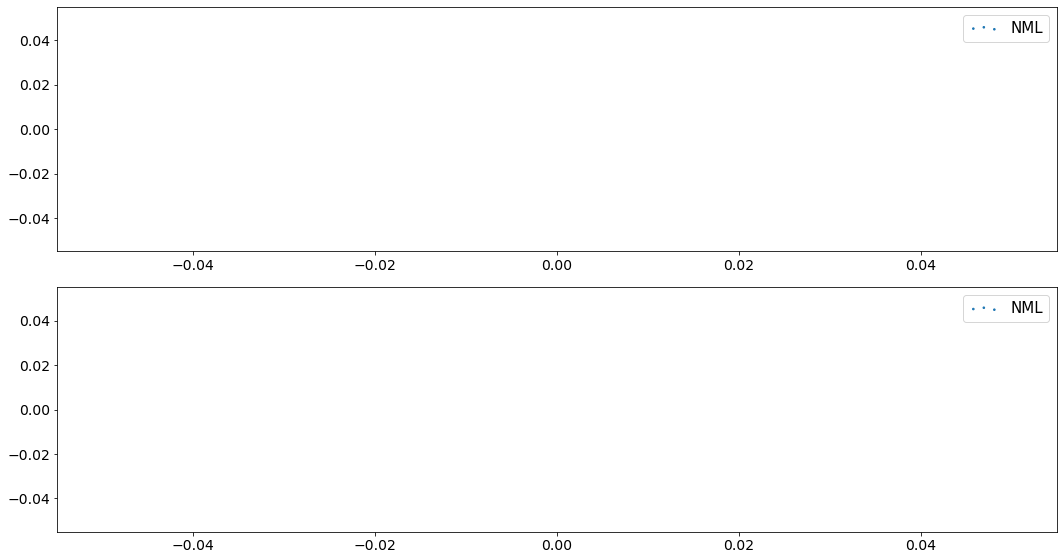

  Fault type Percentage
0        ABC     100.0%


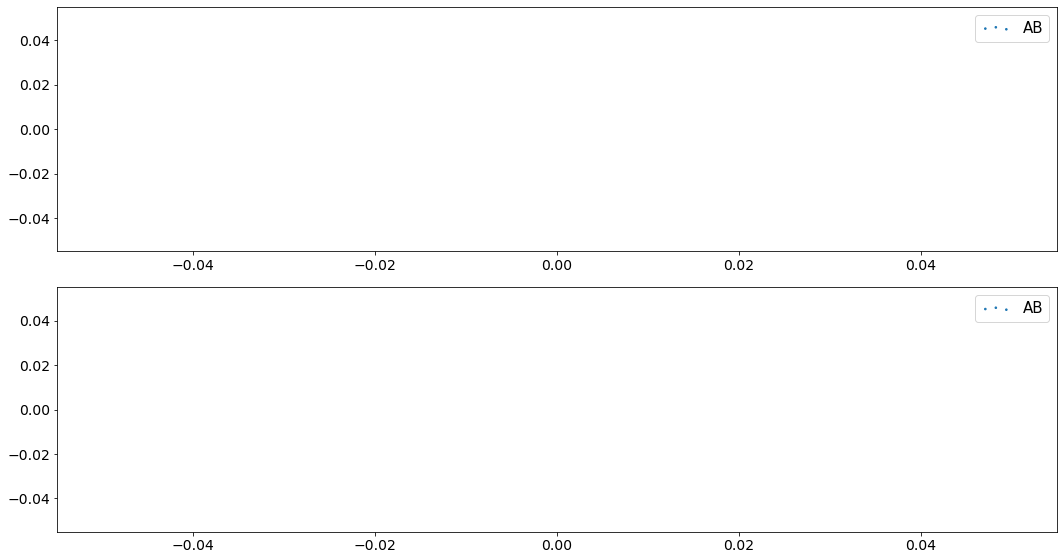

In [28]:
files_failing_the_test = []
files_passing_the_test = []

for each in file_list:
    print("\n.\n.\n",each)  
    temp = tester(binary_model,pd.read_csv('./KMTrainingSet/'+each))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        files_passing_the_test.append(each)
    else:
        files_failing_the_test.append(each)


In [29]:
print(files_passing_the_test,"....\n\n....",files_failing_the_test)

['7ABC.csv', '5ABC.csv', '9ABC.csv', '10ABC.csv', '1ABC.csv', '3ABC.csv', '6ABC.csv', '4ABC.csv', '8ABC.csv', '2ABC.csv'] ....

.... ['5ABCG.csv', '10ABG.csv', '3BC.csv', '3CG.csv', '1BCG.csv', '7BG.csv', '5BG.csv', '9ABG.csv', '1BC.csv', '1CG.csv', '5ABG.csv', '9AG.csv', '7ACG.csv', '7ABG.csv', '9AC.csv', '1BG.csv', '5ACG.csv', '9AB.csv', '9ACG.csv', '5BC.csv', '5CG.csv', '4ABCG.csv', '7BC.csv', '7CG.csv', '10ACG.csv', '3BG.csv', '3BCG.csv', '4BG.csv', '1ACG.csv', '8AG.csv', '3ABG.csv', '10AC.csv', '7BCG.csv', '6ABCG.csv', '6BG.csv', '10AB.csv', '2BC.csv', '2CG.csv', '5BCG.csv', '2BG.csv', '6BC.csv', '6CG.csv', '7ABCG.csv', '9BCG.csv', '10AG.csv', '3ACG.csv', '8AC.csv', '4BC.csv', '4CG.csv', '1ABG.csv', '8AB.csv', '10BCG.csv', '8CG.csv', '8BC.csv', '4AB.csv', '6ACG.csv', '8ABG.csv', '4AC.csv', '4ABG.csv', '2AG.csv', '6AC.csv', '6AB.csv', '2ABCG.csv', '10BG.csv', '2AB.csv', '2BCG.csv', '10BC.csv', '10CG.csv', '10ABCG.csv', '6AG.csv', '3ABCG.csv', '2AC.csv', '4ACG.csv', '8ACG.csv', '4AG

In [22]:
names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_passing_the_test]

In [23]:
Counter(names)

Counter()

  Fault type Percentage
0      FAULT     100.0%


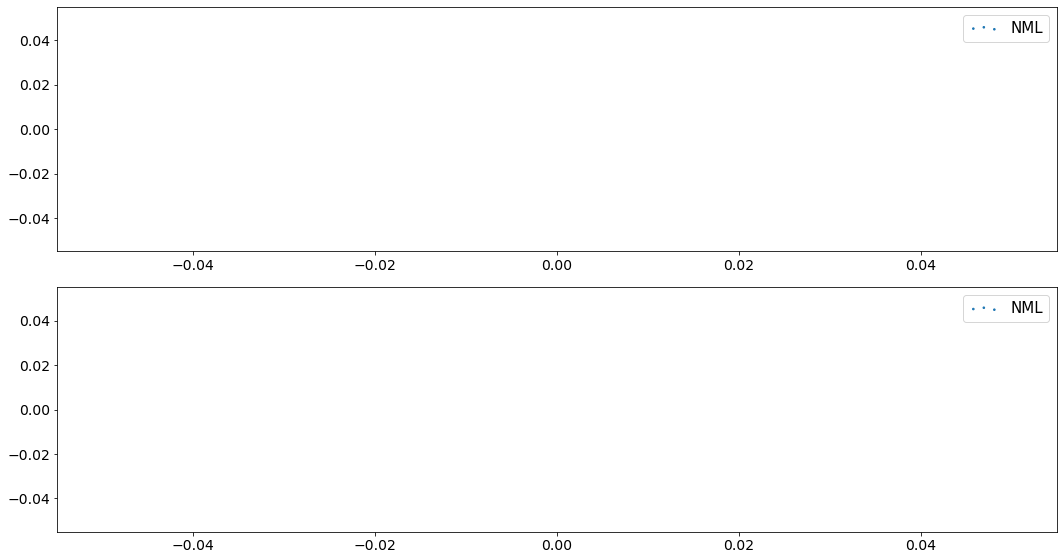

  Fault type Percentage
0        ABC     100.0%


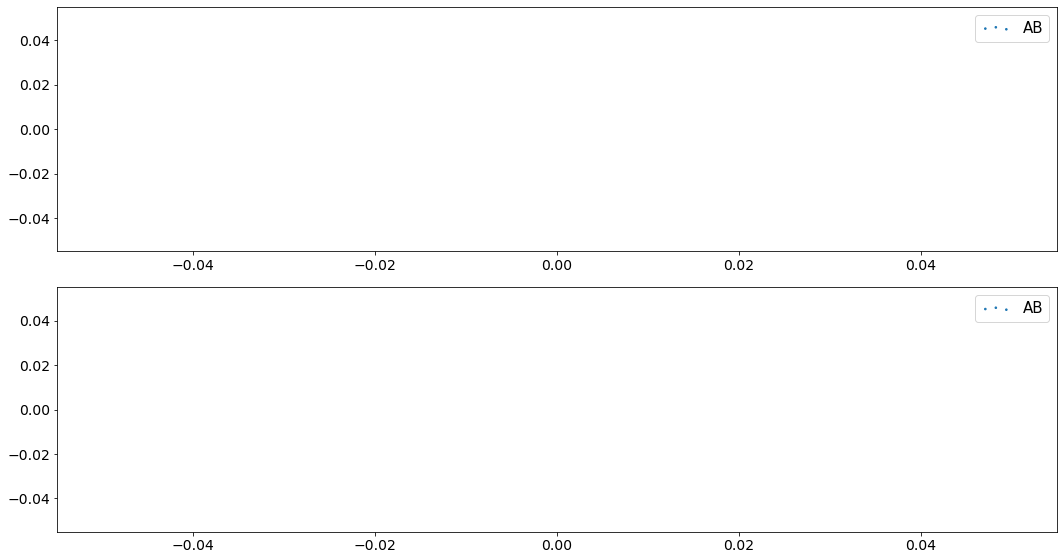

ABC


In [31]:
temp = tester(binary_model,pd.read_csv('ml_test.csv'))
plotter(temp,binary_labels_list,2)
temp = tester(multi_model,temp[temp.label!=0])
high = plotter(temp,multi_labels_list,2)
print(high)

___________________________________________________________________
  Fault type Percentage
0      FAULT     100.0%


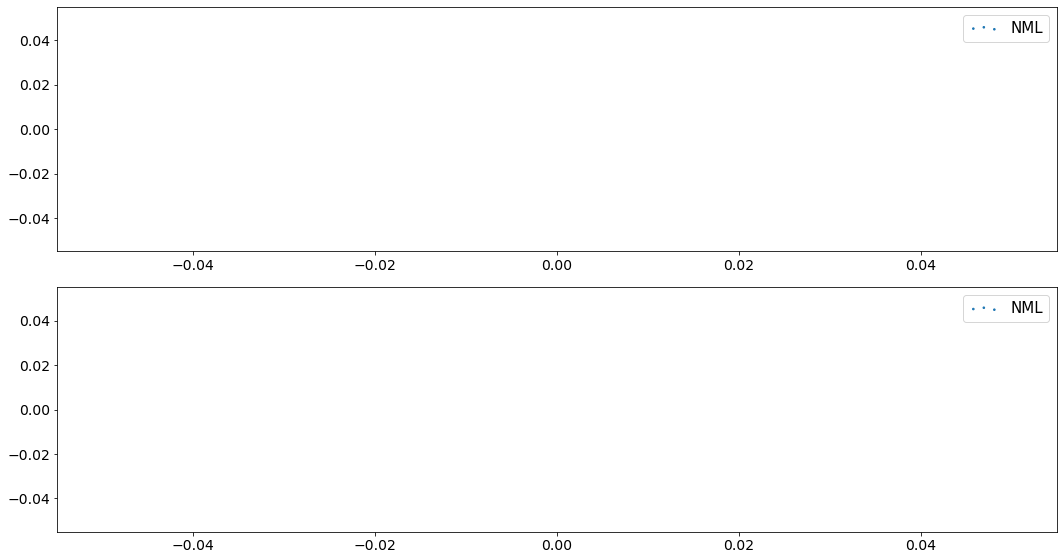

  Fault type Percentage
0        ABC     100.0%


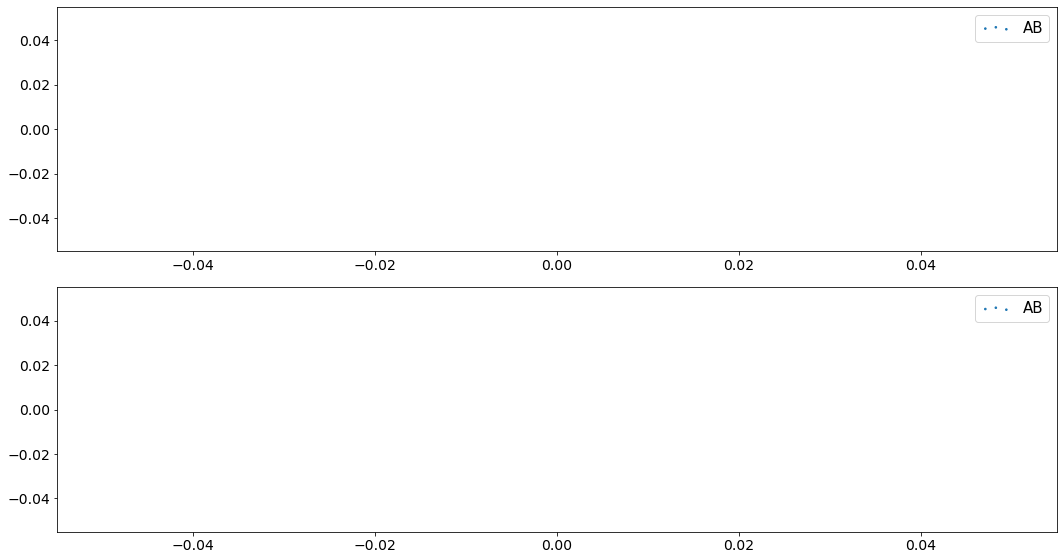

NameError: name 'each' is not defined

In [24]:
files_failing_the_test = []
files_passing_the_test = []
for i in range(1,10):
    print("___________________________________________________________________")
    temp = tester(binary_model,pd.read_csv('./KMTrainingSet/'+str(i)+'ABC.csv'))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        checker.append(str(i)+'ABC.csv')
    else:
        checker.append('incorrect')
    print("----------------------------------------------------------------")
    

In [ ]:
files_failing_model = [str(i)+'ABC.csv' for i in range(len(checker)) if checker[i]=='incorrect']

names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_failing_model]

In [ ]:
Counter(names)

In [ ]:
data = pd.read_csv('./KMTrainingSet/1AG.csv')

In [ ]:
round(data['3V'])

In [ ]:
dat = Counter((round(data['3V'])/10))
matrics = sorted(zip([each for each in Counter(dat).keys()],Counter(dat).values() ), key=lambda x: x[0])





In [ ]:
data = pd.read_csv('KMTrainingset/2ABG.csv')

In [ ]:
features = data[data.columns[:-1]].values.tolist()
#true_labels = data['label'].values.tolist()

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [ ]:
scaled_features

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=500,
    random_state=42
)

In [ ]:
kmeans.fit(scaled_features)

In [ ]:
kmeans.cluster_centers_

In [ ]:
labels = kmeans.fit_predict(features)


In [ ]:
#data['label']=labels
data.head()

In [ ]:
dic = Counter(labels)

In [ ]:
dic

In [ ]:
if dic[1]>dic[0]:
    print("1 = 0 , 0 =1")
    data['label']=[1 if i == 0 else 0 for i in labels]
else:
    print(True)

In [ ]:
dic = Counter(data['label'])

In [ ]:
data

In [ ]:
n_plots = 6
fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))
unique_labels = ['NML','Fault']
cols = data.columns[:-1]

for j in range(6):

    
    legend_list = []
    for i in list(set(data.label)):
        
        plo = data[data.label == i]
        temp = ax[j].scatter(plo.index,plo[cols[j]],marker='+',s=40)  


        legend_list.append(temp)

    ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

fig.tight_layout()
plt.show()

In [ ]:
org = [0,1,0,1,1,1,0,0,1,0,1]
[1 if i == 0 else 0 for i in org]

In [ ]:
for x,y in zip(org,[1 if i == 0 else 0 for i in org]):
    print(x+y)